In [511]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)

In [514]:
dta = pd.read_csv('example_dta.csv')
dta['Institution Name'] = dta['College']
dta = dta.drop(columns = "College")
#dta = dta[['Institution Name']]
dta

,State,Financial GPA,Financial Grade,Institution Name
0,CA,4.50,A+,Stanford University
1,MA,4.50,A+,Massachusetts Institute of Technology
2,IN,4.50,A+,University of Notre Dame
3,NJ,4.50,A+,Princeton University
4,PA,4.50,A+,University of Pennsylvania
5,CT,4.50,A+,Yale University
6,IL,4.50,A+,Northwestern University
7,NH,4.50,A+,Dartmouth College
8,NY,4.50,A+,Columbia University in the City of New York
9,MA,4.50,A+,Williams College


In [ ]:
ipeds2019 = pd.read_csv('Data_9-27-2020---939.csv')
ipeds2019['inst_state'] = ipeds2019['Institution Name'] + " " + ipeds2019['State abbreviation (HD2019)']
ipeds2019[['UnitID', 'inst_state']].set_index('inst_state').to_dict()
ipeds2019

In [517]:
merged = pd.merge(dta, ipeds2019, on = "Institution Name", how = "left", indicator = True)
merged[merged['_merge'] != "both"]

40

In [506]:
dta = pd.read_csv('example_dta.csv')
#dta = dta.head(5)

#dta = dta[(dta.College == "Stanford University") | (dta.College == "Franklin & Marshall College") | 
#          (dta.College == "Tulane University") | (dta.College == "Wheaton College")]

x, y = get_unitids(dta, stateFlag = False)
x

,College,State,Financial GPA,Financial Grade,unitid,match
0,Stanford University,CA,4.50,A+,243744.0,100.0000
1,Massachusetts Institute of Technology,MA,4.50,A+,166683.0,100.0000
2,University of Notre Dame,IN,4.50,A+,152080.0,100.0000
3,Princeton University,NJ,4.50,A+,186131.0,100.0000
4,University of Pennsylvania,PA,4.50,A+,215062.0,100.0000
5,Yale University,CT,4.50,A+,130794.0,100.0000
6,Northwestern University,IL,4.50,A+,147767.0,100.0000
7,Dartmouth College,NH,4.50,A+,182670.0,100.0000
8,Columbia University in the City of New York,NY,4.50,A+,190150.0,100.0000
9,Williams College,MA,4.50,A+,168342.0,100.0000


In [507]:
y

similarity  \
institution                                        match Top 5                                                            
Baptist College of Health Sciences                 1.0   Baptist Memorial College of Health Sciences (TN)      0.912871   
                                                   2.0   Australasian College of Health Sciences (OR)          0.800000   
                                                         Bryan College of Health Sciences (NE)                 0.800000   
                                                         Jefferson College of Health Sciences (VA)             0.800000   
                                                         Sentara College of Health Sciences (VA)               0.800000   
Calumet College of St. Joseph                      1.0   College of St Joseph (VT)                             0.894427   
                                                   2.0   Calumet College of Saint Joseph (IN)                  0.800000   
                                                         College of Mount St Joseph (OH)                       0.800000   
                                                         College of Mount St. Joseph (OH)                      0.800000   
                                                   3.0   St. Joseph's College of Nursing (NY)                  0.730297   
Franklin & Marshall College                        1.0   Franklin and Marshall College (PA)                    0.866025   
                                                   2.0   Franklin College (IN)                                 0.816497   
                                                         Franklin College (TX)                                 0.816497   
                                                   3.0   Franklin Pierce College (NH)                          0.666667   
                                                   4.0   Marshall Community and Technical College (WV)         0.516398   
Golden Gate University                             1.0   Golden Gate University-San Francisco (CA)             0.774597   
                                                   2.0   Chapman University-University College (CA)            0.471405   
                                                   3.0   Indiana University-Purdue University-Indianapol...    0.436436   
                                                         University of Illinois University Administratio...    0.436436   
                                                         University of Maryland-University College (MD)        0.436436   
Hobart and William Smith Colleges                  1.0   Hobart William Smith Colleges (NY)                    0.894427   
                                                   2.0   College of William and Mary (VA)                      0.400000   
                                                   3.0   Texas Barber Colleges and Hairstyling Schools (TX)    0.365148   
                                                   4.0   Richard Bland College of William and Mary (VA)        0.338062   
                                                         State Board for Community and Junior Colleges (MS)    0.338062   
Jefferson (Philadelphia University + Thomas Jef... 1.0   Thomas Jefferson University (PA)                      0.912871   
                                                   2.0   Thomas University (GA)                                0.670820   
                                                   3.0   Saint Thomas University (FL)                          0.547723   
                                                         St Thomas University (FL)                             0.547723   
                                                         St. Thomas University (FL)                            0.547723   
LeMoyne-Owen College                               1.0   Le Moyne-Owen College (TN)                            0.577350   
                                                  

,Unnamed: 0,unitid,institution,endowment
0,0,177834,A T Still University of Health Sciences,32420.0
1,1,180203,Aaniiih Nakoda College,9212.0
2,2,491464,ABC Adult School,NaN
3,3,459523,ABC Beauty Academy,NaN
4,4,485500,ABCO Technology,NaN
...,...,...,...,...
6522,6522,413820,Yukon Beauty College Inc,NaN
6523,6523,451237,Z Hair Academy,NaN
6524,6524,204255,Zane State College,7898.0
6525,6525,458575,Zaytuna College,NaN


In [461]:
dta = pd.read_csv('example_dta.csv')
dta

,College,State,Financial GPA,Financial Grade
0,Stanford University,CA,4.50,A+
1,Massachusetts Institute of Technology,MA,4.50,A+
2,University of Notre Dame,IN,4.50,A+
3,Princeton University,NJ,4.50,A+
4,University of Pennsylvania,PA,4.50,A+
5,Yale University,CT,4.50,A+
6,Northwestern University,IL,4.50,A+
7,Dartmouth College,NH,4.50,A+
8,Columbia University in the City of New York,NY,4.50,A+
9,Williams College,MA,4.50,A+


In [504]:
import re
import math
import numpy as np
from itertools import chain
from collections import Counter
import nltk
from nltk.util import ngrams # This is the ngram magic.
from textblob import TextBlob
import pandas as pd


NGRAM = 1

re_sent_ends_naive = re.compile(r'[.\n]')
re_stripper_alpha = re.compile('[^a-zA-Z]+')
re_stripper_naive = re.compile('[^a-zA-Z\.\n]')

splitter_naive = lambda x: re_sent_ends_naive.split(re_stripper_naive.sub(' ', x))


def get_tuples_nosentences(txt):
    """Get tuples that ignores all punctuation (including sentences)."""
    if not txt: return None
    ng = ngrams(re_stripper_alpha.sub(' ', txt).split(), NGRAM)
    return list(ng)

def cosine_similarity_ngrams(a, b):
    a = get_tuples_nosentences(a)
    b = get_tuples_nosentences(b)
    vec1 = Counter(a)
    vec2 = Counter(b)
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    
    if not denominator:
        return 0.0
    return float(numerator) / denominator

def get_unitids(dataframe, stateFlag):
    dta = dataframe
    dictionary_state = {'unitid': {'A T Still University of Health Sciences MO': 177834, 'Aaniiih Nakoda College MT': 180203, 'Fort Belknap College MT': 180203, 'ABC Adult School CA': 491464, 'ABC Beauty Academy TX': 459523, 'ABCO Technology CA': 485500, 'Abcott Institute MI': 461892, 'Abilene Christian University TX': 222178, 'Abraham Baldwin Agricultural College GA': 138558, 'Abraham Lincoln University CA': 488031, 'Academia Serrant Inc PR': 421896, 'Academy College MN': 172866, 'Academy Di Capelli-School of Cosmetology CT': 449463, 'Academy di Firenze ID': 476957, 'Academy for Careers and Technology SC': 457989, 'Marion County Technical Education Center SC': 457989, 'Academy for Five Element Acupuncture FL': 451079, 'Academy for Jewish Religion-California CA': 457271, 'Academy for Nursing and Health Occupations FL': 412173, 'Academy for Practical Nursing and Health Occupations FL': 412173, 'Academy for Practical Nursing & Health Occupations FL': 412173, 'Academy for Salon Professionals CA': 462062, 'Academy of Art University CA': 108232, 'Academy of Career Training FL': 451097, 'Academy of Careers and Technology WV': 237729, 'Academy of Chinese Culture and Health Sciences CA': 108269, 'Academy of Cosmetology FL': 372462, 'Advanced-Basic Hair Design Training Center FL': 372462, 'Academy of Cosmetology WI': 449852, 'Academy of Cosmetology MT': 179991, 'Academy of Cosmetology Inc MT': 179991, 'Academy of Cosmetology and Esthetics MO': 488165, 'Academy of Cosmetology and Esthetics NYC NY': 457855, 'Academy of Esthetics and Cosmetology CA': 454722, 'Academy of Hair Design-Beaumont TX': 434283, 'Academy of Hair Design TX': 249238, 'Academy of Hair Design-Grenada MS': 175722, 'Academy of Hair Design One MS': 175722, 'Academy of Hair Design-Jackson MS': 374316, 'Academy of Hair Design Three MS': 374316, 'Academy of Hair Design-Jasper TX': 447449, 'Academy of Hair Design-Las Vegas NV': 181880, 'Academy of Hair Design NV': 181880, 'Academy of Hair Design-Lufkin TX': 434274, 'Academy of Hair Design-Oklahoma City OK': 455929, 'Academy of Hair Design OK': 455929, 'Academy of Hair Design-Pearl MS': 382461, 'Academy of Hair Design Four MS': 382461, 'Academy of Hair Design-Springfield MO': 451334, 'Academy of Hair Design MO': 451334, 'Academy of Hair Technology SC': 376446, 'Academy of Interactive Entertainment WA': 482185, 'Academy of Interactive Entertainment LA': 487658, 'Academy of Massage and Bodywork DE': 451051, 'Academy of Natural Therapy Inc CO': 449454, 'Academy of Natural Therapy CO': 449454, 'Academy of Professional Cosmetology AR': 486619, 'Academy of Salon and Spa AR': 107293, 'Mellies Beauty College AR': 107293, 'Academy of Salon Professionals MO': 480879, 'Academy of Vocal Arts PA': 210508, 'Acaydia School of Aesthetics UT': 461342, 'Access Careers NY': 483708, 'Access Careers-Islandia NY': 494904, 'Ace Cosmetology and Barber Training Center CT': 480736, 'Ace Institute of Technology NY': 449676, 'Ace Computer Training Center NY': 449676, 'Acupuncture and Integrative Medicine College-Berkeley CA': 384306, 'Acupuncture and Massage College FL': 439969, 'AM College LLC FL': 439969, 'Adams State University CO': 126182, 'Adams State College CO': 126182, 'Adelphi University NY': 188429, 'Adirondack Community College NY': 188438, 'Adler Graduate School MN': 374024, 'Adler University IL': 142832, 'Adler School of Professional Psychology IL': 142832, 'Adrian College MI': 168528, "Adrian's College of Beauty Turlock CA": 262369, 'Adrians Beauty College of Turlock CA': 262369, 'Adult and Community Education-Hudson OH': 203030, 'North Adult Education Center OH': 203030, 'Adult and Continuing Education-BCTS NJ': 183983, 'Adult & Continuing Education-BCTS NJ': 183983, 'Advance Beauty College CA': 400187, 'Advance Beauty Techs Academy CA': 479974, 'Advance Science International College FL': 444334, 'Advance Science College FL': 444334, 'Advance Science Institute FL': 444334, 'Advanced Barber College and Hair Design TX': 437608, 'Advanced Beauty College TX': 458052, 'Advanced Career Institute CA': 480019, 'Advanced College CA': 444343, 'Advanced College of Cosmetology WI': 461786, 'Advanced College-Stockton CA': 491163, 'Advanced Technology Institute VA': 231411, 'Advanced Training Associates CA': 444361, 'Advanced Training Institute NV': 461430, 'Advanced Welding Institute VT': 456001, 'Advantage Career Institute NJ': 490896, 'Advantage Technical College PR': 423397, 'Professional Electrical School Inc PR': 423397, 'Professional Electric School PR': 423397, 'AdventHealth University FL': 133872, 'Adventist University of Health Sciences FL': 133872, 'Florida Hospital College of Health Sciences FL': 133872, 'Aesthetic Science Institute NY': 476878, 'Aesthetic Science Institute (The) NY': 476878, 'Agnes Scott College GA': 138600, 'AI Miami International University of Art and Design FL': 134811, 'Ai Miami International University of Art and Design FL': 134811, 'Aiken School of Cosmetology and Barbering SC': 457998, 'Aiken School of Cosmetology SC': 457998, 'Aiken Technical College SC': 217615, 'Aims Community College CO': 126207, 'Air Force Institute of Technology-Graduate School of Engineering & Management OH': 200697, 'Alabama A & M University AL': 100654, 'Alabama College of Osteopathic Medicine AL': 483975, 'Alabama School of Nail Technology & Cosmetology AL': 488916, 'Alabama State College of Barber Styling AL': 371034, 'Alabama State University AL': 100724, 'Alamance Community College NC': 199786, 'Alamo City Barber College TX': 482981, 'Alamo Community College District Central Office TX': 222497, 'Alaska Bible College AK': 102580, 'Alaska Career College AK': 103501, 'Career Academy AK': 103501, 'Alaska Christian College AK': 442523, 'Alaska Pacific University AK': 102669, 'Alaska Vocational Technical Center AK': 102711, "AVTEC-Alaska's Institute of Technology AK": 102711, 'Albany BOCES-Adult Practical Nursing Program NY': 418038, 'Albany College of Pharmacy and Health Sciences NY': 188526, 'Albany College of Pharmacy NY': 188526, 'Albany Law School NY': 188535, 'Albany Medical College NY': 188580, 'Albany State University GA': 138716, 'Albany Technical College GA': 138682, 'Albert Einstein College of Medicine NY': 385415, 'Albertus Magnus College CT': 128498, 'Albion College MI': 168546, 'Albright College PA': 210571, 'Alcorn State University MS': 175342, 'Alderson Broaddus University WV': 237118, 'Alderson Broaddus College WV': 237118, 'Alexander Academy MA': 476735, 'Alexander Paul Institute of Hair Design NC': 483425, 'Alexandria School of Scientific Therapeutics IN': 368036, 'Alexandria Technical & Community College MN': 172918, 'Alexandria Technical College MN': 172918, 'Alfred University NY': 188641, 'Alhambra Beauty College CA': 393524, 'Alhambra Medical University CA': 487995, 'Alice Lloyd College KY': 156189, 'All Beauty College AZ': 485306, 'All-State Career School PA': 210599, 'All-State Career School-Lester PA': 210599, 'All-State Career School-Health Sciences PA': 474997, 'All-State Career School-Allied Health Campus PA': 474997, 'All-State Career School-Pittsburgh PA': 418658, 'All State Career School PA': 418658, 'All-State Career-Baltimore MD': 373784, 'All State Career-Baltimore MD': 373784, 'All-State Career School-Baltimore MD': 373784, 'All-State Career School MD': 373784, 'Allan Hancock College CA': 108807, 'Allegany College of Maryland MD': 161688, 'Allegheny College PA': 210669, 'Allegheny Wesleyan College OH': 200873, 'Allen College IA': 152798, 'Allen County Community College KS': 154642, 'Allen School-Brooklyn NY': 188650, 'Allen School-Jamaica NY': 415987, 'Allen School-Phoenix AZ': 469610, 'Allen University SC': 217624, 'Allgood Beauty Institute TX': 490522, 'Alliance Career Center OH': 369109, 'Community Services Division-Alliance City OH': 369109, 'Alliance Computing Solutions NY': 483850, 'Alliant International University-San Diego CA': 110468, 'Alliant International University CA': 110468, 'Allied Health Careers Institute TN': 490151, 'Allstate Hairstyling & Barber College OH': 461111, 'Alma College MI': 168591, 'Alpena Community College MI': 168607, 'Altierus Career College-Bissonnet TX': 445461, 'Everest Institute-Bissonnet TX': 445461, 'Bryman College-National Institute of Technology-Bissonnet TX': 445461, 'Altierus Career College-Norcross GA': 443748, 'Everest Institute-Norcross GA': 443748, 'Georgia Medical Institute GA': 443748, 'Altierus Career College-Tampa FL': 137801, 'Everest University-Tampa FL': 137801, 'Everest Univertisy-Tampa FL': 137801, 'Florida Metropolitan University-Tampa FL': 137801, 'Altierus Career College-Thornton CO': 127787, 'Everest College-Thornton CO': 127787, 'Parks College CO': 127787, 'Altoona Beauty School Inc PA': 210748, 'Alvernia University PA': 210775, 'Alvernia College PA': 210775, 'Alverno College WI': 238193, 'Alvin Community College TX': 222567, 'Amarillo College TX': 222576, 'Amberton University TX': 222628, 'Ambiance Beauty & Barber Academy Inc FL': 476771, 'Ambria College of Nursing IL': 457527, 'Americare Institute IL': 457527, 'America Evangelical University CA': 490081, 'American Academy McAllister Institute of Funeral Service NY': 188687, 'American Academy McAllister Institute of Funeral Services NY': 188687, 'American Academy of Acupuncture and Oriental Medicine MN': 446002, 'American Academy of Art IL': 142887, 'American Academy of Cosmetology FL': 457396, 'American Academy of Dramatic Arts-Los Angeles CA': 108852, 'American Academy of Dramatic Arts-West CA': 108852, 'American Academy of Dramatic Arts-New York NY': 188678, 'American Academy of Dramatic Arts NY': 188678, 'American Academy of Health and Beauty NH': 461290, 'Laird Institute of Spa Therapy NH': 461290, 'American Advanced Technicians Institute FL': 444370, 'American Baptist College TN': 219505, 'American Baptist Seminary of the West CA': 108861, 'American Barber Academy PA': 490258, 'American Beauty Academy UT': 459541, 'American Beauty Academy-West Valley Campus UT': 489247, 'American Beauty Academy-Murray Campus UT': 489247, 'American Beauty College CA': 108977, 'American Beauty School NY': 189477, 'American Beauty Schools FL': 490391, 'American Business and Technology University MO': 457688, 'American College of Technology MO': 457688, 'American Career College-Anaheim CA': 441052, 'American Career College CA': 447768, 'American Career College-Los Angeles CA': 109040, 'American Career College-Ontario CA': 447768, 'American College for Medical Careers FL': 461005, 'American Institute FL': 443234, 'American College of Acupuncture and Oriental Med TX': 429085, 'American College of Barbering KY': 486169, 'American College of Education IN': 449889, 'American College of Financial Services PA': 210809, 'American College PA': 210809, 'American College of Hair Design Inc MO': 179229, 'American College of Hairstyling-Des Moines IA': 153588, 'American College of Healthcare and Technology CA': 422835, 'American College of Healthcare CA': 422835, 'American College of Health Professions CA': 422835, 'American College of Healthcare Sciences OR': 443599, 'Australasian College of Health Sciences OR': 443599, 'American College of the Building Arts SC': 485698, 'American Conservatory Theater CA': 109086, 'American Educational College PR': 241146, 'American Film Institute Conservatory CA': 108870, 'American Fitness and Nutrition Academy CA': 493503, 'American Hair Academy IA': 153463, 'Bill Hills College of Cosmetology IA': 153463, 'American Indian OIC Inc MN': 172927, 'American Institute of Alternative Medicine NJ': 487852, 'American Institute of Alternative Medicine OH': 441636, 'American Institute of Beauty FL': 447883, 'American Institute of Healthcare & Technology CT': 493682, 'American Institute of Interior Design AZ': 404037, 'American Institute of Massage Therapy CA': 447795, 'American Institute of Medical Sciences & Education NJ': 455202, 'American Institute of Medical Technology OK': 449728, 'American Institute-Clifton NJ': 184092, 'Fox Institute of Business-Clifton NJ': 184092, 'American Institute-Somerset NJ': 490869, 'American Institute-Toms River NJ': 482963, 'American Institute-West Hartford CT': 129482, 'Fox Institute of Business-West Hartford CT': 129482, 'Fox Institute of Business CT': 129482, 'American InterContinental University AZ': 445027, 'American InterContinental University-Online AZ': 445027, 'American Intercontinental University Online AZ': 445027, 'American InterContinental University-Atlanta GA': 438586, 'American InterContinental University GA': 438586, 'American Intercontinental University-Dunwoody Campus GA': 438586, 'American Intercontinental University GA': 438586, 'American InterContinental University-Houston TX': 445133, 'American InterContinental University TX': 445133, 'American Intercontinental University TX': 445133, 'American International College MA': 164447, 'American Islamic College IL': 142957, 'American Jewish University CA': 116846, 'University of Judaism CA': 116846, 'American Massage & Bodywork Institute VA': 492643, 'American Medical Academy FL': 475714, 'American Medical Sciences Center CA': 461263, 'American Musical and Dramatic Academy NY': 188854, 'American National University VA': 232797, 'National College-Salem VA': 232797, 'National College of Business and Technology-Salem VA': 232797, 'American National University-Dayton OH': 453455, 'National College-Dayton OH': 453455, 'National College OH': 453455, 'American National University-Lexington KY': 157021, 'National College-Lexington KY': 157021, 'National College of Business and Technology-Lexington KY': 157021, 'American Public University System WV': 449339, 'American River College CA': 109208, 'American Samoa Community College AS': 240736, 'American School of Nursing and Medical Careers NH': 460570, 'Salter School of Nursing and Allied Health NH': 460570, 'Salter School of Nursing & Allied Health NH': 460570, 'American Sentinel University CO': 460738, 'American Technical Institute PR': 461625, 'American Trade School MO': 461573, 'American University DC': 131159, 'American University of Health Sciences CA': 433004, 'American Institute of Health Sciences CA': 433004, 'American University of Puerto Rico PR': 241128, 'AmeriTech College-Draper UT': 447263, 'AmeriTech College UT': 229957, 'American Institute of Medical-Dental Technology UT': 229957, 'AmeriTech College-Provo UT': 229957, 'AMG School of Licensed Practical Nursing NY': 486415, 'Amherst College MA': 164465, 'Amridge University AL': 100690, 'Regions University AL': 100690, 'Southern Christian University AL': 100690, 'Amslee Institute FL': 492032, 'Anabaptist Mennonite Biblical Seminary IN': 151865, 'Anabaptist Mennonite Biblical Seminary  Inc. IN': 151865, 'Associated Mennonite Biblical Seminary IN': 151865, 'Ancilla College IN': 150048, 'Anderson University SC': 217633, 'Anderson University IN': 150066, 'Andover Newton Theological School MA': 164474, 'Andrew College GA': 138761, 'Andrews University MI': 168740, 'Angeles College CA': 457299, 'Angeles College of Nursing CA': 457299, 'Angeles Institute CA': 457314, 'Angelina College TX': 222822, 'Angelo State University TX': 222831, 'Ann Webb Skin Institute TX': 490425, 'Anna Maria College MA': 164492, 'Anne Arundel Community College MD': 161767, 'Annenberg School of Nursing CA': 475705, 'Anoka Technical College MN': 172954, 'Anoka-Ramsey Community College MN': 172963, 'Anoka-Ramsey Community College-Coon Rapids Campus MN': 172963, 'Another Level Barbering and Cosmetology School VA': 491978, 'Anousheh School of Hair NY': 491969, 'Anson College of Cosmetology NC': 434292, 'Antelope Valley College CA': 109350, 'Antilles School of Technical Careers PR': 241182, 'Antioch College OH': 483018, 'Antioch University Online OH': 485908, 'Antioch University-Connected OH': 485908, 'Antioch University-Los Angeles CA': 245838, 'Antioch University Los Angeles CA': 245838, 'Antioch University-Los Angeles Branch CA': 245838, 'Antioch University-Midwest OH': 245892, 'Antioch University McGregor OH': 245892, 'Antioch University-New England NH': 245865, 'Antioch University New England NH': 245865, 'Antioch New England Graduate School NH': 245865, 'Antioch University-PhD Program in Leadership and Change OH': 442392, 'Antioch University PhD Program in Leadership and Change OH': 442392, 'Antioch University-Santa Barbara CA': 245847, 'Antioch University-Santa Barbara Branch CA': 245847, 'Antioch University-Seattle WA': 245883, 'Antioch University Seattle WA': 245883, 'Antioch University-Seattle Branch WA': 245883, 'Antioch University-System Administration OH': 440138, 'Antonelli College-Cincinnati OH': 201016, 'Antonelli College OH': 201016, 'Antonelli College-Hattiesburg MS': 383950, 'Antonelli College MS': 175528, 'Antonelli College-Jackson MS': 175528, 'AOMA Graduate School of Integrative Medicine TX': 429094, 'Academy of Oriental Medicine at Austin TX': 429094, 'Academy of Oriental Medicine TX': 429094, 'Aparicio-Levy Technical College FL': 485342, 'Aparicio-Levy Technical Center FL': 485342, 'Apex Academy Hair Skin Nails School of Cosmetology OH': 490434, 'Apex School of Theology NC': 441511, 'Apex Technical School NY': 188890, 'Apollo Career Center OH': 201034, 'Appalachian Beauty School KY': 237127, 'Appalachian Bible College WV': 237136, 'Appalachian College of Pharmacy VA': 449922, 'University of Appalachia VA': 449922, 'Appalachian School of Law VA': 432348, 'Appalachian State University NC': 197869, 'Applied Technology Services MO': 417716, 'North County Technical Special School District MO': 417716, 'Aquinas College MI': 168786, 'Aquinas Institute of Theology MO': 176600, 'Arapahoe Community College CO': 126289, 'Arcadia University PA': 211088, 'Arclabs SC': 487791, 'Aria Health School of Nursing PA': 212568, 'Frankford Hospital School of Nursing PA': 212568, 'Arizona Academy of Beauty-East AZ': 103954, 'Arizona Academy of Beauty Inc AZ': 103954, 'Arizona Board of Regents AZ': 420802, 'Arizona Christian University AZ': 105899, 'Southwestern College AZ': 105899, 'Arizona College-Dallas TX': 494162, 'Arizona College-Glendale AZ': 421708, 'Arizona College of Allied Health AZ': 421708, 'Arizona College-Las Vegas NV': 487375, 'Arizona College - Las Vegas NV': 487375, 'Arizona College-Mesa AZ': 482990, 'Arizona College-Tempe AZ': 494171, 'Arizona Culinary Institute AZ': 450951, 'Arizona School of Acupuncture and Oriental Medicine AZ': 446039, 'Arizona School of Integrative Studies AZ': 484163, 'Arizona State University-Downtown Phoenix AZ': 448886, 'Arizona State University at the Downtown Phoenix Campus AZ': 448886, 'Arizona State University-Polytechnic AZ': 420574, 'Arizona State University at the Polytechnic Campus AZ': 420574, 'Arizona State University East AZ': 420574, 'Arizona State University-Skysong AZ': 483124, 'Arizona State University-Tempe AZ': 104151, 'Arizona State University AZ': 104151, 'Arizona State University at the Tempe Campus AZ': 104151, 'Arizona State University-West AZ': 407009, 'Arizona State University at the West Campus AZ': 407009, 'Arizona Western College AZ': 104160, 'Arkansas Baptist College AR': 106306, 'Arkansas Beauty College AR': 106324, 'Arkansas Beauty School-Little Rock AR': 106315, 'Arkansas Beauty School AR': 106315, 'Arkansas College of Barbering and Hair Design AR': 106351, 'Arkansas Colleges of Health Education AR': 488527, 'Arkansas Northeastern College AR': 107327, 'Arkansas State University Mid-South AR': 107318, 'Mid-South Community College AR': 107318, 'Arkansas State University System AR': 448336, 'Arkansas State University-System Office AR': 448336, 'Arkansas State University System Office AR': 448336, 'Arkansas State University Three Rivers AR': 107521, 'College of the Ouachitas AR': 107521, 'Ouachita Technical College AR': 107521, 'Arkansas State University-Beebe AR': 106449, 'Arkansas State University-Main Campus AR': 106458, 'Arkansas State University-Mountain Home AR': 420538, 'Arkansas State University-Newport AR': 440402, 'Arkansas Tech University AR': 106467, 'Arkansas Welding Academy AR': 491075, 'Arlington Baptist University TX': 222877, 'Arlington Baptist College TX': 222877, 'Arlington Career Institute TX': 222886, 'Arnolds Beauty School TN': 219587, 'Arnot Ogden Medical Center NY': 188915, 'Arrojo Cosmetology School NY': 482194, 'Art Academy of Cincinnati OH': 201061, 'Art Center College of Design CA': 109651, "Arthur's Beauty College Inc-Fort Smith AR": 106360, "Arthur's Beauty College Inc-Jacksonville AR": 106494, "Arthur's Beauty College Inc AR": 106494, "Arthur's Beauty College-Jonesboro AR": 489830, "Arthur's Beauty School Inc-Conway AR": 445540, 'Artistic Academy of Hair Design NJ': 414063, 'Artistic Nails and Beauty Academy-Lakeland FL': 460701, 'Artistic Nails and Beauty Academy FL': 378886, 'Artistic Nails and Beauty Academy-Tampa FL': 378886, 'ASA College NY': 404994, 'ASA Institute of Business and Computer Technology NY': 404994, 'Asbury Theological Seminary KY': 156222, 'Asbury University KY': 156213, 'Asbury College KY': 156213, 'Asher College CA': 447777, 'TechSkills of Sacramento CA': 447777, 'Asheville-Buncombe Technical Community College NC': 197887, 'Asheville Buncombe Technical Community College NC': 197887, 'Ashford University CA': 154022, 'Ashland Community and Technical College KY': 156231, 'Ashland County-West Holmes Career Center OH': 201098, 'Ashland University OH': 201104, 'Ashtabula County Technical and Career Campus OH': 201131, 'Ashtabula County Joint Vocational School OH': 201131, 'ASI Career Institute NJ': 475431, 'Asian-American International Beauty College CA': 393861, 'Asian American International Beauty College CA': 393861, 'ASM Beauty World Academy FL': 391546, 'Asnuntuck Community College CT': 128577, 'Aspen Beauty Academy of Laurel MD': 480994, 'Aspen University CO': 454829, 'Assabet Valley Regional Technical School MA': 164535, 'Associated Barber College of San Diego CA': 485494, 'Associated Beth Rivkah Schools NY': 188942, 'Associated Technical College-Los Angeles CA': 109721, 'Associated Technical College CA': 109730, 'Associated Technical College-San Diego CA': 109730, 'Assumption College MA': 164562, 'Assumption College for Sisters NJ': 183600, 'Astrodome Career Centers TX': 379746, 'Pinnacle Career Center TX': 379746, 'Pinnacle Career Centers TX': 379746, 'ATA Career Education FL': 446127, 'Career Institute of Florida FL': 446127, 'ATA College KY': 447935, 'ATA Career Education KY': 447935, 'ATA College - Cincinnati OH': 452373, 'ATA College Tri-County OH': 452373, 'Beckfield College-Tri-County OH': 452373, 'Beckfield College OH': 452373, 'Atelier Esthetique Institute of Esthetics NY': 461768, 'Atenas College PR': 440651, 'Athena Career Academy OH': 476683, 'Athenaeum of Ohio OH': 201140, 'Athens State University AL': 100812, 'Athens Technical College GA': 246813, 'ATI College-Norwalk CA': 444325, 'ATI College CA': 444325, 'Atlanta Institute of Music and Media GA': 419244, 'Atlanta Institute of Music GA': 419244, 'Atlanta Metropolitan State College GA': 138901, 'Atlanta Metropolitan College GA': 138901, 'Atlanta School of Massage GA': 138938, 'Atlanta Technical College GA': 138840, "Atlanta's John Marshall Law School GA": 138929, 'John Marshall Law School-Atlanta GA': 138929, 'Atlantic Beauty & Spa Academy LLC NJ': 186593, 'Shore Beauty School NJ': 186593, 'Atlantic Cape Community College NJ': 183655, 'Atlantic Institute of Oriental Medicine FL': 439446, 'Atlantic Technical College FL': 132374, 'Atlantic Technical Center FL': 132374, 'Atlantic University College PR': 241216, 'Atlantic College PR': 241216, 'Atlantis University FL': 485768, 'Auburn Career Center OH': 201159, 'Auburn University AL': 100858, 'Auburn University Main Campus AL': 100858, 'Auburn University at Montgomery AL': 100830, 'Auburn University-Montgomery AL': 100830, 'Augsburg University MN': 173045, 'Augsburg College MN': 173045, 'Augusta School of Massage GA': 447917, 'Augusta Technical College GA': 138956, 'Augusta University GA': 482149, 'Georgia Regents University GA': 482149, 'Augustana College IL': 143084, 'Augustana University SD': 219000, 'Augustana College SD': 219000, 'Auguste Escoffier School of Culinary Arts-Austin TX': 444556, 'Culinary Academy of Austin TX': 444556, 'Auguste Escoffier School of Culinary Arts-Boulder CO': 454810, 'Auguste Escoffier School of Culinary Arts CO': 454810, 'Culinary School of the Rockies CO': 454810, 'Aultman College of Nursing and Health Sciences OH': 201177, 'Aultman Hospital School of Nursing OH': 201177, 'Aurora University IL': 143118, 'Austin College TX': 222983, 'Austin Community College District TX': 222992, 'Austin Community College TX': 222992, 'Austin Graduate School of Theology TX': 247825, 'Austin Kade Academy ID': 476869, 'Austin Peay State University TN': 219602, 'Austin Presbyterian Theological Seminary TX': 223001, "Austin's Beauty College Inc TN": 219851, "Austin's Beauty College TN": 219851, 'Automeca Technical College-Aguadilla PR': 418782, 'Automeca Technical College PR': 419721, 'Automeca Technical College-Bayamon PR': 419703, 'Automeca Technical College-Caguas PR': 419712, 'Automeca Technical College-Ponce PR': 419721, 'Automotive Training Center-Exton PA': 211006, 'Automotive Training Center PA': 448770, 'Automotive Training Center-Warminster PA': 448770, 'Autry Technology Center OK': 365213, 'Avalon School of Cosmetology MN': 457679, 'Avalon School of Cosmetology-Alameda CA': 108649, 'Alameda Beauty College CA': 108649, 'Avalon School of Cosmetology-Aurora CO': 372356, 'Xenon International Academy-Denver CO': 372356, 'Xenon International Academy CO': 372356, 'Xenon International School of Hair Design III CO': 372356, 'Avalon School of Cosmetology-Layton UT': 474924, 'Avalon School of Cosmetology-Mesa AZ': 104568, 'Avalon School of Cosmetology AZ': 104568, 'Earls Academy of Beauty AZ': 104568, 'Avalon School of Cosmetology-Phoenix AZ': 474915, 'Ave Maria School of Law FL': 442295, 'Ave Maria University FL': 446048, 'Aveda Arts & Sciences Institute-Baton Rouge LA': 159513, 'Aveda Institute-Baton Rouge LA': 159513, 'Aveda Arts & Sciences Institute-Covington LA': 160320, 'Aveda Institute-Covington LA': 160320, 'Aveda Arts & Sciences Institute-Lafayette LA': 159522, 'Aveda Institute-Lafayette LA': 159522, 'Aveda Arts & Sciences Institute-San Antonio TX': 455354, 'Aveda Institute-San Antonio TX': 455354, 'Aveda Institute San Antonio TX': 455354, "Aveda Fredric's Institute-Cincinnati OH": 451468, "Aveda Fredric's Institute OH": 451468, "Aveda Fredric's Institute-Indianapolis IN": 457563, 'Aveda Institute Portland-Vancouver Campus WA': 487348, 'Aveda Institute-Boise ID': 461652, "D'Shaw Institute of Cosmetology ID": 461652, 'Aveda Institute-Chapel Hill NC': 455141, 'Aveda Institute Chapel Hill NC': 455141, 'Aveda Institute-Chicago IL': 455877, 'Aveda Institute-Columbus OH': 455275, 'Aveda Institute Columbus OH': 455275, 'Aveda Institute-Denver CO': 459277, 'Aveda Institute Denver CO': 459277, 'Aveda Institute-Des Moines IA': 475015, 'Aveda Institute Des Moines IA': 475015, 'Aveda Institute-Los Angeles CA': 469957, 'Aveda Institute Los Angeles CA': 469957, "Aveda Fredric's Institute CA": 469957, 'Aveda Institute-Madison WI': 487506, 'Aveda Institute-Maryland MD': 162830, 'The Colorlab Academy of Hair MD': 162830, 'International Beauty School-Bel Air MD': 162830, 'Aveda Institute-Minneapolis MN': 173744, 'Aveda Institute MN': 173744, 'Aveda Institute-New Mexico NM': 461555, 'Aveda Institute of New Mexico (The) NM': 461555, 'Aveda Institute-New York NY': 448071, 'Aveda Institute New York NY': 448071, 'Aveda Institute-Phoenix AZ': 484899, 'Aveda Institute Phoenix AZ': 484899, 'Aveda Institute-Portland OR': 460862, 'Aveda Institute Portland OR': 460862, 'Aveda Institute-Provo UT': 451574, 'Dallas Roberts Academy of Hair Design & Aesthetics UT': 451574, 'Aveda Institute-South Florida FL': 451149, 'Aveda Institute-Saint Petersburg FL': 451149, 'Aveda Institute-Tallahassee FL': 451158, 'Aveda Institute-Tucson AZ': 476753, 'Aveda Institute Tucson AZ': 476753, 'Aveda Institute-Twin Falls ID': 142407, 'Joseph Charles Institute of Cosmetology ID': 142407, 'Joseph Charles Institute ID': 142407, 'Mr Juans College of Hair Design ID': 142407, 'Avenue Academy  A Cosmetology Institute NM': 491826, 'Avenue Five Institute TX': 458070, 'Avenue Five Institute-South Austin Campus TX': 494524, 'Avera McKennan Hospital School of Radiologic Technology SD': 219170, 'Avera Sacred Heart Hospital SD': 219338, 'Averett University VA': 231420, 'Averett University-Non-Traditional Programs VA': 449931, 'Averett University-Non-traditional programs VA': 449931, 'Avery James School of Cosmetology LA': 158778, 'Demmons School of Beauty LA': 158778, 'Avi Career Training VA': 448257, 'Ana Visage Institute VA': 448257, 'Ana Visage Academy VA': 448257, 'Aviation Institute of Maintenance CA': 486558, 'Aviation Institute of Maintenance-Atlanta GA': 440059, 'Aviation Institute of Maintenance-Charlotte NC': 494764, 'Aviation Institute of Maintenance-Chesapeake VA': 427973, 'Aviation Institute of Maintenance-Virginia Beach VA': 427973, 'Aviation Institute of Maintenance-Dallas TX': 441788, 'Aviation Institute of Maintenance-Houston TX': 227748, 'Aviation Institute of Maintenance TX': 227748, 'Redstone Institute-Houston TX': 227748, 'Aviation Institute of Maintenance-Indianapolis IN': 438735, 'Aviation Institute of Maintenance-Kansas City MO': 441496, 'Aviation Institute of Maintenance-Las Vegas NV': 482255, 'Aviation Institute of Maintenance-Manassas VA': 445762, 'Aviation Institute of Maintenance-Orlando FL': 457411, 'Aviation Institute of Maintenance-Philadelphia PA': 250285, 'Aviator College of Aeronautical Science and Technology FL': 447847, 'Ari Ben Aviator FL': 447847, 'Avila University MO': 176628, 'Award Beauty School MD': 161800, 'Ayers Career College LA': 158246, 'Ayers Institute Inc LA': 158246, 'Azusa Pacific University CA': 109785, 'B M Spurr School of Practical Nursing WV': 237145, 'B-Unique Beauty and Barber Academy SC': 487898, 'Babson College MA': 164580, 'Bacone College OK': 206817, 'Bais Binyomin Academy NY': 128586, 'Bais HaMedrash and Mesivta of Baltimore MD': 476601, 'Bais Medrash Elyon NY': 245777, 'Bais Medrash Mayan Hatorah NJ': 490513, 'Bais Medrash Toras Chesed NJ': 449658, 'Baker College MI': 168847, 'Baker College of Flint MI': 168847, 'Baker University KS': 154688, 'Baker University College of Arts and Sciences KS': 154688, 'Bakersfield College CA': 109819, 'Bakke Graduate University TX': 420705, 'Baldwin Beauty School-North Austin TX': 414489, 'Baldwin Beauty School TX': 223056, 'Baldwin Beauty School-South Austin TX': 223056, 'Baldwin Beauty School 5 TX': 223056, 'Baldwin Park Adult & Community Education CA': 417105, 'Baldwin Wallace University OH': 201195, 'Baldwin-Wallace College OH': 201195, 'Baldy View Regional Occupational Program CA': 490212, 'Ball State University IN': 150136, 'Baltimore City Community College MD': 161864, 'Baltimore Studio of Hair Design MD': 161855, 'Bancroft School of Massage Therapy MA': 164599, 'Bank Street College of Education NY': 189015, 'Baptist Bible College MO': 176664, 'Baptist Bible College and Graduate School MO': 176664, 'Baptist Health College Little Rock AR': 106546, 'Baptist Health College-Little Rock AR': 106546, 'Baptist Health Schools-Little Rock AR': 106546, 'Baptist Health Schools of Nursing and Allied Health AR': 106546, 'Baptist Health System School of Health Professions TX': 223083, 'Baptist Memorial College of Health Sciences TN': 219639, 'Baptist Missionary Association Theological Seminary TX': 223117, 'Baptist Theological Seminary at Richmond VA': 366793, 'Baptist University of the Americas TX': 444398, 'Barber & Beauty Institute of New York NY': 476610, 'Long Island Barber Institute NY': 476610, 'Long Island Barber Institute (The) NY': 476610, 'Barber Institute of Texas TX': 484048, 'Barber School of Pittsburgh PA': 483054, 'Barber Tech Academy SC': 488022, 'Barclay College KS': 155070, 'Bard College NY': 189088, "Bard College at Simon's Rock MA": 167792, 'Simons Rock College of Bard MA': 167792, 'Barnard College NY': 189097, 'Barnes-Jewish College Goldfarb School of Nursing MO': 177719, 'Barnes-Jewish College of Nursing and Allied Health MO': 177719, 'Barrett and Company School of Hair Design KY': 156277, 'Barry University FL': 132471, 'Barstow Community College CA': 109907, 'Barton College NC': 197911, 'Barton County Community College KS': 154697, 'Bastyr University WA': 235547, 'Bates College ME': 160977, 'Bates Technical College WA': 235671, 'Baton Rouge Community College LA': 437103, 'Baton Rouge General Medical Center-School of Nursing LA': 158325, 'Baton Rouge General Medical Center School of Nursing LA': 158325, 'Baton Rouge School of Computers LA': 158343, 'Bay Area Medical Academy CA': 483878, 'Bay de Noc Community College MI': 168883, 'Bay Mills Community College MI': 380359, 'Bay Path University MA': 164632, 'Bay Path College MA': 164632, 'Bay State College MA': 164641, 'Bay State School of Technology MA': 164678, 'Bayamon Community College PR': 444194, 'Baylor College of Medicine TX': 223223, 'Baylor University TX': 223232, 'Bayshire Academy of Beauty Craft Inc MI': 168892, "Be'er Yaakov Talmudic Seminary NY": 476717, 'Beacon College FL': 384254, 'Beal College ME': 160995, 'Beau Monde Academy of Cosmetology OR': 485166, 'Beau Monde College of Hair Design-Beau Monde Academy of Cosmetology OR': 485166, 'Beaufort County Community College NC': 197966, 'Beaumont Adult School CA': 449357, 'Beauty Academy of South Florida FL': 460969, 'Beauty School of Middletown NY': 374927, 'Beauty Schools of America-Hialeah FL': 419660, 'Beauty Schools of America FL': 450182, 'Beauty Schools of America-Homestead FL': 456861, 'Beauty Schools of America-Miami FL': 135771, 'Beauty Schools of America-North Miami Beach FL': 450182, 'Beauty Technical College Inc OK': 207272, 'Beaver Falls Beauty Academy PA': 215336, 'Becker College MA': 164720, 'Beckfield College-Florence KY': 247065, 'Beckfield College KY': 247065, 'Beis Medrash Heichal Dovid NY': 444413, 'Bel-Rea Institute of Animal Technology CO': 126359, 'Belanger School of Nursing NY': 190956, 'Ellis School of Nursing NY': 190956, 'Ellis Hospital School of Nursing NY': 190956, 'Belhaven University MS': 175421, 'Belhaven College MS': 175421, 'Bell Mar Beauty College IL': 364760, 'Bella Academy of Cosmetology WI': 486309, 'Bella Capelli Academy PA': 461193, 'Bella Cosmetology College TX': 483559, 'Bellarmine University KY': 156286, 'Bellasa Professional Institute FL': 493567, 'Belle Academy of Cosmetology LLC CT': 481571, 'Belle Academy of Cosmetology CT': 481571, 'Bellevue College WA': 234669, 'Bellevue Community College WA': 234669, 'Bellevue University NE': 180814, 'Bellin College WI': 238324, 'Bellin College of Nursing WI': 238324, 'Bellingham Technical College WA': 234696, 'Bellus Academy KS': 478953, 'Bellus Academy-Chula Vista CA': 109934, 'Bellus Academy-National City CA': 109934, 'Bay Vista College of Beauty CA': 109934, 'Bellus Academy-El Cajon CA': 116563, 'J Boutique College of Beauty CA': 116563, 'Bellus Academy-Poway CA': 377722, 'Bellus Academy CA': 377722, 'Academy of Hair Design-Poway CA': 377722, 'Belmont Abbey College NC': 197984, 'Belmont College OH': 201283, 'Belmont Technical College OH': 201283, 'Belmont University TN': 219709, 'Beloit College WI': 238333, 'Bemidji State University MN': 173124, 'Ben Franklin Career Center WV': 237172, "Bene's Career Academy FL": 137591, 'Benes International School of Beauty FL': 137591, 'Benedict College SC': 217721, 'Benedictine College KS': 154712, 'Benedictine University IL': 145619, 'Benjamin Franklin Institute of Technology MA': 165884, 'Bennett Career Institute DC': 439473, 'Bennett College NC': 197993, 'Bennett College for Women NC': 197993, 'Bennington College VT': 230816, 'Bentley University MA': 164739, 'Bentley College MA': 164739, 'Berea College KY': 156295, 'Bergen Community College NJ': 183743, 'Bergin University of Canine Studies CA': 461643, 'Berk Trade and Business School NY': 189219, 'Berkeley City College CA': 125170, 'Berkeley College-New York NY': 189228, 'Berkeley College NY': 189228, 'Berkeley College-Woodland Park NJ': 183789, 'Berkeley College NJ': 183789, 'Berklee College of Music MA': 164748, 'Berkowits School of Electrolysis NY': 189255, 'Berks Career & Technology Center PA': 481021, 'Berkshire Community College MA': 164775, 'Berry College GA': 139144, 'Best Care College NJ': 461865, 'Best Care Training Institute NJ': 461865, 'Bet Medrash Gadol Ateret Torah NY': 485999, 'Beth Hamedrash Shaarei Yosher Institute NY': 189273, 'Beth Hatalmud Rabbinical College NY': 189264, 'Beth Medrash Govoha NJ': 183804, 'Beth Medrash Meor Yitzchok NY': 486196, 'Beth Medrash of Asbury Park NJ': 488314, 'Bethany College KS': 154721, 'Bethany College WV': 237181, 'Bethany Global University MN': 486284, 'Bethany Lutheran College MN': 173142, 'Bethany Theological Seminary IN': 143233, 'Bethel College VA': 458113, 'Bethel College-North Newton KS': 154749, 'Bethel College KS': 154749, 'Bethel Seminary-San Diego CA': 262022, 'Bethel Seminary San Diego CA': 262022, 'Bethel Seminary-St Paul MN': 173179, 'Bethel Seminary-St. Paul MN': 173179, 'Bethel Seminary MN': 173179, 'Bethel University TN': 219718, 'Bethel College TN': 219718, 'Bethel University IN': 150145, 'Bethel College-Indiana IN': 150145, 'Bethel College-Mishawaka IN': 150145, 'Bethel College IN': 150145, 'Bethel University MN': 173160, 'Bethesda University CA': 110060, 'Bethesda University of California CA': 110060, 'Bethesda Christian University CA': 110060, 'Bethlehem College & Seminary MN': 486053, 'Bethune-Cookman University FL': 132602, 'Bethune Cookman College FL': 132602, 'Beulah Heights University GA': 139153, 'Beulah Heights Bible College GA': 139153, 'Beverly Hills Design Institute CA': 475635, 'Academy of Couture Art CA': 475635, 'Bevill State Community College AL': 102429, 'Bexley Hall Seabury Western Theological Seminary Federation  Inc. IL': 443702, 'Bexley Hall Episcopal Seminary IL': 443702, 'Beyond 21st Century Beauty Academy CA': 457253, 'Beyond Measure Barbering Institute NC': 484020, 'Beyond The Basics School of Cosmetology MO': 487870, 'Bidwell Training Center Inc PA': 211149, 'Big Bend Community College WA': 234711, 'Big Bend Technical College FL': 137856, 'Taylor Technical Institute FL': 137856, 'Big Sandy Community and Technical College KY': 157553, 'Binghamton University NY': 196079, 'SUNY at Binghamton NY': 196079, 'Biola University CA': 110097, 'Birmingham-Southern College AL': 100937, 'Birmingham Southern College AL': 100937, 'Birthingway College of Midwifery OR': 442949, 'Birthwise Midwifery School ME': 442213, 'Bishop State Community College AL': 102030, 'Bismarck State College ND': 200022, 'Bitterroot School of Cosmetology MT': 457721, "BJ's Beauty & Barber College WA": 236018, "BJ's Beauty and Barber College WA": 236018, 'BK Cosmo College of Cosmetology TX': 224013, "Conlee's College of Cosmetology TX": 224013, 'Black Hawk College IL': 143279, 'Black Hills Beauty College SD': 219037, 'The Salon Professional Academy SD': 219037, 'Black Hills State University SD': 219046, 'Black River Technical College AR': 106625, 'Blackburn College IL': 143288, 'Blackfeet Community College MT': 180054, 'Blackhawk Technical College WI': 238397, 'Blackstone Valley Vocational Regional School District MA': 457615, 'Bladen Community College NC': 198011, 'Blades School of Hair Design MD': 366438, 'Blake Austin College CA': 447810, 'CSI Career College CA': 447810, "Blalock's Professional Beauty College LA": 373456, 'Blessing Hospital School of Medical Laboratory Technology IL': 433165, 'Blessing Hospital School of Radiologic Technology IL': 143303, 'Blessing Rieman College of Nursing and Health Sciences IL': 143297, 'Blessing Rieman College of Nursing IL': 143297, 'Blinn College TX': 223427, 'Bloomfield College NJ': 183822, 'Bloomsburg University of Pennsylvania PA': 211158, 'Blue Cliff Career College AL': 444440, 'Blue Cliff College-Alexandria LA': 450128, 'Blue Cliff College LA': 450128, 'Blue Cliff College-Fayetteville AR': 450119, 'Blue Cliff College AR': 450119, 'Blue Cliff College-Gulfport MS': 441502, 'Blue Cliff College MS': 441502, 'Blue Cliff College-Houma LA': 450021, 'Blue Cliff College-Lafayette LA': 439491, 'Blue Cliff College-Metairie LA': 434821, 'Blue Cliff College-Shreveport LA': 439482, 'Blue Hills Regional Technical School MA': 243799, 'Blue Mountain College MS': 175430, 'Blue Mountain Community College OR': 208275, 'Blue Ridge Community and Technical College WV': 446774, 'Community and Technical College of Shepherd WV': 446774, 'Blue Ridge Community College VA': 231536, 'Blue Ridge Community College NC': 198039, 'Bluefield College VA': 231554, 'Bluefield State College WV': 237215, 'Bluegrass Community and Technical College KY': 156392, 'Central Kentucky Technical College KY': 156392, 'Bluffton University OH': 201371, 'Blush School of Makeup CA': 491482, 'Bnos Zion Of Bobov Seminary NY': 491446, 'Board of Trustees-Mississippi State Institutions of Higher Learning MS': 175999, 'Bob Jones University SC': 217749, 'Boca Beauty Academy FL': 481483, 'Boca Beauty Academy-Parkland FL': 489238, 'Boise Barber College ID': 476850, 'Boise Bible College ID': 142090, 'Boise State University ID': 142115, 'Bold Beauty Academy MT': 444316, 'Academy of Nail Skin and Hair MT': 444316, 'Academy of Nail Skin and Hair Inc MT': 444316, 'Academy of Nail Skin and Hair LLP MT': 444316, 'Bolivar Technical College MO': 490203, 'Bon Secours Memorial College of Nursing VA': 233356, 'Bon Secours Memorial School of Nursing VA': 233356, "Bon Secours St Mary's Hospital School of Medical Imaging VA": 233480, 'Bonnie Joseph Academy of Cosmetology & Barbering UT': 481456, 'Bonnie Joseph Academy of Cosmetology and Barbering UT': 481456, 'Boricua College NY': 189413, "Borner's Barber College CA": 454759, "Bos-Man's Barber College LA": 483948, 'Bossier Parish Community College LA': 158431, 'Boston Architectural College MA': 164872, 'Boston Architectural Center MA': 164872, 'Boston Baptist College MA': 164614, 'Boston College MA': 164924, 'Boston Graduate School of Psychoanalysis Inc MA': 164915, 'Boston University MA': 164988, 'Bowdoin College ME': 161004, 'Bowie State University MD': 162007, 'Bowling Green State University-Firelands OH': 201432, 'Bowling Green State University-Main Campus OH': 201441, 'Bradford School OH': 202161, 'Bradley University IL': 143358, 'Brand College CA': 479992, 'Brandeis University MA': 165015, 'Brandman University CA': 262086, 'Brandman University  Part of the Chapman University System CA': 262086, 'Chapman University-University College CA': 262086, 'Branford Academy of Hair and Cosmetology CT': 451042, 'Branford Academy of Hair & Cosmetology CT': 451042, 'Branford Hall Career Institute-Albany Campus NY': 448974, 'Branford Hall Career Institute-Amityville NY': 484385, 'Branford Hall Career Institute-Bohemia Campus NY': 195933, 'Branford Hall Career Institute-Branford Campus CT': 128674, 'Branford Hall Career Institute-Jersey City NJ': 249140, 'Anthem Institute-Jersey City NJ': 249140, 'The Chubb Institute-Jersey City NJ': 249140, 'Branford Hall Career Institute-Parsippany NJ': 184047, 'Anthem Institute-Parsippany NJ': 184047, 'The Chubb Institute-Parsippany NJ': 184047, 'Branford Hall Career Institute-Southington Campus CT': 434520, 'Branford Hall Career Institute-Springfield Campus MA': 438805, 'Brazosport College TX': 223506, 'Brenau University GA': 139199, 'Brescia University KY': 156356, 'Brevard College NC': 198066, 'Brewster Technical College FL': 367875, 'Brewster Technical Center FL': 367875, 'Brewton-Parker College GA': 139205, 'Briar Cliff University IA': 152992, 'Bridgerland Technical College UT': 230010, 'Bridgerland Applied Technology College UT': 230010, 'BridgeValley Community & Technical College WV': 484932, 'Bridgewater College VA': 231581, 'Bridgewater State University MA': 165024, 'Bridgewater State College MA': 165024, 'Brigham Young University-Hawaii HI': 230047, 'Brigham Young University-Idaho ID': 142522, 'Brigham Young University-Provo UT': 230038, 'Brigham Young University UT': 230038, "Brighton Center's Center for Employment Training KY": 442976, 'Brighton Institute of Cosmetology MI': 477002, 'Bristol Community College MA': 165033, 'Bristol School of Hair Design VA': 493530, 'Bristol Technical Education Center CT': 431187, 'Brite Divinity School TX': 450304, 'Brittany Beauty Academy NY': 189468, 'Brittany Beauty School NY': 189468, 'Hair Design Institute at Fifth Avenue-New York NY': 460446, 'Hair Design Institute at Fifth Avenue-Brooklyn NY': 189404, 'Hair Design Institute at Fifth Avenue NY': 189404, 'Broadview University-West Jordan UT': 230056, 'Utah Career College UT': 230056, 'Broken Arrow Beauty College OK': 448424, 'Broken Arrow Beauty College-Tulsa OK': 448424, 'Broken Arrow Beauty College-Broken Arrow OK': 206880, 'Broken Arrow Beauty College Inc OK': 206880, 'Brookdale Community College NJ': 183859, 'Brookhaven College TX': 223524, 'Brookline College-Albuquerque NM': 444088, 'Brookline College NM': 444088, 'IIA College NM': 444088, 'International Institute of the Americas NM': 444088, 'Brookline College-Phoenix AZ': 104090, 'Brookline College AZ': 438179, 'IIA College AZ': 438179, 'International Institute of the Americas AZ': 438179, 'Brookline College-Tempe AZ': 404055, 'Brookline College-Tucson AZ': 438179, 'Brooklyn Law School NY': 189501, 'Broome Delaware Tioga BOCES-Practical Nursing Program NY': 418010, 'Broward College FL': 132709, 'Broward Community College FL': 132709, 'Brown Aveda Institute-Mentor OH': 441645, 'Brown Aveda Institute OH': 450395, 'Brown Aveda Institute-Strongsville OH': 450395, 'Brown Aveda Institute-Rocky River OH': 450395, 'Brown Beauty Barber School AL': 491695, 'Brown College of Court Reporting GA': 139214, 'Brown College of Court Reporting and Medical Transcription GA': 139214, 'Brown University RI': 217156, 'Brownson Technical School CA': 110194, 'Brunswick Community College NC': 198084, 'Bryan College of Health Sciences NE': 180878, 'BryanLGH College of Health Sciences NE': 180878, 'Bryan College-Dayton TN': 219790, 'Bryan College TN': 219790, 'Bryan University MO': 369516, 'Bryan College-Springfield MO': 369516, 'Bryan College MO': 369516, 'Bryan University AR': 454458, 'Bryan College-Rogers AR': 454458, 'Bryan College AR': 454458, 'Bryan University AZ': 110219, 'Bryan College-Los Angeles AZ': 110219, 'Bryan College AZ': 110219, 'Bryant & Stratton College-Akron OH': 475699, 'Bryant & Stratton College-Albany NY': 188517, 'Bryant and Stratton College-Albany NY': 188517, 'Bryant & Stratton College-Amherst NY': 189556, 'Bryant and Stratton College-Amherst NY': 189556, 'Bryant and Stratton College-Amherst Campus NY': 189556, 'Bryant & Stratton College-Bayshore WI': 458502, 'Bryant and Stratton College-Glendale WI': 458502, 'Bryant & Stratton College-Buffalo NY': 189583, 'Bryant and Stratton College-Buffalo NY': 189583, 'Bryant and Stratton College-Buffalo Campus NY': 189583, 'Bryant & Stratton College-Cleveland OH': 202684, 'Bryant and Stratton College-Cleveland OH': 202684, 'Bryant & Stratton College-Greece NY': 189592, 'Bryant and Stratton College-Greece NY': 189592, 'Bryant and Stratton College-Rochester NY': 189592, 'Bryant & Stratton College-Hampton VA': 459107, 'Bryant & Stratton College-Henrietta NY': 410496, 'Bryant and Stratton College-Henrietta NY': 410496, 'Bryant & Stratton College-Online NY': 480091, 'Bryant & Stratton College-Parma OH': 201469, 'Bryant and Stratton College-Parma OH': 201469, 'Bryant & Stratton College-Racine WI': 492458, 'Bryant & Stratton College-Richmond VA': 231828, 'Bryant and Stratton College-Richmond VA': 231828, 'Bryant & Stratton College-Solon OH': 369905, 'Bryant & Stratton College-Eastlake OH': 369905, 'Bryant and Stratton College-Eastlake OH': 369905, 'Bryant and Stratton College-Eastlake Campus OH': 369905, 'Bryant and Stratton College-Willoughby Hills OH': 369905, 'Bryant & Stratton College-Southtowns NY': 374972, 'Bryant and Stratton College-Southtowns NY': 374972, 'Bryant and Stratton College-Southtowns Campus NY': 374972, 'Bryant and Stratton College-Lackawanna NY': 374972, 'Bryant & Stratton College-Syracuse NY': 189574, 'Bryant and Stratton College-Main Syracuse NY': 189574, 'Bryant & Stratton College-Syracuse North NY': 189565, 'Bryant and Stratton College-Syracuse North NY': 189565, 'Bryant & Stratton College-Virginia Beach VA': 231785, 'Bryant and Stratton College-Virginia Beach VA': 231785, 'Bryant & Stratton College-Wauwatosa WI': 451750, 'Bryant and Stratton College-Wauwatosa WI': 451750, 'Bryant University RI': 217165, 'Bryn Athyn College of the New Church PA': 210492, 'Bryn Mawr College PA': 211273, 'Buckeye Hills Career Center OH': 201478, 'Gallia Jackson Vinton Joint Vocational School District OH': 201478, 'Buckeye Joint Vocational School OH': 383312, 'Bucknell University PA': 211291, 'Buckner Barber School TX': 461740, 'Bucks County Community College PA': 211307, 'Bucks County School of Beauty Culture Inc PA': 211316, "Buck's County School of Beauty Culture Inc PA": 211316, 'Buena Vista University IA': 153001, 'Bull City Durham Beauty and Barber College NC': 490948, 'Bunker Hill Community College MA': 165112, 'Burrell College of Osteopathic Medicine NM': 488554, 'Butler Beauty Academy PA': 211334, 'Butler Beauty School PA': 211334, 'Butler Beauty Academy-Kittanning Beauty Academy PA': 213330, 'Kittanning Beauty Academy PA': 213330, 'Kittanning Beauty School PA': 213330, 'Butler Beauty Academy-New Castle Beauty Academy PA': 367431, 'New Castle Beauty Academy PA': 367431, 'New Castle School of Beauty Culture PA': 367431, 'Butler Community College KS': 154800, 'Butler County Community College KS': 154800, 'Butler County Community College PA': 211343, 'Butler Technology and Career Development Schools OH': 201496, 'Butler Tech-D Russel Lee Career Center OH': 201496, 'Butler University IN': 150163, 'Butte Academy of Beauty Culture MT': 180063, 'Butte College CA': 110246, 'Butte County Regional Occupational Program CA': 487773, 'Byzantine Catholic Seminary of Saints Cyril and Methodius PA': 444103, 'Byzantine Catholic Seminary PA': 444103, 'C. Alexander School of Cosmetology AR': 490364, 'CAAN Academy of Nursing IL': 487968, 'Cabarrus College of Health Sciences NC': 198109, 'Cabell County Career Technology Center WV': 237242, 'Cabrillo College CA': 110334, 'Cabrini University PA': 211352, 'Cabrini College PA': 211352, 'Caddo Kiowa Technology Center OK': 364946, 'Cadillac Institute of Cosmetology MI': 421665, 'Houghton Lake Institute of Cosmetology MI': 421665, 'Houghton Lake Institute of Cosmetology LLC MI': 421665, 'Cairn University-Langhorne PA': 215114, 'Cairn University PA': 215114, 'Philadelphia Biblical University-Langhorne PA': 215114, 'CALC Institute of Technology IL': 446084, 'Caldwell Community College and Technical Institute NC': 198118, 'Caldwell University NJ': 183910, 'Caldwell College NJ': 183910, 'California Aeronautical University CA': 433420, 'Santa Barbara Business College-Ventura CA': 433420, 'Santa Barbara Business College CA': 122852, 'California Baptist University CA': 110361, 'California Barber and Beauty College CA': 486497, 'California Beauty School CA': 110875, 'California Career College CA': 447713, 'California Career Institute CA': 481386, 'California Career School CA': 262402, 'California Christian College CA': 110918, 'California College of Barbering and Cosmetology CA': 492661, 'California College of the Arts CA': 110370, 'California College San Diego CA': 485263, 'California Graduate School of Theology CA': 111045, 'California Hair Design Academy CA': 111054, 'California Healing Arts College CA': 442985, 'California Health Sciences University CA': 488572, 'California Institute of Advanced Management CA': 487649, 'California Institute of Arts & Technology CA': 490285, 'California Institute of Integral Studies CA': 110316, 'California Institute of Medical Science CA': 491507, 'California Institute of Technology CA': 110404, 'California Institute of the Arts CA': 111081, 'California Intercontinental University CA': 485546, 'California International Business University CA': 483586, 'California Jazz Conservatory CA': 486488, 'California Lutheran University CA': 110413, 'California Miramar University CA': 480781, 'California Nurses Educational Institute CA': 455734, 'California Polytechnic State University-San Luis Obispo CA': 110422, 'California State Polytechnic University-Pomona CA': 110529, 'California State University Maritime Academy CA': 111188, 'The California Maritime Academy CA': 111188, 'California Maritime Academy CA': 111188, 'California State University-Bakersfield CA': 110486, 'California State University-Chancellors Office CA': 110501, 'California State University-Channel Islands CA': 441937, 'California State University-Chico CA': 110538, 'California State University-Dominguez Hills CA': 110547, 'California State University-East Bay CA': 110574, 'California State University-Fresno CA': 110556, 'California State University-Fullerton CA': 110565, 'California State University-Long Beach CA': 110583, 'California State University-Los Angeles CA': 110592, 'California State University-Monterey Bay CA': 409698, 'California State University-Northridge CA': 110608, 'California State University-Sacramento CA': 110617, 'California State University-San Bernardino CA': 110510, 'California State University-San Marcos CA': 366711, 'California State University-Stanislaus CA': 110495, 'California Technical Academy CA': 483443, 'Computer Training Academy CA': 483443, 'California University of Management and Sciences CA': 460075, 'California University of Pennsylvania PA': 211361, 'California Western School of Law CA': 111391, 'Calumet College of Saint Joseph IN': 150172, 'Calvary University MO': 176789, 'Calvary Bible College and Theological Seminary MO': 176789, 'Calvin Theological Seminary MI': 169099, 'Calvin University MI': 169080, 'Calvin College MI': 169080, 'Cambridge College MA': 165167, 'Cambridge College of Healthcare & Technology FL': 454865, 'Cambridge Institute of Allied Health & Technology FL': 446109, 'Cambridge Institute of Health & Technology FL': 454865, 'Institute of Allied Medical Professions-Delray Beach FL': 454865, 'Institute of Allied Medical Professions FL': 454865, 'Cambridge Institute of Allied Health FL': 446109, 'Cambridge Junior College-Yuba City CA': 446093, 'Cambridge Junior College CA': 446093, 'Cambridge Career College CA': 446093, 'Cambridge Technical Institute PR': 444264, 'J G Guaynabo Technical College PR': 444264, 'Camden County College NJ': 183938, 'Camelot College LA': 417549, 'Cameo Beauty Academy IL': 143464, 'Cameo College of Essential Beauty UT': 230065, 'Cameron University OK': 206914, 'Campbell University NC': 198136, 'Campbell University Inc NC': 198136, 'Campbellsville University KY': 156365, 'Canada College CA': 111434, 'Canadian Valley Technology Center OK': 365374, 'Canisius College NY': 189705, 'Cankdeska Cikana Community College ND': 200208, 'Cannella School of Hair Design-Blue Island IL': 401481, 'Cannella School of Hair Design IL': 143473, 'Cannella School of Hair Design-Chicago IL': 143491, 'Cannella School of Hair Design-Villa Park IL': 143473, 'Canton City Schools Adult Career and Technical Education OH': 201539, 'Canton City Schools Adult Community Education OH': 201539, 'Practical Nurse Program Canton City Schools OH': 201539, 'Cape Cod Community College MA': 165194, 'Cape Coral Technical College FL': 431558, 'Cape Coral Institute of Technology FL': 431558, 'Lee County High Tech Center North FL': 431558, 'Cape Fear Community College NC': 198154, 'Cape Girardeau Career and Technology Center MO': 176798, 'Capella University MN': 413413, 'Capilo School of Hair Design ME': 461704, 'Capital Area School of Practical Nursing IL': 367972, 'Capital Community College CT': 129367, 'Capital University OH': 201548, 'Capitol School of Hairstyling and Esthetics NE': 365693, 'Capitol School of Hairstyling NE': 365693, 'Capitol School of Hairstyling West NE': 365693, 'Capitol Technology University MD': 162061, 'Capitol College MD': 162061, 'Capri Beauty College IL': 457031, 'Capri Oak Forest Beauty College IL': 143552, 'Capri Beauty College New Lenox I IL': 457031, 'Capri College-Cedar Rapids IA': 153083, 'Capri College IA': 153074, 'Capri College-Davenport IA': 154448, 'Capri College-Dubuque IA': 153074, 'Capri Cosmetology Learning Centers NY': 189714, 'Capri School of Hair Design NY': 189714, 'Capri Institute of Hair Design-Brick NJ': 407391, 'Capri Institute of Hair Design NJ': 407425, 'Capri Institute of Hair Design-Clifton NJ': 363077, 'Capri Institute of Hair Design-Kenilworth NJ': 407407, 'Capri Institute of Hair Design-Paramus NJ': 407425, 'Capstone College CA': 377759, 'Adelante Career Institute CA': 377759, 'Cardiac and Vascular Institute of Ultrasound AL': 455707, 'Cardinal Stritch University WI': 238430, 'Career Academy of Beauty CA': 111513, 'Career Academy of Hair Design AR': 107220, 'Career and Technology Education Centers of Licking County OH': 418205, 'Career Beauty College TN': 444468, 'Career Care Institute CA': 446118, 'Career Center of Southern Illinois IL': 417442, 'Beck Area Career Center-Red Bud IL': 417442, 'Career College of Northern Nevada NV': 181941, 'Career Development Institute Inc CA': 454801, 'Career Development Institute CA': 454801, 'Career Networks Institute CA': 433013, 'Career Quest Learning Center-Bay City Branch MI': 493424, 'Career Quest Learning Center-Mt. Pleasant MI': 490568, 'Career Quest Learning Centers-Jackson MI': 454306, 'Career Quest Learning Centers Inc-Jackson MI': 454306, 'Career Quest Learning Centers-Lansing MI': 446136, 'Career Quest Learning Centers Inc-Lansing MI': 446136, 'Career Quest Learning Center MI': 446136, 'Career School of NY NY': 455220, 'Career Technical Institute DC': 420370, 'Career Blazers Learning Center DC': 420370, 'Career Technology Center of Lackawanna County PA': 246071, 'Careers Institute of America TX': 493734, 'Careers Unlimited UT': 448239, 'Caribbean Aviation Training Institute Inc PR': 489256, 'Caribbean Forensic and Technical College PR': 441706, 'Caribbean University-Bayamon PR': 241377, 'Caribbean University-Carolina PR': 241386, 'Caribbean University-Ponce PR': 363907, 'Caribbean University-Vega Baja PR': 363916, 'Caris College IN': 491941, 'Carl Albert State College OK': 206923, 'Carl Sandburg College IL': 143613, 'Carleton College MN': 173258, 'Carlos Albizu University-Miami FL': 132842, 'Carlos Albizu University-Miami Campus FL': 132842, 'Carlos Albizu University-San Juan PR': 241331, 'Carlos Albizu University PR': 241331, 'Carlow University PA': 211431, 'Carlson College of Massage Therapy IA': 451194, 'Carnegie Institute MI': 169187, 'Carnegie Mellon University PA': 211440, 'Carolina Career College NC': 491455, 'Carolina Christian College NC': 199971, 'Winston Salem Bible College NC': 199971, 'Carolina College of Biblical Studies NC': 461032, 'Carolina Bible College NC': 461032, 'Carolina College of Hair Design NC': 460765, 'Carolina School of Broadcasting NC': 198190, 'Carolina School of Broadcast Training NC': 198190, 'Carolinas College of Health Sciences NC': 433174, 'Carrington College-Administrative Office CA': 485467, 'Carrington College-Albuquerque NM': 442602, 'Carrington College-Boise ID': 142054, 'Apollo College ID': 142054, 'Carrington College-Citrus Heights CA': 450702, 'Carrington College California-Citrus Heights CA': 450702, 'Western Career College-Citrus Heights CA': 450702, 'Carrington College-Las Vegas NV': 457101, 'Carrington College–Las Vegas NV': 457101, 'Carrington College-Mesa AZ': 103909, 'Carrington College-Mesquite TX': 475750, 'Carrington College-Phoenix East AZ': 250601, 'Carrington College-Westside AZ': 250601, 'Carrington College-Phoenix Westside AZ': 250601, 'Carrington College-Phoenix North AZ': 103893, 'Carrington College-Phoenix AZ': 103893, 'Apollo College-Phoenix Inc AZ': 103893, 'Carrington College-Pleasant Hill CA': 438258, 'Carrington College California-Pleasant Hill CA': 438258, 'Western Career College-Pleasant Hill CA': 438258, 'Western Career College CA': 246974, 'Carrington College-Pomona CA': 467368, 'Carrington College California-Pomona CA': 467368, 'Carrington College-Portland OR': 246035, 'Apollo College-Portland Inc OR': 246035, 'Carrington College-Reno NV': 457110, 'Carrington College–Reno NV': 457110, 'Carrington College-Sacramento CA': 125532, 'Carrington College California-Sacramento CA': 125532, 'Western Career College-Sacramento CA': 125532, 'Carrington College-San Jose CA': 437936, 'Carrington College California-San Jose CA': 437936, 'Western Career College-San Jose CA': 437936, 'Silicon Valley College-San Jose CA': 437936, 'Silicon Valley College CA': 437936, 'Carrington College-San Leandro CA': 246974, 'Carrington College California-San Leandro CA': 246974, 'Western Career College-San Leandro CA': 246974, 'Western Career College - San Leandro CA': 246974, 'Carrington College-Spokane WA': 439118, 'Carrington College-Stockton CA': 450696, 'Carrington College California-Stockton CA': 450696, 'Western Career College-Stockton CA': 450696, 'Carrington College-Tucson AZ': 103927, 'Carroll College MT': 180106, 'Carroll Community College MD': 405872, 'Carroll University WI': 238458, 'Carroll College WI': 238458, 'Carson-Newman University TN': 219806, 'Carson-Newman College TN': 219806, 'Carsten Institute of Cosmetology NY': 447430, 'Carsten Aveda Institute of New York NY': 447430, 'Carsten Institute of New York NY': 447430, 'Carteret Community College NC': 198206, 'Carthage College WI': 238476, 'Carthage R9 School District-Carthage Technical Center MO': 481049, 'Carver Career Center WV': 430795, 'Casa Loma College-Van Nuys CA': 111638, 'Casal Aveda Institute OH': 203438, 'Casal Institute of Nevada NV': 455211, 'Cascadia College WA': 439190, 'Cascadia Community College WA': 439190, 'Case Western Reserve University OH': 201645, 'Casper College WY': 240505, 'Cass Career Center MO': 417682, 'Castleton University VT': 230834, 'Castleton State College VT': 230834, 'Catawba College NC': 198215, 'Catawba Valley Community College NC': 198233, 'Catherine Hinds Institute of Esthetics MA': 165255, 'Catholic Distance University WV': 475398, 'Catholic Theological Union at Chicago IL': 143659, 'Cattaraugus Allegany BOCES-Practical Nursing Program NY': 417983, 'Cayce/Reilly School of Massage VA': 430306, 'Cayce Reilly School of Massotherapy VA': 430306, 'Cayuga County Community College NY': 189839, 'Cayuga Onondaga BOCES-Practical Nursing Program NY': 430883, 'Cazenovia College NY': 189848, 'CBD College CA': 439367, 'Community Based Education and Development DBA CBD College CA': 439367, 'Community Based Education Development CA': 439367, 'CCI Training Center-Arlington TX': 449773, 'CCI Training Center TX': 449773, 'CDA Technical Institute FL': 447874, 'Commercial Diving Academy FL': 447874, 'CDE Career Institute PA': 451495, 'CDE Careeer Institute PA': 451495, 'Career Development & Employment PA': 451495, 'Cecil College MD': 162104, 'Cecil Community College MD': 162104, 'Cedar Crest College PA': 211468, 'Cedar Valley College TX': 223773, 'Cedarville University OH': 201654, 'Celebrity Barber School LA': 487621, 'Celebrity School of Beauty FL': 454917, 'Celebrity Stylist Beauty School LA': 160126, 'Pat Goins Monroe Beauty School LA': 160126, 'Pat Goins Beauty School LA': 160126, 'CEM College-Bayamon PR': 451741, 'Centro de Estudios Multidisciplinarios-Bayamon PR': 451741, 'Centro de Estudios Multidisciplinarios-Bayamón PR': 451741, 'Centro de Estudios Multidisciplinarios PR': 241517, 'CEM College-Humacao PR': 376224, 'Centro de Estudios Multidisciplinarios-Humacao PR': 376224, 'CEM College-Mayaguez PR': 484835, 'Centro de Estudios Multidisciplinarios-Mayaguez PR': 484835, 'CEM College-San Juan PR': 241517, 'Centro de Estudios Multidisciplinarios-San Juan PR': 241517, 'Centenary College of Louisiana LA': 158477, 'Centenary University NJ': 183974, 'Centenary College NJ': 183974, 'Center for Advanced Legal Studies TX': 379782, 'Center for Advanced Studies On Puerto Rico and the Caribbean PR': 241793, 'Center for Advanced Studies On Puerto Rico & the Caribbean PR': 241793, 'Center for Allied Health Education NY': 451413, 'New York Methodist Hospital Center for Allied Health Education NY': 451413, 'Center for Massage NC': 455910, 'Center for Massage & Natural Health NC': 455910, 'Center for Natural Wellness School of Massage Therapy NY': 449667, 'Center for Neurosomatic Studies FL': 488226, 'Center for Ultrasound Research & Education NY': 486381, 'CenterPoint Massage & Shiatsu Therapy School & Clinic MN': 457651, 'CenterPoint Massage and Shiatsu Therapy School and Clinic MN': 457651, 'Centra College of Nursing VA': 232618, 'Lynchburg General Hospital School of Nursing VA': 232618, 'Central Alabama Community College AL': 100760, 'Central Arizona College AZ': 104346, 'Central Baptist College AR': 106713, 'Central California School of Continuing Education CA': 419183, 'Central California School CA': 419183, 'Central Career Institute LLC NJ': 436003, 'Central Career School NJ': 436003, 'Central Carolina Community College NC': 198251, 'Central Carolina Technical College SC': 218858, 'Central Christian College of Kansas KS': 154855, 'Central Christian College of the Bible MO': 176910, 'Central Coast College CA': 378105, 'Central College IA': 153108, 'Central College of Cosmetology MO': 417725, 'Central Community College NE': 180902, 'Central Connecticut State University CT': 128771, 'Central Georgia Technical College GA': 483045, 'Central Lakes College-Brainerd MN': 173203, 'Central Louisiana Technical Community College LA': 158088, 'Central Louisiana Technical College-Alexandria Campus LA': 158088, 'Louisiana Technical College-Alexandria Campus LA': 158088, 'Central Maine Community College ME': 161077, 'Central Methodist University-College of Graduate and Extended Studies MO': 445267, 'Central Methodist University-College of Graduate & Extended Studies MO': 445267, 'Central Methodist University-College of Liberal Arts and Sciences MO': 176947, 'Central Methodist University-College of Liberal Arts & Sciences MO': 176947, 'Central Michigan University MI': 169248, 'Central New Mexico Community College NM': 187532, 'Albuquerque Technical Vocational Institute NM': 187532, 'Central Ohio Technical College OH': 201672, 'Central Oklahoma College OK': 206932, 'Central State Beauty and Wellness College OK': 206932, 'Central State Beauty Academy OK': 206932, 'Central Oregon Community College OR': 208318, 'Central Penn College PA': 211477, 'Central Pennsylvania College PA': 211477, 'Central Pennsylvania Diesel Institute PA': 493558, 'Central Pennsylvania Institute of Science and Technology PA': 369668, 'Central Piedmont Community College NC': 198260, 'Central School of Practical Nursing OH': 201681, 'Central School of Practical Nursing VA': 231688, 'Central State University OH': 201690, 'Central Susquehanna Intermediate Unit LPN Career PA': 406422, 'Central Technology Center OK': 246017, 'Central Texas Beauty College-Round Rock TX': 246460, 'Central Texas Beauty College TX': 383464, 'Central Texas Beauty College-Temple TX': 383464, 'Central Texas College TX': 223816, 'Central Virginia Community College VA': 231697, 'Central Washington University WA': 234827, 'Central Wyoming College WY': 240514, 'Central Yeshiva Beth Joseph NY': 488004, 'Central Yeshiva Tomchei Tmimim Lubavitz NY': 189857, 'Centralia Beauty College WA': 491260, 'Centralia College WA': 234845, 'Centre College KY': 156408, 'Centura College-Chesapeake VA': 420024, 'Centura College VA': 232016, 'Tidewater Tech VA': 232016, 'Centura College-Columbia SC': 444972, 'Centura College SC': 444972, 'Beta Tech SC': 444972, 'Centura College-Newport News VA': 377449, 'Centura College-Norfolk VA': 377458, 'Centura College-Richmond Main VA': 427982, 'Beta Tech VA': 427982, 'Centura College-Virginia Beach VA': 232016, 'Century College MN': 175315, 'Century Community and Technical College MN': 175315, 'Century College PR': 436553, 'Cerritos College CA': 111887, 'Cerro Coso Community College CA': 111896, 'CES College CA': 444510, 'Community Enhancement Services CA': 444510, 'CET-Alexandria VA': 427894, 'Alexandria CET VA': 427894, 'CET-Coachella CA': 381255, 'CET-Colton CA': 111744, 'CET-San Bernardino CA': 111744, 'CET-Riverside CA': 111744, 'CET-El Centro CA': 111726, 'CET-El Paso TX': 432269, 'CET-Socorro TX': 432269, 'CET-Oxnard CA': 381282, 'CET-Salinas CA': 111799, 'CET-San Diego CA': 111708, 'CET-San Jose CA': 111717, 'CET-Sobrato CA': 111717, 'CET-Santa Maria CA': 381325, 'CET-Soledad CA': 468769, 'CET-Watsonville CA': 111762, 'Chabot College CA': 111920, 'Chadron State College NE': 180948, 'Chaffey College CA': 111939, 'Chamberlain University-Administrative Office IL': 454218, 'Chamberlain College of Nursing-Administrative Office IL': 454218, 'Chamberlain College of Nursing–Administrative Office IL': 454218, 'Chamberlain University-Arizona AZ': 454245, 'Chamberlain College of Nursing-Arizona AZ': 454245, 'Chamberlain College of Nursing–Phoenix Campus AZ': 454245, 'Chamberlain University-California CA': 489353, 'Chamberlain College of Nursing-California CA': 489353, 'Chamberlain University-Florida FL': 457129, 'Chamberlain College of Nursing-Florida FL': 457129, 'Chamberlain College of Nursing-Jacksonville Campus FL': 457129, 'Chamberlain University-Georgia GA': 475732, 'Chamberlain College of Nursing-Georgia GA': 475732, 'Chamberlain University-Illinois IL': 454227, 'Chamberlain College of Nursing-Illinois IL': 454227, 'Chamberlain College of Nursing–Addison Campus IL': 454227, 'Chamberlain University-Indiana IN': 475741, 'Chamberlain College of Nursing-Indiana IN': 475741, 'Chamberlain University-Louisiana LA': 492759, 'Chamberlain University-Michigan MI': 486947, 'Chamberlain College of Nursing-Michigan MI': 486947, 'Chamberlain University-Missouri MO': 466921, 'Chamberlain College of Nursing-Missouri MO': 466921, 'Chamberlain University-Nevada NV': 486938, 'Chamberlain College of Nursing-Nevada NV': 486938, 'Chamberlain University-New Jersey NJ': 486956, 'Chamberlain College of Nursing-New Jersey NJ': 486956, 'Chamberlain University-North Carolina NC': 489344, 'Chamberlain College of Nursing-North Carolina NC': 489344, 'Chamberlain University-Ohio OH': 454236, 'Chamberlain College of Nursing-Ohio OH': 454236, 'Chamberlain College of Nursing–Columbus Campus OH': 454236, 'Chamberlain University-Texas TX': 466930, 'Chamberlain College of Nursing-Texas TX': 466930, 'Chamberlain University-Virginia VA': 460871, 'Chamberlain College of Nursing-Virginia VA': 460871, 'Chambersburg Beauty School PA': 446996, 'Chaminade University of Honolulu HI': 141486, "Champ's Barber School PA": 483753, 'Champion Beauty College TX': 449782, 'Champion Christian College AR': 492069, 'Champion Institute of Cosmetology CA': 422190, 'Champlain College VT': 230852, 'Chandler-Gilbert Community College AZ': 364025, 'Chandler/Gilbert Community College AZ': 364025, 'Chapman University CA': 111948, 'Charles A Jones Career and Education Center CA': 123493, 'Charles A. Jones Career and Education Center CA': 123493, 'Charles A. Jones Skills and Business Education Center CA': 123493, 'Charles and Sues School of Hair Design TX': 223852, 'Charles H McCann Technical School MA': 419095, 'Charles of Italy Beauty College AZ': 104391, 'Charles R Drew University of Medicine and Science CA': 111966, 'Charles Drew University of Medicine and Science CA': 111966, 'Charles Stuart School of Diamond Setting NY': 418171, 'Charleston Cosmetology Institute SC': 217794, 'Charleston School of Beauty Culture WV': 237303, 'Charleston School of Law SC': 451510, 'Charleston Southern University SC': 217688, "Charlie's Guard-Detective Bureau and Academy Inc PR": 443951, 'Charlotte Christian College and Theological Seminary NC': 444778, 'New Life Theological Seminary NC': 444778, 'Charlotte Technical College FL': 132976, 'Charlotte Technical Center FL': 132976, 'Charter College WA': 102845, 'Charter College-Anchorage WA': 102845, 'Charter Oak State College CT': 128780, 'Charzanne Beauty College SC': 217828, 'Chatfield College OH': 201751, 'Chatham University PA': 211556, 'Chatham College PA': 211556, 'Chattahoochee Technical College GA': 140331, 'Chattahoochee Valley Community College AL': 101028, 'Chattanooga College Medical Dental and Technical Careers TN': 220118, 'Electronic Computer Programming College Inc TN': 220118, 'Chattanooga State Community College TN': 219824, 'Chattanooga State Technical Community College TN': 219824, 'Cheeks Beauty Academy WY': 240709, 'Cheeks International Academy of Beauty Culture-Cheyenne WY': 240709, 'Cheeks International Academy of Beauty Culture WY': 240709, 'Cheeks Beauty Academy CO': 381699, 'Cheeks International Academy of Beauty Culture-Fort Collins CO': 381699, 'Cheeks International Academy of Beauty Culture CO': 381699, 'Chemeketa Community College OR': 208390, 'Cheryl Fells School of Business NY': 189954, 'Chesapeake College MD': 162168, 'Chester Career College VA': 437769, 'Richmond School of Health and Technology VA': 437769, 'Chester County Intermediate Unit PA': 418427, 'Center for Arts and Technology-Brandywine Campus PA': 418427, 'Chestnut Hill College PA': 211583, 'Cheyney University of Pennsylvania PA': 211608, 'CHI Health School of Radiologic Technology NE': 181145, 'Alegent Creighton Health School of Radiologic Technology NE': 181145, 'Alegent Health School of Radiologic Technology NE': 181145, 'Chicago School of Professional Psychology at Dallas TX': 492607, 'Chicago State University IL': 144005, 'Chicago Theological Seminary IL': 144014, 'Chief Dull Knife College MT': 180160, 'Chipola College FL': 133021, 'Chippewa Valley Technical College WI': 240116, 'Chisholm Trail Technology Center OK': 375656, 'Choffin Career  and Technical Center OH': 201803, 'Chowan University NC': 198303, 'Chowan College NC': 198303, 'Chris Beauty College MS': 175494, 'Christ Mission College TX': 494630, 'Christ the King Seminary NY': 189981, 'Christian Brothers University TN': 219833, 'Christian Culinary Academy OR': 488590, 'Christian Life College IL': 260947, 'Christian Theological Seminary IN': 150215, "Christie's Education NY": 475510, 'Christina and Company Education Center IN': 491552, 'Christine Valmy International School for Esthetics  Skin Care & Makeup NY': 189990, 'Christine Valmy International School of Esthetics & Cosmetology NJ': 475468, 'Christopher Newport University VA': 231712, 'Church Divinity School of the Pacific CA': 112127, 'Cincinnati Christian University OH': 201858, 'Cincinnati College of Mortuary Science OH': 201867, 'Cincinnati School of Barbering & Hair Design Inc OH': 490692, 'Cincinnati State Technical and Community College OH': 201928, 'Cinta Aveda Institute CA': 461829, 'Circle in the Square Theatre School NY': 190008, 'Circle in the Square Theater School NY': 190008, 'Cisco College TX': 223898, 'Cisco Junior College TX': 223898, 'Citadel Military College of South Carolina SC': 217864, 'Citizens School of Nursing PA': 211635, 'Citrus College CA': 112172, 'Citrus Heights Beauty College CA': 112181, 'City College of San Francisco CA': 112190, 'City College-Altamonte Springs FL': 417327, 'City College-Casselberry FL': 417327, 'City College FL': 434539, 'City College-Fort Lauderdale FL': 244233, 'City College-Gainesville FL': 406547, 'City College Branch Campus FL': 406547, 'City College-Hollywood FL': 475477, 'City College-Miami FL': 434539, 'City Colleges of Chicago-District Office IL': 144500, 'City Colleges of Chicago-Harold Washington College IL': 144209, 'City Colleges of Chicago-Harry S Truman College IL': 144184, 'City Colleges of Chicago-Kennedy-King College IL': 144157, 'City Colleges of Chicago-Malcolm X College IL': 144166, 'City Colleges of Chicago-Olive-Harvey College IL': 144175, 'City Colleges of Chicago-Richard J Daley College IL': 144193, 'City Colleges of Chicago-Wilbur Wright College IL': 144218, 'City Pointe Beauty Academy MO': 481517, 'City University of Seattle WA': 234915, 'City University WA': 234915, 'City Vision University MO': 457697, 'City Vision College MO': 457697, 'Clackamas Community College OR': 208406, 'Claflin University SC': 217873, 'Claremont Graduate University CA': 112251, 'Claremont Lincoln University CA': 488387, 'Claremont McKenna College CA': 112260, 'Claremont School of Theology CA': 124283, 'Clarendon College TX': 223922, 'Clarion County Career Center Practical Nursing Program PA': 418603, 'Clarion University of Pennsylvania PA': 211644, 'Clark Atlanta University GA': 138947, 'Clark College WA': 234933, 'Clark State Community College OH': 201973, 'Clark University MA': 165334, 'Clarke University IA': 153126, 'Clarke College IA': 153126, 'Clarks Summit University PA': 211024, 'Summit University of Pennsylvania PA': 211024, 'Baptist Bible College & Seminary of Pennsylvania PA': 211024, 'Baptist Bible College and Seminary PA': 211024, 'Clarksburg Beauty Academy and School of Massage Therapy WV': 237321, 'Clarksburg Beauty Academy WV': 237321, 'Clarkson College NE': 180832, 'Clarkson University NY': 190044, 'Clary Sage College OK': 450401, 'Clatsop Community College OR': 208415, 'Clayton  State University GA': 139311, 'Clear Creek Baptist Bible College KY': 156417, 'Clearfield County Career and Technology Center PA': 430908, 'Cleary University MI': 169327, 'Clemson University SC': 217882, 'Cleveland Clinic Health System-School of Diagnostic Imaging OH': 411754, 'Cleveland Community College NC': 198321, 'Cleveland Institute of Art OH': 202046, 'Cleveland Institute of Music OH': 202073, 'Cleveland State Community College TN': 219879, 'Cleveland State University OH': 202134, 'Cleveland University-Kansas City KS': 177038, 'Cleveland Chiropractic College KS': 177038, 'Cleveland Chiropractic College of Overland Park KS': 177038, 'Clinton College SC': 217891, 'Clinton Junior College SC': 217891, 'Clinton Community College NY': 190053, 'Clinton Essex Warren Washington BOCES NY': 417868, 'Clinton Essex Warren Washington BOCES-Practical Nursing Program NY': 417868, 'Clinton Technical School MO': 260336, 'Cloud County Community College KS': 154907, 'Clover Park Technical College WA': 234951, 'Clovis Adult Education CA': 112367, 'Clovis Community College NM': 187639, 'Clovis Community College CA': 489201, "Cloyd's Barber School 2 Inc LA": 366155, 'Cloyds Beauty School 2 Inc LA': 366155, "Cloyd's Beauty School 1 Inc LA": 158538, 'Cloyds Beauty School 1 Inc LA': 158538, "Cloyd's Beauty School 3 Inc LA": 248527, 'Cloyds Beauty School 3 Inc LA': 248527, 'Coachella Valley Beauty College CA': 449393, 'Coachella Valley Beauty College-Hemet CA': 485412, 'Coachella Valley Beauty College-Beaumont CA': 485412, 'Coahoma Community College MS': 175519, 'Coast Community College District Office CA': 112376, 'Coastal Alabama Community College AL': 101161, 'James H Faulkner State Community College AL': 101161, 'Coastal Bend College TX': 223320, 'Coastal Carolina Community College NC': 198330, 'Coastal Carolina University SC': 218724, 'Coastal Pines Technical College GA': 485458, 'Coastline Beauty College CA': 450988, 'Coastline Community College CA': 112385, 'Coba Academy CA': 112455, 'Coba Cosmetology Academy CA': 112455, 'COBA Academy CA': 112455, 'Cobb Beauty College Inc GA': 417406, 'Cochise County Community College District AZ': 104425, 'Cochise College AZ': 104425, 'Cochran School of Nursing NY': 190071, 'Coconino Community College AZ': 404426, 'Coconino County Community College AZ': 404426, 'Coe College IA': 153144, 'Coffeyville Community College KS': 154925, 'Cogswell College CA': 112394, 'Cogswell Polytechnical College CA': 112394, 'Coker University SC': 217907, 'Coker College SC': 217907, 'Colby College ME': 161086, 'Colby Community College KS': 154934, 'Colby-Sawyer College NH': 182634, 'Colegio de Cinematografía Artes y Television PR': 430935, 'Colegio de Cinematografía  Artes y Television PR': 430935, 'Colegio de Cinematografia  Artes y Television PR': 430935, 'Colegio de Cinematografia Artes y Television PR': 430935, 'Colegio de las Ciencias Arte y Television PR': 430935, 'Colegio Educativo Tecnologico Industrial Inc PR': 443100, 'Instituto Pre-Vocacional e Indust de Puerto Rico PR': 443100, 'Colegio Mayor de Tecnologia Inc PR': 376242, 'Colegio Tecnico de Electricidad Galloza PR': 445498, 'Colegio Universitario de San Juan PR': 241720, 'Colgate Rochester Crozer Divinity School NY': 190080, 'Colgate University NY': 190099, 'Collectiv Academy UT': 230144, 'Sherman Kendall Academy-Midvale UT': 230144, 'Sherman Kendalls Academy of Beauty Arts & Sciences UT': 230144, "Colleen O'Haras Beauty Academy CA": 420608, 'College for Creative Studies MI': 169442, 'College of Alameda CA': 108667, 'College of Biblical Studies TX': 439613, 'Crossroads Bible College TX': 439613, 'College of Biblical Studies-Houston TX': 388520, 'College of Business and Technology-Cutler Bay FL': 456977, 'CBT College-Cutler Bay FL': 456977, 'College of Business and Technology-Hialeah FL': 449092, 'College of Business and Technology-Hialeah Campus FL': 449092, 'College of Business and Technology-Main Campus FL': 417318, 'College of Business and Technology-Flagler FL': 449083, 'College of Business and Technology-Flagler Campus FL': 449083, 'College of Business and Technology-Miami Campus FL': 417318, 'College of Business and Technology-Kendall FL': 417318, 'College of Business and Technology-Miami FL': 417318, 'College of Business and Technology FL': 417318, 'College of Business and Technology-Miami Gardens FL': 482024, 'College of Central Florida FL': 132851, 'Central Florida Community College FL': 132851, 'College of Charleston SC': 217819, 'College of Coastal Georgia GA': 139250, 'Coastal Georgia Community College GA': 139250, 'College of Cosmetology OR': 210340, 'College of Court Reporting Inc IN': 150251, 'College of DuPage IL': 144865, 'College of Eastern Idaho ID': 142179, 'Eastern Idaho Technical College ID': 142179, 'College of Hair Design Careers OR': 208433, 'College of Hair Design-Downtown NE': 180957, 'College of Hair Design NE': 180957, 'College of Hair Design-East Campus NE': 456287, 'College of International Esthetics Inc CO': 476586, 'College of Lake County IL': 146472, 'College of Marin CA': 118347, 'College of Massage Therapy ID': 460808, 'College of Menominee Nation WI': 413617, 'College of Micronesia-FSM FM': 243638, 'College of Mount Saint Vincent NY': 193399, 'College of Our Lady of the Elms MA': 167394, 'College of Saint Benedict MN': 174747, 'College of Saint Elizabeth NJ': 186618, 'College of Saint Mary NE': 181604, 'College of San Mateo CA': 122791, 'College of Southern Idaho ID': 142559, 'College of Southern Maryland MD': 162122, 'College of Southern Nevada NV': 182005, 'Community College of Southern Nevada NV': 182005, 'College of St Joseph VT': 231077, 'College of Staten Island CUNY NY': 190558, 'CUNY College of Staten Island NY': 190558, 'College of the Albemarle NC': 197814, 'College of the Atlantic ME': 160959, 'College of the Canyons CA': 111461, 'College of the Desert CA': 113573, 'College of the Holy Cross MA': 166124, 'College of the Mainland TX': 226408, 'College of the Marshall Islands MH': 376695, 'College of the Muscogee Nation OK': 480967, 'College of the Ozarks MO': 178697, 'College of the Redwoods CA': 121707, 'College of the Sequoias CA': 123217, 'College of the Siskiyous CA': 123484, 'College of Western Idaho ID': 455114, 'College of Wilmington NC': 199078, 'Mr Davids School of Hair Design NC': 199078, 'College Unbound RI': 493822, 'CollegeAmerica-Colorado Springs CO': 448752, 'College America-Colorado Springs CO': 448752, 'CollegeAmerica-Denver CO': 126872, 'College America-Denver CO': 126872, 'CollegeAmerica-Flagstaff AZ': 103945, 'College America-Flagstaff AZ': 103945, 'College America AZ': 103945, 'CollegeAmerica-Fort Collins CO': 448761, 'College America-Fort Collins CO': 448761, 'CollegeAmerica-Phoenix AZ': 474890, 'College America-Phoenix AZ': 474890, 'Collin County Community College District TX': 247834, 'Colorado Academy of Veterinary Technology CO': 461953, 'Colorado Christian University CO': 126669, 'Colorado College CO': 126678, 'Colorado Media School CO': 443632, 'Ohio Center for Broadcasting-Colorado CO': 443632, 'Ohio Center for Broadcasting-Colorado Campus CO': 443632, 'Colorado Mesa University CO': 127556, 'Mesa State College CO': 127556, 'Colorado Mountain College CO': 126711, 'Colorado Northwestern Community College CO': 126748, 'Colorado School of Healing Arts CO': 381732, 'Colorado School of Mines CO': 126775, 'Colorado School of Trades CO': 126784, 'Colorado School of Traditional Chinese Medicine CO': 381352, 'Colorado State University-Fort Collins CO': 126818, 'Colorado State University CO': 126818, 'Colorado State University-Global Campus CO': 476975, 'Colorado State University-Pueblo CO': 128106, 'Colorado State University-System Office CO': 446978, 'Colorado State University System Office CO': 446978, 'Colorado Technical University-Colorado Springs CO': 126827, 'Colorado Technical University CO': 126827, 'Columbia Area Career Center MO': 177056, 'Columbia Area Vocational Technical School MO': 177056, 'Columbia Basin College WA': 234979, 'Columbia Central University-Caguas PR': 241304, 'Columbia Centro Universitario-Caguas PR': 241304, 'Columbia Centro Universitario PR': 404806, 'Columbia College PR': 404806, 'Columbia Central University-Yauco PR': 404806, 'Columbia Centro Universitario-Yauco PR': 404806, 'Columbia College SC': 217934, 'Columbia College CA': 112561, 'Columbia College VA': 455983, 'Columbia College MO': 177065, 'Columbia College Chicago IL': 144281, 'Columbia College-Chicago IL': 144281, 'Columbia College Hollywood CA': 112570, 'Columbia College-Hollywood CA': 112570, 'Columbia College of Nursing WI': 238573, 'Columbia Gorge Community College OR': 420556, 'Columbia Institute MD': 480693, 'Columbia International University SC': 217925, 'Columbia Southern University AL': 450933, 'Columbia State Community College TN': 219888, 'Columbia Theological Seminary GA': 139348, 'Columbia University in the City of New York NY': 190150, 'Columbia-Greene Community College NY': 190169, 'Columbiana County Career and Technical Center OH': 202152, 'Columbiana County Vocational School OH': 202152, 'Columbus College of Art and Design OH': 202170, 'Columbus State Community College OH': 202222, 'Columbus State University GA': 139366, 'Columbus Technical College GA': 139357, 'Commonwealth Institute of Funeral Service TX': 366261, 'Commonwealth Technical Institute PA': 212975, 'Community Care College OK': 439570, 'Community Christian College CA': 446163, 'Community College of Allegheny County PA': 210605, 'Community College of Aurora CO': 126863, 'Community College of Baltimore County MD': 434672, 'The Community College of Baltimore County MD': 434672, 'Community College of Beaver County PA': 211079, 'Community College of Denver CO': 126942, 'Community College of Philadelphia PA': 215239, 'Community College of Rhode Island RI': 217475, 'Community College of Vermont VT': 230861, 'Community Technology Learning Center of Portage OH': 452540, 'Compass Career College LA': 447962, 'Compass College of Cinematic Arts MI': 459417, 'Compass Film Academy MI': 459417, 'Compton College CA': 112686, 'El Camino College-Compton Center CA': 112686, 'Compton Community College CA': 112686, 'Compu-Med Vocational Careers Corp FL': 423120, 'Conception Seminary College MO': 177083, 'Concord University WV': 237330, 'Concorde Career College-Aurora CO': 126687, 'Concorde Career Colleges CO': 126687, 'Concorde Career Institute CO': 126687, 'Concorde Career College-Dallas TX': 460181, 'Concorde Career Institute-Dallas TX': 460181, 'Concorde Career College-Garden Grove CA': 123679, 'Concorde Career College CA': 124706, 'Concorde Career College-Grand Prairie TX': 441742, 'Concorde Career Institute-Arlington TX': 441742, 'Concorde Career Institute TX': 441742, 'Concorde Career College-Kansas City MO': 155283, 'Concorde Career Colleges MO': 155283, 'Concorde Career Institute MO': 155283, 'Concorde Career College-Memphis TN': 219903, 'Concorde Career College TN': 219903, 'Concorde Career College-North Hollywood CA': 124937, 'Concorde Career College-Portland OR': 208479, 'Concorde Career Institute OR': 208479, 'Concorde Career College-San Antonio TX': 460206, 'Concorde Career Institute-San Antonio TX': 460206, 'Concorde Career College-San Bernardino CA': 124706, 'Concorde Career College-San Diego CA': 120661, 'Concorde Career Colleges CA': 120661, 'Concorde Career Institute CA': 120661, 'Concorde Career College-Southaven MS': 487588, 'Concorde Career Institute-Jacksonville FL': 133845, 'Concorde Career Institute FL': 133863, 'Concorde Career Institute-Miramar FL': 133854, 'Concorde Career Institute-Orlando FL': 460190, 'Concorde Career Institute-Tampa FL': 133863, 'Concordia College at Moorhead MN': 173300, 'Concordia College-New York NY': 190248, 'Concordia College NY': 190248, 'Concordia Seminary MO': 177092, 'Concordia Theological Seminary IN': 150288, 'Concordia University Texas TX': 224004, 'Concordia University-Texas TX': 224004, 'Concordia University at Austin TX': 224004, 'Concordia University-Ann Arbor MI': 169363, 'Concordia University-Chicago IL': 144351, 'Concordia University IL': 144351, 'Concordia University-Irvine CA': 112075, 'Concordia University CA': 112075, 'Concordia University-Nebraska NE': 180984, 'Concordia University-Seward NE': 180984, 'Concordia University NE': 180984, 'Concordia University-Portland OR': 208488, 'Concordia University OR': 208488, 'Concordia University-Saint Paul MN': 173328, 'Concordia University-Wisconsin WI': 238616, 'Congregation Talmidei Mesivta Tiferes Shmiel Aleksander NY': 493600, 'Connecticut College CT': 128902, 'Connors State College OK': 206996, 'Conservatory of Music of Puerto Rico PR': 241766, 'Puerto Rico Conservatory of Music PR': 241766, 'Conservatory of Recording Arts and Sciences AZ': 262341, 'Construction Training Center SC': 488040, 'Continental Academie of Hair Design-Hudson NH': 182652, 'Continental Academie of Hair Design NH': 182652, 'Continental School of Beauty Culture-Mattydale NY': 467094, 'Continental School of Beauty Culture NY': 194435, 'Continental School of Beauty Culture-Olean NY': 374990, 'Continental School of Beauty Culture-Rochester NY': 190318, 'Continental School of Beauty Culture-West Seneca NY': 194435, 'Contra Costa College CA': 112826, 'Contra Costa Community College District Office CA': 112817, 'Contra Costa Medical Career College CA': 491950, 'Converse College SC': 217961, 'Conway School of Landscape Design MA': 165495, 'Cooper Union for the Advancement of Science and Art NY': 190372, 'Copiah-Lincoln Community College MS': 175573, 'Copper Mountain Community College CA': 395362, 'Copper Mountain College CA': 395362, 'Coppin State University MD': 162283, 'Corban University OR': 210331, 'Corban College OR': 210331, 'Corinth Academy of Cosmetology MS': 451343, 'Cornell College IA': 153162, 'Cornell University NY': 190415, 'Cornerstone University MI': 170037, 'Cornish College of the Arts WA': 235024, 'Cortiva Institute-Arlington TX': 486770, 'Cortiva Institute-Florida-Texas Center for Massage Therapy TX': 486770, 'Cortiva Institute-Aurora CO': 469160, 'Utah College of Massage Therapy-Aurora CO': 469160, 'Cortiva Institute-Baltimore MD': 434308, 'Baltimore School of Massage-Linthicum MD': 434308, 'Baltimore School of Massage MD': 434308, 'Cortiva Institute-Chicago IL': 244561, 'Cortiva Institute-Chicago School of Massage Therapy IL': 244561, 'Cortiva Institute-Cromwell CT': 128896, 'Cortiva Institute-Newington CT': 128896, 'Connecticut Center for Massage Therapy-Newington CT': 128896, 'Cortiva Institute-Dallas TX': 476346, 'Utah College of Massage Therapy-Dallas TX': 476346, 'Utah College of Massage Therapy TX': 476346, 'Cortiva Institute-Florida FL': 134574, 'Cortiva Institute-Humanities Center School of Massage FL': 134574, 'Humanities Center Institute of Allied Health School of Massage FL': 134574, 'Cortiva Institute-Groton CT': 443483, 'Connecticut Center for Massage Therapy-Groton CT': 443483, 'Cortiva Institute-Houston TX': 481942, 'Utah College of Massage Therapy-Houston TX': 481942, 'Cortiva Institute-King of Prussia PA': 215044, 'Cortiva Institute-Pennsylvania School of Muscle Therapy PA': 215044, 'Cortiva Institute-Las Vegas NV': 469124, 'Utah College of Massage Therapy-Vegas NV': 469124, 'Cortiva Institute-Maitland FL': 438285, 'Florida College of Natural Health-Maitland FL': 438285, 'Florida College of Natural Health FL': 387925, 'Cortiva Institute-Miami FL': 420103, 'Florida College of Natural Health-Miami FL': 420103, 'Cortiva Institute-New Jersey NJ': 460640, 'Cortiva Institute-Orem UT': 436270, 'Utah College of Massage Therapy-Utah Valley UT': 436270, 'Utah College of Massage Therapy Inc-Utah Valley UT': 436270, 'Cortiva Institute-Phoenix AZ': 469142, 'Utah College of Massage Therapy-Phoenix AZ': 469142, 'Cortiva Institute-Pompano FL': 387925, 'Florida College of Natural Health-Pompano Beach FL': 387925, 'Cortiva Institute-Salt Lake UT': 380474, 'Utah College of Massage Therapy-Salt Lake City UT': 380474, 'Utah College of Massage Therapy Inc-Salt Lake City UT': 380474, 'Utah College of Massage Therapy Inc UT': 380474, 'Cortiva Institute-Scottsdale AZ': 105482, 'Cortiva Institute-School of Massage Therapy AZ': 105482, 'Phoenix Therapeutic Massage College AZ': 105482, 'Cortiva Institute-Seattle WA': 419411, 'Brenneke School of Massage WA': 419411, 'Cortiva Institute-Tempe AZ': 469133, 'Utah College of Massage Therapy-Tempe AZ': 469133, 'Cortiva Institute-Tucson AZ': 104504, 'Cortiva Institute-Desert Institute of the Healing Arts AZ': 104504, 'Desert Institute of the Healing Arts AZ': 104504, 'Cortiva Institute-Westminster CO': 469151, 'Utah College of Massage Therapy-Westminster CO': 469151, 'Cortiva Institute-Westport CT': 407054, 'Connecticut Center for Massage Therapy-Westport CT': 407054, 'Cortiva Institute-York PA': 469586, 'Baltimore School of Massage-York PA': 469586, 'Cosmetology & Spa Academy IL': 144795, 'Cosmetology & Spa Institute IL': 144795, 'The Cosmetology and Spa Institute IL': 144795, 'Cosmetology Academy of Texarkana TX': 482200, 'Cosmetology Career Center LLC TX': 224156, 'Cosmetology Careers Unlimited College of Hair Skin and Nails MN': 173470, 'Cosmetology Careers Unlimited-Duluth MN': 173470, 'Cosmetology School of Arts and Science LLC ID': 445780, 'Cosmetology School of Arts and Sciences ID': 445780, 'Cosmetology Training Center LA': 407142, 'Cosmo Beauty Academy CA': 459189, 'Cosmo Factory Cosmetology Academy CA': 481395, 'Cossatot Community College of the University of Arkansas AR': 106795, 'Cosumnes River College CA': 113096, 'Cottey College MO': 177117, 'County College of Morris NJ': 184180, 'Covenant College GA': 139393, 'Covenant School of Nursing and Allied Health TX': 226675, 'Covenant Theological Seminary MO': 177126, 'Cowley County Community College KS': 154952, 'Cox College MO': 176770, 'Lester L Cox College of Nursing and Health Science MO': 176770, 'Coyne College IL': 144485, 'Coyne American Institute Inc IL': 144485, 'Cozmo Beauty School FL': 454874, 'Cozmo The School FL': 454874, 'Crafton Hills College CA': 113111, 'Cranbrook Academy of Art MI': 169424, 'Crave Beauty Academy KS': 417503, 'Xenon International Academy-Wichita KS': 417503, 'Xenon International Academy KS': 417503, 'Xenon International School of Hair Design KS': 417503, 'Craven Community College NC': 198367, 'Crawford County Career and Technical Center Practical Nursing Program PA': 419484, 'Crawford County Area Vocational Technical School Practical Nursing Program PA': 419484, 'Creative Hair School of Cosmetology MI': 169813, 'Creative Images Institute of Cosmetology-North Dayton OH': 434830, 'Creative Images Institute of Cosmetology OH': 444051, 'Creative Images-A Certified Matrix Design Academy OH': 444051, 'Creative Images Institute of Cosmetology-South Dayton OH': 444051, 'Creative Touch Cosmetology School IL': 483911, 'Creighton University NE': 181002, 'Crescent City Bartending School LA': 158617, "Crevier's Academy of Cosmetology Arts MT": 180090, "Crevier's School of Cosmetology MT": 180090, 'Criswell College TX': 475608, 'Crowder College MO': 177135, "Crowley's Ridge College AR": 106810, "Crowley's Ridge Technical Institute AR": 106829, 'Crowleys Ridge Technical Institute AR': 106829, 'Crown College MN': 174862, 'CRU Institute of Cosmetology and Barbering CA': 371830, 'CRU Institute CA': 371830, 'John Wesley International Barber & Beauty College CA': 371830, 'Lola Beauty College CA': 371830, 'CT Aero Tech School CT': 417248, 'Howell Cheney THS/CT Aero Tech School CT': 417248, 'Howell Cheney Technical High School CT': 417248, 'Howell Cheney Regional Vocational Technical School CT': 417248, 'Cuesta College CA': 113193, 'Culinary Institute Inc TX': 444565, 'Culinary Institute Alain and Marie Lenotre TX': 444565, 'Culinary Institute of America NY': 190503, 'Culinary Tech Center NY': 486390, 'Culpeper Cosmetology Training Center VA': 446206, 'Culver-Stockton College MO': 177144, 'Cumberland County College NJ': 184205, 'Cumberland University TN': 219949, 'CUNY Bernard M Baruch College NY': 190512, 'CUNY Borough of Manhattan Community College NY': 190521, 'CUNY Bronx Community College NY': 190530, 'CUNY Brooklyn College NY': 190549, 'CUNY City College NY': 190567, 'CUNY Graduate School and University Center NY': 190576, 'CUNY Hostos Community College NY': 190585, 'CUNY Hunter College NY': 190594, 'CUNY John Jay College of Criminal Justice NY': 190600, 'CUNY John Jay College Criminal Justice NY': 190600, 'CUNY Kingsborough Community College NY': 190619, 'CUNY LaGuardia Community College NY': 190628, 'CUNY La Guardia Community College NY': 190628, 'CUNY Lehman College NY': 190637, 'CUNY Medgar Evers College NY': 190646, 'CUNY New York City College of Technology NY': 190655, 'CUNY Queens College NY': 190664, 'CUNY Queensborough Community College NY': 190673, 'CUNY School of Law NY': 190682, 'CUNY School of Law at Queens College NY': 190682, 'CUNY Stella and Charles Guttman Community College NY': 475565, 'Stella and Charles Guttman Community College NY': 475565, 'New Community College at CUNY (The) NY': 475565, 'CUNY System Office NY': 190035, 'CUNY York College NY': 190691, 'Curry College MA': 165529, 'Curtis Institute of Music PA': 211893, 'The Curtis Institute of Music PA': 211893, 'Curve Metric School of Hair Design IL': 476674, 'Cutting Edge Academy NJ': 490300, 'Cuyahoga Community College District OH': 202356, 'Cuyahoga Valley Career Center OH': 204981, 'School of Nursing at Cuyahoga Valley Career Center OH': 204981, 'Cuyamaca College CA': 113218, 'CVPH Medical Center School of Radiologic Technology NY': 190707, 'CyberTex Institute of Technology TX': 480888, 'Cypress College CA': 113236, 'D A Dorsey Technical College FL': 461306, 'D A Dorsey Educational Center FL': 461306, 'D. A. Dorsey Educational Center FL': 461306, 'D&S School of Cosmetology MI': 492096, "D'Jay's Institute of Cosmetology and Esthiology LA": 158644, "D'Jay's School of Beauty Arts and Sciences LA": 158644, 'D-Jays School of Beauty Arts and Sciences LA': 158644, "D'Mart Institute PR": 418773, "D'Youville College NY": 190716, 'Dabney S Lancaster Community College VA': 231873, 'Daemen College NY': 190725, 'Dakota College at Bottineau ND': 200314, 'Minot State University-Bottineau Campus ND': 200314, 'Dakota County Technical College MN': 173416, 'Dakota State University SD': 219082, 'Dakota Wesleyan University SD': 219091, 'Dallas Baptist University TX': 224226, 'Dallas Barber & Stylist College TX': 443021, 'Dallas Christian College TX': 224244, 'Dallas County Community College District TX': 224253, 'Dallas Institute of Funeral Service TX': 224271, 'Dallas Nursing Institute TX': 437732, 'North Texas Professional Career Institute TX': 437732, 'Dallas Theological Seminary TX': 224305, 'Dalton Institute of Esthetics and Cosmetology GA': 487959, 'Dalton State College GA': 139463, 'Daniel Morgan Graduate School of National Security DC': 492102, 'Danville Area Community College IL': 144564, 'Danville Community College VA': 231882, 'Daoist Traditions College of Chinese Medical Arts NC': 455178, 'Dartmouth College NH': 182670, 'Davenport University MI': 169479, 'David Pressley School of Cosmetology MI': 169503, 'Davidson College NC': 198385, 'Davidson County Community College NC': 198376, 'Davis & Elkins College WV': 237358, 'Davis College NY': 194569, 'Davis College OH': 202435, 'Davis Technical College UT': 230162, 'Davis Applied Technology College UT': 230162, 'Dawn Career Institute LLC DE': 130873, 'Dawn Career Institute Inc DE': 130873, 'Dawn Training Centre DE': 130873, 'Dawson Community College MT': 180151, 'Dayton Barber College OH': 202453, 'Dayton School of Medical Massage OH': 449700, 'Daytona College FL': 447014, 'Daytona Institute of Massage Therapy FL': 447014, 'Daytona State College FL': 133386, 'Daytona Beach Community College FL': 133386, 'DCI Career Institute PA': 406413, 'De Anza College CA': 113333, 'Dean College MA': 165574, 'Dean Institute of Technology PA': 211909, 'Debutantes School of Cosmetology and Nail Technology IL': 484084, 'Defiance College OH': 202514, 'DeHart Technical School CA': 488192, 'Del Mar College TX': 224350, 'Delaware Chenango Madison Otsego BOCES-Practical Nursing Program NY': 406361, 'Delaware Chenango Madison Ostego BOCES-Practical Nursing NY': 406361, 'Delaware College of Art and Design DE': 432524, 'Delaware County Community College PA': 211927, 'Delaware County Technical School-Practical Nursing Program PA': 430971, 'Delaware County Technical School PA': 430971, 'Delaware Learning Institute of Cosmetology DE': 449472, 'Delaware State University DE': 130934, 'Delaware Technical Community College-Central Office DE': 130882, 'Delaware Technical and Community College-Central Office DE': 130882, 'Delaware Technical Community College-Terry DE': 130907, 'Delaware Technical and Community College-Terry DE': 130907, 'Delaware Valley University PA': 211981, 'Delaware Valley College PA': 211981, 'Delgado Community College LA': 158662, "Dell'Arte International School of Physical Theatre CA": 113537, 'Delmarva Beauty Academy MD': 162335, 'Delta Beauty College MS': 175607, 'Delta College MI': 169521, 'Delta College Inc LA': 402563, 'Delta College of Arts & Technology LA': 366270, 'Delta College of Arts & Technology-Lafayette Campus LA': 483355, 'Delta College-Slidell Campus LA': 483364, 'Delta Designs Cosmetology School AR': 490540, 'Delta State University MS': 175616, 'Delta Technical College MS': 447023, 'Deluxe Barber College TX': 493804, 'Denham Springs Beauty School LA': 158787, 'Denison University OH': 202523, 'Denmark College IN': 449603, 'Success Schools IN': 449603, 'Success Schools LLC IN': 449603, 'Denmark Technical College SC': 217989, 'Dental Assistant Pro LLC-Columbus OH': 452771, 'Dental Assistant Pro LLC OH': 452780, 'Dental Assistant Pro-Lebanon OH': 452780, 'Dental Assistant Pro LLC-Lebanon OH': 452780, 'Denver College of Nursing CO': 454856, 'Denver School of Nursing CO': 454856, 'Denver Seminary CO': 126979, 'DePaul University IL': 144740, 'DePauw University IN': 150400, 'Derech Hachaim Seminary NY': 494463, 'Dermal Science International Aesthetics and Nail Academy VA': 484923, 'Des Moines Area Community College IA': 153214, 'Des Moines University-Osteopathic Medical Center IA': 154156, 'DeSales University PA': 210739, 'Design Institute of San Diego CA': 113582, "Design's School of Cosmetology CA": 441256, 'Designer Barber & Stylist School AR': 480921, 'Detroit Business Institute-Downriver MI': 169576, 'DeVry College of New York NY': 482413, 'DeVry University-Administrative Office IL': 144777, 'DeVry University-Corporate Office IL': 144777, 'DeVry University-Arizona AZ': 482422, 'DeVry University-California CA': 482431, 'DeVry University-Colorado CO': 482440, 'DeVry University-Florida FL': 482459, 'DeVry University-Georgia GA': 482468, 'DeVry University-Illinois IL': 482477, 'DeVry University-Indiana IN': 482486, 'DeVry University-Missouri MO': 482538, 'DeVry University-Nevada NV': 482547, 'DeVry University-New Jersey NJ': 482556, 'DeVry University-North Carolina NC': 482565, 'DeVry University-Ohio OH': 482574, 'DeVry University-Pennsylvania PA': 482608, 'DeVry University-Tennessee TN': 482617, 'DeVry University-Texas TX': 482635, 'DeVry University-Virginia VA': 482653, 'Dewey University-Carolina PR': 434900, 'Dewey University-Carolina Campus PR': 434900, 'John Dewey College-Carolina Campus PR': 434900, 'Dewey University-Hato Rey PR': 443562, 'Dewey University PR': 469416, 'John Dewey College-University Division PR': 443562, 'Dewey University-Juana Díaz PR': 449135, 'Dewey University-Juana Díaz Branch PR': 449135, 'John Dewey College-Juana Diaz Branch PR': 449135, 'Dewey University-Manati PR': 469416, 'John Dewey College PR': 469416, 'Diablo Valley College CA': 113634, 'Diamond Beauty College CA': 476780, 'Diamonds Cosmetology College TX': 461388, 'Dickinson College PA': 212009, 'Dickinson State University ND': 200059, 'Diesel Driving Academy-Baton Rouge LA': 373526, 'Diesel Driving Academy-Shreveport LA': 260664, 'Diesel Driving Academy LA': 260664, 'DigiPen Institute of Technology WA': 443410, 'Digital Film Academy NY': 480028, 'Digital Media Institute at InterTech LA': 490498, 'DiGrigoli School of Cosmetology MA': 451255, 'Dillard University LA': 158802, 'Diman Regional Technical Institute MA': 165608, 'Dine College AZ': 105297, 'Divers Academy International NJ': 184278, 'Divers Institute of Technology WA': 235088, 'Diversified Vocational College CA': 395690, 'Diversified Language Institute CA': 395690, 'Diversified Education Institute-Central Office CA': 395690, 'Divine Crown Barber & Beauty Academy PA': 483346, 'Divine Crown Academy of Cosmetology PA': 483346, 'Divine Mercy University VA': 445869, 'Institute for the Psychological Sciences VA': 445869, 'Divine Word College IA': 153241, 'Dixie State University UT': 230171, 'Dixie State College of Utah UT': 230171, 'Dixie Technical College UT': 451583, 'Dixie Applied Technology College UT': 451583, 'DLP Conemaugh Memorial Medical Center PA': 211802, 'Conemaugh Valley Memorial Hospital PA': 211802, 'Doane University NE': 181020, 'Doane University-Arts & Sciences NE': 181020, 'Doane College-Crete NE': 181020, 'Doane College NE': 181020, 'Doane University-Graduate and Professional Studies NE': 448284, 'Doane College-Lincoln Grand Island and Master NE': 448284, 'Dodge City Community College KS': 154998, 'Dolce LLC The Academy CT': 485607, 'Dominican College of Blauvelt NY': 190761, 'Dominican School of Philosophy & Theology CA': 113704, 'Dominican School of Philosophy and Theology CA': 113704, 'Dominican University IL': 148496, 'Dominican University of California CA': 113698, 'Don Roberts Beauty School IN': 150437, 'Don Roberts School of Hair Design IN': 150428, 'Dongguk University-Los Angeles CA': 122117, 'Dongguk University Los Angeles CA': 122117, 'Dongguk Royal University CA': 122117, 'Donnelly College KS': 155007, 'Dordt University IA': 153250, 'Dordt College IA': 153250, 'Dorsey School of Business-Dearborn MI': 483504, 'Dorsey Business Schools-Dearborn MI': 483504, 'Dorsey School of Business-Madison Heights MI': 169734, 'Dorsey Business Schools-Madison Heights MI': 169734, 'Dorsey Business Schools MI': 169761, 'Dorsey School of Business-Roseville MI': 250744, 'Dorsey Business Schools-Roseville MI': 250744, 'Dorsey School of Business-Roseville Culinary Academy MI': 455558, 'Dorsey Business Schools-Roseville Culinary Academy MI': 455558, 'Dorsey School of Business-Saginaw MI': 460482, 'Dorsey Business Schools-Saginaw MI': 460482, 'Dorsey School of Business-Waterford Pontiac MI': 458380, 'Dorsey Business Schools-Waterford Pontiac MI': 458380, 'Dorsey School of Business-Wayne MI': 247153, 'Dorsey Business Schools-Wayne MI': 247153, 'Dorsey School of Business-Woodhaven MI': 169761, 'Dorsey Business Schools-Southgate MI': 169761, 'Douglas Education Center PA': 212045, 'Douglas J Aveda Institute MI': 261436, 'Downey Adult School CA': 371690, 'Dragon Rises College of Oriental Medicine FL': 449481, 'Drake University IA': 153269, 'Drew University NJ': 184348, 'Drexel University PA': 212054, 'Drury University MO': 177214, 'Drury University-College of Continuing Professional Studies MO': 492801, 'DSDT MI': 492139, 'Duke University NC': 198419, 'Dunwoody College of Technology MN': 175227, 'Duquesne University PA': 212106, 'Durham Beauty Academy NC': 417804, 'La She Beauty Academy NC': 417804, 'Durham Technical Community College NC': 198455, 'Dutchess BOCES-Practical Nursing Program NY': 431105, 'Dutchess BOCES-School of Practical Nursing NY': 431105, 'Dutchess Community College NY': 190840, "DuVall's School of Cosmetology TX": 458043, 'Dyersburg State Community College TN': 220057, 'E Q School of Hair Design IA': 154466, "Ea La Mar's Cosmetology & Barber College MO": 488174, 'Eagle Gate College-Layton UT': 447421, 'Eagle Gate College UT': 230366, 'Eagle Gate College-Murray UT': 230366, 'Eagle Rock College CA': 451006, 'Career College Consultants CA': 451006, 'Earlham College IN': 150455, 'East Arkansas Community College AR': 106883, 'East Carolina University NC': 198464, 'East Central College MO': 177250, 'East Central Community College MS': 175643, 'East Central University OK': 207041, 'East Georgia State College GA': 139621, 'East Georgia College GA': 139621, 'East Los Angeles College CA': 113856, 'East Mississippi Community College MS': 175652, 'East San Gabriel Valley Regional Occupational Program CA': 413802, 'East Stroudsburg University of Pennsylvania PA': 212115, 'East Tennessee State University TN': 220075, 'East Texas Baptist University TX': 224527, 'East Valley Institute of Technology AZ': 441210, 'East West College of Natural Medicine FL': 439394, 'East West College of the Healing Arts OR': 208637, 'East-West Healing Arts Institute WI': 483799, 'East-West University IL': 144883, 'East-West University WI': 490850, 'Eastern Arizona College AZ': 104577, 'Eastern Center for Arts and Technology PA': 375966, 'Eastern College of Health Vocations-Little Rock AR': 106892, 'Eastern College of Health Vocations AR': 106892, 'Eastern College of Health Vocations-New Orleans LA': 364751, 'Eastern College of Health Vocations LA': 364751, 'Eastern Connecticut State University CT': 129215, 'Eastern Florida State College FL': 132693, 'Brevard Community College FL': 132693, 'Eastern Gateway Community College OH': 203331, 'Jefferson Community College OH': 203331, 'Eastern Illinois University IL': 144892, 'Eastern International College-Belleville NJ': 448354, 'Eastern International College NJ': 421878, 'Micro Tech Training Center NJ': 421878, 'Eastern International College-Jersey City NJ': 421878, 'Eastern Iowa Community College District IA': 153311, 'Eastern Kentucky University KY': 156620, 'Eastern Maine Community College ME': 161138, 'Eastern Mennonite University VA': 232043, 'Eastern Michigan University MI': 169798, 'Eastern Nazarene College MA': 165644, 'Eastern New Mexico University Ruidoso Branch Community College NM': 383996, 'Eastern New Mexico University-Ruidoso Campus NM': 383996, 'Eastern New Mexico University-Ruidoso NM': 383996, 'Eastern New Mexico University-Main Campus NM': 187648, 'Eastern New Mexico University-Roswell Campus NM': 187666, 'Eastern Oklahoma County Technology Center OK': 418348, 'Eastern Oklahoma State College OK': 207050, 'Eastern Oregon University OR': 208646, 'Eastern School of Acupuncture and Traditional Medicine NJ': 446224, 'Eastern Shore Community College VA': 232052, 'Eastern Suffolk BOCES NY': 486886, 'Eastern Suffolk BOCES-Practical Nursing Program NY': 418065, 'Eastern Suffolk BOCES-School of Practical Nursing NY': 418065, 'Eastern University PA': 212133, 'Eastern Virginia Career College VA': 441858, 'Career Training Solutions VA': 441858, 'Eastern Virginia Medical School VA': 231970, 'Eastern Washington University WA': 235097, 'Eastern West Virginia Community and Technical College WV': 438708, 'Eastern Wyoming College WY': 240596, 'Eastfield College TX': 224572, 'Eastland-Fairfield Career and Technical Schools OH': 407461, 'Eastwick College-Hackensack NJ': 183488, 'HoHoKus-Hackensack School of Business and Medical Sciences NJ': 183488, 'Hohokus-Hackensack School of Business and Medical Sciences NJ': 183488, 'Eastwick College-Nutley NJ': 185721, 'Hohokus School-RETS Nutley NJ': 185721, 'Eastwick College-Ramsey NJ': 184959, 'Eastwick College NJ': 184959, 'Hohokus School of Business and Medical Sciences NJ': 184959, 'Ecclesia College AR': 446233, 'Eckerd College FL': 133492, 'eClips School of Cosmetology and Barbering MO': 446534, 'Eclipse School of Cosmetology and Barbering MO': 446534, 'Semo Hairstyling Academy MO': 446534, 'ECPI University VA': 248934, 'ECPI College of Technology VA': 248934, 'Ecumenical Theological Seminary MI': 247162, 'Eden Theological Seminary MO': 177278, 'Edgecombe Community College NC': 198491, 'Edgewood College WI': 238661, 'EDIC College PR': 376321, 'Edinboro University of Pennsylvania PA': 212160, 'Edison State Community College OH': 202648, 'Edmonds Community College WA': 235103, 'EDP School NY': 457794, 'EDP School of Computer Programming NY': 457794, 'EDP University of Puerto Rico Inc-San Juan PR': 243832, 'EDP Univeristy of Puerto Rico Inc-San Juan PR': 243832, 'EDP College of Puerto Rico Inc-San Juan PR': 243832, 'EDP College of Puerto Rico Inc PR': 243832, 'Electronic Data Processing College of Puerto Rico Inc PR': 243832, 'EDP University of Puerto Rico Inc-San Sebastian PR': 241836, 'EDP College of Puerto Rico Inc-San Sebastian PR': 241836, 'EDP University of Puerto Rico-Humacao PR': 494278, 'EDP University of Puerto Rico-Manati PR': 494287, 'EDP University of Puerto Rico-Villalba PR': 492476, 'Educational Technical College PR': 240985, 'Educational Technical College-Recinto de Bayamon PR': 240985, 'Educational Technical College-Bayamon PR': 240985, 'Educational Technical College-Recinto de Coamo PR': 448707, 'Educational Technical College-Recinto De Coama PR': 448707, 'Educators of Beauty College of Cosmetology-Peru IL': 146454, 'Educators of Beauty College of Cosmetology-La Salle IL': 146454, 'Educators of Beauty-La Salle IL': 146454, 'Educators of Beauty IL': 149204, 'Educators of Beauty College of Cosmetology-Rockford IL': 260965, 'Educators of Beauty-Rockford IL': 260965, 'Educators of Beauty College of Cosmetology-Sterling IL': 149204, 'Educators of Beauty-Sterling IL': 149204, 'EduMed Partners TN': 490461, 'Edward Via College of Osteopathic Medicine VA': 442806, 'Edward Via Virginia College of Osteopathic Medicine VA': 442806, 'Edward Waters College FL': 133526, 'EHOVE Career Center OH': 202657, 'Ehove Career Center OH': 202657, 'EINE Inc MA': 410964, 'El Camino Community College District CA': 113980, 'El Camino College CA': 113980, 'El Centro College TX': 224615, 'El Paso Community College TX': 224642, 'Elaine Sterling Institute GA': 476887, 'Elaine Sterling Institute(The) GA': 476887, 'Elaine Steven Beauty College MO': 177287, 'Electrical Training Center NY': 483382, 'Elegance International CA': 114044, 'Elevate Salon Institute OH': 457891, 'Vanity School of Cosmetology OH': 457891, 'Elevate Salon Institute MI': 451282, 'Gallery College of Beauty MI': 451282, 'Elevate Salon Institute NC': 494001, 'Elevate Salon Institute-Chubbuck ID': 142489, 'The School of Hairstyling ID': 142489, 'Elevate Salon Institute-Westminster CO': 479983, 'Montage Academy CO': 479983, 'Longs Peak Academy CO': 479983, 'Elgin Community College IL': 144944, 'Elim Bible Institute and College NY': 488305, 'Elite Academy of Hair Design OH': 492005, 'Elite College of Cosmetology TN': 451529, 'Elite Cosmetology School CA': 461607, 'Elite Cosmetology  Barber & Spa Academy WA': 490294, 'Elite Institute of Cosmetology OH': 490188, 'Elite School of Cosmetology OH': 461999, 'Elite Welding Academy LLC OH': 452887, 'Elite Welding Academy OH': 452887, 'Elizabeth City State University NC': 198507, 'Elizabeth Grady School of Esthetics and Massage Therapy MA': 362782, 'Elizabeth Grady School of Esthetics MA': 362782, 'Elizabethtown College PA': 212197, 'Elizabethtown College School of Continuing and Professional Studies PA': 480134, 'Elizabethtown Community and Technical College KY': 156648, 'Ellsworth Community College IA': 153296, 'Elmezzi Graduate School of Molecular Medicine NY': 486080, 'Elmhurst College IL': 144962, 'Elmira Business Institute NY': 190974, 'Elmira College NY': 190983, 'Elon University NC': 198516, 'Elyon College NY': 490346, 'Embry-Riddle Aeronautical University-Daytona Beach FL': 133553, 'Embry Riddle Aeronautical University-Daytona Beach FL': 133553, 'Embry-Riddle Aeronautical University-Prescott AZ': 104586, 'Embry Riddle Aeronautical University-Prescott AZ': 104586, 'Embry-Riddle Aeronautical University-Worldwide FL': 426314, 'Embry Riddle Aeronautical University-Worldwide FL': 426314, 'Embry Riddle Aeronautical University-Extended Campus FL': 426314, 'Emerald Coast Technical College FL': 457378, 'Walton Career Development Center FL': 457378, 'Emerson College MA': 165662, 'Emily Griffith Technical College CO': 127158, 'Emily Griffith Opportunity School CO': 127158, "Emma's Beauty Academy-Juana Diaz PR": 404684, 'Emmas Beauty Academy PR': 241906, "Emma's Beauty Academy-Mayaguez PR": 241906, 'Emmanuel College MA': 165671, 'Emmanuel College GA': 139630, 'Emmaus Bible College IA': 153302, 'Emory & Henry College VA': 232025, 'Emory and Henry College VA': 232025, 'Emory University GA': 139658, 'Emory University-Oxford College GA': 487092, "Emperor's College of Traditional Oriental Medicine CA": 114114, 'Emperors College of Traditional Oriental Medicine CA': 114114, 'Empire Beauty  School-Lehigh Valley PA': 212328, 'Empire Beauty School-Augusta GA': 481678, 'Empire Beauty School-Aurora CO': 447175, 'Artistic Beauty Colleges-Aurora CO': 447175, 'Empire Beauty School-Avondale AZ': 447148, 'Artistic Beauty Colleges-Phoenix North Central AZ': 447148, 'Empire Beauty School-Bloomfield NJ': 368230, 'The Hair Design School-Bloomfield NJ': 368230, 'Concorde School of Hair Design-Bloomfield NJ': 368230, 'Empire Beauty School-Bloomington MN': 174978, 'Scot Lewis Schools-Bloomington Campus MN': 174978, 'Empire Beauty School-Bordentown NJ': 430218, 'Empire Beauty School-Boston MA': 164845, 'Blaine the Beauty Career School-Boston MA': 164845, 'Empire Beauty School-Brooklyn NY': 383765, 'Learning Institute for Beauty Sciences-Brooklyn NY': 383765, 'Empire Beauty School-Buffalo NY': 485014, 'Empire Beauty School-Center City Philadelphia PA': 375984, 'Empire Beauty School-Philadelphia Chestnut St PA': 375984, 'Empire Beauty School-Chandler AZ': 104443, 'Artistic Beauty Colleges-Chandler AZ': 104443, 'Empire Beauty School-Charlotte NC': 459019, 'The Hair Design School-Charlotte NC': 459019, 'Empire Beauty School-Cheltenham PA': 485397, 'Empire Beauty School-Chenoweth KY': 157614, 'The Hair Design School-Chenoweth KY': 157614, 'The Hair Design School KY': 248305, 'Empire Beauty School-Cherry Hill NJ': 184816, 'Empire Beauty School-Cincinnati OH': 407470, 'International Academy of Hair Design OH': 407470, 'International Academy OH': 407470, 'Empire Beauty School-Concord NC': 450614, 'Empire Beauty School-Dixie KY': 157669, 'The Hair Design School-Dixie KY': 157669, 'Empire Beauty School-Dunwoody GA': 417381, 'Empire Beauty School-E Greensboro NC': 459037, 'The Hair Design School-E Greensboro NC': 459037, 'The Hair Design School-Greensboro NC': 459037, 'Empire Beauty School-E Memphis TN': 458803, 'Empire Beauty School-Elizabethtown KY': 157650, 'The Hair Design School-Elizabethtown KY': 157650, 'Empire Beauty School-Flagstaff AZ': 104434, 'Artistic Beauty Colleges-Flagstaff AZ': 104434, 'Empire Beauty School-Florence KY': 157678, 'The Hair Design School-Florence KY': 157678, 'Empire Beauty School-Framingham MA': 443678, 'Blaine the Beauty Career Schools-Framingham MA': 443678, 'Blaine the Beauty Career School MA': 443678, 'Empire Beauty School-Glen Burnie MD': 480310, 'Empire Beauty School-Green Bay WI': 407735, 'Martins College of Cosmetology-Green Bay WI': 407735, 'Martins College of Cosmetology WI': 448798, 'Empire Beauty School-Gwinnett GA': 212337, 'Empire Beauty School-Lawrenceville  Ga GA': 212337, 'Empire Beauty School-Hanover PA': 415039, 'Empire Beauty School-Hanover Park IL': 143543, 'Empire Beauty School IL': 143543, 'Empire Beauty School-Harrisburg PA': 212382, 'Empire Beauty School-Hooksett NH': 450641, 'Empire Beauty School-Hurstborne KY': 248305, 'The Hair Design School-Hurstborne KY': 248305, 'Empire Beauty School-Indianapolis IN': 151652, 'A Cut Above Beauty College IN': 151652, 'Empire Beauty School-Jackson TN': 458821, 'The Hair Design School-Jackson TN': 458821, 'Empire Beauty School-Kennesaw GA': 440101, 'Empire Beauty School-Laconia NH': 182704, 'Empire Beauty School-Lakeland FL': 491145, 'Empire Beauty School-Lancaster PA': 212276, 'Empire Beauty School-Lauderhill FL': 456126, 'Empire Beauty School-Lebanon PA': 212230, 'Empire Beauty School-Littleton CO': 447166, 'Artistic Beauty Colleges-Littleton CO': 447166, 'Empire Beauty School-Maine ME': 161493, "Pierre's School of Cosmetology ME": 161493, 'Empire Beauty School-Malden MA': 407179, 'Blaine the Beauty Career School-Malden MA': 407179, 'Empire Beauty School-Manhattan NY': 195067, 'Learning Institute for Beauty Sciences-Manhattan NY': 195067, 'Empire Beauty School-Michigan MI': 169284, 'Chic University of Cosmetology MI': 169284, 'Empire Beauty School-Midlothian VA': 444282, 'Empire Beauty School-Milwaukee WI': 448798, 'Martins College of Cosmetology-Milwaukee WI': 448798, 'Empire Beauty School-Monroeville PA': 430227, 'Empire Beauty School-Morrow GA': 458867, 'Empire Beauty School-Nashville TN': 458812, 'Empire Beauty School-NE Philadelphia PA': 212753, 'Empire Beauty School-Philadelphia Woodhaven Rd PA': 212753, 'Empire Beauty School-North Hills PA': 450605, 'Empire Beauty School-Northlake GA': 486691, 'Empire Beauty School-NW Phoenix AZ': 106111, 'Artistic Beauty Colleges-Glendale AZ': 106111, 'Empire Beauty School-Owings Mills MD': 444291, 'Empire Beauty School-Paramus NJ': 458849, 'Empire Beauty School-Peekskill NY': 193991, 'North Westchester School of Hair-Cosmetology NY': 193991, 'Empire Beauty School-Pineville NC': 459064, 'Empire Beauty School-Pottsville PA': 212300, 'Empire Beauty School-Queens NY': 190239, 'Learning Institute for Beauty Sciences-Queens NY': 190239, 'Empire Beauty School-Reading PA': 212391, 'Empire Beauty School-Richmond VA': 450599, 'Empire Beauty School-Rochester NY': 481845, 'Empire Beauty School-S Memphis TN': 459000, 'The Hair Design School-S Memphis TN': 459000, 'Empire Beauty School-Savannah GA': 478582, 'Empire Beauty School-Shamokin Dam PA': 212294, 'Empire Beauty School-Somersworth NH': 182722, 'Empire Beauty School-Speedway IN': 458858, 'Empire Beauty School-Spring Lake Park MN': 456135, 'Empire Beauty School-Springfield PA': 458830, 'Empire Beauty School-Stone Park IL': 481748, 'Empire Beauty School-Tampa FL': 491136, 'Empire Beauty School-Thornton CO': 128337, 'Artistic Beauty Colleges-Thornton CO': 128337, 'Empire Beauty School-Tucson AZ': 103741, 'Artistic Beauty Colleges-Tucson AZ': 103741, 'Empire Beauty School-Union NJ': 184506, 'The Hair Design School-Union NJ': 184506, 'European Academy of Cosmetology-Union NJ': 184506, 'European Academy of Cosmetology NJ': 184506, 'Empire Beauty School-Vernon Hills IL': 481739, 'Empire Beauty School-Virginia Beach VA': 476179, 'Empire Beauty School-Warminster PA': 212373, 'Empire Beauty School-Warwick RI': 217581, 'Warwick Academy of Beauty Culture Inc RI': 217581, 'Empire Beauty School-West Greensboro NC': 478616, 'Empire Beauty School-West Mifflin PA': 444307, 'Empire Beauty School-West Palm FL': 459055, 'Empire Beauty School-Winston-Salem NC': 459046, 'The Hair Design School-Winston-Salem NC': 459046, 'Empire Beauty School-Wyoming Valley PA': 212355, 'Empire Beauty School-York PA': 212267, 'Empire College CA': 114123, 'Empire College School of Business CA': 114123, 'Employment Solutions-College for Technical Education KY': 446242, 'College for Technical Education KY': 446242, 'Employment Solutions KY': 446242, 'Emporia State University KS': 155025, 'Endicott College MA': 165699, 'Enid Beauty College OK': 207087, 'Enterprise State Community College AL': 101143, 'Enterprise-Ozark Community College AL': 101143, 'Entourage Institute of Beauty and Esthetics KS': 461801, 'Epic Bible College CA': 124487, 'Trinity Life Bible College CA': 124487, 'Episcopal Theological Seminary of the Southwest TX': 224712, 'Eric Fisher Academy KS': 457581, 'Erie 1 BOCES NY': 439622, 'Erie 1 BOCES-Practical Nursing Program NY': 439622, 'Erie 2 Chautauqua Cattaraugus BOCES-Practical Nursing Program NY': 383525, 'Erie Community College NY': 191083, 'Erie Institute of Technology Inc PA': 212434, 'Erikson Institute IL': 409254, 'Erskine College SC': 217998, 'Erskine College and Seminary SC': 217998, 'Erwin Technical College FL': 369419, 'D G Erwin Technical Center FL': 369419, 'Escondido Adult School CA': 492306, 'Escuela de Artes Plasticas y Diseno de Puerto Rico PR': 241951, 'Escuela de Artes Plasticas de Puerto Rico PR': 241951, 'Escuela de Peritos Electricistas de Isabela Inc PR': 420255, 'Escuela de Peritos Electricitas de Isabela PR': 420255, 'Escuela De Troqueleria Y Herramentaje PR': 452106, 'Escuela Hotelera de San Juan PR': 444583, 'Escuela Tecnica de Electricidad PR': 431123, 'Essex County College NJ': 184481, 'Esteem Academy of Beauty UT': 494649, 'Estelle Medical Academy IL': 446251, 'European Massage Therapy School-Skokie IL': 446251, 'European Massage Therapy School IL': 446251, 'European Healing Massage Therapy School IL': 446251, 'Estelle Skin Care and Spa Institute IL': 461582, 'Skin Care and Spa Institute IL': 461582, 'Estes Institute of Cosmetology Arts and Science CA': 417062, 'Estrella Mountain Community College AZ': 384333, 'ETI School of Skilled Trades IL': 244613, 'Environmental Technical Institute-Itasca IL': 244613, 'Environmental Technical Institute IL': 244613, 'ETI Technical College OH': 200590, 'Euphoria Institute of Beauty Arts & Sciences-Summerlin NV': 450720, 'Euphoria Institute of Beauty Arts & Sciences-North Las Vegas NV': 450720, 'Euphoria Institute of Beauty Arts & Sciences NV': 450720, 'Eureka College IL': 144971, 'European Academy of Cosmetology and Hairdressing CT': 457332, 'European Massage Therapy School-Las Vegas NV': 458423, 'European Medical School of Massage PA': 491598, 'Evangel University MO': 177339, 'Evangelical Theological Seminary PA': 212443, 'Evangelical School of Theology PA': 212443, 'Evans Hairstyling College-Cedar City UT': 230199, 'Evans Hairstyling College UT': 230205, 'Evans Hairstyling College-Rexburg ID': 454935, 'Evans Hairstyling College ID': 454935, 'Evans Hairstyling College-St George UT': 230205, 'Everett Community College WA': 235149, 'Everglades University FL': 385619, 'Evergreen Beauty and Barber College-Everett WA': 446260, 'Evergreen Beauty & Barber College-Everett WA': 446260, 'Evergreen Beauty and Barber College WA': 446260, 'Evergreen Valley College CA': 114266, 'Eves College of Hairstyling OK': 207102, 'Evolve Beauty Academy MO': 461537, 'Cosmetology College of Franklin County MO': 461537, 'Excelsior College NY': 196680, 'Expertise Cosmetology Institute NV': 444592, 'Expertise School of Beauty NV': 444592, 'Exposito School of Hair Design TX': 224758, 'Exposito School of Hair Design Ltd TX': 224758, 'Fairfield University CT': 129242, 'Fairleigh Dickinson University-Florham Campus NJ': 184694, 'Fairleigh Dickinson University-College at Florham NJ': 184694, 'Fairleigh Dickinson University-Metropolitan Campus NJ': 184603, 'Fairmont State University WV': 237367, 'Faith Baptist Bible College and Theological Seminary IA': 153320, 'Faith International University WA': 443049, 'Faith Evangelical College & Seminary WA': 443049, 'Faith Evangelical Seminary WA': 443049, 'Faith Evangelical Lutheran Seminary WA': 443049, 'Faith Theological Seminary MD': 212452, 'Faith Theological Seminary and Christian College FL': 494597, 'Falcon Institute of Health and Science PA': 493813, 'Family of Faith Christian University OK': 443058, 'Family of Faith College OK': 443058, 'Farmingdale State College NY': 196042, 'Farmingdale State University of New York NY': 196042, 'Fashion Institute of Technology NY': 191126, 'Faulkner University AL': 101189, 'Faust Institute of Cosmetology-Spirit Lake IA': 381486, 'Faust Institute of Cosmetology IA': 153339, 'Faust Institute of Cosmetology-Storm Lake IA': 153339, 'Fayette County Career & Technical Institute Practical Nursing Program PA': 248624, 'Fayette County Area Vocational-Technical School-Practical Nursing Program PA': 248624, 'Fayette County Area Vocational Technical School of Practical Nursing PA': 248624, 'Fayette Institute of Technology WV': 413176, 'Fayetteville State University NC': 198543, 'Fayetteville Technical Community College NC': 198534, 'Feather River Community College District CA': 114433, 'Federico Beauty Institute CA': 114460, 'Felbry College School of Nursing OH': 487861, 'Felician University NJ': 184612, 'Felician College NJ': 184612, 'Ferris State University MI': 169910, 'Ferrum College VA': 232089, 'FIDM-Fashion Institute of Design & Merchandising-Los Angeles CA': 114354, 'Fashion Institute of Design & Merchandising-Los Angeles CA': 114354, 'FIDM/Fashion Institute of Design & Merchandising-Los Angeles CA': 114354, 'The Fashion Institute of Design & Merchandising-Los Angeles CA': 114354, 'FIDM-Fashion Institute of Design & Merchandising-Orange County CA': 114415, 'Fashion Institute of Design & Merchandising-Orange County CA': 114415, 'FIDM/Fashion Institute of Design & Merchandising-Orange County CA': 114415, 'The Fashion Institute of Design & Merchandising-Orange County CA': 114415, 'FIDM-Fashion Institute of Design & Merchandising-San Diego CA': 248846, 'Fashion Institute of Design & Merchandising-San Diego CA': 248846, 'FIDM/Fashion Institute of Design & Merchandising-San Diego CA': 248846, 'The Fashion Institute of Design & Merchandising-San Diego CA': 248846, 'FIDM-Fashion Institute of Design & Merchandising-San Francisco CA': 114390, 'Fashion Institute of Design & Merchandising-San Francisco CA': 114390, 'FIDM/Fashion Institute of Design & Merchandising-San Francisco CA': 114390, 'The Fashion Institute of Design & Merchandising-San Francisco CA': 114390, 'Fielding Graduate University CA': 114549, 'FINE Mortuary College MA': 436599, 'FINE Mortuary College LLC MA': 436599, 'Fine Mortuary College MA': 436599, 'Finger Lakes Community College NY': 191199, 'Finger Lakes Health College of Nursing & Health Sciences NY': 475422, 'Finger Lakes Health College of Nursing NY': 475422, 'Finger Lakes School of Massage NY': 457864, 'Finger Lakes School of Massage MD': 482103, 'Finlandia University MI': 172440, 'Firelands Regional Medical Center School of Nursing OH': 205090, 'First Class Cosmetology School WI': 461874, 'First Coast Barber Academy FL': 484075, 'First Coast Technical College FL': 137023, 'First Coast Technical Institute FL': 137023, 'First Institute of Travel  Inc. IL': 145099, 'First Institute Inc IL': 145099, 'Fisher College MA': 165802, 'Fisk University TN': 220181, 'Fitchburg State University MA': 165820, 'Fitchburg State College MA': 165820, 'Five Branches University CA': 114585, 'Five Branches Institute CA': 114585, 'Five Towns College NY': 191205, 'Flagler College-St Augustine FL': 133711, 'Flagler College FL': 133711, 'Flagler College-Tallahassee FL': 444990, 'Flagler Technical Institute FL': 461245, 'Flair Beauty College CA': 476513, 'Flathead Valley Community College MT': 180197, 'Fletcher Technical Community College LA': 160481, 'L E Fletcher Technical Community College LA': 160481, 'Flint Hills Technical College KS': 155052, 'Flint Institute of Barbering Inc MI': 169947, 'Florence-Darlington Technical College SC': 218025, 'Florida Academy FL': 462035, 'Florida Academy of Health & Beauty FL': 447908, 'Florida Agricultural and Mechanical University FL': 133650, 'Florida Atlantic University FL': 133669, 'Florida Barber Academy FL': 441380, 'Florida Career College FL': 133997, 'Florida Career College-Boynton Beach FL': 487445, 'Florida Career College-Hialeah FL': 487409, 'Florida Career College-Houston Campus TX': 487490, 'Florida Career College-UEI College-Houston TX': 487490, 'Florida Career College-Jacksonville FL': 487436, 'Florida Career College-Lauderdale Lakes FL': 487418, 'Florida Career College-Margate FL': 487454, 'Florida Career College-Miami FL': 133997, 'Florida Career College-Orlando FL': 487472, 'Florida Career College-Tampa FL': 487427, 'Florida Career College-West Palm Beach FL': 487393, 'Florida Coastal School of Law FL': 434715, 'Florida College FL': 133809, 'Florida College of Integrative Medicine FL': 434441, 'Florida Education Institute FL': 441423, 'Florida Gateway College FL': 135160, 'Lake City Community College FL': 135160, 'Florida Gulf Coast University FL': 433660, 'Florida Institute of Recording Sound and Technology FL': 476814, 'Florida Institute of Recording  Sound and Technology FL': 476814, 'Florida Institute of Technology FL': 133881, 'Florida Institute of Technology-Melbourne FL': 133881, 'Florida Institute of Technology-Online FL': 480569, 'Florida Institute of Technology-Florida Tech Online FL': 480569, 'Florida Institute of Ultrasound Inc FL': 133942, 'Florida International Training Institute FL': 486512, 'Florida International University FL': 133951, 'Florida Memorial University FL': 133979, 'Florida National University-Main Campus FL': 408844, 'Florida National College-Main Campus FL': 408844, 'Florida National College FL': 408844, 'Florida Panhandle Technical College FL': 138284, 'Washington-Holmes Technical Center FL': 138284, 'Florida Polytechnic University FL': 482936, 'Florida School of Massage FL': 134024, 'Florida School of Traditional Midwifery FL': 457350, 'Florida Southern College FL': 134079, 'Florida SouthWestern State College FL': 133508, 'Edison State College FL': 133508, 'Edison College FL': 133508, 'Florida State College at Jacksonville FL': 133702, 'Florida Community College at Jacksonville FL': 133702, 'Florida State University FL': 134097, 'Florida Technical College FL': 134112, 'Florida Vocational Institute FL': 476939, 'Focus Personal Training Institute NY': 488253, 'Folsom Lake College CA': 444219, 'Fond du Lac Tribal and Community College MN': 380368, 'Fontbonne University MO': 177418, 'Foothill College CA': 114716, 'Foothill-De Anza Community College District CA': 114831, 'Forbes Road Career and Technology Center PA': 419332, 'Fordham University NY': 191241, 'Formations Institute of Cosmetology & Barbering OK': 208044, 'Woodward Beauty College OK': 208044, 'Forrest College SC': 218043, 'Forrest Junior College SC': 218043, 'Forsyth Technical Community College NC': 198552, 'Fort Hays State University KS': 155061, 'Fort Lewis College CO': 127185, 'Fort Myers Technical College FL': 135267, 'Fort Myers Institute of Technology FL': 135267, 'Lee County High Tech Center Central FL': 135267, 'Fort Peck Community College MT': 180212, 'Fort Pierce Beauty Academy FL': 134228, 'Fort Scott Community College KS': 155098, 'Fort Valley State University GA': 139719, 'Fort Worth Beauty School TX': 224828, 'Fortis College TX': 392415, 'Fortis College-Houston TX': 392415, 'Medvance Institute-Houston TX': 392415, 'Fortis College AL': 455488, 'Fortis College-Mobile AL': 371052, 'Capps College AL': 371052, 'Fortis College-Baton Rouge LA': 439738, 'Fortis College LA': 439738, 'Medvance Institute-Baton Rouge LA': 439738, 'Medvance Institute of Baton Rouge LA': 439738, 'Fortis College-Centerville OH': 205179, 'Fortis College-Centeville OH': 205179, 'RETS College OH': 205179, 'RETS Tech Center OH': 205179, 'Fortis College-Cincinnati OH': 450067, 'Bohecker College-Cincinnati OH': 450067, 'Fortis College-Columbia SC': 460020, 'Medix School-Fortis College SC': 460020, 'Fortis College-Columbus OH': 450058, 'Bohecker College-Columbus OH': 450058, 'Fortis College-Cutler Bay FL': 490975, 'Fortis College-Cuyahoga Falls OH': 487302, 'Fortis College-Dothan AL': 455460, 'Fortis College-Foley AL': 436641, 'Capps College-Foley AL': 436641, 'Fortis College-Grand Prairie TX': 458478, 'Fortis Institute-Grand Prairie TX': 458478, 'MedVance Institute-Grand Prairie TX': 458478, 'Fortis College-Indianapolis IN': 458681, 'Fortis College-Landover MD': 494843, 'Medix South MD': 451909, 'Fortis College-Montgomery AL': 475130, 'Fortis College-Norfolk VA': 233329, 'Fortis College VA': 382957, 'Virginia Career Institute VA': 382957, 'Fortis College-Orange Park FL': 439792, 'Fortis College FL': 439792, 'North Florida Institute FL': 439792, 'Fortis College-Phoenix AZ': 456180, 'Fortis College AZ': 456180, 'Fortis College-Ravenna OH': 201399, 'Bohecker College OH': 201399, 'Fortis College-Richmond VA': 382957, 'Fortis College-Salt Lake City UT': 456454, 'National Institute of Technology-Fortis College UT': 456454, 'Fortis College-Smyrna GA': 372921, 'Fortis College GA': 372921, 'Medix College GA': 372921, 'Medix School GA': 372921, 'Medix Schools GA': 372921, 'Fortis Institute TX': 459958, 'Fortis Institute-Houston TX': 459958, 'MedVance Institute-Houston North TX': 459958, 'Fortis Institute-Birmingham AL': 455628, 'Fortis Institute AL': 455628, 'Tri-State Institute AL': 455628, 'Fortis Institute-Cookeville TN': 494436, 'Medvance Institute TN': 418870, 'Fortis Institute TN': 418870, 'Medvance Institute-Cookeville TN': 418870, 'Fortis Institute-Erie PA': 216418, 'Tri-State Business Institute PA': 216418, 'Fortis Institute-Forty Fort PA': 249609, 'Allied Medical and Technical Institute PA': 385503, 'Fortis Institute-Lawrenceville NJ': 475024, 'Fortis Institute-Nashville TN': 452124, 'MedVance Institute-Nashville TN': 452124, 'Fortis Institute-Pensacola FL': 455479, 'Fortis Institute FL': 455479, 'Fortis Institute-Port Saint Lucie FL': 445744, 'Medvance Institute-Port Saint Lucie FL': 445744, 'Medvance Institute-Stuart FL': 445744, 'Fortis Institute-Scranton PA': 385503, 'Fortis Institute-Towson MD': 163347, 'Medix School MD': 163347, 'Medix Schools MD': 163347, 'Fortis Institute-Wayne NJ': 183725, 'Fortis Institute NJ': 183725, 'Berdan Institute NJ': 183725, 'Fosbre Academy of Hair Design WA': 488271, 'Fosters Cosmetology College MS': 175698, 'Fountain of Youth Academy of Cosmetology PA': 485236, 'Four County Career Center OH': 457873, 'Four Rivers Career Center MO': 177436, 'Fox College IL': 145239, 'Fox College Inc IL': 145239, 'Fox Valley Technical College WI': 238722, 'Framingham State University MA': 165866, 'Framingham State College MA': 165866, 'Francis Marion University SC': 218061, 'Francis Tuttle Technology Center OK': 245999, 'Franciscan Missionaries of Our Lady University LA': 160074, 'Our Lady of the Lake College LA': 160074, 'Franciscan School of Theology CA': 114734, 'Franciscan University of Steubenville OH': 205957, 'Frank Phillips College TX': 224891, 'Franklin Academy TN': 404718, 'Franklin and Marshall College PA': 212577, 'Franklin College IN': 150604, 'Franklin County Career and Technology Center PA': 248633, 'Franklin Hair Academy School of Cosmetology TN': 483577, 'Franklin Pierce University NH': 182795, 'Franklin Pierce College NH': 182795, 'Franklin Technology Center Adult Education MO': 409120, 'Franklin Technology-MSSU MO': 409120, 'Franklin University OH': 202806, 'Franklin W Olin College of Engineering MA': 441982, 'Franklin W. Olin College of Engineering MA': 441982, 'Fred D. Learey Technical College FL': 485351, 'Fred D. Learey Technical Center FL': 485351, 'Fred K Marchman Technical College FL': 459329, 'Marchman Technical Education Center FL': 459329, 'Fred W Eberle Technical Center WV': 237844, 'Frederick Community College MD': 162557, 'Frederick School of Cosmetology MD': 455017, 'Fredrick and Charles Beauty College CA': 114761, 'Freed-Hardeman University TN': 220215, 'Fremont College CA': 372073, 'Platt College CA': 372073, 'French Academy of Cosmetology MI': 455062, 'Fresno City College CA': 114789, 'Fresno Pacific University CA': 114813, 'Friends University KS': 155089, 'Front Range Community College CO': 127200, 'Frontier Community College IL': 403469, 'Illinois Eastern Community Colleges-Frontier Community Coll IL': 403469, 'Frontier Nursing University KY': 156727, 'Frontier School of Midwifery and Family Nursing KY': 156727, 'Frostburg State University MD': 162584, 'Full Sail University FL': 134237, 'Full Sail Real World Education FL': 134237, 'Fuller Theological Seminary CA': 114840, 'Fuller Theological Seminary in California CA': 114840, 'Fullerton College CA': 114859, 'Fulton-Montgomery Community College NY': 191302, 'Furman University SC': 218070, 'Furman SC': 218070, 'Futura Career Institute FL': 476498, 'Future Generations University WV': 481030, 'Future Generations Graduate School WV': 481030, 'Future-Tech Institute FL': 459310, 'G Skin & Beauty Institute IL': 407090, 'Hair Professionals Academy of Cosmetology IL': 407090, 'GA Beauty & Barber School TX': 485926, 'GA Nails Beauty School TX': 485926, 'Gadsden State Community College AL': 101240, 'Gadsden Technical Institute FL': 490090, 'Galaxy Medical College CA': 461254, 'Galen College of Nursing-ARH KY': 491181, 'Galen College of Nursing-Cincinnati OH': 452948, 'Galen College of Nursing-Louisville KY': 156471, 'Galen Health Institutes KY': 156471, 'Galen College of Nursing-San Antonio TX': 406033, 'Galen Health Institute-San Antonio TX': 406033, 'Galen College of Nursing-Tampa Bay FL': 406024, 'Galen School of Nursing-Tampa Bay FL': 406024, 'Galen Health Institute-Tampa Bay FL': 406024, 'Gallaudet University DC': 131450, 'Galveston College TX': 224961, 'Gannon University PA': 212601, 'Garden City Community College KS': 155104, 'Garden State Science and Technology Institute NJ': 488013, 'Gardner-Webb University NC': 198561, 'Garnet Career Center WV': 431169, 'Garrett College MD': 162609, 'Garrett-Evangelical Theological Seminary IL': 145275, 'Gary Manuel Aveda Institute WA': 458131, 'Gaston College NC': 198570, 'Gateway Community and Technical College KY': 157438, 'GateWay Community College AZ': 105145, 'Gateway Community College AZ': 105145, 'Gateway Community College CT': 130396, 'GateWay Community College-Central City AZ': 246895, 'Maricopa Skill Center AZ': 246895, 'Gateway Technical College WI': 238759, 'Gavilan College CA': 114938, 'GDS Institute CA': 486099, 'Geisinger Commonwealth School of Medicine PA': 456542, 'The Commonwealth Medical College PA': 456542, 'Geisinger-Lewistown Hospital School of Nursing PA': 460385, 'Lewistown Hospital School of Nursing PA': 460385, 'Gem City College IL': 145309, 'Gemini School of Visual Arts & Communication TX': 480912, 'Gemological Institute of America-Carlsbad CA': 114947, 'Gemological Institute of America CA': 114947, 'Gemological Institute of America-New York NY': 191311, 'Gene Juarez Academy WA': 235583, 'Gene Juarez Academy of Beauty-Federal Way WA': 407708, 'Gene Juarez Academy of Beauty-Branch Campus WA': 407708, 'Gene Juarez Academy of Beauty-Mountlake Terrace WA': 235583, 'Gene Juarez Academy of Beauty WA': 235583, 'Genesee Community College NY': 191339, 'Genesee Valley BOCES-Practical Nursing Program NY': 431196, 'Genesis Career College-Cookeville TN': 220765, 'Genesis Career College TN': 220765, 'Genesis Career College of Cookeville TN': 220765, 'Middle Tennessee School of Cosmetology TN': 220765, 'Genesis Career College-Lebanon TN': 382780, 'Genesis Career College-Lebanon Campus TN': 382780, 'Genesis Career College of Lebanon TN': 382780, 'Stylemasters Beauty Academy TN': 382780, 'Geneva College PA': 212656, 'George C Wallace Community College-Dothan AL': 101286, 'George C Wallace State Community College-Dothan AL': 101286, 'George C Wallace State Community College-Hanceville AL': 101295, 'George C Wallace State Community College-Selma AL': 101301, 'George Fox University OR': 208822, 'George Mason University VA': 232186, 'George Stone Technical College FL': 134291, 'George Stone Technical Center FL': 134291, 'George Stone Career Center FL': 134291, 'George T Baker Aviation Technical College FL': 134307, 'George T Baker Aviation School FL': 134307, 'George Washington University DC': 131469, 'Georgetown College KY': 156745, 'Georgetown University DC': 131496, 'Georgia Career Institute GA': 138822, 'Georgia College & State University GA': 139861, 'Georgia College and State University GA': 139861, 'Georgia Gwinnett College GA': 447689, 'Georgia Highlands College GA': 139700, 'Georgia Institute of Cosmetology GA': 408862, 'Georgia Institute of Technology-Main Campus GA': 139755, 'Georgia Military College GA': 485111, 'Georgia Northwestern Technical College GA': 139384, 'Coosa Valley Technical College GA': 139384, 'Georgia Piedmont Technical College GA': 244446, 'Dekalb Technical College GA': 244446, 'Georgia Southern University GA': 139931, 'Georgia Southwestern State University GA': 139764, 'Georgia State University GA': 139940, 'Georgia State University-Perimeter College GA': 244437, 'Georgia Perimeter College GA': 244437, 'Georgian Court University NJ': 184773, 'Gerbers Akron Beauty School OH': 202888, 'Germanna Community College VA': 232195, 'Gettysburg College PA': 212674, 'Glasgow Caledonian New York College NY': 494551, 'Glen Dow Academy of Hair Design WA': 235307, 'Glen Oaks Community College MI': 169974, 'Glendale Career College CA': 115010, 'Glendale Career Schools CA': 115010, 'Glendale Career College-Brightwood Teachout CA': 494746, 'Glendale Community College AZ': 104708, 'Glendale Community College CA': 115001, 'Glenville State College WV': 237385, 'Glitz School of Cosmetology NM': 488651, 'Global Medical & Technical Training Institute FL': 492935, 'Global Tech College OH': 493521, 'Gnomon CA': 449384, 'Gnomon School of Visual Effects CA': 449384, 'Goddard College VT': 230889, 'Gods Bible School and College OH': 202903, 'Gogebic Community College MI': 169992, 'Golden Gate University-San Francisco CA': 115083, 'Golden West College CA': 115126, 'Goldey-Beacom College DE': 130989, 'Gonzaga University WA': 235316, 'Good Samaritan College of Nursing and Health Science OH': 202912, 'Good Samaritan College of Nursing & Health Science OH': 202912, 'GoodFellas Barber College AR': 492281, 'Goodwin College CT': 129154, 'Gordon College MA': 165936, 'Gordon Cooper Technology Center OK': 375683, 'Gordon State College GA': 139968, 'Gordon College GA': 139968, 'Gordon-Conwell Theological Seminary MA': 165945, 'Goshen College IN': 150668, 'Goshen School of Cosmetology MS': 491729, 'Goucher College MD': 162654, "Gould's Academy TN": 486530, 'Governors State University IL': 145336, 'Grabber School of Hair Design MO': 363679, 'Grace Christian University MI': 170000, 'Grace Bible College MI': 170000, 'Grace College and Theological Seminary IN': 150677, 'Grace College of Divinity NC': 461528, 'Grace International Beauty School NY': 483841, 'Grace Mission University CA': 481058, 'Grace School of Theology TX': 481401, 'Graceland University-Lamoni IA': 153366, 'Graduate Theological Union CA': 115214, 'Grady Health System Professional Schools GA': 139746, 'Graham Hospital School of Nursing IL': 145354, 'Grambling State University LA': 159009, 'Grand Canyon University AZ': 104717, 'Grand Rapids Community College MI': 170055, 'Grand River Technical School MO': 176983, 'Grand Valley State University MI': 170082, 'Grand View University IA': 153375, 'Grand View College IA': 153375, 'Granite State College NH': 183257, 'Grantham University KS': 442569, 'Gratz College PA': 212771, 'Grays Harbor College WA': 235334, 'Grayson College TX': 225070, 'Grayson County College TX': 225070, 'Great Basin College NV': 182306, 'Great Bay Community College NH': 183150, 'New Hampshire Community Technical College-Stratham NH': 183150, 'Great Falls College Montana State University MT': 180249, 'Montana State University-Great Falls College of Technology MT': 180249, 'Montana State University-College of Technology-Great Falls MT': 180249, 'Great Lakes Christian College MI': 170091, 'Great Lakes Institute of Technology PA': 213181, 'Great Lakes Truck Driving School OH': 490072, 'Great Oaks Career Campuses OH': 202949, 'Great Oaks Institute of Technology and Career Development OH': 202949, 'Great Plains Technology Center OK': 364548, 'Greater Altoona Career & Technology Center PA': 383367, 'Altoona Area Vocational Technical School PA': 383367, 'Greater Johnstown Career and Technology Center PA': 418454, 'Greater Lowell Technical School MA': 382416, 'Green Country Technology Center OK': 428019, 'Green Mountain College VT': 230898, 'Green River College WA': 235343, 'Green River Community College WA': 235343, 'Greene County Career and Technology Center PA': 260363, 'Greene County Vocational School District OH': 365240, 'Greene County Career Center OH': 365240, 'Greenfield Community College MA': 165981, 'Greensboro College NC': 198598, 'Greenville Technical College SC': 218113, 'Greenville University IL': 145372, 'Greenville College IL': 145372, 'Grinnell College IA': 153384, 'Grossmont College CA': 115296, 'Grossmont-Cuyamaca Community College District CA': 115287, 'Grove City College PA': 212805, 'Guam Community College GU': 240745, 'Guidance College TX': 494560, 'Guilford College NC': 198613, 'Guilford Technical Community College NC': 198622, 'Gulf Coast State College FL': 134343, 'Gulf Coast Community College FL': 134343, 'Gupton Jones College of Funeral Service GA': 139995, 'Gurnick Academy of Medical Arts CA': 459213, 'Gustavus Adolphus College MN': 173647, "Guy's Shreveport Academy of Cosmetology Inc LA": 159027, 'Gwinnett College NC': 436632, 'The Medical Arts School NC': 436632, 'Medical Arts Massage School NC': 436632, 'Gwinnett College-Lilburn GA': 140003, 'Gwinnett College GA': 140003, 'Gwinnett College-Marietta Campus GA': 444714, 'MedTech Institute-Atlanta Campus GA': 444714, 'Medtech Institute GA': 444714, 'Javelin Technical Training Center GA': 444714, 'Gwinnett College-Sandy Springs GA': 425250, 'Rising Spirit Institute of Natural Health GA': 425250, 'Gwinnett Institute FL': 490559, 'Gwinnett Technical College GA': 140012, 'Gwynedd Mercy University PA': 212832, 'Gwynedd Mercy College PA': 212832, 'H Councill Trenholm State Community College AL': 102313, 'H Councill Trenholm State Technical College AL': 102313, 'Hacienda La Puente Adult Education CA': 383084, 'Hacienda La Puente Unified School District-Adult Education CA': 383084, 'Hagerstown Community College MD': 162690, 'Hair Academy II MD': 436030, 'New Creations Academy of Hair Design MD': 436030, 'Hair Academy Inc-New Carrollton MD': 163541, 'Hair Academy School of Barbering & Beauty DE': 488262, 'Hair Expressions Academy MD': 447971, 'Hair Professionals Career College IL': 367981, 'Hair Professionals Career College Inc IL': 145424, 'Hair Professionals School of Cosmetology IL': 145433, 'Hairmasters Institute of Cosmetology IL': 367051, 'Halifax Community College NC': 198640, 'Hallmark University TX': 225201, 'Hallmark College TX': 225201, 'Hallmark College of Technology/Hallmark College of Aeronautics TX': 225201, 'Hallmark Institute of Technology TX': 225201, 'Hamilton College NY': 191515, 'Hamilton Technical College IA': 153427, 'Hamline University MN': 173665, 'Hampden-Sydney College VA': 232256, 'Hampshire College MA': 166018, 'Hampton University VA': 232265, 'Hamrick School OH': 369950, 'Hamrick Truck Driving School OH': 369950, 'Hands on Therapy TX': 455327, 'Hannah E Mullins School of Practical Nursing OH': 202985, 'Hannibal-LaGrange University MO': 177542, 'Hannibal-Lagrange College MO': 177542, 'Hanover College IN': 150756, 'Harcum College PA': 212869, 'Hardin-Simmons University TX': 225247, 'Harding University AR': 107044, 'Harford Community College MD': 162706, 'Harmony Health Care Institute NH': 490382, 'Harris School of Business-Cherry Hill Campus NJ': 184870, 'Harris School of Business NJ': 184870, 'Harris School of Business-Danbury CT': 489399, 'Harris School of Business-Dover Campus DE': 444200, 'Harris School of Business-Dover DE': 444200, 'Star Technical Institute DE': 444200, 'Harris School of Business-Linwood Campus NJ': 448983, 'Harris School of Business-Sanford Campus ME': 433970, 'Seacoast Career Schools-Sanford Campus ME': 433970, 'Seacoast Career Schools ME': 433970, 'Harris School of Business-Upper Darby Campus PA': 460598, 'Harris School of Business-Voorhees Campus NJ': 185332, 'Harris School of Business-Stratford NJ': 185332, 'Star Technical Institute NJ': 185332, 'Harris School of Business-Wilmington Campus DE': 441362, 'Deep Muscle Therapy School DE': 441362, 'Harris-Stowe State University MO': 177551, 'Harrisburg Area Community College PA': 212878, 'Harrisburg Area Community College-Harrisburg PA': 212878, 'Harrisburg University of Science and Technology PA': 446640, 'Hartford Seminary CT': 129491, 'Hartnell College CA': 115393, 'Hartwick College NY': 191533, 'Harvard University MA': 166027, 'Harvey Mudd College CA': 115409, 'Haskell Indian Nations University KS': 155140, 'Hastings Beauty School MN': 417600, 'Hastings College NE': 181127, 'Haverford College PA': 212911, 'Hawaii Community College HI': 383190, 'Hawaii Institute of Hair Design HI': 141608, 'Hawaii Medical College HI': 460756, 'Hawaii Medical Institute HI': 460756, 'Hawaii Pacific University HI': 141644, 'Hawkeye Community College IA': 153445, 'Hays Academy of Hair Design KS': 155159, 'Haywood Community College NC': 198668, 'Hazard Community and Technical College KY': 156790, 'Hazelden Betty Ford Graduate School of Addiction Studies MN': 173683, 'Hazelden Graduate School of Addiction Studies MN': 173683, 'Hazleton Area Career Center PA': 418612, 'HCI College FL': 490054, 'Health Career Institute FL': 490054, 'HDS Truck Driving Institute AZ': 439668, 'Headlines Academy Inc SD': 219125, 'Headlines Academy of Cosmetology & Massage SD': 219125, 'Headmasters School of Hair Design ID': 247010, 'Healing Arts Center MO': 455071, 'Healing Arts Institute CO': 381866, 'Healing Hands School of Holistic Health CA': 454795, 'Healing Mountain Massage School UT': 441830, 'Health And Style Institute NC': 456968, 'The Fila Academy NC': 456968, 'Health and Technology Training Institute PA': 493585, 'Health Works Institute MT': 444644, 'Health-Tech Institute of Memphis TN': 493752, 'Healthcare Career College CA': 450960, 'InfoTech Career College CA': 450960, 'Healthcare Training Institute LA': 481465, 'Healthcare Training Institute NJ': 446303, 'Heartland Community College IL': 384342, 'Hebrew College MA': 166045, 'Hebrew Theological College IL': 145497, 'Hebrew Union College-Jewish Institute of Religion NY': 203067, 'Hebrew Union College-Jewish Institute of Religion-New York NY': 203067, 'Heidelberg University OH': 203085, 'Heidelberg College OH': 203085, 'Helena College University of Montana MT': 180276, 'University of Montana-Helena College of Technology MT': 180276, 'Helene Fuld College of Nursing NY': 191597, 'Hellenic College-Holy Cross Greek Orthodox School of Theology MA': 166054, 'Helms College GA': 481155, 'Henderson Community College KY': 156851, 'Henderson State University AR': 107071, 'Hendrix College AR': 107080, 'Hennepin Technical College MN': 173708, 'Henrico County-Saint Marys Hospital School of Practical Nursing VA': 431266, 'Henry Ford College MI': 170240, 'Henry Ford Community College MI': 170240, 'Heritage Bible College NC': 198677, 'Heritage Christian University AL': 101453, 'Heritage University WA': 235422, 'Herkimer County BOCES-Practical Nursing Program NY': 431275, 'Herkimer County Community College NY': 191612, 'Herzing University-Akron OH': 200785, 'Akron Institute of Herzing University OH': 200785, 'Akron Institute of Herzing College OH': 200785, 'Akron Institute-A Division of Herzing Ohio Inc OH': 200785, 'Herzing University-Atlanta GA': 140340, 'Herzing University GA': 140340, 'Herzing College GA': 140340, 'Herzing University-Birmingham AL': 101365, 'Herzing University AL': 101365, 'Herzing College AL': 101365, 'Herzing University-Brookfield WI': 459851, 'Herzing University-Kenner LA': 433536, 'Herzing University LA': 433536, 'Herzing College LA': 433536, 'Herzing University-Kenosha WI': 459842, 'Herzing University-Madison WI': 240392, 'Herzing University WI': 240392, 'Herzing College WI': 240392, 'Herzing University-Minneapolis MN': 174154, 'Herzing University MN': 174154, 'Herzing College MN': 174154, 'Herzing University-Toledo OH': 457022, 'Herzing University OH': 457022, 'Herzing University-Winter Park FL': 386472, 'Herzing University FL': 386472, 'Herzing College FL': 386472, 'Hesston College KS': 155177, 'Hibbing Community College MN': 173735, 'Hibbing Community College-A Technical and Community College MN': 173735, 'High Desert Medical College CA': 484002, 'High Plains Technology Center OK': 208053, 'High Point University NC': 198695, 'High Tech High Graduate School of Education CA': 485403, 'Highland Community College IL': 145521, 'Highland Community College KS': 155186, 'Highlands College of Montana Tech MT': 180081, 'Montana Tech-College of Technology MT': 180081, 'Highline College WA': 235431, 'Highline Community College WA': 235431, 'Hilbert College NY': 191621, 'Hill College TX': 225371, 'Hillsborough Community College FL': 134495, 'Hillsdale Beauty College MI': 168555, 'Hillsdale College MI': 170286, 'Hilltop Beauty School CA': 115658, 'Hillyard Technical Center MO': 178466, 'Hinds Community College MS': 175786, 'Hinton Barber and Beauty College CA': 480000, 'Hinton Barber College CA': 480000, 'Hiram College OH': 203128, 'Hiwassee College TN': 220312, 'Hobart Institute of Welding Technology OH': 203146, 'Hobart William Smith Colleges NY': 191630, 'Hobe Sound Bible College FL': 134510, 'Hocking College OH': 203155, 'Hodges University FL': 367884, 'International College FL': 367884, 'Hofstra University NY': 191649, 'Hogan Institute of Cosmetology and Esthetics GA': 490407, 'Hohokus School of Trade and Technical Sciences NJ': 184746, 'Holistic Massage Training Institute MD': 461379, 'Hollins University VA': 232308, 'Hollywood Institute FL': 443234, 'American Institute-Margate FL': 443234, 'American Institute-School of Health Careers FL': 443234, 'School of Health Careers FL': 443234, 'Hollywood Institute of Beauty Careers FL': 134529, 'Hollywood Institute of Beauty Careers-Casselberry FL': 485388, 'Hollywood Institute of Beauty Careers-West Palm Beach FL': 485379, 'Holmes Community College MS': 175810, 'Holy Apostles College and Seminary CT': 129534, 'Holy Cross College IN': 150774, 'Holy Family College WI': 239743, 'Silver Lake College of the Holy Family WI': 239743, 'Silver Lake College WI': 239743, 'Holy Family University PA': 212984, 'Holy Name Medical Center-Sister Claire Tynan School of Nursing NJ': 184968, 'Holy Name Medical Center School of Nursing NJ': 184968, 'Holy Name Hospital School of Nursing NJ': 184968, 'Holy Names University CA': 115728, 'Holyoke Community College MA': 166133, 'Homestead Schools CA': 457086, 'Hondros College of Nursing OH': 203386, 'Hondros College OH': 203386, 'Honolulu Community College HI': 141680, 'Hood College MD': 162760, 'Hood Theological Seminary NC': 443076, 'Hope College MI': 170301, 'Hope College of Arts and Sciences FL': 488332, 'Hope International University CA': 120537, 'Hopkinsville Community College KY': 156860, 'Horizon University IN': 457226, 'Horizon College San Diego IN': 457226, 'Horry-Georgetown Technical College SC': 218140, 'Hoss Lee Academy CA': 488411, 'Hot Springs Beauty College AR': 107099, 'Houghton College NY': 191676, 'Housatonic Community College CT': 129543, 'House of Heavilin Beauty College-Academy of Beauty Professionals WI': 489122, 'House of Heavilin Beauty College-Blue Springs MO': 176716, 'House of Heavilin Beauty School MO': 176716, 'House of Heavilin Beauty College-Kansas City MO': 177588, 'House of Heavilin Beauty College MO': 177588, 'House of Heavilin Beauty College-Raymore MO': 421771, 'House of Heavilin Beauty College 2 MO': 421771, 'Houston Baptist University TX': 225399, 'Houston Barber School TX': 493743, 'Houston Community College TX': 225423, 'Houston Community College System TX': 225423, 'Houston Graduate School of Theology TX': 246345, 'Houston International College Cardiotech Ultrasound School TX': 458034, 'Cardiotech Ultrasound School TX': 458034, 'Houston School of Carpentry TX': 492157, 'Houston Training School-Gulfgate TX': 383792, 'Houston Training School-South TX': 383792, 'Houston Training School-Main Campus TX': 380067, 'Houston Training School-Jacinto City TX': 380067, 'Houston Training School TX': 380067, 'Houston Training Schools-Gessner TX': 484996, 'Howard College TX': 225520, 'Howard Community College MD': 162779, 'Howard Payne University TX': 225548, 'Howard University DC': 131520, "HSHS St. John's Hospital School of Clinical Laboratory Science IL": 364122, "St John's Hospital School of Clinical Lab Science IL": 364122, 'St Johns Hospital School of Clinical Lab Science IL': 364122, 'Hudson County Community College NJ': 184995, 'Hudson Valley Community College NY': 191719, 'Huertas College PR': 242112, 'Huertas Junior College PR': 242112, 'Hult International Business School MA': 164368, 'Humacao Community College PR': 242121, 'Humboldt State University CA': 115755, 'Humphreys University-Stockton and Modesto Campuses CA': 115773, 'Humphreys College-Stockton and Modesto Campuses CA': 115773, 'Humphreys College-Stockton CA': 115773, 'Hunter Business School NY': 191728, 'Huntingdon College AL': 101435, 'Huntingdon County Career and Technology Center PA': 440217, 'Huntington Junior College WV': 237437, 'Huntington School of Beauty Culture WV': 377643, 'Huntington School of Beauty Culture-Main Campus WV': 377643, 'Huntington University IN': 150941, 'Huntington University of Health Sciences TN': 488068, 'Huntington College of Health Sciences TN': 488068, 'Huntsville Bible College AL': 449348, 'Hussian College School of Art PA': 212993, 'Hussian College-Philadelphia PA': 212993, 'Hussian School of Art PA': 212993, 'Hussian College-Daymar College Bowling Green KY': 363439, 'Daymar College-Bowling Green KY': 363439, 'Draughons Junior College KY': 363439, 'Hussian College-Daymar College Clarksville TN': 368443, 'Daymar College-Clarksville TN': 368443, 'Daymar Institute-Clarksville TN': 368443, 'Daymar Institute TN': 368443, 'Draughons Junior College TN': 368443, 'Hussian College-Daymar College Columbus OH': 205559, 'Daymar College-Columbus OH': 205559, 'Daymar College-Lancaster OH': 205559, 'Daymar College OH': 205559, 'Southeastern Business College OH': 205559, 'Hussian College-Daymar College Murfreesboro TN': 444255, 'Daymar College-Murfreesboro TN': 444255, 'Daymar Institute-Murfreesboro TN': 444255, 'Draughons Junior College-Murfreesboro TN': 444255, 'Hussian College-Daymar College Nashville TN': 220002, 'Daymar College-Nashville TN': 220002, 'Daymar Institute-Nashville TN': 220002, 'Draughons Junior College Inc TN': 220002, 'Hussian College-Studio School Los Angeles CA': 486965, 'Hussian College-Los Angeles CA': 486965, 'Hussian College-Relativity Campus California CA': 486965, 'Husson University ME': 487524, 'Huston-Tillotson University TX': 225575, 'Hutchinson Community College KS': 155195, 'HVAC Technical Institute IL': 486345, 'Hypnosis Motivation Institute CA': 368771, 'IBMC College CO': 372329, 'Institute of Business and Medical Careers CO': 372329, 'IBS School of Cosmetology and Massage HI': 491738, 'Icahn School of Medicine at Mount Sinai NY': 193405, 'Mount Sinai School of Medicine NY': 193405, 'ICOHS College CA': 491659, 'International College of Holistic Studies CA': 491659, 'ICPR Junior College-Arecibo PR': 242130, 'ICPR Junior College-General Institutional PR': 243841, 'ICPR Junior College-Manati PR': 460677, 'ICPR Junior College–Manatí PR': 460677, 'ICPR Junior College-Mayaguez PR': 242149, 'Idaho College of Osteopathic Medicine ID': 493947, 'Idaho State University ID': 142276, 'Ideal Beauty Academy IN': 449597, 'Ideal Beauty Academy KY': 480161, 'IGlobal University VA': 483780, 'Iliff School of Theology CO': 127273, 'Ilisagvik College AK': 434584, 'Illinois Central College IL': 145682, 'Illinois College IL': 145691, 'Illinois College of Optometry IL': 145628, 'Illinois Eastern Community College-System Office IL': 443368, 'Illinois Eastern Community College System Office IL': 443368, 'Illinois Institute of Technology IL': 145725, 'Illinois Media School IL': 419253, 'Illinois Center for Broadcasting IL': 419253, 'Illinois Center for Broadcasting-Lombard Campus IL': 419253, 'The Illinois Center for Broadcasting IL': 419253, 'Illinois Media School-Chicago Campus IL': 460145, 'Illinois Center for Broadcasting–Chicago Campus IL': 460145, 'Illinois State University IL': 145813, 'Illinois Valley Community College IL': 145831, 'Illinois Wesleyan University IL': 145646, 'Image Maker Beauty Institute TN': 487922, 'Imagine-Paul Mitchell Partner School AR': 106908, 'Eaton Beauty Stylist College Inc AR': 106908, 'Immaculata University PA': 213011, 'Immokalee Technical College FL': 457387, 'Immokalee Technical Center FL': 457387, 'Imperial Valley College CA': 115861, 'Independence Community College KS': 155201, 'Independence University UT': 465812, 'Independent Training & Apprenticeship Program CA': 491880, 'Indian Capital Technology Center-Muskogee OK': 418296, 'Indian Hills Community College IA': 153472, 'Indian River State College FL': 134608, 'Indian River Community College FL': 134608, 'Indiana County Technology Center PA': 418560, 'Indiana Institute of Technology IN': 151290, 'Indiana Institute of Technology-College of Professional Studies IN': 492962, 'Indiana Institute of Technology-College of Professions Studies IN': 492962, 'Indiana State University IN': 151324, 'Indiana University of Pennsylvania-Main Campus PA': 213020, 'Indiana University-Bloomington IN': 151351, 'Indiana University-East IN': 151388, 'Indiana University-Kokomo IN': 151333, 'Indiana University-Northwest IN': 151360, 'Indiana University-Purdue University-Indianapolis IN': 151111, 'Indiana University-South Bend IN': 151342, 'Indiana University-Southeast IN': 151379, 'Indiana Wellness College IN': 488420, 'Indiana Massage College IN': 488420, 'Indiana College of Sports & Medical Massage IN': 488420, 'Indiana Wesleyan University-Marion IN': 151801, 'Indiana Wesleyan University IN': 151801, 'Indiana Wesleyan University-National & Global IN': 488679, 'Indiana Wesleyan University-National and Global IN': 488679, 'Industrial Management Training Institute CT': 415057, 'Industrial Technical College PR': 444671, 'Infinity College LA': 485564, 'Inland Massage Institute WA': 451635, 'Inner State Beauty School OH': 388663, 'Innovate Salon Academy NJ': 492731, 'The Salon Professional Academy-South Plainfield NJ': 483106, 'Innovations Design Academy IL': 457554, 'Installer Institute FL': 491932, 'Institucion Chaviano de Mayaguez PR': 376288, 'Institute for Business and Technology CA': 115931, 'Institute for Clinical Social Work IL': 145886, 'Institute for Doctoral Studies in the Visual Arts ME': 462044, 'Institute for Therapeutic Massage NJ': 441548, 'Institute of Advanced Medical Esthetics VA': 458122, 'Institute of American Indian and Alaska Native Culture and Arts Development NM': 187745, 'Institute of American Indian and Alaska Native Culture NM': 187745, 'Institute of Beauty Careers PR': 240879, 'Institute of Beauty Occupation and Technology Course PR': 444680, 'Institute of Beauty Occupations and Technology PR': 444680, 'Institute of Beauty Occupations and Technology Course-San Sebastian PR': 489414, 'Institute of Buddhist Studies CA': 489335, 'Institute of Clinical Acupuncture & Oriental Med HI': 444699, 'Institute of Culinary Education CA': 493080, 'Institute of Culinary Education NY': 457819, 'Institute of Health & Technology MS': 448017, 'Healing Touch Career College MS': 448017, 'Healing Touch School of Massage Therapy MS': 448017, 'Institute of Health Sciences MD': 481207, 'Institute of Lutheran Theology SD': 493363, 'Institute of Medical Careers PA': 461218, 'Institute of Medical Ultrasound GA': 491570, 'Institute of Production and Recording MN': 454616, 'Institute of Professional Careers NV': 448044, 'Institute of Taoist Education and Acupuncture CO': 454838, 'Institute of Technology OR': 441663, 'Institute of Technology Inc OR': 441663, 'Institute of Technology  Inc OR': 441663, 'Valley Medical College OR': 441663, 'Institute of Technology CA': 431141, 'Institute of Technology Inc CA': 431141, 'Institute of World Politics DC': 455804, 'Instituto de Banca y Comercio Inc PR': 242422, 'Instituto Educativo Premier PR': 451501, 'Instituto Tecnologico de Puerto Rico-Recinto de Guayama PR': 242556, 'Instituto Tecnologico de Puerto Rico-Recinto de Manati PR': 242042, 'Instituto Tecnologico de Puerto Rico- Recinto de Manati PR': 242042, 'Instituto Tecnologico de Puerto Rico-Manati PR': 242042, 'Instituto Tecnologico de Puerto Rico-Recinto de Ponce PR': 242565, 'Instituto Tecnologico de Puerto Rico-Recinto de San Juan PR': 242583, 'Integrity College of Health CA': 483373, 'Intellitec College-Colorado Springs CO': 128179, 'Intellitec College-Grand Junction CO': 128188, 'Inter American University of Puerto Rico-Aguadilla PR': 242626, 'Inter American University of Puerto Rico-Arecibo PR': 242635, 'Inter American University of Puerto Rico-Barranquitas PR': 242644, 'Inter American University of Puerto Rico-Bayamon PR': 242705, 'Inter American University of Puerto Rico-Central Office PR': 242671, 'Inter American University of Puerto Rico-Fajardo PR': 242680, 'Inter American University of Puerto Rico-Guayama PR': 242699, 'Inter American University of Puerto Rico-Metro PR': 242653, 'Inter American University of Puerto Rico-Ponce PR': 242662, 'Inter American University of Puerto Rico-San German PR': 242617, 'Inter American University of Puerto Rico-School of Law PR': 242723, 'Inter American University of Puerto Rico-School of Optometry PR': 404222, 'Interactive College of Technology TX': 367361, 'Interactive Learning Systems-Pasadena TX': 440776, 'Interactive Learning Systems TX': 367361, 'Interactive Learning Systems-North Houston TX': 443696, 'Interactive Learning Systems-Houston TX': 367361, 'Interactive College of Technology-Chamblee GA': 138655, 'Interactive College of Technology GA': 138664, 'Interactive College of Technology-Gainesville GA': 442435, 'Interactive College of Technology-Morrow GA': 138664, 'Interactive College of Technology-Newport KY': 367103, 'Interactive College of Technology KY': 367103, 'InterAmerican Technical Institute FL': 483869, 'InterCoast Colleges-Fairfield CA': 481960, 'InterCoast Colleges-Rancho Cordova CA': 457208, 'InterCoast Colleges-Elk Grove CA': 457208, 'InterCoast Colleges-Sacramento CA': 457208, 'InterCoast Colleges CA': 457208, 'InterCoast Colleges-Riverside CA': 442888, 'Intercoast Colleges CA': 443571, 'InterCoast Colleges-Santa Ana CA': 366289, 'InterCoast Colleges-Anaheim CA': 366289, 'InterCoast Colleges-Orange CA': 366289, 'InterCoast Colleges-West Covina CA': 443571, 'Interdenominational Theological Center GA': 140146, 'Interior Designers Institute CA': 116226, 'International Academy FL': 134714, 'International Academy of Style NV': 457785, 'International Air and Hospitality Academy WA': 235501, 'International Air Academy Inc WA': 235501, 'International Baptist College and Seminary AZ': 436614, 'International Baptist College AZ': 436614, 'International Barber College AZ': 491686, 'International Beauty College TX': 227058, 'International Beauty College 3 TX': 431284, 'International Beauty Education Center WA': 488378, 'International Beauty School 4 WV': 238005, 'International Business College-El Paso TX': 225788, 'Franklin College TX': 225788, 'International Business College TX': 225788, 'International Business College-Fort Wayne IN': 151458, 'International Business College IN': 151458, 'International Business College-Indianapolis IN': 151467, 'International College of Beauty Arts & Sciences CA': 462336, 'International College of Beauty  Arts & Sciences CA': 462336, 'International College of Broadcasting OH': 203289, 'International College of Cosmetology CA': 461175, 'International Cosmetology Academy MI': 455053, 'International Culinary Arts and Sciences Institute OH': 453297, 'International Culinary Center-California CA': 475097, 'International Diving Institute SC': 488925, 'International Hair and Barber Academy FL': 485528, 'International Institute for Restorative Practices PA': 448691, 'International Institute of Cosmetology CT': 457341, 'International Salon and Spa Academy CO': 127316, 'Internatonal Salon and Spa Academy CO': 127316, 'International Beauty Academy CO': 127316, 'International School of Beauty Inc CA': 113449, 'International School of Cosmetology-Toni & Guy Hairdressing Academy AZ': 480347, 'International School of Skin Nailcare & Massage Therapy GA': 365091, 'International School of Skin  Nailcare & Massage Therapy GA': 365091, 'International School of Skin and Nailcare GA': 365091, 'International Sports Sciences Association CA': 485519, 'International Technical College PR': 242750, 'International Technological University CA': 443128, 'International Training Careers FL': 439686, 'Inver Hills Community College MN': 173799, 'Iona College NY': 191931, 'Iowa Central Community College IA': 153524, 'Iowa Lakes Community College IA': 153533, 'Iowa School of Beauty-Des Moines IA': 153597, 'Iowa School of Beauty IA': 154457, 'Iowa School of Beauty-Marshalltown IA': 153171, 'Iowa School of Beauty-Ottumwa IA': 154165, 'Iowa School of Beauty-Sioux City IA': 154457, 'Iowa State University IA': 153603, 'Iowa Wesleyan University IA': 153621, 'Iowa Wesleyan College IA': 153621, 'Iowa Western Community College IA': 153630, 'Irell & Manella Graduate School of Biological Sciences at City of Hope CA': 441238, 'Irell and Manella Graduate School of Biological Sciences CA': 441238, 'City of Hope Graduate School of Biological Sciences CA': 441238, 'City of Hope Graduate School of Biological Science CA': 441238, "Irene's Myomassology Institute MI": 443137, 'Irvine Valley College CA': 116439, 'Isabella Graham Hart School of Practical Nursing NY': 191940, 'Isabella G Hart School of Practical Nursing NY': 191940, 'Island Drafting and Technical Institute NY': 191959, 'Isothermal Community College NC': 198710, 'Itasca Community College MN': 173805, 'Itawamba Community College MS': 175829, 'Ithaca College NY': 191968, 'ITI Technical College LA': 159197, 'IVAEM College PR': 438984, 'Instituto Vocacional Aurea E Mendez PR': 438984, 'Ivy Tech Community College IN': 150987, 'Ivy Tech Community College-Central Indiana IN': 150987, 'IYRS School of Technology & Trades RI': 437237, 'International Yacht Restoration School RI': 437237, 'J D Academy of Salon and Spa CA': 481474, 'W Academy of Salon and Spa CA': 481474, 'J F Ingram State Technical College AL': 101471, 'J Michael Harrold Beauty Academy IN': 150765, 'J Sargeant Reynolds Community College VA': 232414, "J's Barber College LA": 490416, 'J. F. Drake State Community and Technical College AL': 101462, 'J F Drake State Community and Technical College AL': 101462, 'J F Drake State Technical College AL': 101462, 'Jackson College MI': 170444, 'Jackson Community College MI': 170444, 'Jackson State Community College TN': 220400, 'Jackson State University MS': 175856, 'Jacksonville College-Main Campus TX': 225876, 'Jacksonville State University AL': 101480, 'Jacksonville University FL': 134945, 'James A Rhodes State College OH': 203678, 'James Madison University VA': 232423, 'James Rumsey Technical Institute WV': 237473, 'James Sprunt Community College NC': 198729, 'Jamestown Business College NY': 192004, 'Jamestown Community College NY': 191986, 'Jarvis Christian College TX': 225885, "Jay's Technical Institute TX": 443146, "JB's Hair Design and Barber College OK": 483276, 'Jean Madeline Aveda Institute PA': 414540, 'Jefferson College MO': 177676, 'Jefferson Community and Technical College KY': 156921, 'Jefferson Community College KY': 156921, 'Jefferson Community College NY': 192022, 'Jefferson County Dubois Area Vocational Technical Practical Nursing Program PA': 418445, 'Jefferson Lewis BOCES-Practical Nursing Program NY': 417886, 'Jefferson Regional Medical Center School of Nursing AR': 107123, 'Jefferson School of Nursing AR': 107123, 'Jefferson State Community College AL': 101505, 'Jenks Beauty College OK': 207704, 'Standard Beauty College of Oklahoma OK': 207704, 'Standard Beauty College of Oklahoma LLC OK': 207704, 'Jenny Lea Academy of Cosmetology TN': 451918, 'Jenny Lea Academy of Cosmetology and Aesthetics TN': 451918, 'Jenny Lea Academy of Cosmetology KY': 248192, 'Jersey College NJ': 455196, 'Center for Allied Health & Nursing Education NJ': 455196, 'Jewish Theological Seminary of America NY': 192040, 'JFK Muhlenberg Harold B. and Dorothy A. Snyder Schools-School of Imaging NJ': 185651, 'JFK Muhlenberg Harold B & Dorothy A Snyder Schools-School of Imaging NJ': 185651, 'Muhlenberg Harold B and Dorothy A Snyder Schools-School of Imaging NJ': 185651, 'JFK Medical Center Muhlenberg Harold B. and Dorothy A. Snyder Schools-School of Imaging NJ': 185651, 'Muhlenberg Harold B & Dorothy A Snyder Schools-School of Imaging NJ': 185651, 'Muhlenberg Harold B. and Dorothy A Snyder Schools-School of Imaging NJ': 185651, 'Muhlenberg Harold B. and Dorothy A Snyder Schools - School of Imaging NJ': 185651, 'Muhlenberg Regional Medical Center-Harold B. & Dorothy A. Snyder Schools-School of Medical Imaging NJ': 185651, 'JFK Muhlenberg Harold B. and Dorothy A. Snyder Schools-School of Nursing NJ': 185679, 'JFK Muhlenberg Harold B & Dorothy A Snyder Schools-School of Nursing NJ': 185679, 'Muhlenberg Harold B and Dorothy A Snyder Schools-School of Nursing NJ': 185679, 'JFK Medical Center Muhlenberg Harold B. and Dorothy A. Snyder Schools-School of Nursing NJ': 185679, 'Muhlenberg Harold B & Dorothy A Snyder Schools-School of Nursing NJ': 185679, 'Muhlenberg Harold B. & Dorothy A. Snyder Schools-School of Nursing NJ': 185679, 'Muhlenberg Regional Medical Center-Harold B. & Dorothy A. Snyder Schools-School of Nursing NJ': 185679, 'Jna Institute of Culinary Arts PA': 419341, 'Joe Kubert School of Cartoon and Graphic Art NJ': 185174, 'Joffrey Ballet School NY': 188696, 'Joffrey Ballet School-American Ballet Center NY': 188696, 'John A Gupton College TN': 220464, 'John A Logan College IL': 146205, 'John Amico School of Hair Design IL': 401764, 'John Brown University AR': 107141, 'John C Calhoun State Community College AL': 101514, 'John Carroll University OH': 203368, 'John D Rockefeller IV Career Center WV': 446349, 'John F. Kennedy University CA': 116712, 'John F Kennedy University CA': 116712, 'John Jay Beauty College LA': 159328, "John Paolo's Xtreme Beauty Institute-Goldwell Product Artistry NY": 455239, "John Paolo's Xtreme Beauty Institute/Goldwell Product Artistry NY": 455239, "John Paul's Hair  Nail & Skin Care Institute NY": 455239, 'John Paul the Great Catholic University CA': 462354, 'John Tyler Community College VA': 232450, 'John Wesley International Barber and Beauty College CA': 428125, 'John Wood Community College IL': 146278, "Johnny Matthew's Hairdressing Training School OR": 491242, 'Johns Hopkins University MD': 162928, 'Johnson & Wales University-Charlotte NC': 445708, 'Johnson & Wales University-Denver CO': 439288, 'Johnson & Wales University-North Miami FL': 414823, 'Johnson & Wales University-Florida FL': 414823, 'Johnson & Wales University-Florida Campus FL': 414823, 'Johnson & Wales University-Online RI': 460349, 'Johnson & Wales University-Providence RI': 217235, 'Johnson & Wales University RI': 217235, 'Johnson C Smith University NC': 198756, 'Johnson College PA': 213233, 'Johnson County Community College KS': 155210, 'Johnson University TN': 220473, 'Johnson Bible College TN': 220473, 'Johnson University Florida FL': 132879, 'Florida Christian College FL': 132879, 'Florida Christian College Inc FL': 132879, 'Johnston Community College NC': 198774, 'Jolie Hair and Beauty Academy-Hazleton PA': 210474, 'Jolie Hair And Beauty Academy-Hazleton PA': 210474, 'Academy of Hair Design PA': 210474, 'Jolie Hair and Beauty Academy-Ludlow MA': 431099, 'Pioneer Education dba Jolie Hair and Beauty Academy MA': 431099, 'Jolie Hair and Beauty Academy MA': 431099, 'Jolie Hair and Beauty Academy-Northfield NJ': 478661, 'Jolie Hair & Beauty Academy-Northfield NJ': 478661, 'Jolie Hair and Beauty Academy-Wilkes-Barre PA': 213215, 'Jolie Hair and Beauty Academy of Wilkes-Barre PA': 213215, 'Academy of Creative Hair Design PA': 213215, 'Jolie Health & Beauty Academy-Cherry Hill NJ': 486734, 'Jolie Health and Beauty Academy-Turnersville NJ': 484321, 'Joliet Junior College IL': 146296, 'Jones County Junior College MS': 175883, 'Jose Maria Vargas University FL': 461281, "Josef's School of Hair  Skin & Body-Fargo ND": 456551, "Josef's West Academy ND": 456551, "Josef's School of Hair Design Inc-Fargo West ND": 456551, "Josef's School of Hair Design Inc ND": 200110, "Josef's School of Hair  Skin & Body-Grand Forks ND": 200110, "Josef's School of Hair Design Inc-Grand Forks ND": 200110, 'Joseph F McCloskey School of Nursing PA': 215479, 'Joseph F McCloskey School of Nursing at Schuylkill Health PA': 215479, 'Joseph F. McCloskey School of Nursing at Schuylkill Health PA': 215479, 'Schuylkill Health School of Nursing PA': 215479, 'Pottsville Hospital School of Nursing PA': 215479, "Joseph's College Cosmetology NE": 181190, "Joseph's College NE": 181190, 'Josephs College of Beauty-Lincoln NE': 181190, 'Judson College AL': 101541, 'Judson University IL': 146339, 'Judson College IL': 146339, 'Jung Tao School of Classical Chinese Medicine NC': 461139, 'Juniata College PA': 213251, 'Jupiter Beauty Academy MA': 484057, 'JZ Trend Academy Paul Mitchell Partner School ND': 200387, 'R D Hairstyling College ND': 200387, 'K & G 5 Star Barber College TX': 485810, 'Kaizen Beauty Academy FL': 481313, 'Kalamazoo College MI': 170532, 'Kalamazoo Valley Community College MI': 170541, 'Kankakee Community College IL': 146348, 'Kansas Christian College KS': 155308, 'Kansas City College & Bible School KS': 155308, 'Kansas City Art Institute MO': 177746, 'Kansas City Kansas Community College KS': 155292, 'Kansas City University of Medicine and Biosciences MO': 179812, 'Kansas City University of Medicine and Biosciences-Joplin MO': 490601, 'Kansas State University KS': 155399, 'Kansas Wesleyan University KS': 155414, 'Kapiolani Community College HI': 141796, 'Kaskaskia College IL': 146366, 'Kauai Community College HI': 141802, 'KC Beauty Academy CA': 494658, "KC's School of Hair Design MS": 374343, 'KCK Beauty & Barber Academy FL': 492652, 'KD Conservatory College of Film and Dramatic Arts TX': 225991, 'KD College Conservatory of Film and Dramatic Arts TX': 225991, 'K D Studio TX': 225991, 'Kean University NJ': 185262, 'Keck Graduate Institute CA': 440031, 'Keene Beauty Academy NH': 182892, 'Keene State College NH': 183062, 'Kehilath Yakov Rabbinical Seminary NY': 192165, 'Keiser University-Ft Lauderdale FL': 135081, 'Keiser University-Ft. Lauderdale FL': 135081, 'Keiser College-Ft Lauderdale FL': 135081, 'Kellogg Community College MI': 170550, 'Kennebec Valley Community College ME': 161192, 'Kennesaw State University GA': 486840, 'Kenneth Shuler School of Cosmetology and Nails-Columbia SC': 218195, 'Kenneth Shuler School of Cosmetology and Nails SC': 218195, 'Kenneth Shuler School of Cosmetology and Nail Design SC': 218195, 'Kenneth Shuler School of Cosmetology-Columbia SC': 445850, 'Kenneth Shuler School of Cosmetology SC': 445841, 'Institute of Cosmetic Arts SC': 445841, 'Kenneth Shuler School of Cosmetology-Florence SC': 460011, 'Kenneth Shuler School of Cosmetology-Goose Creek SC': 489159, 'Kenneth Shuler School of Cosmetology-Greenville SC': 467906, 'Kenneth Shuler School of Cosmetology-North Augusta SC': 218159, 'Kenneth Shuler School of Cosmetology and Hair Design SC': 218159, 'Kenneth Shuler School of Cosmetology-Rock Hill SC': 432117, 'Plaza School of Beauty SC': 432117, 'Kenneth Shuler School of Cosmetology-Spartanburg SC': 445841, "Kenny's Academy of Barbering IN": 488439, "Kenny's Beauty Academy VA": 493497, 'Kenrick Glennon Seminary MO': 177816, 'Kent State University at Ashtabula OH': 203447, 'Kent State University Ashtabula Campus OH': 203447, 'Kent State University-Ashtabula Campus OH': 203447, 'Kent State University at East Liverpool OH': 203456, 'Kent State University East Liverpool Campus OH': 203456, 'Kent State University-East Liverpool Campus OH': 203456, 'Kent State University at Geauga OH': 203526, 'Kent State University Geauga Campus OH': 203526, 'Kent State University-Geauga Campus OH': 203526, 'Kent State University at Kent OH': 203517, 'Kent State University Kent Campus OH': 203517, 'Kent State University-Kent Campus OH': 203517, 'Kent State University at Salem OH': 203492, 'Kent State University Salem Campus OH': 203492, 'Kent State University-Salem Campus OH': 203492, 'Kent State University at Stark OH': 203465, 'Kent State University Stark Campus OH': 203465, 'Kent State University-Stark Campus OH': 203465, 'Kent State University at Trumbull OH': 203474, 'Kent State University Trumbull Campus OH': 203474, 'Kent State University-Trumbull Campus OH': 203474, 'Kent State University at Tuscarawas OH': 203483, 'Kent State University Tuscarawas Campus OH': 203483, 'Kent State University-Tuscarawas Campus OH': 203483, 'Kentucky Christian University KY': 157100, 'Kentucky Community and Technical College System KY': 157854, 'Kentucky Horseshoeing School KY': 487904, 'Kentucky Mountain Bible College KY': 157030, 'Kentucky State University KY': 157058, 'Kentucky Wesleyan College KY': 157076, 'Kenyon College OH': 203535, 'Keser Torah-Mayan Hatalmud NJ': 461847, 'Mesivta Keser Torah NJ': 461847, 'Kettering College OH': 203544, 'Kettering College of Medical Arts OH': 203544, 'Kettering University MI': 169983, 'Keuka College NY': 192192, 'Keune Academy by 124 GA': 457475, 'The Process Institute of Cosmetology GA': 457475, 'Keweenaw Bay Ojibwa Community College MI': 461315, 'Keystone College PA': 213303, 'Kiamichi Technology Center-McAlester OK': 375726, 'Kilgore College TX': 226019, 'King University TN': 220516, 'King College TN': 220516, "King's College PA": 213321, 'Kirksville Area Technical Center MO': 417628, 'Kirkwood Community College IA': 153737, 'Kirtland Community College MI': 170587, 'Kishwaukee College IL': 146418, 'Klamath Community College OR': 428392, 'Knox College IL': 146427, 'Knox County Career Center OH': 375373, 'Kor Beauty Academy AZ': 490452, 'Kutztown University of Pennsylvania PA': 213349, 'Kuyper College MI': 171881, 'L Makeup Institute NV': 490717, "L'esprit Academy MI": 457633, 'L3 Commercial Training Solutions Airline Academy FL': 429012, 'Aerosim Flight Academy FL': 429012, 'Delta Connection Academy FL': 429012, 'La Belle Beauty Academy FL': 383163, 'La Belle Beauty School FL': 135142, 'La James College of Hairstyling and Cosmetology IA': 153773, 'La James International College-Cedar Falls IA': 153746, 'La James International College IA': 153764, 'La James International College-Davenport IA': 154332, 'La James International College-East Moline IL': 143695, 'La James International College IL': 143695, 'La James International College-Ft Dodge IA': 153782, 'La James International College-Iowa City IA': 154341, 'La James International College-Johnston IA': 153764, 'La Roche University PA': 213358, 'La Roche College PA': 213358, 'La Salle University PA': 213367, 'La Sierra University CA': 117627, "La'James International College NE": 180771, 'LaBarberia Institute of Hair OH': 483920, 'Labette Community College KS': 155450, 'Laboure College MA': 165264, 'Lac Courte Oreilles Ojibwe College WI': 260372, 'Lac Courte Oreilles Ojibwa Community College WI': 260372, 'Lackawanna College PA': 213376, 'Lafayette College PA': 213385, 'LaGrange College GA': 140234, 'Laguna College of Art and Design CA': 117168, 'Lake Area Technical Institute SD': 219143, 'Lake Area Technical College SD': 219143, 'Lake Career and Technical Center MO': 177870, 'Lake Erie College OH': 203580, 'Lake Erie College of Osteopathic Medicine PA': 407629, 'Lake Forest College IL': 146481, 'Lake Forest Graduate School of Management IL': 146490, 'Lake Land College IL': 146506, 'Lake Michigan College MI': 170620, 'Lake Region State College ND': 200192, 'Lake Superior College MN': 173461, 'Lake Superior State University MI': 170639, 'Lake Tahoe Community College CA': 117195, 'Lake Technical College FL': 135179, 'Lake Technical Center FL': 135179, 'Lake Washington Institute of Technology WA': 235699, 'Lake Washington Technical College WA': 235699, 'Lake-Sumter State College FL': 135188, 'Lake-Sumter Community College FL': 135188, 'Lakeland Community College OH': 203599, 'Lakeland University WI': 238980, 'Lakeland College WI': 238980, 'Lakes Region Community College NH': 183123, 'New Hampshire Community Technical College-Laconia NH': 183123, 'Lakeshore Technical College WI': 239008, 'Lakeview College of Nursing IL': 146533, 'Lakewood School of Therapeutic Massage MI': 451291, 'Lamar Community College CO': 127389, 'Lamar Institute of Technology TX': 441760, 'Lamar State College-Orange TX': 226107, 'Lamar State College-Port Arthur TX': 226116, 'Lamar University TX': 226091, 'Lamson Institute TX': 456214, 'Lancaster Beauty School CA': 117238, 'Lancaster Bible College PA': 213400, 'Lancaster Bible College and Graduate School PA': 213400, 'Lancaster County Career and Technology Center PA': 418533, 'Lancaster School of Cosmetology & Therapeutic Bodywork PA': 213455, 'Lancaster School of Cosmetology PA': 213455, 'Lancaster Theological Seminary PA': 213446, 'Lander University SC': 218229, 'Landmark College VT': 247649, 'Lane College TN': 220598, 'Lane Community College OR': 209038, 'Laney College CA': 117247, 'Langston University OK': 207209, 'Lanier Technical College GA': 140243, 'Lansdale School of Business PA': 213473, 'Lansdale School of Cosmetology Inc PA': 213491, 'Lansing Community College MI': 170657, 'Laramie County Community College WY': 240620, 'Laredo Beauty College Inc TX': 226125, 'Laredo CHI Academy Beauty School TX': 486503, 'Laredo College TX': 226134, 'Laredo Community College TX': 226134, "Larry's Barber College IL": 476489, 'Las Positas College CA': 366401, 'Las Vegas College NV': 182148, 'Altierus Career College-Henderson NV': 182148, 'Everest College-Henderson NV': 182148, 'LaSalle Tech LA': 160472, 'South Louisiana Beauty College LA': 160472, 'Lasell University MA': 166391, 'Lasell College MA': 166391, 'Lassen Community College CA': 117274, 'Latin Beauty Academy FL': 485485, 'Laurel Business Institute PA': 250027, 'Laurel Technical Institute PA': 215992, 'Business Institute of Pennsylvania PA': 215992, 'Laurus College CA': 454786, 'Lawrence & Company College of Cosmetology CA': 483957, 'Lawrence Memorial Hospital School of Nursing MA': 166407, 'Lawrence Technological University MI': 170675, 'Lawrence University WI': 239017, 'Lawson State Community College AL': 101569, 'Lawson State Community College-Birmingham Campus AL': 101569, 'LDS Business College UT': 230418, 'Latter-day Saints Business College UT': 230418, 'Latter Day Saints Business College UT': 230418, 'Le Moyne College NY': 192323, 'Le Moyne-Owen College TN': 220604, 'Learnet Academy Inc CA': 483221, 'Learning Bridge Career Institute LA': 488138, 'Lebanon College of Cosmetology MO': 488235, 'Lebanon County Area Vocational Technical School PA': 418542, 'Lebanon Valley College PA': 213507, 'Lee College TX': 226204, 'Lee Professional Institute FL': 484172, 'Lee University TN': 220613, 'Leech Lake Tribal College MN': 413626, 'Lees-McRae College NC': 198808, 'Leeward Community College HI': 141811, 'LeGrand Institute of Cosmetology Inc SC': 444228, 'Lehigh Carbon Community College PA': 213525, 'Lehigh University PA': 213543, 'Lehigh Valley Barber School PA': 491677, 'Lenape Technical School Practical Nursing Program PA': 418515, 'Lenape Area Vocational Technical School Practical Nursing Program PA': 418515, 'Lenoir Community College NC': 198817, 'Lenoir-Rhyne University NC': 198835, 'Lenoir-Rhyne College NC': 198835, 'Leon Studio One School of Beauty Knowledge NY': 441618, 'Leon Studio One School of Hair Design NY': 441618, 'Leon Studio 1 School of Hair Design & Career Training Center NY': 441618, 'Leons Beauty School Inc NC': 198844, 'Lesley University MA': 166452, 'Leston College PR': 444732, 'LeTourneau University TX': 226231, 'Levittown Beauty Academy PA': 213552, 'Lewis & Clark College OR': 209056, 'Lewis and Clark Community College IL': 146603, 'Lewis University IL': 146612, 'Lewis-Clark State College ID': 142328, 'Lex La-Ray Technical Center MO': 177931, 'Lexington Healing Arts Academy KY': 450632, 'Lexington Theological Seminary KY': 157207, 'Lia Schorr Institute of Cosmetic Skin Care Training NY': 427335, 'Liberty Junior College PR': 455956, 'Liberty Technical College PR': 455956, 'Liberty University VA': 232557, 'Liceo de Arte y Tecnologia PR': 242820, 'Liceo de Arte-Dise-O y Comercio PR': 376330, 'Life Chiropractic College West CA': 117520, 'Life Chiropractic College-West CA': 117520, 'Life Pacific University CA': 117104, 'Life Pacific College CA': 117104, 'Life University GA': 140252, "Lil Lou's Beauty and Barber College LLC IN": 475574, "Lil Lou's Barber College IN": 475574, "Lil Lou's Beauty and Barber College-Hammond IN": 494029, 'LIM College NY': 192271, 'Laboratory Institute of Merchandising NY': 192271, 'Limestone College SC': 218238, 'Lincoln Christian University IL': 146667, 'Lincoln Christian College and Seminary IL': 146667, 'Lincoln College IL': 146676, 'Lincoln College of Technology-Columbia MD': 163028, 'Lincoln College of Technology MD': 163028, 'Lincoln Technical Institute MD': 163028, 'Lincoln College of Technology-Denver CO': 126951, 'Lincoln College of Technology CO': 126951, 'Denver Automotive and Diesel College CO': 126951, 'Lincoln College of Technology-Grand Prairie TX': 226277, 'Lincoln College of Technology TX': 226277, 'Lincoln Technical Institute TX': 226277, 'Lincoln College of Technology-Indianapolis IN': 151661, 'Lincoln College of Technology IN': 151661, 'Lincoln Technical Institute IN': 151661, 'Lincoln College of Technology-Marietta GA': 434159, 'Lincoln College of Technology GA': 434159, 'Career Education Institute-Marietta GA': 434159, 'Lincoln College of Technology-Melrose Park IL': 146700, 'Lincoln College of Technology IL': 146700, 'Lincoln Technical Institute IL': 146700, 'Lincoln College of Technology-Nashville TN': 221148, 'Nashville Auto Diesel College TN': 221148, 'Nashville Auto Diesel College Inc TN': 221148, 'Lincoln Land Community College IL': 146685, 'Lincoln Law School of Sacramento CA': 117548, 'Lincoln Memorial University TN': 220631, 'Lincoln Technical Institute-Allentown PA': 213570, 'Lincoln Technical Institute PA': 213589, 'Lincoln Technical Institute-East Windsor CT': 129181, 'Baran Institute of Technology CT': 129181, 'Lincoln Technical Institute-Iselin NJ': 184056, 'Lincoln Technical Institute-Edison NJ': 184056, 'Lincoln Technical Institute NJ': 185396, 'Cittone Institute NJ': 442073, 'Lincoln Technical Institute-Lincoln RI': 433101, 'Lincoln Technical Institute RI': 433101, 'Career Education Institute-Lincoln RI': 433101, 'Lincoln Technical Institute-Mahwah NJ': 420343, 'Lincoln Technical Institute-Moorestown NJ': 374574, 'Lincoln Technical Institute-New Britain CT': 129923, 'Lincoln Technical Institute CT': 445911, 'New England Technical Institute of Connecticut Inc CT': 129923, 'Lincoln Technical Institute-Paramus NJ': 442073, 'Lincoln Technical Institute-Philadelphia PA': 213589, 'Lincoln Technical Institute-Shelton CT': 445911, 'New England Technical Institute CT': 445911, 'Lincoln Technical Institute-Somerville MA': 165556, 'Lincoln Technical Institute MA': 165556, 'Career Education Institute-Somerville MA': 165556, 'Lincoln Technical Institute-South Plainfield NJ': 184427, 'Engine City Technical Institute NJ': 184427, 'Lincoln Technical Institute-Union NJ': 185396, 'Lincoln Technical Institute-Whitestone NY': 449320, 'Lincoln Technical Institute NY': 449320, 'Lincoln Trail College IL': 403478, 'Illinois Eastern Community Colleges-Lincoln Trail College IL': 403478, 'Lincoln University MO': 177940, 'Lincoln University PA': 213598, 'The Lincoln University PA': 213598, 'Lincoln University of Pennsylvania PA': 213598, 'Lincoln University CA': 117557, 'Lindenwood University MO': 177968, 'Lindsey Hopkins Technical College FL': 135294, 'Lindsey Hopkins Technical Education Center FL': 135294, 'Lindsey Institute of Cosmetology KY': 461722, 'Lindsey Wilson College KY': 157216, 'Linfield College-McMinnville Campus OR': 209065, 'Linfield College OR': 209065, 'Linfield College-Online and Continuing Education OR': 437325, 'Linfield College-Adult Degree Program OR': 437325, 'Linfield College-School of Nursing OR': 437316, 'Linfield College-Nursing & Health Sciences OR': 437316, 'Linfield College-Portland Campus OR': 437316, 'Linn-Benton Community College OR': 209074, 'Lipscomb University TN': 219976, 'Little Big Horn College MT': 180328, 'Little Priest Tribal College NE': 434016, 'Lively Technical College FL': 135276, 'Lively Technical Center FL': 135276, 'Living Arts College NC': 421832, 'School of Communication Arts NC': 421832, 'Livingstone College NC': 198862, 'Lock Haven University PA': 213613, 'Lock Haven University of Pennsylvania PA': 213613, 'Logan University MO': 177986, 'Logan College of Chiropractic MO': 177986, 'Loma Linda University CA': 117636, 'Lone Star College System TX': 227182, 'North Harris Montgomery Community College District TX': 227182, 'Long Beach City College CA': 117645, 'Long Island Beauty School-Hauppauge NY': 383297, 'Long Island Beauty School NY': 383297, 'Learning Institute for Beauty Sciences NY': 383297, 'Long Island Beauty School-Hempstead NY': 192484, 'Long Island Beauty School Inc NY': 192484, 'Long Island Business Institute NY': 192509, 'Long Island Nail Skin & Hair Institute NY': 461838, 'Long Island Nail & Skin Care Institute NY': 461838, 'Long Island University NY': 192448, 'LIU Post NY': 192448, 'Long Island University-C W Post Campus NY': 192448, 'Longwood University VA': 232566, 'Longy School of Music of Bard College MA': 166489, 'Longy School of Music MA': 166489, 'Lorain County Community College OH': 203748, 'Lorain County Joint Vocational School District OH': 409591, 'Loraines Academy & Spa FL': 135337, 'Loraines Academy Inc FL': 135337, 'Loras College IA': 153825, 'Lord Fairfax Community College VA': 232575, 'Lorenzo Walker Technical College FL': 133155, 'Lorenzo Walker Institute of Technology FL': 133155, 'Los Angeles Academy of Figurative Art CA': 490124, 'Los Angeles City College CA': 117788, 'Los Angeles College of Music CA': 446385, 'Los Angeles Music Academy CA': 446385, 'Los Angeles Community College District Office CA': 117681, 'Los Angeles County College of Nursing and Allied Health CA': 117803, 'Los Angeles Film School CA': 436429, 'Los Angeles Harbor College CA': 117690, 'Los Angeles Mission College CA': 117867, 'Los Angeles ORT College-Los Angeles Campus CA': 368780, 'Los Angeles ORT College CA': 368780, 'Los Angeles ORT Technical Institute CA': 368780, 'Los Angeles Pacific College CA': 400558, 'Los Angeles Pacific University CA': 474863, 'Azusa Pacific University College CA': 474863, 'Azusa Pacific Online University CA': 474863, 'Los Angeles Pierce College CA': 117706, 'Los Angeles Southwest College CA': 117715, 'Los Angeles Trade Technical College CA': 117724, 'Los Angeles Valley College CA': 117733, 'Los Medanos College CA': 117894, 'Los Rios Community College District Office CA': 117900, 'Lotus School of Integrated Professions VA': 494621, 'Louisburg College NC': 198871, 'Louisiana Academy of Beauty LA': 159531, 'Louisiana College LA': 159568, 'Louisiana Culinary Institute LA': 449612, 'Louisiana Delta Community College LA': 483212, 'Louisiana State University and Agricultural & Mechanical College LA': 159391, 'Louisiana State University Health Sciences Center-New Orleans LA': 159373, 'Louisiana State University Health Sciences Center at New Orleans LA': 159373, 'Louisiana State University Health Sciences Center-Shreveport LA': 435000, 'Louisiana State University-Alexandria LA': 159382, 'Louisiana State University at Alexandria LA': 159382, 'Louisiana State University-Eunice LA': 159407, 'Louisiana State University Eunice LA': 159407, 'Louisiana State University-Shreveport LA': 159416, 'Louisiana Tech University LA': 159647, 'Louisville Presbyterian Theological Seminary KY': 157298, 'Lourdes University OH': 203757, 'Lourdes College OH': 203757, 'Love Beauty School Inc TN': 458007, 'Love Beauty School TN': 458007, 'Lowell Academy Hairstyling Institute MA': 166498, 'Lowell Academy of Hairdressing MA': 166498, 'Lower Columbia College WA': 235750, 'Loyola Marymount University CA': 117946, 'Loyola University Chicago IL': 146719, 'Loyola University-Chicago IL': 146719, 'Loyola University Maryland MD': 163046, 'Loyola University-Baltimore MD': 163046, 'Loyola College in Maryland MD': 163046, 'Loyola University New Orleans LA': 159656, 'Loyola University-New Orleans LA': 159656, 'Lu Ross Academy CA': 117955, 'Lubbock Christian University TX': 226383, 'Luckes Beauty Academy LLC VA': 483726, 'Luckes Beauty Academy VA': 483726, 'Luna Community College NM': 363633, 'Lurleen B Wallace Community College AL': 101602, 'Luther College IA': 153834, 'Luther Rice College & Seminary GA': 135364, 'Luther Rice University & Seminary GA': 135364, 'Luther Rice University GA': 135364, 'Luther Seminary MN': 173896, 'Lutheran School of Nursing MO': 178004, 'Lutheran School of Theology at Chicago IL': 146728, 'Luzerne County Community College PA': 213659, 'Lycoming College PA': 213668, "Lyle's College of  Beauty CA": 118143, 'Lyles Fresno College of Beauty CA': 118143, 'Lyles College of Beauty CA': 118143, "Lyle's College of Beauty CA": 118134, 'Lyles Bakersfield College of Beauty CA': 118134, 'Lynn University FL': 132657, 'Lynnes Welding Training ND': 482246, 'Lynnes Welding Training-Bismarck ND': 492379, 'Lyon College AR': 106342, 'Lytles Redwood Empire Beauty College Inc CA': 118161, 'M J Murphy Beauty College of Mount Pleasant MI': 170736, 'M T Training Center TX': 481003, 'M-DCPS The English Center FL': 441414, 'Miami-Dade County Public Schools-The English Center FL': 441414, 'Macalester College MN': 173902, 'MacAlester College MN': 173902, 'MacCormac College IL': 146816, 'Machzikei Hadath Rabbinical College NY': 192624, 'MacMurray College IL': 146825, 'Macomb Community College MI': 170790, 'Madison Adult Career Center OH': 375407, 'Madison Local Schools-Madison Adult Education OH': 375407, 'Madison Area Technical College WI': 238263, 'Madison Media Institute WI': 364168, 'Madison Media Institute-Rockford Career College IL': 148399, 'Madison Media Institute - Rockford Career College IL': 148399, 'Rockford Career College IL': 148399, 'Rockford Business College IL': 148399, 'Madison Oneida BOCES-Practical Nursing Program NY': 379621, 'Madison Oneida BOCES - Practical Nursing Program NY': 379621, 'Madison Oneida BOCES-Continuing Education NY': 379621, 'Madisonville Community College KY': 157304, 'Madonna University MI': 170806, 'Magdalen College NH': 182917, 'Northeast Catholic College NH': 182917, 'College of Saint Mary Magdalen NH': 182917, 'College of St Mary Magdalen NH': 182917, 'College of St. Mary Magdalen NH': 182917, 'Magnolia College of Cosmetology MS': 176390, 'Maharishi University of Management IA': 153861, 'Mahoning County Career and Technical Center OH': 407489, 'Maine College of Art ME': 161509, 'Maine College of Health Professions ME': 161022, 'Central Maine Medical Center College of Nursing and Health Professions ME': 161022, 'Central Maine Medical Center School of Nursing ME': 161022, 'Maine Maritime Academy ME': 161299, 'Maine Media College ME': 490753, 'MAK Beauty Institute GA': 490221, 'Make-up Designory CA': 449366, 'Malone University OH': 203775, 'Malone College OH': 203775, 'Manatee Technical College FL': 135407, 'Manatee Technical Institute FL': 135407, 'Manchester Community College NH': 183132, 'New Hampshire Community Technical College-Manchester NH': 183132, 'New Hampshire Community Technical College-Manchester/Stratham NH': 183132, 'Manchester Community College CT': 129695, 'Manchester University IN': 151777, 'Manchester College IN': 151777, 'Mandalyn Academy UT': 461272, 'Mandl School-The College of Allied Health NY': 192688, 'Mandl The College of Allied Health NY': 192688, 'Mandl School NY': 192688, 'Manhattan Area Technical College KS': 155487, 'Manhattan Christian College KS': 155496, 'Manhattan College NY': 192703, 'Manhattan Institute NY': 461351, 'Manhattan Institute (The) NY': 461351, 'Manhattan School of Computer Technology NY': 420981, 'Manhattan School of Music NY': 192712, 'Manhattanville College NY': 192749, 'Manor College PA': 213774, 'Mansfield University of Pennsylvania PA': 213783, "Manuel and Theresa's School of Hair Design TX": 470296, "Manuel and Theresa's School of Hair Design-Bryan TX": 451547, "Manuel and Theresa's School of Hair Design-Victoria TX": 470296, 'Maple Springs Baptist Bible College and Seminary MD': 446394, 'Maranatha Baptist University WI': 239071, 'Maranatha Baptist Bible College WI': 239071, 'Maranatha Baptist Bible College Inc WI': 239071, 'Margaret H Rollins School of Nursing at Beebe Medical Center DE': 130837, 'Beebe Medical Center Margaret H Rollins School of Nursing DE': 130837, 'Beebe Medical Center Margaret H. Rollins School of Nursing DE': 130837, 'Beebe Hospital School of Nursing DE': 130837, 'Maria College of Albany NY': 192785, 'Marian Health Careers Center-Los Angeles Campus CA': 411684, 'Marian Health Careers Center CA': 411684, 'Marian Health Careers Center-Van Nuys Campus CA': 475282, 'Marian University IN': 151786, 'Marian College IN': 151786, 'Marian University WI': 239080, 'Marian University-Wisconsin WI': 239080, 'Marian College of Fond du Lac WI': 239080, 'Maricopa Community College System Office AZ': 105136, 'Marietta College OH': 203845, 'Marion Military Institute AL': 101648, 'Marion S Whelan School of Nursing of Geneva General Hospital NY': 192800, 'Marion Technical College OH': 203881, 'Marion Technical College FL': 419226, 'Marion County Community Technical and Adult Education Center FL': 419226, 'Marist College NY': 192819, 'Marketti Academy of Cosmetology MI': 457642, 'Marlboro College VT': 230940, 'Marlboro College Graduate & Professional Studies VT': 440411, 'Marlboro College-Graduate School VT': 440411, 'Marlboro College Graduate School VT': 440411, 'Marlboro College Graduate Center VT': 440411, 'Marquette University WI': 239105, 'Mars Hill University NC': 198899, 'Mars Hill College NC': 198899, 'Marshall B Ketchum University CA': 123943, 'Southern California College of Optometry CA': 123943, 'Marshall University WV': 237525, 'Marshalltown Community College IA': 153922, 'Martin Community College NC': 198905, 'Martin Luther College MN': 173452, 'Martin Methodist College TN': 220701, 'Martin University IN': 151810, 'Martinsburg College WV': 487977, 'Mary Baldwin University VA': 232672, 'Mary Baldwin College VA': 232672, 'Marygrove College MI': 170842, 'Maryland Beauty Academy of Essex MD': 163815, 'Maryland Institute College of Art MD': 163295, 'Maryland University of Integrative Health MD': 164085, 'Tai Sophia Institute MD': 164085, 'Marymount California University CA': 118541, 'Marymount College CA': 118541, 'Marymount Manhattan College NY': 192864, 'Marymount University VA': 232706, 'Maryville College TN': 220710, 'Maryville University of Saint Louis MO': 178059, 'Marywood University PA': 213826, 'Massachusetts Bay Community College MA': 166647, 'Massachusetts College of Art and Design MA': 166674, 'Massachusetts College of Art MA': 166674, 'Massachusetts College of Liberal Arts MA': 167288, 'Massachusetts Institute of Technology MA': 166683, 'Massachusetts Maritime Academy MA': 166692, 'Massachusetts School of Barbering MA': 166805, "Massachusetts School of Barbering and Men's Hairstyling MA": 166805, 'Massachusetts School of Law MA': 369002, 'Massage Institute of Memphis TN': 490470, 'Massage Therapy Institute of Colorado CO': 381361, 'Massasoit Community College MA': 166823, "Master's Barber & Styling College TN": 490267, 'Mauna Loa Helicopters HI': 461333, 'Mayfield College CA': 454698, 'Mayland Community College NC': 198914, 'Mayo Clinic College of Medicine and Science MN': 173957, 'Mayo Clinic School of Medicine MN': 173957, 'Mayo Medical School MN': 173957, 'Maysville Community and Technical College KY': 157331, 'Mayville State University ND': 200226, 'McAllen Careers Institute TX': 493549, 'McCormick Theological Seminary IL': 146977, 'McDaniel College MD': 164270, 'McDougle Technical  Institute FL': 484039, 'Beauty Anatomy Institute of Cosmetology and Wellness FL': 484039, 'McDowell Technical Community College NC': 198923, 'McHenry County College IL': 147004, 'McKendree University IL': 147013, 'McKendree College IL': 147013, 'McLennan Community College TX': 226578, 'McMurry University TX': 226587, 'McNeese State University LA': 159717, 'McPherson College KS': 155511, 'MCPHS University MA': 166656, 'Massachusetts College of Pharmacy and Health Sciences MA': 166656, 'Massachusetts College of Pharmacy & Health Science MA': 166656, 'MDT College of Health Sciences OH': 439455, 'ATS Institute of Technology OH': 439455, 'Meadville Lombard Theological School IL': 147031, 'Meadville-Lombard Theological School IL': 147031, 'Mech-Tech College PR': 414461, 'Mech-Tech College LLC PR': 414461, 'Caguas Institute of Mechanical Technology PR': 414461, "Mechon L'hoyroa NY": 490328, 'Med Academy FL': 488059, 'Medaille College NY': 192925, 'MediaTech Institute-Dallas TX': 455336, 'MediaTech Institute-Irving TX': 455336, 'MediaTech Institute-Houston TX': 456153, 'Medical Allied Career Center CA': 476595, 'Medical Career & Technical College KY': 488217, 'Medical Career College of Northern California CA': 493479, 'Medical Career Institute NJ': 479965, 'Medical College of Wisconsin WI': 239169, 'Medical Institute of Palm Beach FL': 455831, 'Medical Prep Institute of Tampa Bay FL': 490179, 'Medical Training College LA': 436650, 'Medical University of South Carolina SC': 218335, 'Medina County Career Center OH': 203942, 'MedQuest College KY': 484066, 'Medspa Academies UT': 476993, 'Meharry Medical College TN': 220792, 'Memorial Hospital School of Radiation Therapy Technology NY': 192970, 'Memphis College of Art TN': 220808, 'Memphis Institute of Barbering TN': 451538, 'Memphis Theological Seminary TN': 220871, 'Mendocino College CA': 118684, 'Menlo College CA': 118693, 'Merced College CA': 118718, 'Mercer County Career Center PA': 366632, 'Mercer County Community College NJ': 185509, 'Mercer County Technical Education Center WV': 237543, 'Mercer University GA': 140447, 'Mercy College NY': 193016, 'Mercy College-Main Campus NY': 193016, 'Mercy College of Health Sciences IA': 153977, 'Mercy College of Ohio OH': 203960, 'Mercy College of Northwest Ohio OH': 203960, 'Mercy Hospital School of Practical Nursing-Plantation General Hospital FL': 419217, 'Mercy Hospital School of Practical Nursing FL': 419217, "Mercy-St Luke's School of Radiologic Technology IA": 366571, "Mercy/St Luke's School of Radiologic Technology IA": 366571, "Mercy/St. Luke's School of Radiologic Technology IA": 366571, 'Mercyhurst University PA': 213987, 'Mercyhurst College PA': 213987, 'Mercyhurst University-North East Campus PA': 480189, 'Mercyhurst North East PA': 480189, 'Meredith College NC': 198950, 'Meredith Manor International Equestrian Center WV': 237552, 'Meridian College FL': 244279, 'Meridian Career Institute FL': 244279, 'Sunstate Academy FL': 362700, 'Meridian Community College MS': 175935, 'Meridian Institute of Surgical Assisting TN': 461324, 'Meridian Technology Center OK': 365480, 'Meridian University CA': 491808, 'Merkaz Bnos-Business School NY': 427308, 'Merrell University of Beauty Arts and Science MO': 178077, 'Merrimack College MA': 166850, 'Merritt College CA': 118772, 'Merryfield School of Pet Grooming FL': 135559, 'Mesa Community College AZ': 105154, 'Mesabi Range College MN': 173993, 'Mesabi Range Community and Technical College MN': 173993, 'Mesalands Community College NM': 188261, 'Mesivta of Eastern Parkway-Yeshiva Zichron Meilech NY': 193061, 'Mesivta Torah Vodaath Rabbinical Seminary NY': 193052, 'Mesivtha Tifereth Jerusalem of America NY': 193070, 'Messenger College TX': 417752, 'Messiah College PA': 213996, 'Messiah University PA': 213996, 'Methodist College IL': 147129, 'Methodist College of Nursing IL': 147129, 'Methodist Theological School in Ohio OH': 203997, 'Methodist Theological School-Ohio OH': 203997, 'Methodist University NC': 198969, 'Methodist College NC': 198969, 'Metro Beauty Academy PA': 457952, 'Metro Business College-Cape Girardeau MO': 178110, 'Metro Business College of Cape Girardeau MO': 178110, 'Metro Business College-Jefferson City MO': 245430, 'Metro Business College-Rolla MO': 245421, 'Metro Detroit Barber College MI': 490489, 'Metro Technology Centers OK': 363165, 'Metropolitan College of New York NY': 190114, 'Metropolitan Community College Area NE': 181303, 'Metropolitan Community College-Kansas City MO': 177995, 'Metropolitan Community College-Longview MO': 177995, 'Longview Community College MO': 177995, 'Metropolitan Learning Institute NY': 441575, 'Metropolitan State University MN': 174020, 'Metropolitan State University of Denver CO': 127565, 'Metropolitan State College of Denver CO': 127565, 'MGH Institute of Health Professions MA': 166869, 'Miami Ad School - Atlanta GA': 140827, 'Miami Ad School-Atlanta GA': 140827, 'Miami Ad School at Portfolio Center GA': 140827, 'Portfolio Center GA': 140827, 'Miami Ad School-New York NY': 476355, 'Miami Ad School-San Francisco CA': 440819, 'Miami Ad School-Wynwood FL': 428000, 'Miami Ad School-Miami Beach FL': 428000, 'Miami Ad School FL': 428000, 'Miami Dade College FL': 135717, 'Miami International University of Art & Design-Art Institute Dallas TX': 224776, 'South University-The Art Institute of Dallas TX': 224776, 'The Art Institute of Dallas TX': 224776, 'Art Institute of Dallas TX': 224776, 'Miami Lakes Educational Center and Technical College FL': 135647, 'Miami Lakes Educational Center FL': 135647, 'Miami Media School FL': 480851, 'Miami Regional University FL': 451103, 'Miami Regional College FL': 451103, 'Management Resources College FL': 451103, 'Management Resources Institute FL': 451103, 'Miami University-Hamilton OH': 204006, 'Miami University-Middletown OH': 204015, 'Miami University-Oxford OH': 204024, 'Miami Valley Career Technology Center OH': 204158, 'MIAT College of Technology MI': 169655, 'Michigan Institute of Aviation and Technology MI': 169655, "Michael's Barber & Hair Stylist Academy TX": 494728, 'Michaels School of Hair Design and Esthetics-Paul Mitchell Partner School NH': 182953, 'Michaels School of Hair Design and Esthetics NH': 182953, 'Michigan Barber School Inc MI': 171012, 'Michigan Career and Technical Institute MI': 172422, 'Michigan College of Beauty-Monroe MI': 170611, 'Michigan College of Beauty MI': 381370, 'Michigan College of Beauty-Troy MI': 381370, 'Michigan School of Psychology MI': 169220, 'Michigan School of Professional Psychology MI': 169220, 'Center for Humanistic Studies Graduate School MI': 169220, 'Michigan State University MI': 171100, 'Michigan State University-College of Law MI': 169628, 'Michigan State University College of Law MI': 169628, 'Michigan Technological University MI': 171128, 'Mid Cities Barber College TX': 423412, 'Mid-Cities Barber College TX': 423412, 'Mid Michigan College MI': 171155, 'Mid Michigan Community College MI': 171155, 'Mid-America Christian University OK': 245953, 'Mid-America College of Funeral Service IN': 151962, 'Mid-America Technology Center OK': 418320, 'Mid-Atlantic Christian University NC': 199458, 'Roanoke Bible College NC': 199458, 'Mid-Del Technology Center OK': 431017, 'Mid-EastCTC-Adult Education OH': 389860, 'Adult Center for Education OH': 389860, 'Mid-Plains Community College NE': 181312, 'Mid Plains Community College NE': 181312, 'Mid-South Christian College TN': 481225, 'Mid-State Technical College WI': 239220, 'MidAmerica Nazarene University KS': 155520, 'Middle Georgia State University GA': 482158, 'Middle Georgia State College GA': 482158, 'Middle Tennessee School of Anesthesia Inc TN': 220996, 'Middle Tennessee State University TN': 220978, 'Middlebury College VT': 230959, 'Middlebury Institute of International Studies at Monterey CA': 119058, 'Monterey Institute of International Studies CA': 119058, 'Middlesex Community College MA': 166887, 'Middlesex Community College CT': 129756, 'Middlesex County College NJ': 185536, 'Midfield Institute of Cosmetology AL': 487816, 'Midland College TX': 226806, 'Midland University NE': 181330, 'Midland Lutheran College NE': 181330, 'Midlands Technical College SC': 218353, 'Midstate College IL': 147165, 'Midway Paris Beauty School NY': 193186, 'Midway University KY': 157377, 'Midway College KY': 157377, 'Midwest Barber College KS': 493831, 'Midwest College of Oriental Medicine-Evanston IL': 439020, 'Midwest College of Oriental Medicine-Chicago IL': 439020, 'Midwest College of Oriental Medicine IL': 439020, 'Midwest College of Oriental Medicine-Racine WI': 383020, 'Midwest College of Oriental Medicine WI': 383020, 'Midwest Institute MO': 178183, 'Midwest Technical Institute-East Peoria IL': 458265, 'Midwest Technical Institute-Moline IL': 469638, 'Midwest Technical Institute IL': 437556, 'Midwest Technical Institute-Ridgeland MS': 475459, 'Midwest Technical Institute MS': 475459, 'Midwest Technical Institute-Springfield MO': 482097, 'Midwest Technical Institute-Springfield IL': 437556, 'Midwestern Baptist Theological Seminary MO': 178208, 'Midwestern Career College IL': 457536, 'Citi College of Allied Health IL': 457536, 'Midwestern State University TX': 226833, 'Midwestern University-Downers Grove IL': 143853, 'Midwestern University IL': 143853, 'Midwestern University-Glendale AZ': 423643, 'Midwestern University AZ': 423643, 'Midwives College of Utah UT': 480985, 'Mifflin County Academy of Science and Technology PA': 418481, 'Mifflin-Juniata Career and Technology Center PA': 418481, 'Milan Institute of Cosmetology TX': 437778, 'Milan Institute of Cosmetology-Amarillo TX': 385549, 'Milan Institute of Cosmetology-El Paso TX': 460534, 'Milan Institute of Cosmetology-Fairfield CA': 454546, 'Milan Institute of Cosmetology CA': 454573, 'Milan Institute of Cosmetology-La Quinta CA': 460516, 'Milan Institute of Cosmetology-Reno NV': 454555, 'Milan Institute of Cosmetology NV': 454555, 'Milan Institute of Cosmetology-San Antonio Military TX': 449904, 'Milan Institute of Cosmetology-San Antonio Ingram Park TX': 449904, 'Milan Institute of Cosmetology-Visalia CA': 454573, 'Milan Institute-Amarillo TX': 440855, 'Milan Institute TX': 437778, 'Academy of Professional Careers TX': 440855, 'Milan Institute-Bakersfield CA': 457077, 'Milan Institute CA': 112288, 'Milan Institute-Bakersfield West CA': 489760, 'Milan Institute-Boise ID': 460525, 'Milan Institute-Nampa ID': 460525, 'Milan Institute-Fresno CA': 448895, 'Milan Institute-Clovis CA': 448895, 'Milan Institute-Las Vegas NV': 475325, 'Milan Institute-Merced CA': 482060, 'Milan Institute-Palm Desert CA': 442657, 'Milan Institute-Indio CA': 442657, 'Academy of Professional Careers CA': 442657, 'Milan Institute-San Antonio Ingram TX': 437778, 'Milan Institute-San Antonio TX': 437778, 'Milan Institute-Sparks NV': 443669, 'Milan Institute NV': 443669, 'Nevada Career Academy NV': 443669, 'Milan Institute-Visalia CA': 112288, 'Golden State College CA': 112288, 'Mildred Elley School-Albany Campus NY': 193201, 'Mildred Elley School NY': 193201, 'Mildred Elley-New York Campus NY': 461014, 'Mildred Elley NY': 461014, 'Mildred Elley-Pittsfield Campus MA': 425986, 'Mildred Elley MA': 425986, 'Miles College AL': 101675, 'Miles Community College MT': 180373, 'Millennia Atlantic University FL': 461883, 'Millennium Training Institute MA': 451264, 'Millersville University of Pennsylvania PA': 214041, 'Milligan College TN': 486901, 'Milligan University TN': 486901, 'Millikin University IL': 147244, 'Mills College CA': 118888, 'Millsaps College MS': 175980, 'Milwaukee Area Technical College WI': 239248, 'Milwaukee Career College WI': 449861, 'Milwaukee Institute of Art & Design WI': 239309, 'Milwaukee Institute of Art Design WI': 239309, 'Milwaukee School of Engineering WI': 239318, 'Mind Body Institute TN': 483887, 'Mineral Area College MO': 178217, 'Mineral County Vocational Technical Center WV': 368647, 'Mingo Extended Learning Center WV': 486202, 'Minneapolis Business College MN': 174118, 'Minneapolis College of Art and Design MN': 174127, 'Minneapolis Community and Technical College MN': 174136, 'Minnesota School of Cosmetology-Plymouth Campus MN': 480170, 'Minnesota School of Cosmetology-Woodbury Campus MN': 174190, 'Minnesota School of Cosmetology MN': 174190, 'Minnesota State College Southeast MN': 175263, 'Minnesota State College-Southeast Technical MN': 175263, 'Minnesota State College-Southeast Technical-Winona MN': 175263, 'Minnesota State Colleges and Universities System Office MN': 428453, 'Minnesota State Community and Technical College MN': 173559, 'Minnesota State University Moorhead MN': 174358, 'Minnesota State University-Moorhead MN': 174358, 'Minnesota State University-Mankato MN': 173920, 'Minnesota West Community and Technical College MN': 173638, 'Minot State University ND': 200253, 'MiraCosta College CA': 118912, 'Miracosta College CA': 118912, 'Mirrer Yeshiva Cent Institute NY': 193247, 'Misericordia University PA': 214069, 'College Misericordia PA': 214069, 'Missio Theological Seminary PA': 211130, 'Biblical Theological Seminary PA': 211130, 'Mission Beauty Institute TX': 488299, 'Mission Beauty College TX': 488299, 'Mission College CA': 118930, 'Mississippi College MS': 176053, 'Mississippi College of Beauty Culture MS': 176062, 'Mississippi Community College Board MS': 247737, 'State Board for Community and Junior Colleges MS': 247737, 'Mississippi Delta Community College MS': 176008, 'Mississippi Gulf Coast Community College MS': 176071, 'Mississippi Institute of Aesthetics Nails & Cosmetology MS': 455105, 'Mississippi Institute of Aesthetics  Nails  & Cosmetology MS': 455105, 'Mississippi State University MS': 176080, 'Mississippi University for Women MS': 176035, 'Mississippi Valley State University MS': 176044, 'Missouri Baptist University MO': 178244, 'Missouri College of Cosmetology North MO': 440226, 'Missouri Southern State University MO': 178341, 'Missouri State University-Springfield MO': 179566, 'Missouri State University MO': 179566, 'Missouri State University-West Plains MO': 179344, 'Missouri University of Science and Technology MO': 178411, 'University of Missouri-Rolla MO': 178411, 'Missouri Valley College MO': 178369, 'Missouri Western State University MO': 178387, 'Mitchell College CT': 129774, 'Mitchell Community College NC': 198987, 'Mitchell Hamline School of Law MN': 175281, 'William Mitchell College of Law MN': 175281, 'Mitchell Technical Institute SD': 219189, 'Mitchells Academy NC': 199005, "Mitchell's Hair Styling Academy-Raleigh NC": 413972, 'Mitchells Hairstyling Academy-Wilson NC': 199005, 'Mitchells Hairstyling Academy NC': 199005, 'Mitsu Sato Hair Academy KS': 476902, 'MIXED Institute of Cosmetology & Barber CA': 493761, 'MKG Beauty & Business RI': 485582, 'Moberly Area Community College MO': 178448, 'Mobile Technical Training NJ': 490249, 'Model College of Hair Design MN': 174321, 'Modern Beauty Academy CA': 118958, 'Modern Hairstyling Institute-Arecibo PR': 242954, 'Modern Hairstyling Institute PR': 438337, 'Modern Hairstyling Institute-Bayamon PR': 242945, 'Modern Hairstyling Institute-Carolina PR': 438337, 'Modern Technology School CA': 371928, 'Modern Welding School NY': 193265, 'Modesto Junior College CA': 118976, 'Mohave Community College AZ': 105206, 'Mohawk Valley Community College NY': 193283, 'Mohawk Valley Community College-Utica Branch NY': 193283, 'Moler Barber College CA': 118994, 'Moler Barber College ND': 200262, 'Moler Hollywood Beauty Academy OH': 204121, 'Moler-Pickens Beauty Academy OH': 250902, 'Molloy College NY': 193292, 'Monmouth College IL': 147341, 'Monmouth County Vocational School District NJ': 374592, 'Monmouth University NJ': 185572, 'Monongalia County Technical Education Center WV': 237561, 'Monroe 2 Orleans BOCES-Center for Workforce Development NY': 451459, 'Monroe 2-Orleans BOCES Center for Workforce Development NY': 451459, 'Monroe College NY': 193308, 'Monroe College-Main Campus NY': 193308, 'Monroe Community College NY': 193326, 'Monroe County Community College MI': 171225, 'Montana Academy of Salons MT': 457749, 'The Salon Professional Academy-Great Falls MT': 457749, 'Montana Barber Institute TX': 493655, 'Montana Bible College MT': 262165, 'Montana State University MT': 180461, 'Montana State University-Bozeman MT': 180461, 'Montana State University Billings MT': 180179, 'Montana State University-Billings MT': 180179, 'Montana State University-Northern MT': 180522, 'Montana Technological University MT': 180416, 'Montana Tech of the University of Montana MT': 180416, 'Montcalm Community College MI': 171234, 'Montclair State University NJ': 185590, 'Monteclaro Escuela de Hoteleria y Artes Culinarias PR': 437705, 'Montefiore School of Nursing NY': 193380, 'Dorothea Hopfer School of Nursing-Mt Vernon Hospital NY': 193380, 'Monterey Peninsula College CA': 119067, 'Montessori Casa International CO': 451033, 'Montessori Centre International Denver CO': 451033, 'Montessori Education Center of the Rockies CO': 127954, 'Montessori Institute of Milwaukee WI': 436021, 'Montgomery Beauty School MD': 163408, 'Montgomery College MD': 163426, 'Montgomery Community College NC': 199023, 'Montgomery County Community College PA': 214111, 'Montgomery County Community College-Central Campus PA': 214111, 'Montreat College NC': 199032, 'Montserrat College of Art MA': 166911, 'Monty Tech MA': 433040, 'Moody Bible Institute IL': 147369, 'Moore Career College LA': 444662, 'Blue Cliff College-Baton Rouge LA': 444662, 'In Touch Bodyworks Institute LA': 444662, 'Moore College of Art and Design PA': 214148, 'Moore Norman Technology Center OK': 248606, 'Moorpark College CA': 119137, 'Moraine Park Technical College WI': 239372, 'Moraine Valley Community College IL': 147378, 'Moravian College PA': 214157, 'Moravian College and Moravian Theological Seminary PA': 214157, 'More Tech Institute FL': 483470, 'Morehead State University KY': 157386, 'Morehouse College GA': 140553, 'Morehouse School of Medicine GA': 140562, 'Moreno Valley College CA': 460394, 'Morgan Community College CO': 127617, 'Morgan State University MD': 163453, 'Morgantown Beauty College Inc WV': 237570, 'Morningside College IA': 154004, 'Morris College SC': 218399, 'Morris County Vocational School District NJ': 365763, 'Morrison Institute of Technology IL': 147396, 'Morton College IL': 147411, 'Motlow State Community College TN': 221096, 'Motlow College TN': 221096, 'MotoRing Technical Training Institute RI': 479062, 'Motoring Technical Training Institute MA': 414124, 'Mott Community College MI': 169275, 'Mount Aloysius College PA': 214166, 'Mount Angel Seminary OR': 209241, 'Mount Carmel College of Nursing OH': 204176, 'Mount Holyoke College MA': 166939, 'Mount Marty College SD': 219198, 'Mount Mary University WI': 239390, 'Mount Mary College WI': 239390, 'Mount Mercy University IA': 154013, 'Mount Mercy College IA': 154013, 'Mount Saint Joseph University OH': 204200, 'College of Mount St Joseph OH': 204200, 'College of Mount St. Joseph OH': 204200, 'Mount Saint Mary College NY': 193353, "Mount Saint Mary's University CA": 119173, "Mount St Mary's College CA": 119173, "Mount St. Mary's College CA": 119173, "Mount St. Mary's University MD": 163462, "Mount St Mary's University MD": 163462, 'Mount Vernon Nazarene University OH': 204194, 'Mount Wachusett Community College MA': 166957, 'Mountain Empire Community College VA': 232788, 'Mountain State College WV': 237598, 'Mountain State School of Massage WV': 448275, 'Mountain View College TX': 226930, 'Mountainland Technical College UT': 448248, 'Mountainland Applied Technology College UT': 448248, 'Mountwest Community and Technical College WV': 444954, 'Marshall Community and Technical College WV': 444954, "Mr John's School of Cosmetology & Nails-Jacksonville IL": 443173, "Mr John's School of Cosmetology Esthetics & Nails-Jacksonville IL": 443173, "Mr John's School of Cosmetology & Nails IL": 443173, "Mr John's School of Cosmetology Esthetics & Nails-Decatur IL": 147439, "Mr John's School of Cosmetology Esthetics & Nails IL": 147439, 'Mr Johns School of Cosmetology Esthetics and Nails IL': 147439, "Mr Leon's School of Hair Design-Lewiston ID": 436100, 'Mr Leons School of Hair Design-Lewiston ID': 436100, 'Mr Leons School of Hair Design ID': 142416, "Mr Leon's School of Hair Design-Moscow ID": 142416, 'Mr Leons School of Hair Design-Moscow ID': 142416, "Mr Wayne's School of Unisex Hair Design TN": 376631, 'Mr Waynes School of Unisex Hair Design TN': 376631, 'Mt Hood Community College OR': 209250, 'Mt San Antonio College CA': 119164, 'Mt. San Antonio College CA': 119164, 'Mt San Jacinto Community College District CA': 119216, 'Mt. San Jacinto Community College District CA': 119216, 'Mt San Jacinto College CA': 119216, 'Mt Sierra College CA': 398130, 'Mt. Diablo Adult Education-Mt. Diablo USD CA': 382258, 'Mt Diablo Adult Education CA': 382258, 'MTI Business College Inc CA': 118189, 'MTI College CA': 118198, 'Muhlenberg College PA': 214175, 'Multnomah University OR': 209287, 'Multnomah Bible College and Biblical Seminary OR': 209287, 'Murray State College OK': 207236, 'Murray State University KY': 157401, 'Musicians Institute CA': 119270, 'Muskegon Community College MI': 171304, 'Muskingum University OH': 204264, 'Muskingum College OH': 204264, 'My Beauty & Barber College CA': 490337, "My Le's Beauty College CA": 439747, "My Le's Beauty College LA": 457606, "My-Le's Beauty College LA": 457606, 'MyComputerCareer.com IN': 451228, 'MyComputerCareer.edu-Indianapolis IN': 451228, 'MyComputerCareer.com-Indianapolis IN': 451228, 'TechSkills-Indianapolis IN': 451228, 'MyComputerCareer.edu-Columbus OH': 451477, 'MyComputerCareer.com-Columbus OH': 451477, 'MyComputerCareer.com-TechSkills OH': 451477, 'MyComputerCareer.Com-TechSkills OH': 451477, 'TechSkills-Columbus OH': 451477, 'MyComputerCareer.edu-Raleigh NC': 480037, 'MyComputerCareer.com-Raleigh NC': 480037, 'MyComputerCareer.com NC': 480037, 'Myotherapy College of Utah UT': 406486, 'Myotherapy Institute NE': 434432, 'MyrAngel Beauty Institute PR': 448123, 'Mystros Barber Academy TX': 491589, 'Napa Valley College CA': 119331, 'Naropa University CO': 127653, 'NASCAR Technical Institute NC': 442611, 'Nash Community College NC': 199087, 'Nashotah House WI': 239424, 'Nashua Community College NH': 183141, 'New Hampshire Community Technical College-Nashua NH': 183141, 'New Hampshire Community Technical College-Nashua/Claremont NH': 183141, 'Nashville College of Medical Careers TN': 221157, 'Nashville Film Institute TN': 490115, 'Nashville State Community College TN': 221184, 'Nashville State Technical Community College TN': 221184, 'Nassau Community College NY': 193478, 'National American University-Albuquerque West NM': 440758, 'National American University-Rio Rancho NM': 440758, 'National American University-Austin TX': 451875, 'National American University-Bellevue NE': 477996, 'National  American University-Bellevue NE': 477996, 'National American University-Career Point College Teachout Site TX': 491118, 'National American University-Centennial CO': 466161, 'National American University-Colorado Springs South CO': 466189, 'National American University-Ellsworth AFB Extension SD': 440749, 'National American University-Ellsworth SD': 440749, 'National American University-Garden City KS': 491093, 'National American University-Georgetown TX': 482325, 'National American University-Harold D. Buckingham Graduate School SD': 485290, 'National American University-Independence MO': 247700, 'National American University-Indianapolis IN': 482370, 'National American University-Killeen TX': 492573, 'National American University-Kings Bay GA': 494269, 'National American University-Mesquite TX': 478014, 'National American University-Overland Park KS': 442718, 'National American University-Rapid City SD': 219204, 'National American University-Richardson TX': 482334, 'National American University-Rochester MN': 482343, 'National American University-Roseville MN': 174385, 'National American University-Sioux Falls SD': 219213, 'National American University-Tulsa OK': 466152, 'National American University-Wichita KS': 451884, 'National Aviation Academy of New England MA': 165635, 'Wyotech-Bedford MA': 165635, 'Wyotech MA': 165635, 'National Aviation Academy of Tampa Bay FL': 378956, 'National Aviation Academy FL': 378956, 'National Aviation Academy A & P School FL': 378956, 'National Beauty College CO': 454847, 'National Beauty College OH': 204334, 'National Career College CA': 455868, 'National Career Education CA': 371964, 'National Career Institute NJ': 457767, 'National College-Nashville TN': 388043, 'National College of Business and Technology-Nashville TN': 388043, 'National Conservatory of Dramatic Arts DC': 131830, 'National Holistic Institute CA': 119553, 'National Latino Education Institute IL': 148955, 'Spanish Coalition for Jobs Inc IL': 148955, 'National Louis University IL': 147536, 'National-Louis University IL': 147536, 'National Paralegal College AZ': 461023, 'National Park College AR': 106980, 'National Park Community College AR': 106980, 'National Personal Training Institute FL': 488280, 'National Personal Training Institute of Colorado CO': 462327, 'National Personal Training Institute of Columbus OH': 481544, 'National Personal Training Institute-Tampa FL': 490018, 'National Polytechnic College CA': 447759, 'National Tractor Trailer School Inc-Buffalo NY': 375106, 'National Tractor Trailer School Inc NY': 367334, 'National Tractor Trailer School Inc-Liverpool NY': 367334, 'National University CA': 119605, 'National University College PR': 242972, 'National University College-Bayamon PR': 242972, 'National College of Business and Technology-Bayamon PR': 242972, 'National University of Health Sciences IL': 147590, 'National University of Natural Medicine OR': 209296, 'National College of Natural Medicine OR': 209296, 'National College of Naturopathic Medicine OR': 209296, 'Natural Images Beauty College TX': 488110, 'Naugatuck Valley Community College CT': 129729, 'Navajo Technical University NM': 187596, 'Navajo Technical College NM': 187596, 'Crownpoint Institute of Technology NM': 187596, 'Naval Postgraduate School CA': 119678, 'Navarro College TX': 227146, 'Nazarene Bible College CO': 127714, 'Nazarene Theological Seminary MO': 178518, 'Nazareth College NY': 193584, 'Nazareth College of Rochester NY': 193584, 'Nebraska Christian College of Hope International University NE': 181376, 'Nebraska Christian College NE': 181376, 'Nebraska College of Technical Agriculture NE': 181765, 'Nebraska Indian Community College NE': 181419, 'Nebraska Methodist College of Nursing & Allied Health NE': 181297, 'Nebraska Wesleyan University NE': 181446, "Neecee's Barber College TX": 483513, "NeeCee's College of Cosmetology TX": 483513, 'Neighborhood Playhouse School of the Theater NY': 193609, 'Neilson Beauty College TX': 227155, 'Neo-Esthetique European Institute PR': 491668, 'Neosho Beauty College MO': 178527, 'Neosho County Community College KS': 155566, 'Ner Israel Rabbinical College MD': 163532, 'Networks Barber College IL': 483258, 'Neumann University PA': 214272, 'Neumann College PA': 214272, 'Neumont College of Computer Science UT': 445692, 'Neumont University UT': 445692, 'Nevada Career Institute NV': 414939, 'Nevada Regional Technical Center MO': 417673, 'Nevada State College NV': 441900, 'Nevada State College at Henderson NV': 441900, 'Nevada System of Higher Education-System Office NV': 182519, 'New Age Training NY': 449685, 'New Beginning College of Cosmetology AL': 101277, 'New Beginnings Beauty Academy AR': 485591, 'New Brunswick Theological Seminary NJ': 185758, 'New Castle School of Trades PA': 214290, 'New College of Florida FL': 262129, 'New Community Career & Technical Institute NJ': 437723, 'New Community Workforce Development Center NJ': 437723, 'New Concept Massage and Beauty School FL': 439774, 'New Dimensions Beauty Academy Inc CO': 476823, 'New Dimensions School of Hair Design MO': 419280, 'New England College NH': 182980, 'New England College of Business and Finance MA': 164438, 'New England College of Finance MA': 164438, 'New England College of Optometry MA': 167093, 'New England Culinary Institute VT': 230977, 'New England Hair Academy MA': 373678, 'New England Institute of Technology RI': 217305, 'New England Law-Boston MA': 167215, 'New England School of Law MA': 167215, 'New England School of Hair Design NH': 182999, 'New England School of Hair Design Inc NH': 182999, 'New England School of Photography MA': 167224, 'New England Tractor Trailer Training School of Connecticut CT': 129932, 'New England Tractor Trailer Training School of CT-Bridgeport CT': 480903, 'New England Tractor Trailer Training School of Massachusetts MA': 468963, 'New England Tractor Trailer Training School of Rhode Island RI': 217323, 'New England Tractor Trailer Training School RI': 217323, 'New Hampshire Institute for Therapeutic Arts NH': 183035, 'New Hampshire Institute of Art NH': 430810, 'New Hope Christian College-Eugene OR': 208725, 'New Hope Christian College OR': 208725, 'Eugene Bible College OR': 208725, 'New Horizons Medical Institute GA': 483638, 'New Horizons Medical Institute-Winder GA': 485120, 'New Jersey City University NJ': 185129, 'New Jersey Institute of Technology NJ': 185828, 'New Mexico Highlands University NM': 187897, 'New Mexico Institute of Mining and Technology NM': 187967, 'New Mexico Junior College NM': 187903, 'New Mexico Military Institute NM': 187912, 'New Mexico State University-Alamogordo NM': 187994, 'New Mexico State University-Carlsbad NM': 188003, 'New Mexico State University-Dona Ana NM': 187620, 'New Mexico State University-Grants NM': 188021, 'New Mexico State University-Main Campus NM': 188030, 'New Orleans Baptist Theological Seminary LA': 159948, 'New Professions Technical Institute FL': 434469, 'New River Community and Technical College WV': 447582, 'New River Community College VA': 232867, 'New Saint Andrews College ID': 440396, 'New Tyler Barber College Inc AR': 107442, 'New York Academy of Art NY': 366368, 'New York Automotive and Diesel Institute NY': 440262, 'New York Chiropractic College NY': 193751, 'New York College of Health Professions NY': 418126, 'New York College of Podiatric Medicine NY': 194073, 'New York College of Traditional Chinese Medicine NY': 439783, 'New York Conservatory for Dramatic Arts NY': 421841, 'School for Film and Television NY': 421841, 'New York Film Academy CA': 461148, 'New York Institute of Beauty NY': 481243, 'New York Institute of Massage Inc NY': 431071, 'New York Institute of Technology NY': 194091, 'New York Institute of Technology-Old Westbury NY': 194091, 'New York Law School NY': 193821, 'New York Medical Career Training Center NY': 457800, 'New York Medical College NY': 193830, 'New York School for Medical and Dental Assistants NY': 193858, 'New York School of Esthetics & Day Spa NY': 475404, 'New York School of Interior Design NY': 194116, 'New York Seminary NY': 493798, 'New York Theological Seminary NY': 193894, 'New York University NY': 193900, 'Newberry College SC': 218414, 'Newberry School of Beauty CA': 119845, 'Newbury College MA': 167251, 'Newbury College-Brookline MA': 167251, 'Newman University KS': 155335, 'Newschool of Architecture and Design CA': 119775, "NHTI-Concord's Community College NH": 183099, 'New Hampshire Technical Institute NH': 183099, 'Niagara County Community College NY': 193946, 'Niagara University NY': 193973, 'Nicholls State University LA': 159966, 'Nichols College MA': 167260, 'Nicolet Area Technical College WI': 239442, 'Nightingale College UT': 444787, 'Nightingale College-School of Nursing-School of Massage Therapy UT': 444787, 'Ogden Institute of Massage Therapy UT': 444787, 'Niles School of Cosmetology IL': 147642, 'No Grease Barber School NC': 492421, 'Norco College CA': 460464, 'Norfolk State University VA': 232937, 'Normandale Community College MN': 174428, "North Adrian's College of Beauty Inc CA": 119951, "Adrian's College of Beauty Modesto CA": 119951, 'North Adrians Beauty College CA': 119951, 'North American Trade Schools MD': 162371, 'North American University TX': 461795, 'North American College TX': 461795, 'North Arkansas College AR': 107460, 'North Bennet Street School MA': 167297, 'North Carolina A & T State University NC': 199102, 'North Carolina Central University NC': 199157, 'North Carolina State University at Raleigh NC': 199193, 'North Carolina Wesleyan College NC': 199209, 'North Central College IL': 147660, 'North Central Institute TN': 418889, 'North Central Kansas Technical College KS': 155593, 'North Central Michigan College MI': 171395, 'North Central Missouri College MO': 179715, 'North Central State College OH': 204422, 'North Central Texas College TX': 224110, 'North Central University MN': 174437, 'North Country Community College NY': 194028, 'North Dakota State College of Science ND': 200305, 'North Dakota State University-Main Campus ND': 200332, 'North Florida College FL': 136145, 'North Florida Community College FL': 136145, 'North Florida Cosmetology Institute Inc FL': 447892, 'North Florida Cosmetology Institute FL': 447892, 'North Florida Technical College FL': 132675, 'Bradford-Union Technical Center FL': 132675, 'Bradford-Union Area Career Technical Center FL': 132675, 'Bradford Union Area Vocational Technical Center FL': 132675, 'North Georgia Technical College GA': 140678, 'North Greenville University SC': 218441, 'North Hennepin Community College MN': 174376, 'North Idaho College ID': 142443, 'North Iowa Area Community College IA': 154059, 'North Lake College TX': 227191, 'North Orange County Community College District CA': 120023, 'North Park University IL': 147679, 'North Seattle College WA': 236072, 'Seattle Community College-North Campus WA': 236072, 'North Shore Community College MA': 167312, 'North-West College-Anaheim CA': 484367, 'North-West College-Santa Ana CA': 484367, 'North-West College-Glendale CA': 372028, 'North-West College-Long Beach CA': 484376, 'North-West College-Pomona CA': 120069, 'North-West College-Riverside CA': 445364, 'North-West College-Van Nuys CA': 120087, 'North-West College-Pasadena CA': 120087, 'North-West College-West Covina CA': 120078, 'Northampton County Area Community College PA': 214379, 'Northcentral Technical College WI': 239460, 'Northcentral University CA': 444130, 'Northcoast Medical Training Academy OH': 449719, 'Northeast Alabama Community College AL': 101897, 'Northeast Community College NE': 181491, 'Northeast Iowa Community College IA': 154110, 'Northeast Iowa Community College-Calmar IA': 154110, 'Northeast Lakeview College TX': 488730, 'Northeast Mississippi Community College MS': 176169, 'Northeast Ohio Medical University OH': 204477, 'Northeastern Ohio Universities Colleges of Medicine and Pharmacy OH': 204477, 'Northeastern Ohio Universities College of Medicine OH': 204477, 'Northeast State Community College TN': 221908, 'Northeast State Technical Community College TN': 221908, 'Northeast Technical Institute ME': 461962, 'Northeast Technology Center-Afton OK': 420459, 'Northeast Technology Center-Claremore OK': 456560, 'Northeast Technology Center–Claremore OK': 456560, 'Northeast Technology Center-Kansas OK': 432074, 'Northeast Technology Center-Pryor OK': 418339, 'Northeast Technology Center-System Office OK': 461087, 'Northeast Technology Center OK': 461087, 'Northeast Texas Community College TX': 227225, 'Northeast Wisconsin Technical College WI': 239488, 'Northeastern Illinois University IL': 147776, 'Northeastern Junior College CO': 127732, 'Northeastern Oklahoma A&M College OK': 207290, 'Northeastern Seminary NY': 439817, 'Northeastern State University OK': 207263, 'Northeastern Technical College SC': 217837, 'Northeastern University MA': 167358, 'Northeastern University Lifelong Learning Network MA': 482705, 'Northeastern University Professional Advancement Network MA': 482705, 'Northeastern University Global Network MA': 482705, 'Northern Arizona University AZ': 105330, 'Northern Baptist Theological Seminary IL': 147697, 'Northern Career Institute OH': 418223, 'Willoughby-Eastlake School of Practical Nursing OH': 418223, 'Northern Essex Community College MA': 167376, 'Northern Illinois University IL': 147703, 'Northern Institute of Cosmetology OH': 204431, 'Northern Kentucky University KY': 157447, 'Northern Maine Community College ME': 161484, 'Northern Marianas College MP': 240790, 'Northern Michigan University MI': 171456, 'Northern New Mexico College NM': 188058, 'Northern Oklahoma College OK': 207281, 'Northern State University SD': 219259, 'Northern Technical College AR': 490744, 'Northern Tier Career Center PA': 418588, 'Northern Vermont University VT': 230913, 'Johnson State College VT': 230913, 'Northern Virginia Community College VA': 232946, 'Northern Virginia School of Therapeutic Massage VA': 461412, 'Northern Wyoming Community College District WY': 240666, 'Sheridan College WY': 240666, 'Northland College WI': 239512, 'Northland Community and Technical College MN': 174473, 'Northland Pioneer College AZ': 105349, 'Northpoint Bible College MA': 217606, 'Zion Bible College MA': 217606, 'Northshore Technical Community College LA': 160667, 'Northshore Technical College-Sullivan Main Campus LA': 160667, 'Louisiana Technical College-Sullivan Campus LA': 160667, 'Louisiana Technical College-Sullivian Campus LA': 160667, 'NorthShore University HealthSystem School of Nurse Anesthesia IL': 443030, 'NorthShore University HealthSystems School of Nurse Anesthesia IL': 443030, 'Evanston Northwestern Healthcare School of Anesthesia IL': 443030, 'NorthWest Arkansas Community College AR': 367459, 'Northwest Career College NV': 445948, 'Northwest Health Careers NV': 445948, 'Northwest Christian University OR': 209409, 'Northwest Christian College OR': 209409, 'Northwest College WY': 240657, 'Northwest College of Art & Design WA': 377546, 'Northwest College of Art WA': 377546, 'Northwest College-Beaverton OR': 209083, 'Northwest College OR': 468255, 'Beaverton School of Beauty OR': 209083, 'Northwest College-Clackamas OR': 209205, 'Northwest College of Hair Design OR': 441168, 'Northwest College-Eugene OR': 468246, 'Northwest College-Hillsboro OR': 441168, 'Northwest College-Medford OR': 484950, 'Northwest College-Tualatin OR': 468255, 'Northwest Educational Center TX': 369686, 'Northwest Florida State College FL': 136233, 'Okaloosa-Walton College FL': 136233, 'Northwest HVAC/R Training Center WA': 434362, 'Northwest Indian College WA': 380377, 'Northwest Iowa Community College IA': 154129, 'Northwest Kansas Technical College KS': 155618, 'Northwest Louisiana Technical College LA': 160010, 'Louisiana Technical College-Northwest Louisiana Campus LA': 160010, 'Northwest Mississippi Community College MS': 176178, 'Northwest Missouri State University MO': 178624, 'Northwest Nazarene University ID': 142461, 'Northwest School of Wooden Boat Building WA': 458140, 'Northwest State Community College OH': 204440, 'Northwest Suburban College IL': 488086, 'Northwest Technical College MN': 173115, 'Northwest Technical Institute AR': 107488, 'Northwest Technology Center-Alva OK': 366623, 'Northwest Technology Center OK': 366623, 'Northwest Technology Center-Fairview OK': 407601, 'Northwest University WA': 236133, 'Northwest University-College of Adult and Professional Studies WA': 487603, 'Northwest Vista College TX': 420398, 'Northwest-Shoals Community College AL': 101736, 'Northwest Shoals Community College-Muscle Shoals AL': 101736, 'Northwestern College IA': 154101, 'Northwestern College IL': 260992, 'Northwestern College-Southwestern Campus IL': 260992, 'Northwestern Business College-Southwestern Campus IL': 260992, 'Northwestern Connecticut Community College CT': 130040, 'Northwestern Health Sciences University MN': 174507, 'Northwestern Michigan College MI': 171483, 'Northwestern Oklahoma State University OK': 207306, 'Northwestern Polytechnic University CA': 120166, 'Northwestern State University of Louisiana LA': 160038, 'Northwestern Technological Institute MI': 168573, 'Northwestern University IL': 147767, 'Northwood University MI': 171492, 'Northwood University-Michigan MI': 171492, 'Norwalk Community College CT': 130004, 'Norwich University VT': 230995, 'Nossi College of Art TN': 368452, 'Notre Dame College OH': 204468, 'Notre Dame de Namur University CA': 120184, 'Notre Dame of Maryland University MD': 163578, 'College of Notre Dame of Maryland MD': 163578, 'Nouvelle Institute FL': 409032, 'Nova Academy of Cosmetology MN': 459426, 'Nova College de Puerto Rico PR': 428055, 'Nova Southeastern University FL': 136215, 'NTMA Training Centers of Southern California CA': 443207, 'Nueta Hidatsa Sahnish College ND': 200086, 'Fort Berthold Community College ND': 200086, 'Nunez Community College LA': 158884, 'Nuvani Institute TX': 377281, 'SW School of Business and Technical Careers-Cosmetology TX': 377272, 'SW School of Business and Technical Careers TX': 377281, 'Nuvo College of Cosmetology MI': 447980, 'Nyack College NY': 194161, 'O C Collins Career Center OH': 203614, "O'Briens Aveda Institute VT": 231004, "O'Briens Training Center VT": 231004, 'Oak Hills Christian College MN': 174525, 'Oakland City University IN': 152099, 'Oakland Community College MI': 171535, 'Oakland University MI': 171571, 'Oakton Community College IL': 147800, 'Oakwood University AL': 101912, 'Oakwood College AL': 101912, 'Oberlin College OH': 204501, 'Oblate School of Theology TX': 227289, 'Occidental College CA': 120254, 'Ocean Corporation TX': 227298, 'Ocean County College NJ': 185873, 'Ocean County Vocational-Technical School NJ': 431716, 'Oconee Fall Line Technical College GA': 420431, 'Sandersville Technical College GA': 420431, 'Odessa College TX': 227304, 'Oehrlein School of Cosmetology IL': 147819, 'Ogden-Weber Technical College UT': 230490, 'Ogden-Weber Applied Technology College UT': 230490, 'Ogeechee Technical College GA': 366465, 'Oglala Lakota College SD': 219277, 'Ogle School Hair Skin Nails-Arlington TX': 227313, 'Ogle School Hair Skin Nails TX': 248703, 'Ogle School of Hair Design TX': 248703, 'Ogle School of Hair Skin and Nails TX': 227313, 'Ogle School Hair Skin Nails-Dallas TX': 381404, 'Ogle School of Hair Skin & Nails TX': 248703, 'Olges School of Hair Design TX': 227322, 'Ogle School Hair Skin Nails-Denton TX': 478591, 'Ogle School Hair Skin Nails-Ft Worth TX': 227322, 'Ogle School Hair Skin Nails-Hurst TX': 248703, 'Ogle School Hair Skin Nails-North Dallas TX': 460978, 'Ogle School Hair Skin Nails-San Antonio TX': 480125, 'Ogle School Hair Skin Nails-Stafford TX': 484604, 'Oglethorpe University GA': 140696, 'Ohel Margulia Seminary NY': 493646, 'Ohio Business College-Sandusky OH': 203739, 'Ohio Business College OH': 203739, 'Ohio Business College-Sheffield OH': 203720, 'Ohio Business College-Lorain OH': 203720, 'Ohio Christian University OH': 201964, 'Circleville Bible College OH': 201964, 'Ohio Dominican University OH': 204617, 'Ohio Institute of Allied Health OH': 483647, 'Ohio Media School-Cincinnati OH': 418269, 'Ohio Center for Broadcasting-Cincinnati OH': 418269, 'Ohio Center for Broadcasting OH': 453756, 'Ohio Media School-Valley View OH': 410797, 'Ohio Center for Broadcasting-Valley View OH': 410797, 'Ohio Medical Career College OH': 453792, 'Ohio Medical Career Center OH': 453792, 'Ohio Northern University OH': 204635, 'Ohio State Beauty Academy OH': 204714, 'Ohio State College of Barber Styling OH': 204723, 'Ohio State School of Cosmetology OH': 405012, 'Nationwide Beauty Academy OH': 405021, 'Ohio State School of Cosmetology-Canal Winchester OH': 204778, 'Ohio State School of Cosmetology-Heath OH': 405012, 'Ohio State School of Cosmetology-Westerville OH': 405012, 'Ohio State University Agricultural Technical Institute OH': 204662, 'Ohio State University-Lima Campus OH': 204671, 'Ohio State University-Main Campus OH': 204796, 'Ohio State University-Mansfield Campus OH': 204680, 'Ohio State University-Marion Campus OH': 204699, 'Ohio State University-Newark Campus OH': 204705, 'Ohio Technical Center at Vantage Career Center OH': 418278, 'Vantage Career Center OH': 418278, 'Ohio Technical College OH': 204608, 'Ohio University-Chillicothe Campus OH': 204820, 'Ohio University-Eastern Campus OH': 204802, 'Ohio University-Lancaster Campus OH': 204848, 'Ohio University-Main Campus OH': 204857, 'Ohio University-Southern Campus OH': 204839, 'Ohio University-Zanesville Campus OH': 204866, 'Ohio Valley College of Technology OH': 204884, 'Ohio Valley Hospital School of Nursing PA': 214476, "Pittsburgh's Ohio Valley Hospital School of Nursing PA": 214476, 'Ohio Valley University WV': 237640, 'Ohio Wesleyan University OH': 204909, 'Ohlone College CA': 120290, 'Ohlone Community College CA': 120290, 'Ohr Hameir Theological Seminary NY': 194189, 'Oikos University CA': 491491, 'Okaloosa Technical College FL': 433068, 'CHOICE High School and Technical Center FL': 433068, 'Okaloosa Applied Technology Center FL': 433068, 'Oklahoma Baptist University OK': 207403, 'Oklahoma Christian University OK': 207324, 'Oklahoma City Community College OK': 207449, 'Oklahoma City University OK': 207458, 'Oklahoma Panhandle State University OK': 207351, 'Oklahoma State University Center for Health Sciences OK': 207315, 'Oklahoma State University Institute of Technology OK': 207564, 'Oklahoma State University Institute of Technology-Okmulgee OK': 207564, 'Oklahoma State University-Okmulgee OK': 207564, 'Oklahoma State University-Main Campus OK': 207388, 'Oklahoma State University-Oklahoma City OK': 207397, 'Oklahoma Technical College OK': 469629, 'Oklahoma Wesleyan University OK': 206835, 'Old Dominion University VA': 232982, 'Old Town Barber College-Wichita KS': 155353, 'Old Town Barber College KS': 155353, 'Old Town Barber and Beauty College KS': 155353, 'Oliver Finley Academy of Cosmetology ID': 455859, 'Olivet College MI': 171599, 'Olivet Nazarene University IL': 147828, 'Olney Central College IL': 145707, 'Illinois Eastern Community Colleges-Olney Central College IL': 145707, 'Olympian Academy of Cosmetology NM': 187505, 'Olympian University of Cosmetology NM': 187505, 'Olympic College WA': 236188, 'Omega Graduate School TN': 461120, 'Oxford Graduate School TN': 461120, 'Omega Institute of Cosmetology LA': 439844, "Omega Studios' School of Applied Recording Arts & Sciences MD": 455026, 'Omnitech Institute GA': 444796, 'Onondaga Community College NY': 194222, 'Onondaga Cortland Madison BOCES NY': 440730, 'Onondaga School of Therapeutic Massage-Rochester NY': 460455, 'Onondaga School of Therapeutic Massage-Syracuse NY': 457846, 'Opelousas School of Cosmetology LA': 159601, 'Opelousas School of Cosmetology Inc LA': 159601, 'Oral Roberts University OK': 207582, 'Orange Coast College CA': 120342, 'Orange County Community College NY': 194240, 'Orange Technical College-Mid Florida Campus FL': 135735, 'Mid Florida Tech FL': 135735, 'Orange Technical College-Orlando Campus FL': 136303, 'Orlando Tech FL': 136303, 'Orange Technical College-Westside Campus FL': 138372, 'Westside Tech FL': 138372, 'Orange Technical College-Winter Park Campus FL': 138488, 'Winter Park Tech FL': 138488, 'Orange Ulster BOCES-Practical Nursing Program NY': 417992, 'Orange-Ulster BOCES-School of Practical Nursing NY': 417992, 'Orange Ulster BOCES-School of Practical Nursing NY': 417992, 'Orangeburg Calhoun Technical College SC': 218487, 'Oregon Coast Community College OR': 423652, 'Oregon College of Art and Craft OR': 209533, 'Oregon College of Oriental Medicine OR': 369659, 'Oregon Health & Science University OR': 209490, 'Oregon Institute of Technology OR': 209506, 'Oregon State University OR': 209542, 'Oregon State University-Cascades Campus OR': 440828, 'Orion Institute OH': 444635, 'Healing Arts Institute OH': 444635, 'Orleans Niagara BOCES-Practical Nursing Program NY': 441593, 'Orleans Technical College PA': 214528, 'Orleans Technical Institute PA': 214528, 'Orlo School of Hair Design and Cosmetology NY': 407434, 'Osceola Technical College FL': 427991, 'Technical Education Center-Osceola FL': 427991, 'Oswego County BOCES NY': 364964, 'Center for Instruction Technology & Innovation (CiTi) NY': 364964, 'Otero Junior College CO': 127778, 'Otis College of Art and Design CA': 120403, 'Otsego Area BOCES-Practical Nursing Program NY': 194259, 'Otsego Area BOCES-School of Practical Nursing NY': 194259, 'Otsego Area School of Practical Nursing NY': 194259, 'Ottawa University-Kansas City KS': 155636, 'Ottawa University-Milwaukee WI': 428259, 'Ottawa University-Online KS': 454582, 'Ottawa University-Ottawa KS': 155627, 'Ottawa University KS': 155627, 'Ottawa University-Phoenix AZ': 105367, 'Ottawa University-Surprise AZ': 464226, 'Otterbein University OH': 204936, 'Otterbein College OH': 204936, 'Ouachita Baptist University AR': 107512, 'Our Lady of the Lake University TX': 227331, 'Our Lady of the Lake University-San Antonio TX': 227331, 'Owens Community College OH': 204945, 'Owensboro Community and Technical College KY': 247940, 'Oxford Academy of Hair Design Inc CT': 455798, 'Oxford Academy of Hair Design CT': 455798, 'Oxnard College CA': 120421, 'Ozark Christian College MO': 178679, 'Ozarka College AR': 107549, 'Ozarks Technical Community College MO': 177472, 'P B Cosmetology Education Center NJ': 185970, 'P C Age-Jersey City NJ': 443216, 'PC Age-Jersey City NJ': 443216, 'PC Age NJ': 443216, 'P&A Scholars Beauty School MI': 391005, 'Pace University NY': 194310, 'Pace University-New York NY': 194310, 'Pacific Bible College OR': 407610, 'Pacific College CA': 422695, 'Pacific College of Health Science-Chicago IL': 442842, 'Pacific College of Oriental Medicine-Chicago IL': 442842, 'Pacific College of Oriental Medicine IL': 442842, 'Pacific College of Oriental Medicine-New York NY': 414595, 'Pacific College of Oriental Medicine-San Diego CA': 378576, 'Pacific College of Oriental Medicine LLC-San Diego CA': 378576, 'Pacific College of Oriental Medicine CA': 378576, 'Pacific Islands University GU': 439862, 'Pacific Islands Bible College GU': 439862, 'Pacific Lutheran University WA': 236230, 'Pacific Northwest College of Art OR': 209603, 'Pacific Northwest University of Health Sciences WA': 455406, 'Pacific Oaks College CA': 120768, 'Pacific Rim Christian University HI': 457484, 'New Hope Christian College-Honolulu HI': 457484, 'New Hope Christian College HI': 457484, 'Pacific Rim Christian College HI': 457484, 'Pacific School of Religion CA': 120795, 'Pacific States University CA': 120838, 'Pacific Union College CA': 120865, 'Pacific University OR': 209612, 'Pacifica Graduate Institute CA': 115746, 'Paier College of Art Inc CT': 130110, 'Paine College GA': 140720, 'Palace Beauty College CA': 447731, 'Palau Community College PW': 243647, 'Palladium Technical Academy Inc CA': 447722, 'Palladium Technical Academy CA': 447722, 'Palm Beach Academy of Health & Beauty FL': 449490, 'Palm Beach Atlantic University FL': 136330, 'Palm Beach Atlantic University-West Palm Beach FL': 136330, 'Palm Beach State College FL': 136358, 'Palm Beach Community College FL': 136358, 'Palmer College of Chiropractic IA': 154174, 'Palmer College of Chiropractic-Davenport IA': 154174, 'Palmetto Beauty School SC': 475538, 'Palo Alto College TX': 246354, 'Palo Alto University CA': 120698, 'Pacific Graduate School of Psychology CA': 120698, 'Palo Verde College CA': 120953, 'Palomar College CA': 120971, 'Palomar Institute of Cosmetology CA': 365125, 'Pamlico Community College NC': 199263, 'Panache Academy of Beauty WI': 475413, 'Panola College TX': 227386, 'Paradise Valley Community College AZ': 364016, 'Paramount Beauty Academy OH': 204963, 'Pardee RAND Graduate School CA': 121628, 'Pardee Rand Graduate School of Policy Studies CA': 121628, 'Paris Junior College TX': 227401, 'Parisian Beauty School NJ': 186016, 'Parisian Spa Institute FL': 483896, 'Park Place Premier Barber School LA': 484190, 'Park University MO': 178721, 'Parker University TX': 243823, 'Parker College of Chiropractic TX': 243823, 'Parkland College IL': 147916, 'Paroba College of Cosmetology WA': 235158, 'Milan Institute of Cosmetology WA': 235158, 'Pasadena City College CA': 121044, 'Pasco-Hernando State College FL': 136400, 'Pasco-Hernando Community College FL': 136400, 'Passaic County Community College NJ': 186034, 'Pat Goins Benton Road Beauty School LA': 160117, 'Patrick Henry College VA': 451927, 'Patrick Henry Community College VA': 233019, 'Paul D Camp Community College VA': 233037, 'Paul Mitchell the School-Ardmore OK': 483665, 'Paul Mitchell the School-Arkansas AR': 107789, 'Paul Mitchell The School-Arkansas AR': 107789, 'Fayetteville Beauty College AR': 107789, 'Paul Mitchell the School-Arlington TX': 475486, 'Paul Mitchell The School-Arlington TX': 475486, 'Paul Mitchell the School-Atlanta GA': 454926, 'Paul Mitchell the School Atlanta GA': 454926, 'Paul Mitchell the School-Austin TX': 451565, 'Paul Mitchell The school-Austin TX': 451565, 'Academy at Austin TX': 451565, 'Paul Mitchell the School-Birmingham AL': 454652, 'Xcell Academy-A Paul Mitchell Partner School AL': 454652, 'Paul Mitchell the School-Boise ID': 260929, 'Paul Mitchell The School-Boise ID': 260929, 'Scot Lewis Schools-Paul Mitchell Partner School ID': 260929, 'Paul Mitchell the School-Bradley IL': 143376, 'Paul Mitchell the school-Bradley Campus IL': 143376, 'Trend Setters College of Cosmetology IL': 143376, 'Paul Mitchell the School-Charleston SC': 467872, 'Paul Mitchell The School-Charleston SC': 467872, 'Paul Mitchell the School-Chicago IL': 458274, 'Paul Mitchell the School-Cincinnati OH': 455284, 'Paul Mitchell The School-Cincinnati OH': 455284, 'Cincinnati Academy A Paul Mitchell Partner School OH': 455284, 'Paul Mitchell the School-Cleveland OH': 456065, 'The Ohio Academy Paul Mitchell Partner School-Cleveland OH': 456065, 'The Ohio Academy Paul Mitchell Partner School OH': 456074, 'Paul Mitchell the School-Colorado Springs CO': 459286, 'Paul Mitchell the School-Columbia SC': 467863, 'Paul Mitchell The School-Columbia SC': 467863, 'Paul Mitchell the School-Columbus OH': 456074, 'The Ohio Academy Paul Mitchell Partner School-Columbus OH': 456074, 'Paul Mitchell the School-Costa Mesa CA': 442240, 'Paul Mitchell the School CA': 442240, 'Paul Mitchell the School-Delaware DE': 459301, 'Paul Mitchell The School-Delaware DE': 459301, 'Paul Mitchell the School-Denver CO': 482176, 'Paul Mitchell the School-East Bay CA': 459231, 'Paul Mitchell the School-Esani GA': 454607, 'The Esani Institute GA': 454607, 'Paul Mitchell The School-Farmington Hills MI': 484093, 'Excel Academies of Cosmetology-Troy MI': 484093, 'Paul Mitchell the School-Fayetteville NC': 199689, 'Paul Mitchell The School-Fayetteville NC': 199689, "Montgomery's Hairstyling Academy NC": 199689, 'Paul Mitchell the School-Fort Myers FL': 475547, 'Paul Mitchell the School-Fresno CA': 459198, 'Paul Mitchell the School-Gastonia NC': 444486, 'Paul Mitchell The School Gastonia NC': 444486, 'Carolina Academy of Cosmetic Art & Science NC': 444486, 'Paul Mitchell the School-Grand Rapids MI': 172680, 'Excel Academies of Cosmetology-Kentwood MI': 172680, 'Paul Mitchell the School-Great Lakes MI': 446288, 'Paul Mitchell The School-Great Lakes MI': 446288, 'Great Lakes Academy of Hair Design MI': 446288, 'Paul Mitchell the School-Greenville SC': 483337, 'Paul Mitchell the School-Honolulu HI': 461591, 'Paul Mitchell The School Honolulu HI': 461591, 'Paul Mitchell the School-Houston TX': 249238, 'Paul Mitchell The School- Houston TX': 249238, 'Paul Mitchell the School-Huntsville AL': 417008, 'Paul Mitchell the School-Indianapolis IN': 461917, 'Paul Mitchell The School Indianapolis IN': 461917, 'Paul Mitchell the School-Jacksonville FL': 136109, 'Normandy Beauty School of Jacksonville FL': 136109, 'Paul Mitchell the School-Jersey Shore NJ': 481508, 'Paul Mitchell the School-Jessup MD': 488749, 'Paul Mitchell the School-Knoxville TN': 248660, 'Paul Mitchell The School-Knoxville TN': 248660, 'Reuben-Allen College TN': 248660, 'Paul Mitchell the School-Lansing MI': 484118, 'Excel Academies of Cosmetology MI': 484118, 'Paul Mitchell the School-Las Vegas NV': 462008, 'Paul Mitchell the School Las Vegas NV': 462008, 'Paul Mitchell the School-Lexington KY': 156426, 'Paul Mitchell The School-Lexington KY': 156426, 'J M Academy of Cosmetology Inc KY': 156426, 'Paul Mitchell the School-Logan UT': 448220, 'Maximum Style Tec School of Cosmetology UT': 448220, 'Paul Mitchell the School-Lombard IL': 483328, 'Paul Mitchell the School-Louisville KY': 156842, 'Paul Mitchell The School-Louisville KY': 156842, 'Donta School of Beauty Culture KY': 156842, 'Paul Mitchell the School-Madison WI': 486983, 'Paul Mitchell the School-Memphis TN': 456029, 'Paul Mitchell the School-Merrillville IN': 484109, 'Excel Academies of Cosmetology-Merrillville IN': 484109, 'Paul Mitchell the School-Miami FL': 451121, 'Hi-Tech School of Cosmetology FL': 451121, 'Paul Mitchell the School-Michigan MI': 449977, 'Paul Mitchell the School-Milwaukee WI': 459578, 'The Academy Waukesha WI': 459578, 'Paul Mitchell the School-Missouri Columbia MO': 177685, 'Cosmetology Concepts Institute MO': 177685, 'Paul Mitchell the School-Modesto CA': 459170, 'SICE Paul Mitchell Partner School CA': 459170, 'Paul Mitchell the School-Murfreesboro TN': 220491, 'Paul Mitchell the School-Nashville TN': 220491, 'Jon Nave University of Unisex Cosmetology TN': 220491, 'Paul Mitchell the School-Nampa ID': 488998, 'Paul Mitchell the School-Normal IL': 457545, 'Paul Mitchell the School-North Haven CT': 129349, 'Northhaven Academy CT': 129349, 'Paul Mitchell the School-Ogden UT': 476294, 'Paul Mitchell the School-Orlando FL': 445212, 'Paul Mitchell the School FL': 445212, 'Paul Mitchell the School-Overland Park KS': 476984, 'Paul Mitchell The School-Overland Park KS': 476984, 'Paul Mitchell the School-Pasadena CA': 454768, 'Paul Mitchell The School-Pasadena CA': 454768, 'Cao Institute of Aesthetics CA': 454768, 'Paul Mitchell the School-Phoenix AZ': 459116, 'Paul Mitchell the School-Portland OR': 208187, 'Paul Mitchell-The School OR': 208187, 'Paul Mitchell the School-Portsmouth NH': 183202, 'Portsmouth Beauty School of Hair Design NH': 183202, 'Paul Mitchell the School-Provo UT': 380456, 'Paul Mitchell the School UT': 230214, 'Paul Mitchell the School-Raleigh NC': 475556, 'Paul Mitchell The School-Raleigh NC': 475556, 'Paul Mitchell The School Raleigh NC': 475556, 'Paul Mitchell the School-Reno NV': 476841, 'Paul Mitchell The School Reno NV': 476841, 'Paul Mitchell the School-Rexburg ID': 454944, 'Hair Academy Paul Mitchell Partner School ID': 454944, 'Paul Mitchell the School-Rhode Island RI': 443641, 'Paul Mitchell the School RI': 443641, 'Paul Mitchell the School-Richland WA': 234924, 'Lucas Marc Academy WA': 234924, "Clare's Beauty College Inc WA": 234924, 'Paul Mitchell the School-Roanoke VA': 231280, 'Bar Palma Beauty Careers Academy VA': 231280, 'Paul Mitchell the School-Sacramento CA': 455761, 'Paul Mitchell The School-Sacramento CA': 455761, 'California Academy-A Paul Mitchell Partner School CA': 455761, 'Paul Mitchell the School-Salt Lake City UT': 230214, 'Paul Mitchell the School-San Antonio TX': 451714, 'Paul Mitchell the School-San Diego CA': 449968, 'Paul Mitchell the School-San Jose CA': 494454, 'Paul Mitchell the School-Schenectady NY': 484011, 'Paul Mitchell the School-Sherman Oaks CA': 449986, 'Paul Mitchell the School-Spokane WA': 462071, 'Paul Mitchell The School-Spokane WA': 462071, 'Paul Mitchell The School Spokane WA': 462071, 'Paul Mitchell the School-Springfield MO': 455080, 'System - A Paul Mitchell Partner School MO': 455080, 'Paul Mitchell the School-St Louis MO': 461421, 'Paul Mitchell The School St Louis MO': 461421, 'Paul Mitchell the School-St. George UT': 421610, 'Hairitage Hair Academy UT': 421610, 'Paul Mitchell the School-Tampa FL': 449959, 'Paul Mitchell the School-Temecula CA': 457323, 'Esthetiques Cosmetology Institute CA': 457323, 'Paul Mitchell the School-Toledo OH': 485032, 'Paul Mitchell the School-Tulsa OK': 486567, 'Paul Mitchell The School Tulsa OK': 486567, 'Paul Mitchell the School-Tysons Corner VA': 449995, 'Paul Mitchell the School-Mclean VA': 449995, 'Paul Mitchell the School-Webster TX': 488989, 'Paul Mitchell the School-Wichita KS': 408066, 'Vernons Kansas School of Cosmetology-Central KS': 408066, 'Paul Mitchell the School-Woodbridge VA': 480930, 'Paul Quinn College TX': 227429, 'Paul Smiths College of Arts and Science NY': 194392, 'Payne Theological Seminary OH': 204990, 'PC AGE-Metropark NJ': 443225, 'P C Age-Edison NJ': 443225, 'PC Age-Edison NJ': 443225, 'PC Age II NJ': 443225, 'PCCenter TX': 455345, 'PCI Academy-Ames IA': 154208, 'PCI Academy IA': 154208, 'The Salon Professional Academy-Ames IA': 154208, 'The Salon Professional Academy IA': 154545, 'Professional Cosmetology Institute IA': 154208, 'PCI Academy-Plymouth MN': 443979, 'PCI Academy MN': 443979, 'The Salon Professional Academy-New Hope MN': 443979, 'The Salon Professional Academy MN': 461546, 'Spa-A School MN': 443979, 'PCI College CA': 439871, 'PCI Health Training Center TX': 369783, 'Pearl River Community College MS': 176239, 'Peirce College PA': 214883, 'Pellissippi State Community College TN': 221643, 'Pellissippi State Technical Community College TN': 221643, 'Peloton College TX': 490735, "Lawyer's Assistant School of Dallas TX": 459514, 'Peninsula College WA': 236258, 'Penn Commercial Business/Technical School PA': 214892, 'Penn Commercial Inc PA': 214892, 'Pennsylvania Commercial College PA': 214892, 'Pennco Tech-Blackwood NJ': 186052, 'Pennco Tech NJ': 186052, 'Pennco Tech-Bristol PA': 214944, 'Pennco Tech PA': 214944, 'Pennsylvania Academy of the Fine Arts PA': 214971, 'Pennsylvania College of Art and Design PA': 215053, 'Pennsylvania College of Health Sciences PA': 442356, 'Lancaster General College of Nursing & Health Sciences PA': 442356, 'Pennsylvania College of Technology PA': 366252, 'Pennsylvania Gunsmith School PA': 215008, 'Pennsylvania Highlands Community College PA': 414911, 'Pennsylvania Institute of Health and Technology PA': 261861, 'West Virginia Junior College-United Career Institute PA': 494755, 'West Virginia Career Institute PA': 261861, 'Pennsylvania Institute of Technology PA': 214582, 'Pennsylvania State System of Higher Education-Central Office PA': 214661, 'Pennsylvania State University-College of Medicine PA': 214616, 'Pennsylvania State University-Penn State Hershey College of Medicine PA': 214616, 'Pennsylvania State University-Dickinson Law PA': 212018, 'The Dickinson School of Law of the Pennsylvania State University PA': 212018, 'Dickinson School of Law PA': 212018, 'Pennsylvania State University-Main Campus PA': 214777, 'Pennsylvania State University-Penn State Main Campus PA': 214777, 'Pennsylvania State University-Penn State Abington PA': 214801, 'Pennsylvania State University-Penn State Altoona PA': 214689, 'Pennsylvania State University-Penn State Beaver PA': 214698, 'Pennsylvania State University-Penn State Berks PA': 214704, 'Pennsylvania State University-Penn State Brandywine PA': 214731, 'Pennsylvania State University-Brandywine PA': 214731, 'Pennsylvania State University-Delaware County PA': 214731, 'Pennsylvania State University-Penn State Delaware County PA': 214731, 'Pennsylvania State University-Penn State DuBois PA': 214740, 'Pennsylvania State University-Penn State Dubois PA': 214740, 'Pennsylvania State University-Penn State Erie-Behrend College PA': 214591, 'Pennsylvania State University-Penn State Fayette- Eberly PA': 214759, 'Pennsylvania State University-Penn State Fayette- Eberly Campus PA': 214759, 'Pennsylvania State University-Penn State Great Valley PA': 214607, 'Pennsylvania State University-Penn State Greater Allegheny PA': 214786, 'Pennsylvania State University-Penn State McKeesport PA': 214786, 'Pennsylvania State University-Penn State Harrisburg PA': 214713, 'Pennsylvania State University-Penn State Hazleton PA': 214768, 'Pennsylvania State University-Penn State Lehigh Valley PA': 214670, 'Pennsylvania State University-Penn State Mont Alto PA': 214795, 'Pennsylvania State University-Penn State New Kensington PA': 214625, 'Pennsylvania State University-Penn State Schuylkill PA': 214810, 'Pennsylvania State University-Penn State Schuylkil PA': 214810, 'Pennsylvania State University-Penn State Scranton PA': 214652, 'Pennsylvania State University-Penn State Worthington Scranton PA': 214652, 'Pennsylvania State University-Penn State Shenango PA': 214634, 'Pennsylvania State University-Penn State Wilkes-Barre PA': 214643, 'Pennsylvania State University-Penn State Wilkes-Ba PA': 214643, 'Pennsylvania State University-Penn State York PA': 214829, 'Pennsylvania State University-World Campus PA': 479956, 'Penrose Academy AZ': 460914, 'Pensacola School of Massage Therapy & Health Careers FL': 449533, 'Pensacola State College FL': 136473, 'Pensacola Junior College FL': 136473, 'Penta County Joint Vocational School OH': 418199, 'Pentecostal Theological Seminary TN': 219842, 'Church of God Theological Seminary TN': 219842, 'Pepperdine University CA': 121150, 'Peralta Community College System Office CA': 121178, 'Perry Technical Institute WA': 236212, 'Peru State College NE': 181534, 'Pets Playground Grooming School FL': 491534, 'Pfeiffer University NC': 199306, 'Phagans Beauty College OR': 209667, 'Phagans Central Oregon Beauty College OR': 209676, 'Phagans Grants Pass College of Beauty OR': 208859, 'Phagans Medford Beauty School OR': 209153, 'Phagans School of Beauty OR': 209694, 'Phagans School of Hair Design OR': 209700, 'Phagans School of Hair Design-Milwaukie OR': 209700, 'Philadelphia College of Osteopathic Medicine PA': 215123, 'Philadelphia Technician Training PA': 483823, 'Philander Smith College AR': 107600, 'Phillips Community College of the University of Arkansas AR': 107619, 'Phillips School of Nursing at Mount Sinai Beth Israel NY': 189282, 'Phillips Beth Israel School of Nursing NY': 189282, 'Phillips Theological Seminary OK': 414966, 'Phipps Academy of Barbering IL': 488396, 'Ultimate Touch Barber College IL': 488396, 'Phoenix College AZ': 105428, 'Phoenix Institute of Herbal Medicine & Acupuncture AZ': 447698, 'Phoenix Seminary AZ': 381459, 'PiBerry Institute FL': 488147, 'Pickaway Ross Joint Vocational School District OH': 407513, 'Pickens Technical College CO': 128151, 'T H Pickens Technical Center CO': 128151, 'Piedmont College GA': 140818, 'Piedmont Community College NC': 199324, 'Piedmont International University NC': 489937, 'Piedmont Technical College SC': 218520, 'Piedmont Virginia Community College VA': 233116, 'Pierce College-Fort Steilacoom WA': 235237, 'Pierce College at Fort Steilacoom WA': 235237, 'Pierce College-Puyallup WA': 439145, 'Pierce College at Puyallup WA': 439145, 'Pierpont Community and Technical College WV': 443492, 'Fairmont State Community and Technical College WV': 443492, 'Pike County Joint Vocational School District OH': 409537, 'Pike-Lincoln Technical Center MO': 261773, 'Pikes Peak Community College CO': 127820, 'Pillar College NJ': 440794, 'Somerset Christian College NJ': 440794, 'Pima Community College AZ': 105525, 'Pima Medical Institute-Albuquerque NM': 105543, 'Pima Medical Institute NM': 442967, 'Pima Medical Institute-Albuquerque West NM': 442967, 'Pima Medical Institute-Albuquerque Massage School NM': 442967, 'Pima Medical Institute-Aurora CO': 461689, 'Pima Medical Institute-South Denver CO': 461689, 'Pima Medical Institute-Chula Vista CA': 434140, 'Pima Medical Institute CA': 434140, 'Pima Medical Institute-Colorado Springs CO': 442134, 'Pima Medical Institute-Denver CO': 404912, 'Pima Medical Institute CO': 404912, 'Pima Medical Institute-Dillon MT': 489812, 'Pima Medical Institute-East Valley AZ': 456038, 'Pima Medical Institute-Mesa AZ': 260691, 'Pima Medical Institute AZ': 105534, 'Pima Medical Institute-El Paso TX': 486813, 'Pima Medical Institute-Houston TX': 460136, 'Pima Medical Institute-Las Vegas NV': 445230, 'Pima Medical Institute NV': 445230, 'Pima Medical Institute-Phoenix AZ': 486822, 'Pima Medical Institute-Renton WA': 449074, 'Pima Medical Institute WA': 368629, 'Pima Medical Institute-San Marcos CA': 492449, 'Pima Medical Institute-Seattle WA': 368629, 'Pima Medical Institute-Tucson AZ': 105534, 'Pima Medical Institution-San Antonio TX': 494588, 'Pine Manor College MA': 167455, 'Pine Technical & Community College MN': 174570, 'Pine Technical College MN': 174570, 'Pinellas Technical College-Clearwater FL': 136491, 'Pinellas Technical Education Center-Clearwater FL': 136491, 'Pinellas Technical College-St. Petersburg FL': 137087, 'Pinellas Technical Education Center-St Petersburg FL': 137087, 'Pinellas Technical Education Center FL': 137087, 'Pineville Beauty School LA': 160199, 'Pinnacle Career Institute-North Kansas City MO': 453109, 'Pinnacle Career Institute–North Kansas City MO': 453109, 'Pinnacle Career Institute-South Kansas City MO': 177302, 'Pinnacle Career Institute MO': 177302, 'Pinnacle Institute of Cosmetology NC': 408163, 'Pioneer Career and Technology Center OH': 407522, 'Pioneer Pacific College OR': 210076, 'Pioneer Technology Center OK': 364627, 'Pipo Academy of Hair Design TX': 418913, 'PITC Institute PA': 444811, 'Princeton Information Technology Center PA': 444811, 'Pitt Community College NC': 199333, 'Pittsburg State University KS': 155681, 'Pittsburgh Career Institute PA': 216782, 'Sanford-Brown Institute-Pittsburgh PA': 216782, 'Sanford-Brown Institute PA': 216782, 'Western School of Health and Business Careers PA': 216782, 'Pittsburgh Institute of Aeronautics PA': 215381, 'Pittsburgh Institute of Mortuary Science Inc PA': 215390, 'Pittsburgh Technical College PA': 215415, 'Pittsburgh Technical Institute PA': 215415, 'Pittsburgh Theological Seminary PA': 215424, 'Pitzer College CA': 121257, 'Pivot Point Academy IL': 373216, 'Pivot Point Academy-Bloomingdale IL': 373216, 'Pivot Point Beauty School-Bloomingdale IL': 373216, 'Pivot Point Beauty School IL': 373216, "PJ's College of Cosmetology-Bowling Green KY": 156310, "PJ's College of Cosmetology KY": 156754, "PJ's College of Cosmetology-Clarksville IN": 150853, "PJ's College of Cosmetology IN": 152150, "PJ's College of Cosmetology-Glasgow KY": 156754, "PJ's College of Cosmetology-Richmond IN": 152150, 'Platt College OK': 445258, 'Platt College-Tulsa OK': 245962, 'Platt College-Anaheim CA': 490878, 'Platt College-Arizona Automotive Institute Arizona AZ': 103963, 'Arizona Automotive Institute AZ': 103963, 'Platt College-Aurora CO': 260813, 'Platt College CO': 260813, 'Platt College-Berks Technical Institute PA': 213534, 'Berks Technical Institute PA': 213534, 'Platt College-Edge Tech Academy TX': 491394, 'Edge Tech Academy TX': 491394, 'Platt College-Lawton OK': 428143, 'Platt College-Los Angeles CA': 260789, 'Platt College-McCann-Allentown PA': 456579, 'McCann School of Business & Technology PA': 438221, 'Platt College-McCann-Lewisburg PA': 438221, 'Platt College-McCann-Monroe LA': 367112, 'McCann School of Business & Technology LA': 367112, 'Career Technical College-Monroe LA': 367112, 'Career Technical College LA': 367112, 'Platt College-Miller-Motte Technical-Augusta GA': 460826, 'Miller-Motte Technical College-Augusta GA': 460826, 'Miller-Motte Technical College GA': 460826, 'Platt College-Miller-Motte Technical-Charleston SC': 441025, 'Miller-Motte Technical College-Charleston SC': 441025, 'Miller-Motte Technical College-North Charleston SC': 441025, 'Miller-Motte Technical College SC': 460835, 'Platt College-Miller-Motte Technical-Chattanooga TN': 443650, 'Miller-Motte Technical College-Chattanooga TN': 443650, 'Platt College-Miller-Motte Technical-Columbus GA': 458441, 'Miller-Motte Technical College-Columbus GA': 458441, 'Platt College-Miller-Motte Technical-Conway SC': 460835, 'Miller-Motte Technical College-Conway SC': 460835, 'Platt College-Miller-Motte Technical-Macon GA': 475060, 'Miller-Motte Technical College-Macon GA': 475060, 'Platt College-Miller-Motte-Cary NC': 449117, 'Miller-Motte College-Cary NC': 449117, 'Miller-Motte Technical College-Cary NC': 449117, 'Platt College-Miller-Motte-Fayetteville NC': 458405, 'Miller-Motte College-Fayetteville NC': 458405, 'Platt College-Miller-Motte-Jacksonville NC': 460817, 'Miller-Motte College-Jacksonville NC': 460817, 'Miller-Motte College NC': 198978, 'Platt College-Miller-Motte-Raleigh NC': 456205, 'Miller-Motte College-Raleigh NC': 456205, 'Platt College-Miller-Motte-Wilmington NC': 198978, 'Miller-Motte College-Wilmington NC': 198978, 'Miller-Motte Technical College NC': 198978, 'Platt College-Moore OK': 447379, 'Platt College-OKC-Memorial OK': 445258, 'Platt College-North OKC OK': 445258, 'Platt College-Ontario CA': 432384, 'Platt College-Riverside CA': 480204, 'Platt College-San Diego CA': 121275, 'Platt College-STVT-Corpus Christi TX': 456931, 'South Texas Vocational Technical Institute-Corpus Christi TX': 456931, 'South Texas Vocational Technical Institute TX': 456922, 'Platt College-STVT-McAllen TX': 228219, 'South Texas Vocational Technical Institute-McAllen TX': 228219, 'Platt College-STVT-San Antonio TX': 460172, 'South Texas Vocational Technical Institute-San Antonio TX': 460172, 'Plaza College NY': 194499, 'Plymouth State University NH': 183080, 'PMCA Pittsburgh Multicultural Cosmetology Academy PA': 493576, 'Point Loma Nazarene University CA': 121309, 'Point Park University PA': 215442, 'Point University GA': 138868, 'Atlanta Christian College GA': 138868, 'Polaris Career Center OH': 390905, 'Polk State College FL': 136516, 'Polk Community College FL': 136516, 'Polytech Adult Education DE': 491473, 'Polytechnic University of Puerto Rico-Miami FL': 456481, 'Polytechnic University of Puerto Rico-Miami Campus FL': 456481, 'Polytechnic University of Puerto Rico-Orlando FL': 456490, 'Universidad Politecnica de Puerto Rico-Orlando Campus FL': 456490, 'Pomeroy College of Nursing at Crouse Hospital NY': 190451, 'Crouse Hospital College of Nursing NY': 190451, 'Crouse Hospital School of Nursing NY': 190451, 'Pomona College CA': 121345, 'Pomona Unified School District Adult and Career Education CA': 372082, 'Ponca City Beauty College OK': 245980, 'Ponce Health Sciences University PR': 243081, 'Ponce School of Medicine and Health Sciences PR': 243081, 'Ponce School of Medicine PR': 243081, 'Ponce Health Sciences University-Centro Universitario de San Juan PR': 492704, 'Ponce Health Sciences University-East PR': 494807, 'Ponce Health Sciences University-St Louis MO': 494010, 'Ponce Paramedical College Inc PR': 243072, 'Pontifical Catholic University of Puerto Rico-Arecibo PR': 241395, 'Pontifical Catholic University of Puerto Rico-Mayaguez PR': 243586, 'Pontifical Catholic University of Puerto Rico-Ponce PR': 241410, 'Pontifical Catholic University of Puerto Rico PR': 241410, 'Pontifical College Josephinum OH': 205027, 'Pontifical Faculty of the Immaculate Conception at the Dominican House of Studies DC': 131405, 'Dominican House of Studies DC': 131405, 'Pontifical John Paul II Institute for Studies on Marriage and Family DC': 455813, 'Pontotoc Technology Center OK': 206905, 'Pope St John XXIII National Seminary MA': 167464, 'Blessed John XXIII National Seminary MA': 167464, 'Poplar Bluff Technical Career Center MO': 178828, 'Poplar Bluff School District Practical Nurse Program MO': 178828, 'Port Huron Cosmetology College MI': 171775, 'Portage Lakes Career Center OH': 364636, 'Porter and Chester Institute of Hamden CT': 129002, 'Porter and Chester Institute of Branford CT': 129002, 'Connecticut School of Electronics CT': 129002, 'Porter and Chester Institute of Stratford CT': 130174, 'Porter and Chester Institute CT': 130174, 'Porterville College CA': 121363, 'Portland Actors Conservatory OR': 457925, 'Portland Community College OR': 209746, 'Portland State University OR': 209807, 'Post University CT': 130183, 'Potomac State College of West Virginia University WV': 237701, 'Poway Adult School CA': 492315, 'PPG Technical College PR': 486576, 'Prairie State College IL': 148007, 'Prairie View A & M University TX': 227526, 'Pratt Community College KS': 155715, 'Pratt Institute-Main NY': 194578, 'Praxis Institute FL': 430582, 'Precision Manufacturing Institute PA': 446455, 'Premier Academy of Cosmetology OK': 493691, 'Premier Barber Institute PA': 488369, 'Premiere Career College CA': 416458, 'Premiere International College FL': 493488, 'Preparing People Barber Styling College TX': 484154, 'Presbyterian College SC': 218539, 'Presbyterian Theological Seminary in America CA': 490045, 'Prescott College AZ': 105589, 'Presentation College SD': 219295, 'Presidio Graduate School CA': 486433, 'Prestige Health & Beauty Sciences Academy FL': 481368, "Prince George's Community College MD": 163657, 'Princess Beauty School MI': 486327, 'Princess Institute of Beauty CA': 491853, 'Princeton Theological Seminary NJ': 186122, 'Princeton University NJ': 186131, 'Principia College IL': 148016, 'Prism Career Institute-Cherry Hill NJ': 420130, 'Prism Career Institute NJ': 430403, 'Prism Career Institute-Philadelphia PA': 417840, 'Prism Career Institute PA': 417840, 'Prism Career Institute-West Atlantic City NJ': 430403, 'Pro Beauty Academy NJ': 493628, 'Pro Way Hair School GA': 139506, 'Professional Academy of Cosmetology PA': 486105, 'Professional Career Training Institute TX': 458016, 'Professional Cosmetology Education Center AR': 107655, 'Professional Golfers Career College CA': 437750, 'Professional Hands Institute FL': 454908, 'Professional Institute of Beauty CA': 121433, 'Professional Skills Institute OH': 205054, 'Professional Technical Institution Inc PR': 409193, 'Professional Technical Institution PR': 409193, 'Professional Technical hd2005 PR': 409193, "Professional's Choice Hair Design Academy IL": 148098, 'Professionals Choice Hair Design Academy IL': 148098, 'Profile Institute of Barber-Styling GA': 457466, 'Protege Academy MI': 461944, 'Providence Christian College CA': 455770, 'Providence College RI': 217402, 'Provo College UT': 380438, 'Provo College-Provo UT': 380438, 'Pryor Beauty College OK': 436067, 'Pueblo Community College CO': 127884, 'Puerto Rico School of Nurse Anesthetists PR': 493673, 'Purdue University Fort Wayne IN': 151102, 'Indiana University-Purdue University-Fort Wayne IN': 151102, 'Purdue University Global IN': 489779, 'Purdue University Global-Indianapolis IN': 489779, 'Kaplan University-Indianapolis IN': 489779, 'Purdue University Global-Augusta ME': 480064, 'Kaplan University-Augusta Campus ME': 480064, 'Purdue University Global-Cedar Falls IA': 260910, 'Kaplan University-Cedar Falls Campus IA': 260910, 'Hamilton College IA': 367024, 'Purdue University Global-Cedar Rapids IA': 153418, 'Kaplan University-Cedar Rapids Campus IA': 153418, 'Hamilton College-Main Campus IA': 153418, 'Purdue University Global-Davenport IA': 260901, 'Kaplan University-Davenport Campus IA': 260901, 'Kaplan University IA': 260901, 'Purdue University Global-Des Moines IA': 367024, 'Kaplan University-Des Moines Campus IA': 367024, 'Purdue University Global-Hagerstown MD': 162681, 'Kaplan University-Hagerstown Campus MD': 162681, 'Kaplan University MD': 162681, 'Kaplan College MD': 162681, 'Hagerstown Business College MD': 162681, 'Purdue University Global-Lewiston ME': 160940, 'Kaplan University-Maine Campus ME': 160940, 'Andover College ME': 160940, 'Purdue University Global-Lincoln NE': 181242, 'Kaplan University-Lincoln Campus NE': 181242, 'Hamilton College-Lincoln Campus NE': 181242, 'Purdue University Global-Mason City IA': 153409, 'Kaplan University-Mason City Campus IA': 153409, 'Hamilton College-Mason City Branch IA': 153409, 'Purdue University Global-Milwaukee WI': 489788, 'Kaplan University-Milwaukee WI': 489788, 'Purdue University Global-Omaha NE': 181400, 'Kaplan University-Omaha Campus NE': 181400, 'Hamilton College-Omaha Campus NE': 181400, 'Purdue University Global-St. Louis MO': 490771, 'Kaplan University-St. Louis MO': 490771, 'Purdue University Northwest IN': 490805, 'Purdue University-Main Campus IN': 243780, 'Pure Aesthetics Natural Skincare School AZ': 461713, 'Pure Aesthetics AZ': 461713, 'Putnam Career and Technical Center WV': 419420, 'Quality Technical and Beauty College PR': 418764, 'Queen City College TN': 376677, 'Queens University of Charlotte NC': 199412, 'Quest College TX': 439507, 'Career Quest TX': 439507, 'Quincy College MA': 167525, 'Quincy University IL': 148131, 'Quinebaug Valley Community College CT': 130217, 'Quinnipiac University CT': 130226, 'Quinsigamond Community College MA': 167534, 'Rabbi Jacob Joseph School NJ': 384421, 'Rabbinical Academy Mesivta Rabbi Chaim Berlin NY': 194657, 'Rabbinical College Beth Shraga NY': 194693, 'Rabbinical College Bobover Yeshiva Bnei Zion NY': 194666, 'Rabbinical College of America NJ': 186186, 'Rabbinical College of Long Island NY': 194736, 'Rabbinical College of Ohr Shimon Yisroel NY': 405854, 'Rabbinical College Ohr Yisroel NY': 484871, 'Rabbinical College Telshe OH': 205124, 'Rabbinical Seminary of America NY': 194763, 'Radford M Locklin Technical College FL': 136659, 'Radford M Locklin Technical Center FL': 136659, 'Radford University VA': 233277, 'Radford University-Carilion VA': 231837, 'Jefferson College of Health Sciences VA': 231837, 'Radiological Technologies University VT IN': 488776, 'Rainy River Community College MN': 174604, 'Ralph R Willis Career and Technical Center WV': 237491, 'Ramapo College of New Jersey NJ': 186201, 'Rancho Santiago Community College District Office CA': 438665, 'Randall University OK': 207157, 'Hillsdale Free Will Baptist College OK': 207157, 'Randolph College VA': 233301, "Randolph-Macon Woman's College VA": 233301, 'Randolph Community College NC': 199421, 'Randolph Technical Center WV': 486406, 'Randolph-Macon College VA': 233295, 'Ranger College TX': 227687, 'Ranken Technical College MO': 178891, "Raphael's School of Beauty Culture Inc-Alliance OH": 363147, 'Raphaels School of Beauty Culture-Alliance OH': 363147, 'Raphaels School of Beauty Culture OH': 205142, "Raphael's School of Beauty Culture Inc-Boardman OH": 407568, 'Raphaels School of Beauty Culture-Boardman OH': 407568, 'Raphaels School of Beauty Culture Inc OH': 363882, "Raphael's School of Beauty Culture Inc-Brunswick OH": 363882, 'Raphaels School of Beauty Culture-Brunswick OH': 363882, "Raphael's School of Beauty Culture Inc-Niles OH": 205142, 'Raphaels School of Beauty Culture-Niles OH': 205142, 'Rappahannock Community College VA': 233310, 'Raritan Valley Community College NJ': 186645, 'Rasmussen College-Florida FL': 138309, 'Rasmussen College-Ocala FL': 138309, 'Webster College FL': 138309, 'Rasmussen College-Illinois IL': 448673, 'Rasmussen College-Rockford IL': 448673, 'Rasmussen College-Kansas KS': 480657, 'Rasmussen College-Minnesota MN': 175014, 'Rasmussen College-St Cloud MN': 175014, 'Rasmussen College-North Dakota ND': 200013, 'Rasmussen College-Fargo ND': 200013, 'Aakers College ND': 200013, 'Rasmussen College-Wisconsin WI': 450571, 'Rasmussen College-Green Bay WI': 450571, 'Ravenscroft Beauty College IN': 152275, "Ray J's College of Hair LA": 490531, 'Reading Area Community College PA': 215585, 'Reading Hospital School of Health Sciences PA': 215594, 'The Reading Hospital School of Health Sciences PA': 215594, 'The Reading Hospital School of Nursing PA': 215594, 'Reconstructionist Rabbinical College PA': 215619, 'Red Lake Nation College MN': 491844, 'Red River Technology Center OK': 250993, 'Red Rocks Community College CO': 127909, 'Redlands Community College OK': 207069, 'Redondo Beach Beauty College CA': 114637, 'Reed College OR': 209922, 'Reedley College CA': 117052, 'Reflections Academy of Beauty IL': 475653, 'Shear Learning Academy of Cosmetology IL': 475653, 'Reformed Presbyterian Theological Seminary PA': 215628, 'Reformed University GA': 490230, 'Refrigeration School Inc AZ': 105659, 'Regan Career Institute CA': 490197, 'Regent University VA': 231651, 'Regina Webb Academy KY': 488183, 'Regional Center for Border Health AZ': 487889, 'Regis College MA': 167598, 'Regis University CO': 127918, 'Reid State Technical College AL': 101994, 'Reinhardt University GA': 140872, 'Reinhardt College GA': 140872, 'Reiss-Davis Graduate Center CA': 492209, 'Relay Graduate School of Education NY': 475033, 'Remington College-Baton Rouge Campus LA': 440271, 'Remington College-Baton Rouge LA': 440271, 'Remington College LA': 440271, 'Remington College-Cleveland Campus OH': 375416, 'Remington College-Columbia Campus SC': 457174, 'Remington College-Columbia SC': 457174, 'Remington College-Dallas Campus TX': 223463, 'Remington College-Fort Worth Campus TX': 377111, 'Remington College-Heathrow Campus FL': 460783, 'Remington College FL': 460783, 'Remington College-Honolulu Campus HI': 372958, 'Remington College-Houston Southeast Campus TX': 451857, 'Remington College-Houston Southeast TX': 451857, 'Remington College-Lafayette Campus LA': 160524, 'Remington College-Little Rock Campus AR': 438869, 'Remington College-Memphis Campus TN': 412599, 'Remington College-Mobile Campus AL': 366535, 'Remington College-Nashville Campus TN': 445249, 'Remington College-North Houston Campus TX': 445203, 'Remington College-Shreveport Campus LA': 451866, 'Remington College-Shreveport LA': 451866, 'Renaissance Academie UT': 458104, 'Rend Lake College IL': 148256, 'Rensselaer at Hartford CT': 129428, 'Rensselaer Hartford Graduate Center Inc CT': 129428, 'Rensselaer Polytechnic Institute NY': 194824, 'Renton Technical College WA': 236382, 'Research College of Nursing MO': 178989, 'Resurrection University IL': 149763, 'West Suburban College of Nursing IL': 149763, 'Rexburg College of Massage Therapy ID': 491701, 'Rhode Island College RI': 217420, 'Rhode Island School of Design RI': 217493, 'Rhodes College TN': 221351, "Ricci's Academy of Cosmetology CT": 484127, 'Rice University TX': 227757, 'Richard Bland College VA': 233338, 'Richard Bland College of William and Mary VA': 233338, 'Richard Bland College of the College of William and Mary VA': 233338, 'Richland College TX': 227766, 'Richland Community College IL': 148292, 'Richmond Community College NC': 199449, 'Richmont Graduate University TN': 441104, 'Psychological Studies Institute Inc TN': 441104, 'Richport Technical College PR': 242413, 'Hispanic American College PR': 242413, 'Rider University NJ': 186283, 'Ridge Technical College FL': 136765, 'Ridge Career Center FL': 136765, 'Ridgewater College MN': 175236, 'Ringling College of Art and Design FL': 136774, 'Ringling School of Art and Design FL': 136774, 'Rio Grande Valley College TX': 476726, 'RGV Careers TX': 476726, 'RGV Careers An Institute for Higher Learning TX': 476726, 'Rio Hondo College CA': 121886, 'Rio Salado College AZ': 105668, 'Ripon College WI': 239628, 'River Parishes Community College LA': 436304, 'River Valley Community College NH': 183114, 'New Hampshire Community Technical College-Claremont NH': 183114, 'River Valley Cosmetology Institute OK': 483717, 'River Valley School of Massage AR': 485704, 'Riverland Community College MN': 173063, 'Riveroak Technical College FL': 137713, 'RIVEROAK Technical College FL': 137713, 'Suwannee-Hamilton Technical Center FL': 137713, 'Riverside City College CA': 121901, 'Riverside Community College CA': 121901, 'Riverside College of Health Careers VA': 233408, 'Riverside School of Health Careers VA': 233408, 'Riverside County Office of Education-School of Career Education CA': 481191, 'Riverside County Office of Education CA': 481191, 'Rivertown School of Beauty Barber Skin Care and Nails GA': 419235, 'Rivertown School of Beauty GA': 419235, 'Rivier University NH': 183211, 'Rivier College NH': 183211, 'Rizzieri Aveda School for Beauty and Wellness NJ': 185466, 'Rizzieri Institute NJ': 481447, 'Roane State Community College TN': 221397, 'Roane-Jackson Technical Center WV': 364575, 'Roanoke College VA': 233426, 'Roanoke-Chowan Community College NC': 199467, 'Rob Roy Academy-Fall River MA': 165750, 'Rob Roy Academy-New Bedford MA': 167039, 'Rob Roy Academy-Taunton MA': 168032, 'Rob Roy Academy-Worcester MA': 373696, 'Rob Roy Academy MA': 373696, 'Robert Fiance Beauty Schools FL': 186274, 'Robert Fiance Beauty Schools-Perth Amboy FL': 186274, 'Robert Fiance Beauty School FL': 186274, 'Reignbow Beauty Academy FL': 186274, 'Robert Fiance Beauty Schools-North Plainfield NJ': 383279, 'Robert Fiance Beauty School NJ': 383279, 'Reignbow Beauty Academy NJ': 383279, 'Robert Fiance Beauty Schools-West New York NJ': 185767, 'Robert Fiance Beauty Schools NJ': 185767, 'New Horizon Institute of Cosmetology Inc NJ': 185767, 'Robert Morgan Educational Center and Technical College FL': 136826, 'Robert Morgan Educational Center FL': 136826, 'Robert Morris University PA': 215655, 'Robert Morris University Illinois IL': 148335, 'Robert Morris College IL': 148335, 'Robert Paul Academy of Cosmetology Arts & Sciences MD': 163754, 'Roberto-Venn School of Luthiery AZ': 105677, 'Roberts Wesleyan College NY': 194958, 'Robeson Community College NC': 199476, 'Rochester Community and Technical College MN': 174738, 'Rochester Institute of Technology NY': 195003, 'Rochester University MI': 170967, 'Rochester College MI': 170967, 'Rock Valley College IL': 148380, 'Rockefeller University NY': 195049, 'Rockford University IL': 148405, 'Rockford College IL': 148405, 'Rockhurst University MO': 179043, 'Rockingham Community College NC': 199485, 'Rockland Community College NY': 195058, 'Rockland County BOCES-Practical Nursing Program NY': 418083, 'Rocky Mountain College MT': 180595, 'Rocky Mountain College of Art and Design CO': 127945, 'Rocky Mountain University of Health Professions UT': 475495, 'Rocky Vista University CO': 480790, 'Roger Williams University RI': 217518, 'Roger Williams University School of Law RI': 409616, 'Rogers Academy of Hair Design IN': 152309, 'Rogers State University OK': 207661, 'Rogue Community College OR': 209940, 'Rolf Institute of Structural Integration CO': 262466, 'Rolf Institute of Structural Integration (The) CO': 262466, 'Rolla Technical Institute/Center MO': 179052, 'Rolla Technical Institute MO': 179052, 'Rollins College FL': 136950, 'Roosevelt University IL': 148487, 'Rosalind Franklin University of Medicine and Science IL': 145558, 'Rose State College OK': 207670, 'Rose-Hulman Institute of Technology IN': 152318, 'Rosedale Bible College OH': 439899, 'Rosedale Technical College PA': 215682, 'Rosedale Technical Institute PA': 215682, 'Rosel School of Cosmetology IL': 369446, 'Roseman University of Health Sciences NV': 445735, 'University of Southern Nevada NV': 445735, 'Rosemead Beauty School CA': 121992, 'Rosemont College PA': 215691, 'Ross College-Canton OH': 490832, 'Ross College-Grand Rapids North MI': 490841, 'Ross Medical Education Center-Grand Rapids North MI': 490841, 'Ross College-Hopkinsville KY': 421513, 'Brown Mackie College-Hopkinsville KY': 421513, 'Ross College-Quad Cities IA': 373085, 'Brown Mackie College-Quad Cities IA': 373085, 'Brown Mackie College-Moline IA': 373085, 'Ross College-Sylvania OH': 452081, 'Ross Medical Education Center-Sylvania OH': 452081, 'Ross Medical Education Center - Kalamazoo MI': 490814, 'Ross Medical Education Center-Ann Arbor MI': 261685, 'Ross Medical Education Center MI': 367158, 'Ross Medical Education Center-Battle Creek MI': 456515, 'Ross Medical Education Center-Portage MI': 456515, 'Ross Medical Education Center-Bowling Green KY': 480550, 'Ross Medical Education Center KY': 480550, 'Ross Medical Education Center-Brighton MI': 261676, 'Ross Medical Education Center-Canton MI': 460127, 'Ross Medical Education Center-Charleston WV': 481906, 'Ross Medical Education Center-Cincinnati OH': 203234, 'Ross Medical Education Center OH': 480532, 'Ross Institute of Medical and Dental Technology OH': 203234, 'Institute of Medical-Dental Technology OH': 203234, 'Ross Medical Education Center-Davison MI': 460093, 'Ross Medical Education Center-Dayton OH': 480523, 'Ross Medical Education Center-Elyria OH': 488952, 'Ross Medical Education Center-Erlanger KY': 481890, 'Ross Medical Education Center-Evansville IN': 484349, 'Ross Medical Education Center-Flint MI': 172015, 'Ross Medical Education Center-Fort Wayne IN': 456506, 'Ross Medical Education Center-Granger IN': 460109, 'Ross Medical Education Center-Huntsville AL': 486707, 'Ross Medical Education Center-Johnson City TN': 484358, 'Ross Medical Education Center-Kentwood MI': 365833, 'Ross Medical Education Center-Grand Rapids MI': 365833, 'Ross Medical Education Center-Knoxville TN': 486716, 'Ross Medical Education Center-Kokomo IN': 481863, 'Ross Medical Education Center-Lafayette IN': 488961, 'Ross Medical Education Center-Lansing MI': 171988, 'Ross Medical Education Center-Madison Heights MI': 171997, 'Ross Medical Education Center-Midland MI': 488970, 'Ross Medical Education Center-Morgantown WV': 476230, 'Ross Medical Education Center WV': 476230, 'Ross Medical Education Center-Muncie IN': 486752, 'Ross Medical Education Center-New Baltimore MI': 452072, 'Ross Medical Education Center-Niles OH': 460118, 'Ross Medical Education Center-Ontario OH': 480532, 'Ross Medical Education Center-Owensboro KY': 484330, 'Ross Medical Education Center-Port Huron MI': 363013, 'Ross Medical Education Center-Roosevelt Park MI': 365824, 'Ross Medical Education Center-Saginaw MI': 247409, 'Ross Medical Education Center-Taylor MI': 367158, 'Ross Medical Education Center-Redford MI': 367158, 'Rosslyn Training Academy of Cosmetology PR': 446516, 'Rowan College at Burlington County NJ': 183877, 'Burlington County College NJ': 183877, 'Rowan College of South Jersey Gloucester Campus NJ': 184791, 'Rowan College at Gloucester County NJ': 184791, 'Gloucester County College NJ': 184791, 'Rowan University NJ': 184782, 'Rowan-Cabarrus Community College NC': 199494, 'Roxborough Memorial Hospital School of Nursing PA': 213932, 'Roxbury Community College MA': 167631, 'Royale College of Beauty and Barbering CA': 382267, 'Royale College of Beauty CA': 382267, "Rudae's School of Beauty Culture-Ft Wayne IN": 437857, "Rudae's School of Beauty Culture IN": 437857, "Ruade's School of Beauty Culture IN": 437857, 'Rudy & Kelly Academy-A Paul Mitchell Partner School VA': 441876, 'Rudy & Kelly Academy of Hair and Nails VA': 441876, 'Rush University IL': 148511, 'Rust College MS': 176318, 'Rutgers University-Camden NJ': 186371, 'Rutgers University-New Brunswick NJ': 186380, 'Rutgers University-New Brunswick/Piscataway NJ': 186380, 'Rutgers University-Newark NJ': 186399, 'SABER College FL': 449506, 'SABER FL': 449506, 'Saber FL': 449506, 'Sacramento City College CA': 122180, 'Sacramento Ultrasound Institute CA': 490160, 'Sacred Heart Major Seminary MI': 172033, 'Sacred Heart Seminary and School of Theology WI': 239637, 'Sacred Heart School of Theology WI': 239637, 'Sacred Heart University CT': 130253, 'Saddleback College CA': 122205, 'SAE Expression College CA': 447458, 'Expression College for Digital Arts CA': 447458, 'Ex-Pression College for Digital Arts CA': 447458, 'SAE Institute of Technology-Atlanta GA': 476948, 'SAE Institute of Technology-Chicago IL': 485139, 'SAE Institute of Technology-Los Angeles CA': 476911, 'SAE Institute of Technology  Los Angeles CA': 476911, 'SAE Institute of Technology-Miami FL': 476966, 'SAE Institute of Technology-Nashville TN': 446525, 'SAE Institute of Technology TN': 446525, 'SAE Institute of Technology-New York NY': 459462, 'Sage School of Massage & Esthetics OR': 459499, 'Sage School of Massage OR': 459499, 'Sage School of Massage & Healing Arts OR': 459499, 'Saginaw Chippewa Tribal College MI': 441070, 'Saginaw Valley State University MI': 172051, 'Saint Ambrose University IA': 154235, 'Saint Anselm College NH': 183239, 'Saint Anthony College of Nursing IL': 149028, 'Saint Augustine College IL': 148876, "Saint Augustine's University NC": 199582, 'Saint Augustines College NC': 199582, 'Saint Charles Borromeo Seminary-Overbrook PA': 216047, 'Saint Cloud State University MN': 174783, "Saint Edward's University TX": 227845, 'Saint Elizabeth College of Nursing NY': 195702, 'Saint Elizabeth Medical Center School of Radiography NY': 195702, 'Saint Elizabeth School of Nursing IN': 152497, 'Saint Francis Medical Center College of Nursing IL': 148575, 'Saint Francis Medical Center School of Nursing NJ': 186423, 'Saint Francis University PA': 215743, 'Saint John Fisher College NY': 195720, 'Saint John Vianney College Seminary FL': 137272, 'St. John Vianney College Seminary FL': 137272, "Saint John's Seminary MA": 167677, 'Saint Johns River State College FL': 137281, 'Saint Johns River Community College FL': 137281, 'Saint Johns University MN': 174792, 'Saint Joseph Seminary College LA': 160409, "Saint Joseph's College of Maine ME": 161518, 'Saint Josephs College ME': 161518, "Saint Joseph's University PA": 215770, 'Saint Leo University FL': 137032, 'Saint Louis Christian College MO': 179256, 'Saint Louis Community College MO': 179308, 'Saint Louis Community College-Forest Park MO': 179308, 'Saint Louis University MO': 179159, 'Saint Louis University-Main Campus MO': 179159, "Saint Luke's College of Health Sciences MO": 179450, 'Saint Lukes College MO': 179450, "Saint Martin's University WA": 236452, "Saint Mary's College IN": 152390, "Saint Mary's College of California CA": 123554, 'Saint Marys College of California CA': 123554, "Saint Mary's University of Minnesota MN": 174817, 'Saint Mary-of-the-Woods College IN': 152381, 'Saint Meinrad School of Theology IN': 152451, 'Saint Meinrad Seminary and School of Theology IN': 152451, 'Saint Michael College of Allied Health VA': 486424, "Saint Michael's College VT": 231059, 'Saint Michaels College VT': 231059, 'Saint Norbert College WI': 239716, 'Saint Paul College MN': 175041, 'Saint Paul College-A Community and Technical College MN': 175041, 'Saint Paul College - A Community and Technical College MN': 175041, 'Saint Paul School of Theology KS': 179317, "Saint Peter's University NJ": 186432, "Saint Peter's College NJ": 186432, 'Saint Peters College NJ': 186432, 'Saint Vincent College PA': 215798, 'Saint Vincent de Paul Regional Seminary FL': 136701, 'Saint Vincent Seminary PA': 215813, 'Saint Vladimirs Orthodox Theological Seminary NY': 195580, 'Saint Xavier University IL': 148627, 'Salem College NC': 199607, 'Salem College of Hairstyling MO': 179195, 'Salem Community College NJ': 186469, 'Salem State University MA': 167729, 'Salem State College MA': 167729, 'Salem University WV': 237783, 'Salem International University WV': 237783, 'Salina Area Technical College KS': 155830, 'Salina Area Technical School KS': 155830, 'Saline County Career Center MO': 417646, 'Salisbury University MD': 163851, 'Salish Kootenai College MT': 180647, 'Salon & Spa Institute TX': 459532, 'Salon Boutique Academy TX': 485874, 'Salon Institute-Toledo Campus OH': 476629, 'Toni & Guy Hairdressing Academy-Toledo OH': 476629, 'Toni & Guy Hairdressing Academy OH': 476629, 'Salon Professional Academy of San Antonio TX': 491835, 'Salon Success Academy-Corona CA': 121868, 'Salon Success Academy CA': 121859, 'Salon Success Academy-Fontana CA': 456588, 'Salon Success Academy-Redlands CA': 456597, 'Salon Success Academy-Riverside CA': 115357, 'Salon Success Academy-San Bernardino CA': 115357, 'Hair Masters University CA': 115357, 'Salon Success Academy-Upland CA': 121859, 'Richards Beauty College CA': 121859, 'Salon Success Academy-West Covina CA': 492953, 'Salt Lake Community College UT': 230746, 'Salter College-Chicopee MA': 466523, 'Salter College-West Boylston MA': 167738, 'The Salter School-Worcester Campus MA': 167738, 'Salus University PA': 214564, 'Pennsylvania College of Optometry PA': 214564, 'Salve Regina University RI': 217536, 'Sam Houston State University TX': 227881, 'Samaritan Hospital School of Nursing NY': 195289, 'Samford University AL': 102049, 'Sampson Community College NC': 199625, 'Samuel Merritt University CA': 122296, 'Samuel Merritt College CA': 122296, 'San Antonio College TX': 227924, 'San Bernardino Beauty College CA': 491543, 'San Bernardino Community College District CA': 428426, 'San Bernardino Valley College CA': 123527, 'San Diego Christian College CA': 112084, 'San Diego City College CA': 122339, 'San Diego Community College District-District Office CA': 122320, 'San Diego Culinary Institute CA': 457244, 'San Diego Global Knowledge University CA': 493512, 'San Diego Mesa College CA': 122375, 'San Diego Miramar College CA': 122384, 'San Diego State University CA': 122409, 'San Francisco Art Institute CA': 122454, 'San Francisco Conservatory of Music CA': 122506, 'San Francisco Film School CA': 486372, 'San Francisco School of Digital Filmmaking CA': 486372, 'San Francisco Institute of Esthetics & Cosmetology Inc CA': 454777, 'San Francisco Institute of Esthetics and Cosmetology CA': 454777, 'San Francisco State University CA': 122597, 'San Francisco Theological Seminary CA': 122603, 'San Ignacio University FL': 486239, 'San Ignacio College FL': 486239, 'San Jacinto Community College TX': 227979, 'San Jacinto College-Central Campus TX': 227979, 'San Joaquin College of Law CA': 122649, 'San Joaquin Delta College CA': 122658, 'San Joaquin Valley College-Central Administrative Office CA': 448381, 'San Joaquin Valley College-Corporate Office CA': 448381, 'San Joaquin Valley College-Visalia CA': 122685, 'San Joaquin Valley College CA': 122685, 'San Jose City College CA': 122746, 'San Jose State University CA': 122755, 'San Jose-Evergreen Community College District CA': 122737, 'San Juan Bautista School of Medicine PR': 430670, 'San Juan College NM': 188100, 'San Mateo County Community College District Office CA': 122782, 'Sandhills Community College NC': 199634, 'Sandra Academy of Salon Services  Inc TN': 486442, 'Sandra Academy of Salon Services TN': 486442, 'Sandusky Career Center OH': 383330, 'Sandusky Adult Education OH': 383330, 'Sanford Medical Center SD': 219392, 'Sioux Valley Hospital-School of Radiologic Technology SD': 219392, 'SANS Technology Institute MD': 493895, 'Santa Ana Beauty Academy CA': 461500, 'Santa Ana Beauty College CA': 481128, 'Santa Ana College CA': 121619, 'Santa Barbara Business College-Bakersfield CA': 122834, 'Santa Barbara Business College-Santa Maria CA': 122852, 'Santa Barbara Business College-Santa Maria Branch CA': 122852, 'Santa Barbara City College CA': 122889, 'Santa Clara University CA': 122931, 'Santa Fe College FL': 137096, 'Santa Fe Community College FL': 137096, 'Santa Fe Community College NM': 188137, 'Santa Monica College CA': 122977, 'Santa Rosa Junior College CA': 123013, 'Santiago Canyon College CA': 399212, 'Sarah Lawrence College NY': 195304, 'Sarasota School of Massage Therapy FL': 406149, 'Sauk Valley Community College IL': 148672, 'Savannah College of Art and Design GA': 140951, 'Savannah Law School GA': 480301, 'Savannah State University GA': 140960, 'Savannah Technical College GA': 140942, 'Saybrook University CA': 123095, 'Saybrook Graduate School and Research Center CA': 123095, 'Schenectady County Community College NY': 195322, 'Schiller International University FL': 404338, 'Schilling-Douglas School of Hair Design LLC DE': 131061, 'Schilling-Douglas School of Hair Design DE': 131061, 'School of Architecture at Taliesin AZ': 104665, 'Frank Lloyd Wright School of Architecture AZ': 104665, 'School of Automotive Machinists & Technology TX': 377218, 'School of Automotive Machinists TX': 377218, 'School of Missionary Aviation Technology MI': 480727, 'School of Professional Horticulture  New York Botanical Garden NY': 392354, 'School of Professional Horticulture at the New York Botanical Garden NY': 392354, 'School of the Art Institute of Chicago IL': 143048, 'School of Visual Arts NY': 197151, 'Schoolcraft College MI': 172200, 'Schreiner University TX': 228042, 'Schuyler Steuben Chemung Tioga Allegany BOCES NY': 406325, 'Schuyler-Steuben-Chemung-Tioga-Allegany BOCES NY': 406325, 'Schuyler-Chemung-Tioga BOCES NY': 406325, 'Schuylkill Technology Center PA': 215886, 'Schuylkill Technology Centers PA': 215886, 'Scioto County Career Technical Center OH': 407577, 'Scioto County Joint Vocational School District OH': 407577, 'Scott College of Cosmetology WV': 201982, 'Scottsdale Community College AZ': 105747, 'Scripps College CA': 123165, 'Searcy Beauty College AR': 107831, 'Searcy Beauty College Inc AR': 107831, 'Seattle Central College WA': 236513, 'Seattle Community College-Central Campus WA': 236513, 'Seattle Film Institute WA': 488448, 'Seattle Institute of East Asian Medicine WA': 439914, 'Seattle Institute of Oriental Medicine WA': 439914, 'Seattle Pacific University WA': 236577, 'Seattle University WA': 236595, 'Sebring Career Schools-Houston TX': 369695, 'Sebring Career Schools TX': 246406, 'Sebring Career Schools-Huntsville TX': 246406, 'Seguin Beauty School-New Braunfels TX': 368540, 'Seguin Beauty School TX': 228088, 'Seguin Beauty School-Seguin TX': 228088, 'Selma University AL': 102058, "Seminar L'moros Bais Yaakov NY": 386153, 'Seminario Evangelico de Puerto Rico PR': 243498, 'Seminary Bnos Chaim NJ': 491817, 'Seminole State College OK': 207740, 'Seminole State College of Florida FL': 137209, 'Seminole Community College FL': 137209, 'Sentara College of Health Sciences VA': 232885, 'Sentara School of Health Professions VA': 232885, 'Sessions College for Professional Design AZ': 475839, 'Seton Hall University NJ': 186584, 'Seton Hill University PA': 215947, 'Setting the Standard Barbering and Natural Hair Academy LA': 483939, 'Seward County Community College KS': 155858, 'Seward County Community College and Area Technical School KS': 155858, "Sh'or Yoshuv Rabbinical College NY": 195438, 'Sharon Regional School of Nursing PA': 215983, 'Sharon Regional Health System School of Nursing PA': 215983, 'Sharp Edgez Barber Institute NY': 481331, 'Sharps Academy of Hair Styling MI': 391759, 'Shasta Bible College and Graduate School CA': 123280, 'Shasta Bible College CA': 123280, 'Shasta College CA': 123299, 'Shasta School of Cosmetology CA': 121637, 'Shaw University NC': 199643, 'Shawnee Beauty College OK': 439932, 'Shawnee Community College IL': 148821, 'Shawnee State University OH': 205443, 'Shawsheen Valley School of Practical Nursing MA': 412535, 'Shawsheen Valley Regional Vocational Technical School MA': 412535, 'Shear Ego International School of Hair Design NY': 412544, 'Shear Excellence Hair Academy FL': 451167, 'Shear Excellence International Hair Academy FL': 451167, 'Shear Finesse Beauty Academy FL': 480842, 'Shear Finesse Hairstyling Academy FL': 480842, 'Shear Perfection Academy of Cosmetology TN': 493789, 'Shelton State Community College AL': 102067, 'Shenandoah University VA': 233541, 'Shepherd University WV': 237792, 'Shepherds College WI': 481137, 'Shepherds Theological Seminary NC': 461485, 'Sheridan Technical College FL': 137245, 'Sheridan Technical Center FL': 137245, 'Sherman College of Chiropractic SC': 218751, 'Sherman College of Straight Chiropractic SC': 218751, "Sherrill's University of Barber & Cosmetology NC": 199670, 'Shiloh University IA': 480499, 'Shippensburg University of Pennsylvania PA': 216010, 'Shoreline Community College WA': 236610, 'Shorter College AR': 107840, 'Shorter University GA': 140988, 'Shorter College GA': 140988, 'Siena College NY': 195474, 'Siena Heights University MI': 172264, 'Sierra College CA': 123341, 'Sierra College of Beauty CA': 123350, 'Sierra Nevada College NV': 182458, 'Signature Healthcare Brockton Hospital School of Nursing MA': 165060, 'Brockton Hospital School of Nursing MA': 165060, 'Sikeston Career and Technology Center MO': 179238, 'Simmons College of Kentucky KY': 461759, 'Simmons University MA': 167783, 'Simmons College MA': 167783, 'Simpson College IA': 154350, 'Simpson University CA': 123457, 'Sinclair Community College OH': 205470, 'Sinte Gleska University SD': 219374, 'Sioux Falls Seminary SD': 219240, 'North American Baptist Seminary SD': 219240, 'Sisseton Wahpeton College SD': 219408, 'Sistema Universitario Ana G. Mendez PR': 242060, 'Sistema Universitario Ana G Mendez PR': 242060, 'SIT Graduate Institute VT': 231068, 'School for International Training VT': 231068, 'Sitting Bull College ND': 200466, 'Skagit Valley College WA': 236638, 'Skidmore College NY': 195526, 'Skin Institute MO': 460932, 'Skin Science Institute UT': 455381, 'Skinworks School of Advanced Skincare UT': 444857, 'Skokie Institute of Allied Health and Technology IL': 492227, 'Skyline College CA': 123509, 'Slippery Rock University of Pennsylvania PA': 216038, 'Smith College MA': 167835, 'Snead State Community College AL': 102076, 'Snow College UT': 230597, 'Sofia University CA': 110778, 'Institute of Transpersonal Psychology CA': 110778, 'Soka University of America CA': 399911, 'Solano Community College CA': 123563, 'Soma Institute-The National School of Clinical Massage Therapy IL': 445957, 'Somerset Community College KY': 157711, 'Somerset County Technology Center PA': 457943, 'Sonoma State University CA': 123572, 'Sonoran Desert Institute AZ': 488077, "Sotheby's Institute of Art-NY NY": 481094, 'South Arkansas Community College AR': 107974, 'South Baylo University CA': 123633, 'South Carolina State University SC': 218733, 'South Central Career Center MO': 417637, 'South Central College MN': 173911, 'South Central Louisiana Technical College LA': 160913, 'South Central Louisiana Technical College-Young Memorial Campus LA': 160913, 'Louisiana Technical College-Young Memorial Campus LA': 160913, 'South Coast College CA': 123642, 'South College TN': 220552, 'South Dade Technical College-South Dade Skills Center Campus FL': 488891, 'South Dade Technical College FL': 488891, 'South Dakota School of Mines and Technology SD': 219347, 'South Dakota State University SD': 219356, 'South Eastern Beauty Academy KY': 493637, 'South Florida Bible College and Theological Seminary FL': 366003, 'South Florida Institute of Technology FL': 443252, 'South Florida State College FL': 137315, 'South Florida Community College FL': 137315, 'South Georgia State College GA': 482699, 'South Georgia Technical College GA': 141006, 'South Hills Beauty Academy PA': 216074, 'South Hills Beauty Academy Inc PA': 216074, 'South Hills School of Business & Technology PA': 216083, 'South Hills School of Business and Technology PA': 216083, 'South Louisiana Community College LA': 434061, 'South Mountain Community College AZ': 105792, 'South Orange County Community College District CA': 432144, 'South Piedmont Community College NC': 197850, 'South Plains College TX': 228158, 'South Puget Sound Community College WA': 236656, 'South Seattle College WA': 236504, 'Seattle Community College-South Campus WA': 236504, 'South Suburban College IL': 149365, 'South Texas Barber College Inc TX': 228185, 'South Texas College TX': 409315, 'South Texas College of Law Houston TX': 228194, 'South Texas College of Law TX': 228194, 'South Texas Training Center TX': 455974, 'South Texas Vocational Technical Institute-Brownsville TX': 456922, 'South Texas Vocational Technical Institute-Weslaco TX': 228200, 'South Texas Vo-Tech Institute TX': 228200, 'South University-Austin TX': 480073, 'South University-Cleveland OH': 480082, 'South University-Columbia SC': 251312, 'South University SC': 251312, 'South University-High Point NC': 481720, 'South University-Montgomery AL': 101116, 'South University-Novi MI': 468024, 'South University-Savannah GA': 139579, 'South University-Tampa FL': 449898, 'South University-West Palm Beach FL': 133465, 'South University–Richmond VA': 459259, 'South University-Richmond VA': 459259, 'South University–Savannah Online GA': 475121, 'South University-Savannah Online GA': 475121, 'South University–Virginia Beach VA': 459268, 'South University-Virginia Beach VA': 459268, 'Southcentral Kentucky Community and Technical College KY': 156338, 'Bowling Green Technical College KY': 156338, 'Southeast Arkansas College AR': 107637, 'Southeast Community College Area NE': 181640, 'Southeast Kentucky Community and Technical College KY': 157739, 'Southeast Missouri Hospital College of Nursing and Health Sciences MO': 417734, 'Southeast Missouri Hospital College of Nursing MO': 417734, 'Southeast Missouri State University MO': 179557, 'Southeast Technical Institute SD': 219426, 'Southeast Texas Career Institute TX': 449807, 'Lumberton Adult Education Center TX': 449807, 'Southeastern Baptist College MS': 176336, 'Southeastern Baptist Theological Seminary NC': 199759, 'Southeastern College-West Palm Beach FL': 428170, 'Southeastern College-Greenacres FL': 428170, 'Keiser Career College-Greenacres FL': 428170, 'Southeastern Community College IA': 154378, 'Southeastern Community College NC': 199722, 'Southeastern Esthetics Institute SC': 491923, 'Southeastern Free Will Baptist Bible College NC': 233602, 'Southeastern Illinois College IL': 148937, 'Southeastern Institute-Charleston SC': 443261, 'Southeastern School of Neuromuscular Massage-Charleston SC': 443261, 'Southeastern School of Neuromuscular & Massage Therapy-Charleston SC': 443261, 'Southeastern Institute-Charlotte NC': 451352, 'Southeastern School of Neuromuscular Therapy-Charlotte NC': 451352, 'Southeastern Institute-Columbia SC': 444866, 'Southeastern School of Neuromuscular Massage-Columbia SC': 444866, 'Southeastern School of Neuromuscular & Massage Therapy SC': 444866, 'Southeastern Louisiana University LA': 160612, 'Southeastern Oklahoma State University OK': 207847, 'Southeastern Technical College GA': 368911, 'Southeastern Technical Institute MA': 167871, 'Southeastern University FL': 137564, 'Southern Adventist University TN': 221661, 'Southern Arkansas University Main Campus AR': 107983, 'Southern Arkansas University Tech AR': 107992, 'Southern California Health Institute CA': 461856, 'Southern California Health Institute (SOCHI) CA': 461856, 'Southern California Institute of Architecture CA': 123952, 'Southern California Institute of Technology CA': 399869, 'Southern California Seminary CA': 117575, 'Southern California University of Health Sciences CA': 117672, 'Southern Careers Institute-Austin TX': 226903, 'Southern Careers Institute Inc TX': 430245, 'Southern Careers Institute-Brownsville TX': 459967, 'Southern Careers Institute-Corpus Christi TX': 405076, 'Southern Careers Institute Inc-Corpus Christi TX': 405076, 'Southern Careers Institute TX': 405076, 'Southern Careers Institute-Harlingen TX': 459985, 'Southern Careers Institute-Pharr TX': 408385, 'Southern Careers Institute Inc-South Texas TX': 408385, 'Southern Careers Institute-South Texas TX': 408385, 'Southern Careers Institute-San Antonio TX': 430245, 'Southern Careers Institute1 Inc. TX': 430245, 'Southern Careers Institute 1 Inc TX': 430245, 'Southern Careers Institute-Waco TX': 493992, 'Southern College of Optometry TN': 221670, 'Southern Connecticut State University CT': 130493, 'Southern Crescent Technical College GA': 139986, 'Griffin Technical College GA': 139986, 'Southern Illinois University-Carbondale IL': 149222, 'Southern Illinois University Carbondale IL': 149222, 'Southern Illinois University-Edwardsville IL': 149231, 'Southern Illinois University Edwardsville IL': 149231, 'Southern Illinois University-System Office IL': 149240, 'Southern Illinois University-Systems Office IL': 149240, 'Southern Maine Community College ME': 161545, 'Southern Methodist University TX': 228246, 'Southern Nazarene University OK': 206862, 'Southern New Hampshire University NH': 183026, 'Southern Oklahoma Technology Center OK': 365198, 'Southern Oregon University OR': 210146, 'Southern Regional Technical College GA': 487162, 'Southern School of Beauty Inc OK': 207786, 'Southern State Community College OH': 205966, 'Southern States University CA': 490063, 'Southern Technical College FL': 366553, 'Southern Technical Institute FL': 446552, 'Southwest Florida College FL': 366553, 'Southern Texas Careers Academy TX': 481322, 'Southern Union State Community College AL': 251260, 'Southern University and A & M College LA': 160621, 'Southern University at New Orleans LA': 160630, 'Southern University at Shreveport LA': 160649, 'Southern University Law Center LA': 440916, 'Southern University-Board and System LA': 160533, 'Southern Utah University UT': 230603, 'Southern Vermont College VT': 231086, 'Southern Virginia University VA': 233611, 'Southern Wesleyan University SC': 217776, 'Southern West Virginia Community and Technical College WV': 237817, 'Southern Westchester BOCES-Practical Nursing Program NY': 193122, 'Southern Worcester County Regional Vocational School District MA': 457624, 'Southern Worcester County Regional Voc School District MA': 457624, 'Southside College of Health Sciences VA': 233082, 'Southside Regional Medical Center Professional Schools VA': 233082, 'Southside Regional Medical Center VA': 233082, 'Southside Virginia Community College VA': 233639, 'Southwest Acupuncture College-Boulder CO': 436261, 'Southwest Acupuncture College-Santa Fe NM': 366605, 'Southwest Baptist University MO': 179326, 'Southwest College of Naturopathic Medicine & Health Sciences AZ': 420246, 'Southwest Collegiate Institute for the Deaf TX': 382911, 'Southwest College Institute for the Deaf TX': 382911, 'Southwest Institute of Healing Arts AZ': 442879, 'Southwest Minnesota State University MN': 175078, 'Southwest Mississippi Community College MS': 176354, 'Southwest School of Business and Technical Careers-San Antonio TX': 228282, 'Southwest Technical College UT': 449816, 'Southwest Applied Technology College UT': 449816, 'Southwest Applied Technology Center UT': 449816, 'Southwest Technology Center OK': 368364, 'Southwest Tennessee Community College TN': 221485, 'Southwest Texas Junior College TX': 228316, 'Southwest University at El Paso TX': 451556, 'Southwest Career College TX': 451556, 'Southwest Career Institute TX': 451556, 'Southwest University of Visual Arts-Albuquerque NM': 402776, 'The Art Center Design College-Albuquerque NM': 402776, 'Southwest University of Visual Arts-Tucson AZ': 104188, 'The Art Center Design College-Tucson AZ': 104188, 'Southwest Virginia Community College VA': 233648, 'Southwest Wisconsin Technical College WI': 239910, 'Southwestern Adventist University TX': 228468, 'Southwestern Assemblies of God University TX': 228325, 'Southwestern Baptist Theological Seminary TX': 494603, 'Southwestern Christian College TX': 228486, 'Southwestern Christian University OK': 207856, 'Southwestern College NM': 188207, 'Southwestern College KS': 155900, 'Southwestern College CA': 123800, 'Southwestern Community College IA': 154396, 'Southwestern Community College NC': 199731, 'Southwestern Illinois College IL': 143215, 'Southwestern Indian Polytechnic Institute NM': 188216, 'Southwestern Law School CA': 123970, 'Southwestern University School of Law CA': 123970, 'Southwestern Michigan College MI': 172307, 'Southwestern Oklahoma State University OK': 207865, 'Southwestern Oregon Community College OR': 210155, 'Southwestern University TX': 228343, 'Sovah School of Health Professions VA': 232724, 'Sovah Health School of Health Professions VA': 232724, 'Danville Regional Medical Center School of Health Professions VA': 232724, 'SOWELA Technical Community College LA': 160579, 'Sowela Technical Community College LA': 160579, 'Spa Tech Institute-Ipswich MA': 445638, 'Spa Tech Institute-Plymouth MA': 445656, 'Spa Tech Institute-Westboro MA': 445647, 'Spa Tech Institute-Westbrook ME': 161527, 'Spa Tech Institute-Portland ME': 161527, 'Spa Tech Institute ME': 161527, 'Spalding University KY': 157757, 'Spartan College of Aeronautics & Technology CA': 413680, 'Crimson Technical College CA': 413680, 'Redstone College-Los Angeles Campus CA': 413680, 'Spartan College of Aeronautics and Technology OK': 207254, 'Spartan College of Aeronautics and Technology CO': 126605, 'Redstone College CO': 126605, 'Spartan College of Aeronautics and Technology CA': 489371, 'Spartanburg Community College SC': 218830, 'Spartanburg Technical College SC': 218830, 'Spartanburg Methodist College SC': 218821, 'Specs Howard School of Media Arts MI': 172325, 'Specs Howard School of Broadcast Arts Inc MI': 172325, 'Spelman College GA': 141060, 'Spertus College IL': 148982, 'Spokane Community College WA': 236692, 'Spokane Falls Community College WA': 236708, 'Spoon River College IL': 148991, 'Spring Arbor University MI': 172334, 'Spring Hill College AL': 102234, 'Springfield College MA': 167899, 'Springfield College-Regional  Online  and Continuing Education MA': 475273, 'Springfield College-School of Professional and Continuing Studies MA': 475273, 'Springfield College-School of Human Services MA': 475273, 'Springfield Technical Community College MA': 167905, "St Bernard's School of Theology and Ministry NY": 195155, 'St Bonaventure University NY': 195164, 'St. Bonaventure University NY': 195164, 'Saint Bonaventure University NY': 195164, 'St Catherine University MN': 175005, 'St. Catherine University MN': 175005, 'College of St Catherine MN': 175005, 'St Charles Community College MO': 262031, 'St Clair County Community College MI': 172291, 'St Cloud Technical and Community College MN': 174756, 'St. Cloud Technical and Community College MN': 174756, 'Saint Cloud Technical College MN': 174756, 'St Francis College NY': 195173, 'St. Francis College NY': 195173, 'St Francis Medical Center-School of Radiologic Technology NJ': 186405, "St John's Seminary CA": 123855, "St. John's Seminary CA": 123855, 'Saint Johns Seminary CA': 123855, "St John's University-New York NY": 195809, "St. John's University-New York NY": 195809, 'St Joseph School of Nursing NH': 183248, 'St. Joseph School of Nursing NH': 183248, 'Saint Joseph School of Practical Nursing NH': 183248, 'St Joseph School of Nursing RI': 217572, 'St Lawrence University NY': 195216, 'St Louis College of Health Careers-Fenton MO': 442426, 'St. Louis College of Health Careers MO': 179511, 'St Louis College of Health Careers MO': 179511, 'St Louis College of Health Careers-St Louis MO': 179511, "St Luke's College IA": 154262, 'St Lukes Hospital School of Nursing PA': 216162, 'St Margaret School of Nursing PA': 213622, 'UPMC St. Margaret School of Nursing PA': 213622, 'St Olaf College MN': 174844, 'St. Olaf College MN': 174844, "St Paul's School of Nursing-Queens NY": 189811, "St. Paul's School of Nursing-Queens NY": 189811, 'St Vincent Catholic Medical Center School of Nursing-Brooklyn and Queens NY': 189811, "St Paul's School of Nursing-Staten Island NY": 195784, "St. Paul's School of Nursing-Staten Island NY": 195784, 'St Vincent Catholic Medical Center-Staten Island NY': 195784, 'St Petersburg College FL': 137078, "St Philip's College TX": 227854, 'St Philips College TX': 227854, 'St. Andrews University NC': 199698, 'St Andrews University NC': 199698, 'St Andrews Presbyterian College NC': 199698, "St. John's College NM": 245652, "St John's College NM": 245652, "St. John's College MD": 163976, "St John's College MD": 163976, "St. John's College-Department of Nursing IL": 148593, "St John's College of Nursing IL": 148593, 'St Johns College IL': 148593, "St. Joseph's College of Nursing NY": 195191, "St Joseph's College of Nursing at St Joseph's Hospital Health Center NY": 195191, "St. Joseph's College-Long Island NY": 195562, 'Saint Josephs College-Suffolk Campus NY': 195562, "St. Joseph's College-New York NY": 195544, "Saint Joseph's College-New York NY": 195544, 'Saint Josephs College-Main Campus NY': 195544, 'St. Louis College of Pharmacy MO': 179265, 'St Louis College of Pharmacy MO': 179265, "St. Mary's College of Maryland MD": 163912, "St Mary's College of Maryland MD": 163912, "St. Mary's University TX": 228149, "St Mary's University TX": 228149, 'St Marys University TX': 228149, "St. Peter's Hospital College of Nursing NY": 192961, 'Memorial College of Nursing NY': 192961, 'Memorial School of Nursing NY': 192961, 'Memorial Hospital School of Nursing NY': 192961, 'St. Thomas Aquinas College NY': 195243, 'St Thomas Aquinas College NY': 195243, 'Saint Thomas Aquinas College NY': 195243, 'St. Thomas University FL': 137476, 'St Thomas University FL': 137476, 'Saint Thomas University FL': 137476, 'Stacey James Institute CO': 491792, 'Stage One-The Hair School LA': 407151, 'Stanbridge University CA': 446561, 'Stanbridge College CA': 446561, 'Stanbridge University-Los Angeles CA': 493318, 'Standard Healthcare Services-College of Nursing VA': 483814, 'Stanford University CA': 243744, 'Stanly Community College NC': 199740, 'Star College of Cosmetology 2 TX': 382902, 'Stark State College OH': 205841, 'Stark State College of Technology OH': 205841, 'Starr King School for the Ministry CA': 123916, 'Starr King School for Ministry CA': 123916, 'State Career College IL': 462053, 'State Career School IL': 462053, 'State Center Community College District CA': 123925, 'State College of Beauty Culture Inc WI': 239877, 'State College of Florida-Manatee-Sarasota FL': 135391, 'Manatee Community College FL': 135391, 'State Fair Community College MO': 179539, 'State Technical College of Missouri MO': 177977, 'Linn State Technical College MO': 177977, 'State University of New York at New Paltz NY': 196176, 'SUNY College at New Paltz NY': 196176, 'Staunton School of Cosmetology VA': 233666, 'Stautzenberger College-Brecksville OH': 448600, 'Stautzenberger College-Strongsville Campus OH': 448600, 'Stautzenberger College-Maumee OH': 205887, 'Stautzenberger College OH': 205887, 'Stautzenberger College-Rockford Career College IL': 494852, 'Stellar Career College CA': 444529, 'Computer Tutor Business and Technical Institute CA': 444529, 'Stephen F Austin State University TX': 228431, 'Stephens College MO': 179548, 'Sterling College VT': 231095, 'Sterling College KS': 155937, 'Stetson University FL': 137546, 'Steven Papageorge Hair Academy IL': 146807, 'Mac Daniels Beauty School IL': 146807, 'Stevens Institute of Technology NJ': 186867, 'Stevens-Henager College UT': 438151, 'Stevens-Henager College-St George UT': 477950, 'Stevens Henager College UT': 477950, 'Stevens-Henager College ID': 460899, 'CollegeAmerica-Stevens Henager College ID': 474906, 'Stevens-Henager College-Logan UT': 446677, 'Stevens Henager College-Logan UT': 446677, 'Stevens-Henager College of Business-Provo UT': 230630, 'Stevens-Henager College-Ogden UT': 230621, 'Stevens-Henager College-Boise ID': 460899, 'Stevens Henager College ID': 460899, 'Stevens-Henager College-Murray UT': 438151, 'Stevens-The Institute of Business & Arts MO': 178767, 'Stevens Institute of Business & Arts MO': 178767, 'Patricia Stevens College MO': 178767, 'Stevenson University MD': 164173, 'Villa Julie College MD': 164173, 'Stevensons Academy of Hair Design LA': 160597, 'Stewart School SD': 219453, 'Stillman College AL': 102270, 'Stockton Christian Life College CA': 112093, 'Stockton University NJ': 186876, 'The Richard Stockton College of New Jersey NJ': 186876, 'Stone Academy-East Hartford CT': 448619, 'Stone Academy-Waterbury CT': 413778, 'Stone Academy CT': 130509, 'Stone Academy-West Haven CT': 130509, 'Stone Academy-Hamden CT': 130509, 'Stone Child College MT': 366340, 'Stonehill College MA': 167996, 'Stony Brook University NY': 196097, 'Strand College of Hair Design SC': 434496, 'Strand Institute of Beauty & Esthetics TX': 491066, 'Stratford School for Aviation Maintenance Technicians CT': 417275, 'Platt Technical High School/Stratford Aviation CT': 417275, 'Platt Technical High School CT': 417275, 'Platt Regional Vocational Technical School CT': 417275, 'Stratford University VA': 438498, 'Strayer University-Alabama AL': 450377, 'Strayer University-Arkansas AR': 458885, 'Strayer University-Delaware DE': 450298, 'Strayer University-District of Columbia DC': 131803, 'Strayer University DC': 131803, 'Strayer University-Washington Campus DC': 131803, 'Strayer University-Florida FL': 449038, 'Strayer University-Georgia GA': 458919, 'Strayer University-Global Region DC': 459994, 'Strayer University-Maryland MD': 430184, 'Strayer University-Mississippi MS': 458955, 'Strayer University-New Jersey NJ': 453215, 'Strayer University-North Carolina NC': 453163, 'Strayer University-Pennsylvania PA': 443784, 'Strayer University-South Carolina SC': 458964, 'Strayer University-Tennessee TN': 443766, 'Strayer University-Texas TX': 458973, 'Strayer University-Virginia VA': 233684, 'Strayer University-West Virginia WV': 456621, 'Studio Academy of Beauty AZ': 455725, 'Studio Beauty School WA': 485476, 'Studio Incamminati PA': 485856, 'Studio Jewelers NY': 430564, 'Stylemaster College of Hair Design WA': 236744, 'Suffolk Beauty Academy VA': 231721, 'Suffolk County Community College NY': 366395, 'Suffolk University MA': 168005, 'Sul Ross State University TX': 228501, 'Sullivan County Community College NY': 195988, 'Sullivan University KY': 157793, 'SUM Bible College and Theological Seminary CA': 447953, 'School of Urban Missions CA': 447953, 'Summit Academy Opportunities Industrialization Center MN': 175120, 'Summit Christian College NE': 181543, 'Summit College CA': 400080, 'Summit Career College CA': 400080, 'Summit Salon Academy WA': 459550, 'The Salon Professional Academy-Tacoma WA': 459550, 'Summit Salon Academy FL': 457420, 'The Salon Professional Academy-Tampa FL': 457420, 'Summit Salon Academy IN': 457572, 'Summit Salon Academy-Anderson IN': 457572, 'The Salon Professional Academy-Anderson IN': 457572, 'Summit Salon Academy Kansas City MO': 177603, 'Independence College of Cosmetology MO': 177603, 'Summit Salon Academy-Gainesville FL': 457439, 'The Salon Professional Academy-Gainesville FL': 457439, 'Summit Salon Academy-Kokomo IN': 462017, 'The Salon Professional Academy-Kokomo IN': 462017, 'Salon Professional Academy (The) IN': 462017, 'Summit Salon Academy-Lexington KY': 156967, 'The Salon Professional Academy-Lexington KY': 156967, 'The Salon Professional Academy KY': 156967, 'Kaufman Beauty School KY': 156967, 'Summit Salon Academy-Perrysburg OH': 457916, 'The Salon Professional Academy-Perrysburg OH': 457916, 'Summit Salon Academy-Portland OR': 209719, 'Phagans Salon Academy OR': 209719, 'Phagans Tigard Beauty School OR': 209719, 'Sumner College OR': 208512, 'College of Legal Arts OR': 208512, 'Sumter Beauty College SC': 218867, 'Suncoast Technical College FL': 137120, 'Sarasota County Technical Institute FL': 137120, 'Suncoast Technical Education Center FL': 491783, 'Sunstate Academy-Jones Technical Institute FL': 487311, 'SUNY at Albany NY': 196060, 'SUNY at Fredonia NY': 196158, 'SUNY at Purchase College NY': 196219, 'SUNY College at Purchase NY': 196219, 'SUNY Broome Community College NY': 189547, 'Broome Community College NY': 189547, 'SUNY Buffalo State NY': 196130, 'Buffalo State SUNY NY': 196130, 'SUNY College at Buffalo NY': 196130, 'SUNY College at Brockport NY': 196121, 'SUNY College at Geneseo NY': 196167, 'SUNY at Geneseo NY': 196167, 'SUNY College at Old Westbury NY': 196237, 'SUNY College at Oswego NY': 196194, 'SUNY College at Plattsburgh NY': 196246, 'SUNY College at Potsdam NY': 196200, 'SUNY-Potsdam NY': 196200, 'SUNY College of Agriculture and Technology at Cobleskill NY': 196033, 'SUNY College of Environmental Science and Forestry NY': 196103, 'SUNY College of Optometry NY': 196228, 'SUNY College of Technology at Alfred NY': 196006, 'SUNY College of Technology at Canton NY': 196015, 'SUNY College of Technology at Delhi NY': 196024, 'SUNY Corning Community College NY': 190442, 'Corning Community College NY': 190442, 'SUNY Cortland NY': 196149, 'SUNY College at Cortland NY': 196149, 'SUNY Downstate Health Sciences University NY': 196255, 'SUNY Downstate Medical Center NY': 196255, 'SUNY Health Science Center at Brooklyn NY': 196255, 'SUNY Empire State College NY': 196264, 'SUNY Maritime College NY': 196291, 'SUNY Morrisville NY': 196051, 'Morrisville State College NY': 196051, 'SUNY Oneonta NY': 196185, 'SUNY College at Oneonta NY': 196185, 'SUNY Polytechnic Institute NY': 196112, 'SUNY Institute of Technology at Utica-Rome NY': 196112, 'SUNY Westchester Community College NY': 197294, 'SUNY Westchester Commmunity College NY': 197294, 'SUNY-System Office NY': 195827, 'Surry Community College NC': 199768, 'Susquehanna County Career and Technology Center PA': 441672, 'Susquehanna University PA': 216278, 'Sussex County Community College NJ': 247603, 'Sutter Beauty College CA': 483610, 'Swarthmore College PA': 216287, 'Swedish Institute a College of Health Sciences NY': 196389, 'Swedish Institute College of Health Sciences NY': 196389, 'Sweet Briar College VA': 233718, 'Sylvain Melloul International Hair Academy VA': 233286, 'Legends Institute VA': 233286, 'Syracuse University NY': 196413, 'Tabor College KS': 155973, 'Tacoma Community College WA': 236753, 'Taft College CA': 124113, 'Taft University System CO': 454689, 'Talladega College AL': 102298, 'Tallahassee Community College FL': 137759, 'Talmudic College of Florida FL': 137777, 'Talmudical Academy-New Jersey NJ': 186900, 'Talmudical Institute of Upstate New York NY': 196440, 'Talmudical Seminary of Bobov NY': 451404, 'Talmudical Seminary Oholei Torah NY': 196431, 'Talmudical Yeshiva of Philadelphia PA': 216311, 'Tarleton State University TX': 228529, 'Tarrant County College District TX': 228547, 'Taylor Andrews Academy of Hair Design-Provo UT': 484394, 'Taylor Andrews Academy of Hair Design-Orem UT': 484394, 'Taylor Andrews Academy-Orem UT': 484394, 'Taylor Andrews Academy of Hair Design-West Jordan UT': 461494, 'Taylor Andrews Academy of Hair Design UT': 461494, 'Taylor Andrews Academy-St George UT': 461926, 'Taylor Andrews Academy-St. George UT': 461926, 'Taylor Business Institute IL': 149310, 'Taylor College FL': 449524, 'Professional Health Training Academy FL': 449524, 'Taylor Institute of Cosmetology IN': 151564, 'Knox Beauty College IN': 151564, 'Taylor University IN': 152530, 'Taylor University-Upland IN': 152530, 'Taylortown School of Beauty Inc MI': 261719, 'TDDS Technical Institute OH': 249566, 'Teachers College at Columbia University NY': 196468, 'Teachers College of San Joaquin CA': 488800, 'Technical College of the Lowcountry SC': 217712, 'Technical College of the Rockies CO': 126915, 'Delta Montrose Technical College CO': 126915, 'Technical Learning Centers Inc DC': 444893, 'Technical Learning Centers DC': 444893, 'Telshe Yeshiva-Chicago IL': 149329, 'Temple College TX': 228608, 'Temple University PA': 216339, 'Tenaj Salon Institute FL': 457448, 'The Salon Professional Academy-The Villages FL': 457448, 'Tennessee Board of Regents TN': 409379, 'Tennessee Career Institute TN': 448150, 'Nave Cosmetology Academy TN': 448150, 'Tennessee College of Applied Technology Nashville TN': 248925, 'Tennessee College of Applied Technology-Nashville TN': 248925, 'Tennessee Technology Center at Nashville TN': 248925, 'Tennessee College of Applied Technology-Athens TN': 219596, 'Tennessee Technology Center at Athens TN': 219596, 'Tennessee College of Applied Technology-Covington TN': 219921, 'Tennessee Technology Center at Covington TN': 219921, 'Tennessee College of Applied Technology-Crossville TN': 221591, 'Tennessee Technology Center at Crossville TN': 221591, 'Tennessee College of Applied Technology-Crump TN': 221430, 'Tennessee Technology Center at Crump TN': 221430, 'Tennessee College of Applied Technology-Dickson TN': 219994, 'Tennessee Technology Center at Dickson TN': 219994, 'Tennessee College of Applied Technology-Elizabethton TN': 220127, 'Tennessee Technology Center at Elizabethton TN': 220127, 'Tennessee College of Applied Technology-Harriman TN': 220251, 'Tennessee Technology Center at Harriman TN': 220251, 'Tennessee College of Applied Technology-Hartsville TN': 220279, 'Tennessee Technology Center at Hartsville TN': 220279, 'Tennessee College of Applied Technology-Hohenwald TN': 220321, 'Tennessee Technology Center at Hohenwald TN': 220321, 'Tennessee College of Applied Technology-Jacksboro TN': 220394, 'Tennessee Technology Center at Jacksboro TN': 220394, 'Tennessee College of Applied Technology-Jackson TN': 221616, 'Tennessee Technology Center at Jackson TN': 221616, 'Tennessee College of Applied Technology-Knoxville TN': 221625, 'Tennessee Technology Center at Knoxville TN': 221625, 'Tennessee College of Applied Technology-Livingston TN': 220640, 'Tennessee Technology Center at Livingston TN': 220640, 'Tennessee College of Applied Technology-McKenzie TN': 220756, 'Tennessee Technology Center at McKenzie TN': 220756, 'Tennessee College of Applied Technology-McMinnville TN': 221607, 'Tennessee Technology Center at McMinnville TN': 221607, 'Tennessee College of Applied Technology-Memphis TN': 220853, 'Tennessee Technology Center at Memphis TN': 220853, 'Tennessee College of Applied Technology-Morristown TN': 221050, 'Tennessee Technology Center at Morristown TN': 221050, 'Tennessee College of Applied Technology-Murfreesboro TN': 221102, 'Tennessee Technology Center at Murfreesboro TN': 221102, 'Tennessee College of Applied Technology-Newbern TN': 221236, 'Tennessee Technology Center at Newbern TN': 221236, 'Tennessee College of Applied Technology-Oneida-Huntsville TN': 221582, 'Tennessee Technology Center at Oneida-Huntsville TN': 221582, 'Tennessee College of Applied Technology-Paris TN': 221281, 'Tennessee Technology Center at Paris TN': 221281, 'Tennessee College of Applied Technology-Pulaski TN': 221333, 'Tennessee Technology Center at Pulaski TN': 221333, 'Tennessee College of Applied Technology-Ripley TN': 221388, 'Tennessee Technology Center at Ripley TN': 221388, 'Tennessee College of Applied Technology-Shelbyville TN': 221494, 'Tennessee Technology Center at Shelbyville TN': 221494, 'Tennessee College of Applied Technology-Whiteville TN': 221634, 'Tennessee Technology Center at Whiteville TN': 221634, 'Tennessee School of Beauty of Knoxville Inc TN': 221829, 'Tennessee State University TN': 221838, 'Tennessee Technological University TN': 221847, 'Tennessee Wesleyan University TN': 221731, 'Tennessee Wesleyan College TN': 221731, 'Terra State Community College OH': 206011, 'Teterboro School of Aeronautics NJ': 187000, 'Texarkana College TX': 228699, 'Texas A & M International University TX': 226152, 'Texas A & M University-College Station TX': 228723, 'Texas A & M University TX': 228723, 'Texas A & M University-Commerce TX': 224554, 'Texas A & M University-Corpus Christi TX': 224147, 'Texas A & M University-Kingsville TX': 228705, 'Texas A & M University-System Office TX': 228732, 'The Texas A&M University System Office TX': 228732, 'The Texas A & M University System Office TX': 228732, 'Texas A&M University-Central Texas TX': 483036, 'Texas A & M University-Central Texas TX': 483036, 'Texas A&M University-San Antonio TX': 459949, 'Texas A&M University-Texarkana TX': 224545, 'Texas A & M University-Texarkana TX': 224545, 'Texas Barber College TX': 440989, 'Texas Barber Colleges and Hairstyling Schools TX': 440989, 'Texas Barber College and Hairstyling School 4 TX': 440989, 'Texas Beauty College TX': 458061, 'Texas Chiropractic College Foundation Inc TX': 228866, 'Texas Christian University TX': 228875, 'Texas College TX': 228884, 'Texas College of Cosmetology-Abilene TX': 377315, 'Texas College of Cosmetology TX': 419633, 'Texas College of Cosmetology-Lubbock TX': 487232, 'Texas College of Cosmetology-San Angelo TX': 419633, 'Texas County Technical College MO': 441487, 'Texas County Technical Institute MO': 441487, 'Texas Health and Science University TX': 430704, 'Texas College of Traditional Chinese Medicine TX': 430704, 'Texas Health School TX': 448196, 'Texas Healthtech Institute TX': 494694, 'Texas Lutheran University TX': 228981, 'Texas Southern University TX': 229063, 'Texas Southmost College TX': 227377, 'The University of Texas at Brownsville TX': 227377, 'Texas State Technical College TX': 487320, 'Texas State University TX': 228459, 'Texas State University-San Marcos TX': 228459, 'Texas Tech University TX': 229115, 'Texas Tech University Health Sciences Center TX': 229337, 'Texas Tech University Health Sciences Center-El Paso TX': 492689, 'Texas Tech University System Administration TX': 439154, 'Texas Wesleyan University TX': 229160, "Texas Woman's University TX": 229179, 'Textures Institute of Cosmetology IN': 488129, 'Thaddeus Stevens College of Technology PA': 216296, 'Thanh Le College School of Cosmetology CA': 368832, 'The  Beauty Institute PA': 210711, 'Toni & Guy Hairdressing Academy-Allentown PA': 210711, 'The Vision Academy PA': 210711, 'Allentown School of Cosmetology PA': 210711, 'The Academy of Hair Design Six MS': 438674, 'The Academy of Radio and TV Broadcasting CA': 108348, 'The Academy of Radio Broadcasting CA': 108348, 'The Ailey School NY': 188669, 'The Art Institute of Atlanta GA': 138813, 'The Art Institute of Austin TX': 451820, 'The Art Institute of Cincinnati-AIC College of Design OH': 200624, 'The Art Institute of Cincinnati OH': 200624, 'Art Institute of Cincinnati OH': 200624, 'The Art Institute of Houston TX': 222938, 'Art Institute of Houston TX': 222938, 'The Art Institute of Las Vegas NV': 182111, 'Art Institute of Las Vegas NV': 182111, 'The Art Institute of San Antonio TX': 458982, 'The Art Institute of Virginia Beach VA': 458496, 'The Baptist College of Florida FL': 132408, 'The Barber School UT': 476708, 'Barber School (The) UT': 476708, 'The Beauty Institute PA': 216223, 'The Beauty School PA': 216223, 'Stroudsburg School of Cosmetology PA': 216223, 'The Beauty Institute FL': 444404, 'The Beauty Institute-Ambler PA': 210784, 'Toni & Guy Hairdressing Academy-Ambler PA': 210784, 'Magnolia School PA': 210784, 'Magnolia school PA': 210784, 'The Beauty School AR': 485731, 'The Catholic University of America DC': 131283, 'Catholic University of America DC': 131283, 'The Chicago School of Professional Psychology at Chicago IL': 143978, 'Chicago School of Professional Psychology IL': 143978, 'The Chicago School of Professional Psychology at Irvine CA': 455433, 'The Chicago School of Professional Psychology at Los Angeles CA': 455664, 'The Chicago School of Professional Psychology at San Diego CA': 491190, 'The Chicago School of Professional Psychology at Washington DC DC': 459745, 'The Chicago School of Professional Psychology at Xavier University of Louisiana LA': 487153, 'The Christ College of Nursing and Health Sciences OH': 201821, 'Christ Hospital School of Nursing OH': 201821, 'The Chrysm Insitute of Esthetics VA': 481526, 'Chrysm Institute of Esthetics VA': 481526, 'The Collective School Of Music NY': 461157, 'The College of Health Care Professions-Austin TX': 437635, 'The College of Health Care Professions TX': 437635, 'Academy of Health Care Professions TX': 437635, 'The College of Health Care Professions-Dallas TX': 480824, 'The College of Health Care Professions-Fort Worth TX': 480833, 'The College of Health Care Professions-McAllen Campus TX': 489283, 'College of Health Care Professions-McAllen Campus TX': 489283, 'The College of Health Care Professions-Northwest TX': 392257, 'College of Health Care Professions-Northwest TX': 392257, 'The Academy of Health Care Professions-Northwest TX': 392257, 'The Academy of Health Care Professions TX': 447591, 'The College of Health Care Professions-San Antonio TX': 449250, 'The Academy of Health Care Professions-San Antonio TX': 449250, 'The College of Health Care Professions-South San Antonio TX': 492722, 'The College of Health Care Professions-Southwest Houston TX': 447591, 'The College of Health Care Profesions-Southwest TX': 447591, 'The Academy of Health Care Professions-Southwest TX': 447591, 'The College of Idaho ID': 142294, 'Albertson College of Idaho ID': 142294, 'The College of New Jersey NJ': 187134, 'The College of New Rochelle NY': 193645, 'The College of Saint Rose NY': 195234, 'The College of Saint Scholastica MN': 174899, 'The College of the Florida Keys FL': 133960, 'Florida Keys Community College FL': 133960, 'The College of Westchester NY': 197285, 'The College of Wooster OH': 206589, 'The Continents State University OH': 492087, 'Continents Academy OH': 492087, 'The Creative Center NE': 430485, 'The Creative Circus GA': 141015, 'The Culinary School of Fort Worth TX': 491251, 'The Esthetic Institute VA': 490443, 'The Evergreen State College WA': 235167, 'The Fab School CA': 483230, 'Fab School CA': 483230, 'The General Theological Seminary NY': 191320, 'The Hair Academy ND': 452009, 'The Hair Academy LLC TN': 220163, 'Fayetteville College of Cosmetology Arts and Sciences TN': 220163, 'Fayetteville Beauty School TN': 220163, 'The Healthcare Institute TX': 482972, 'The Institute of Beauty and Wellness WI': 450650, 'The International Culinary Center NY': 191287, 'French Culinary Institute NY': 191287, 'The John Marshall Law School IL': 146241, 'The Juilliard School NY': 192110, "The King's College NY": 454184, 'The King’s College NY': 454184, "The King's University TX": 439701, "King's University TX": 439701, "King's College and Seminary TX": 439701, 'The Landing School ME': 161208, 'Landing School of Boat Building and Design ME': 161208, "The Master's University and Seminary CA": 117751, "The Master's College and Seminary CA": 117751, 'The Modern College of Design OH': 205391, 'Advertising Art Educational Services DBA School of Advertising Art OH': 205391, 'School of Advertising Art Inc OH': 205391, 'The New England Conservatory of Music MA': 167057, 'The New School NY': 193654, 'The New School Center for Media NY': 193672, 'New School of Radio and Television NY': 193672, 'The North Coast College OH': 206394, 'Virginia Marti College of Art and Design OH': 206394, 'The Ohio Media School-Columbus OH': 453756, 'Ohio Center for Broadcasting-Columbus OH': 453756, 'The Professional Hair Design Academy WI': 238810, 'The Salon Professional Academy-Eau Claire WI': 238810, 'The Salon Professional Academy WI': 454537, 'Professional Hair Design Academy WI': 238810, 'The Recording Conservatory of Austin TX': 485953, 'The Restaurant School at Walnut Hill College PA': 215637, 'The Sage Colleges NY': 195128, 'Russell Sage College NY': 195128, 'The Salon Professional Academy-Altoona PA': 215530, 'The Salon Professional Academy PA': 215530, "Pruonto's Hair Design Institute Inc PA": 215530, 'The Salon Professional Academy-Appleton WI': 454537, 'The Salon Professional Academy-Battle Creek MI': 451307, 'The Salon Professional Academy MI': 451307, 'The Salon Spa Academy MI': 451307, 'School of Designing Arts MI': 451307, 'The Salon Professional Academy-Cedar Falls IA': 154545, 'College of Hair Design IA': 154545, 'The Salon Professional Academy-Colorado Springs CO': 459295, 'The Salon Professional Academy-Delray Beach FL': 492360, 'The Salon Professional Academy-Evansville IN': 459392, 'The Salon Professional Academy-Fargo ND': 448026, 'The Salon Professional Academy ND': 448026, 'Salon Professional Academy ND': 448026, 'The Salon Professional Academy-Ft Myers FL': 459347, 'The Salon Professional Academy-Georgetown TX': 491996, 'The Salon Professional Academy-Grand Junction CO': 126164, 'The Salon Professional Academy CO': 126164, 'Academy of Beauty Culture CO': 126164, 'The Salon Professional Academy-Huntsville AL': 480976, 'The Salon Professional Academy-Kenosha WI': 461908, 'Salon Professional Academy of Kenosha (The) WI': 461908, 'The Salon Professional Academy-Lewisville TX': 458098, 'The Salon Professional Academy-Melbourne FL': 385132, 'Academy of Cosmetology-Palm Bay FL': 385132, 'Darlyne McGees Academy of Cosmetology FL': 385132, 'The Salon Professional Academy-Nampa ID': 247047, 'The Salon Professional Academy ID': 247047, 'Nicholas Jay Salon & Spa Academy ID': 247047, 'Razzle Dazzle College of Hair Design Inc ID': 247047, 'Razzle Dazzle College Inc ID': 247047, 'The Salon Professional Academy-Nashville TN': 481340, 'Salon Professional Academy TN': 481340, 'The Salon Professional Academy-North Little Rock AR': 460987, 'Salon Professional Academy (The) AR': 460987, 'The Salon Professional Academy-Onalaska WI': 458168, 'The Salon Professional Academy-Rochester MN': 461546, 'Rochester School of Hair Design MN': 461546, 'The Salon Professional Academy-San Jose CA': 484206, 'The Salon Professional Academy-Shorewood IL': 462345, 'Salon Professional Academy (The) IL': 462345, 'The Salon Professional Academy-St Charles MO': 460996, 'The Salon Professional Academy MO': 460996, 'The Salon Professional Academy-Tonawanda NY': 457837, 'The Salon Professional Academy-Washington DC DC': 494232, 'The Salter School-Malden Campus MA': 442815, 'The Santa Barbara and Ventura Colleges of Law at Santa Barbara CA': 475228, 'The Santa Barbara and Ventura Colleges of Law–Santa Barbara CA': 475228, 'The Santa Barbara and Ventura Colleges of Law at Ventura CA': 125037, 'The Santa Barbara and Ventura Colleges of Law-Ventura CA': 125037, 'The Seattle School of Theology & Psychology WA': 441131, 'Mars Hill Graduate School WA': 441131, 'The Southern Baptist Theological Seminary KY': 157748, 'The Spa School OH': 204769, 'The Temple Annapolis-A Paul Mitchell Partner School MD': 487676, 'The Temple-A Paul Mitchell Partner School MD': 455901, 'The Training Domain FL': 486521, 'The University of Aesthetics & Cosmetology IL': 454962, 'University of Aesthetics-Downers Grove IL': 454962, 'University of Aesthetics IL': 454953, 'The University of Alabama AL': 100751, 'The University of America CA': 475237, 'The University of Findlay OH': 202763, 'The University of Montana MT': 180489, 'The University of Montana-Western MT': 180692, 'The University of Tampa FL': 137847, 'The University of Tennessee Health Science Center TN': 487010, 'The University of Tennessee-Health Science Center TN': 487010, 'The University of Tennessee System Office TN': 492263, 'The University of Tennessee-Chattanooga TN': 221740, 'The University of Tennessee at Chattanooga TN': 221740, 'The University of Tennessee-Knoxville TN': 221759, 'The University of Tennessee TN': 221759, 'The University of Tennessee-Martin TN': 221768, 'The University of Texas at Arlington TX': 228769, 'The University of Texas at Austin TX': 228778, 'The University of Texas at Dallas TX': 228787, 'The University of Texas at El Paso TX': 228796, 'The University of Texas at San Antonio TX': 229027, 'The University of Texas at Tyler TX': 228802, 'The University of Texas Health Science Center at Houston TX': 229300, 'The University of Texas Health Science Center at San Antonio TX': 228644, 'The University of Texas Health Science-San Antonio TX': 228644, 'The University of Texas MD Anderson Cancer Center TX': 416801, 'The University of Texas M.D.  Anderson Cancer Center TX': 416801, 'The University of Texas Medical Branch at Galveston TX': 228653, 'The University of Texas Medical Branch TX': 228653, 'The University of Texas of the Permian Basin TX': 229018, 'The University of Texas Rio Grande Valley TX': 227368, 'The University of Texas-Pan American TX': 227368, 'The University of Texas System Office TX': 229090, 'The University of the Arts PA': 215105, 'The University of the South TN': 221519, 'Sewanee-The University of the South TN': 221519, 'Sewanee:  The University of the South TN': 221519, "The University of Virginia's College at Wise VA": 233897, 'The University of West Florida FL': 138354, 'The Vocational Nursing Institute Inc TX': 485360, "The Workforce Institute's City College PA": 214023, 'Metropolitan Career Center Computer Technology Institute PA': 214023, 'The Wright Institute CA': 126012, 'Theatre of Arts CA': 486123, 'Theological Seminary of the Reformed Episcopal Church PA': 216348, 'Thiel College PA': 216357, 'Thomas Aquinas College CA': 124292, 'Thomas College ME': 161563, 'Thomas Edison State University NJ': 187046, 'Thomas Edison State College NJ': 187046, 'Thomas Jefferson School of Law CA': 126049, 'Thomas Jefferson University PA': 216366, 'Thomas More College of Liberal Arts NH': 183275, 'Thomas More University KY': 157809, 'Thomas More College KY': 157809, 'Thomas Nelson Community College VA': 233754, 'Thomas University GA': 141167, 'Three Rivers College MO': 179645, 'Three Rivers Community College MO': 179645, 'Three Rivers Community College CT': 129808, 'Tidewater Community College VA': 233772, 'Tidewater Tech-Trades VA': 232919, 'Tiffin Academy of Hair Design OH': 206039, 'Tiffin University OH': 206048, 'Tillamook Bay Community College OR': 420723, 'Tint School of Makeup & Cosmetology-Seattle WA': 484826, 'Tint School of Makeup and Cosmetology-Dallas TX': 418968, 'Tint School of Makeup and Cosmetology TX': 227058, 'Jones Beauty College TX': 418968, 'Tint School of Makeup and Cosmetology-Irving TX': 227058, 'Toccoa Falls College GA': 141185, "Tohono O'Odham Community College AZ": 442781, "Tohono O'odham Community College AZ": 442781, 'Toledo Academy of Beauty Culture-East OH': 375540, 'Toledo Public Schools Adult and Continuing Education OH': 204459, 'Toledo Public Schools Adult & Continuing Education OH': 204459, 'Toledo School of Practical Nursing OH': 204459, 'Tom P Haney Technical Center FL': 137865, "Tomorrow's Image Barber And Beauty Academy of Virginia VA": 476568, "Tomorrow's Image Barber Academy of Virginia VA": 476568, 'Tompkins Cortland Community College NY': 196565, 'Tompkins-Cortland Community College NY': 196565, 'Toni & Guy Hairdressing Academy-Albuquerque NM': 457776, 'Toni & Guy Hairdressing Academy-Atlanta GA': 413945, 'Roffler Moler Hairstyling College GA': 413945, 'Toni & Guy Hairdressing Academy-Colorado Springs CO': 443289, 'Toni & Guy Hairdressing Academy CO': 443289, 'Toni & Guy Hairdressing Academy-Cranston RI': 455965, 'Toni & Guy Hairdressing Academy RI': 455965, 'Toni & Guy Hairdressing Academy-Idaho ID': 492397, 'Toni & Guy Hairdressing Academy-Plano TX': 436775, 'Toni & Guy Hairdressing Academy-Carrollton TX': 436775, 'Toni & Guy Hairdressing Academy TX': 436775, 'Toni & Guy Hairdressing Academy-Rio Rancho NM': 493372, 'Toni & Guy Hairdressing Academy-Santa Monica CA': 116350, 'Toni & Guy Hairdressing Academy CA': 116350, 'International School of Cosmetology CA': 116350, 'Toni & Guy Hairdressing Academy-Shoreline WA': 235352, 'Greenwood Academy of Hair WA': 235352, 'Toni & Guy Hairdressing Academy-Worcester MA': 434344, 'Hair in Motion Beauty Academy MA': 434344, 'Tonsorial Arts Barber College TX': 494719, 'Tooele Technical College UT': 475723, 'Tooele Applied Technology College UT': 475723, 'Top Nails & Hair Beauty School UT': 481100, 'Top of the Line Barber College SC': 487807, 'Torah Temimah Talmudical Seminary NY': 196583, 'Total Image Beauty Academy NJ': 455187, 'Total Transformation Institute of Cosmetology TX': 483735, 'Totally Cosmo School of Modern Cosmetology OK': 488828, 'Tougaloo College MS': 176406, 'Touro College NY': 196592, 'Touro University California CA': 459736, 'Touro University CA': 459736, 'Touro University Nevada NV': 459824, 'Touro University Worldwide CA': 459727, 'Touro College Los Angeles CA': 459727, 'Towson University MD': 164076, 'Toyota Technological Institute at Chicago IL': 445054, 'Transformed Barber and Cosmetology Academy MO': 457703, 'Transitions Career Institute School of Nursing NY': 491774, 'Transylvania University KY': 157818, 'Traviss Technical College FL': 135522, 'Traviss Career Center FL': 135522, 'Traxlers School of Hair MS': 245281, 'Treasure Coast Technical College FL': 486150, 'School District of Indian River County-Technical Center for Career and Adult Education FL': 486150, 'Treasure Valley Community College OR': 210234, 'Trend Barber College TX': 450711, 'Trend Setters School MO': 451316, 'Trend Setters School of Cosmetology MO': 451316, "Trend Setters' Academy of Beauty Culture-Elizabethtown KY": 245069, 'Trend Setters Academy of Beauty Culture-Elizabethtown KY': 245069, "Trend Setters' Academy of Beauty Culture-Louisville KY": 157827, "Trend Setters' Academy of Beauty Culture KY": 468705, 'Trend Setters Academy-Louisville KY': 157827, 'Trendsetters School of Beauty & Barbering FL': 447865, 'Trenz Beauty Academy IL': 482167, 'Trevecca Nazarene University TN': 221892, 'Tri County Regional Vocational Technical High School MA': 459408, 'Tri-Community Adult Education CA': 484233, 'Tri-County Adult Career Center OH': 206172, 'Tri-County Beauty Academy IL': 149499, 'Tri-County Community College NC': 199795, 'Tri-County Technical College SC': 218885, 'Tri-Rivers Career Center OH': 206181, 'Tri-State Barber College KY': 487913, 'Tri-State Bible College OH': 206154, 'Tri-State Cosmetology Institute TX': 402800, 'Tri-State Cosmetology Institute 1 TX': 402800, 'Triangle Tech Inc-Bethlehem PA': 448859, 'Triangle Tech Inc-Dubois PA': 216454, 'Triangle Tech Inc-Erie PA': 216427, 'Triangle Tech Inc-Greensburg PA': 216445, 'Triangle Tech Inc-Pittsburgh PA': 216436, 'Triangle Tech Inc-Sunbury PA': 443377, 'Tricoci University of Beauty Culture-Bridgeview IL': 455895, 'Tricoci University of Beauty Culture IL': 455008, 'Tricoci University of Beauty Culture-Chicago NE IL': 470393, 'Tricoci University of Beauty Culture-Chicago NW IL': 454971, 'Tricoci University of Beauty Culture-Chicago IL': 454971, 'Tricoci University of Beauty Culture-Danville IL': 144573, 'Concept College of Cosmetology IL': 143181, 'Tricoci University of Beauty Culture-Elgin IL': 487533, 'Tricoci University of Beauty Culture-Glendale Heights IL': 454980, 'Tricoci University of Beauty Culture-Highland IN': 150303, 'Tricoci University of Beauty Culture IN': 150303, 'Creative Hair Styling Academy Inc IN': 150303, 'Tricoci University of Beauty Culture-Indianapolis IN': 414869, 'Honors Beauty College IN': 414869, 'Tricoci University of Beauty Culture-Janesville WI': 491224, 'Tricoci University of Beauty Culture-Lafayette IN': 151607, 'Lafayette Beauty Academy IN': 151607, 'Tricoci University of Beauty Culture-Libertyville IL': 455886, 'Tricoci University of Beauty Culture-Peoria IL': 454999, 'Tricoci University of Beauty Culture-Rockford IL': 455008, 'Tricoci University of Beauty Culture-Urbana IL': 143181, 'Tricoci University of Beauty Cuture LLC-Bloomington IN': 367088, 'Hair Arts Academy IN': 367088, 'Trident Technical College SC': 218894, 'Trident University International CA': 450979, 'TUI University CA': 450979, 'Trine University IN': 152567, 'Tri-State University IN': 152567, 'Trine University-Regional/Non-Traditional Campuses IN': 414878, 'Trine University-Fort Wayne Regional Campus IN': 414878, 'Tri-State University-Fort Wayne Campus IN': 414878, 'Trinidad State Junior College CO': 128258, 'Trinity Baptist College FL': 137953, 'Trinity Bible College and Graduate School ND': 200484, 'Trinity Bible College ND': 200484, 'Trinity Christian College IL': 149505, 'Trinity College CT': 130590, 'Trinity College of Florida FL': 137962, 'Trinity College of Nursing & Health Sciences IL': 146755, 'Trinity College of Nursing and Health Sciences IL': 146755, 'Trinity College of Puerto Rico PR': 431929, 'Trinity Episcopal School for Ministry PA': 216463, 'Trinity Health System School of Nursing OH': 204893, 'Trinity International University-Florida FL': 135610, 'Trinity International University FL': 135610, 'Trinity International University-Illinois IL': 149514, 'Trinity International University IL': 149514, 'Trinity Law School CA': 123448, 'Trinity Law and Graduate School CA': 123448, 'Trinity School of Health and Allied Sciences CA': 459161, 'Trinity Vocational Center CA': 459161, 'Trinity University TX': 229267, 'Trinity Valley Community College TX': 225308, 'Trinity Washington University DC': 131876, 'Triton College IL': 149532, 'Trocaire College NY': 196653, 'Troy University AL': 102368, 'Truckee Meadows Community College NV': 182500, 'Truett McConnell University GA': 141237, 'Truett-McConnell College GA': 141237, 'Truman State University MO': 178615, 'Trumbull Career & Technical Center OH': 407595, 'TCTC Adult Training Center OH': 407595, 'Tuana European Beauty Academy CO': 493910, 'Tucson College of Beauty AZ': 447704, 'Tufts University MA': 168148, 'Tulane University of Louisiana LA': 160755, 'Tulsa Community College OK': 207935, 'Tulsa Technology Center OK': 488934, 'Tulsa Welding School-Houston TX': 486798, 'Tulsa Welding School-Jacksonville FL': 476063, 'Tulsa Welding School-Jacksonville Campus FL': 442329, 'Tulsa Welding School FL': 476063, 'Tulsa Welding School-Tulsa OK': 207962, 'Tulsa Welding School-Tulsa Campus OK': 207962, 'Tulsa Welding School OK': 207962, 'Tunxis Community College CT': 130606, 'Turning Point Beauty College AZ': 444936, 'Turtle Mountain Community College ND': 200527, 'Tusculum University TN': 221953, 'Tusculum College TN': 221953, 'Tuskegee University AL': 102377, 'Twin City Beauty College MI': 172495, 'Tyler Junior College TX': 229355, 'U S Grant Joint Vocational School OH': 375568, 'US Grant Joint Vocational School OH': 375568, 'U.S. Truck Driver Training School MI': 488837, 'UCAS Univeristy of Cosmetology Arts & Sciences-La Joya TX': 475662, 'University of Cosmetology Arts & Sciences-La Joya TX': 475662, 'University of Cosmetology Arts & Sciences TX': 475662, 'UCAS University of Cosemtology Arts & Sciences-McAllen TX': 229425, 'University of Cosmetology Arts & Sciences-McAllen TX': 229425, 'University of Cosmetology Arts and Sciences TX': 407683, 'UCAS University of Cosmetology Arts & Sciences TX': 377193, 'University of Cosmetology Arts & Sciences-San Antonio Jamar TX': 377193, 'San Antonio Beauty College 4 TX': 377193, 'UCAS University of Cosmetology Arts & Sciences-Harlingen TX': 407683, 'University of Cosmetology Arts & Sciences-Harlingen TX': 407683, 'UCAS University of Cosmetology Arts & Sciences-San Antonio 410 TX': 246415, 'University of Cosmetology Arts & Sciences-San Antonio Perrin TX': 246415, 'San Antonio Beauty College 3 TX': 246415, 'UEI College-Bakersfield CA': 482291, 'UEI College-Fresno CA': 397942, 'MCed Career College CA': 397942, 'UEI College-Gardena CA': 393649, 'American Auto Institute CA': 393649, 'UEI College-Riverside CA': 470038, 'UEI College-Sacramento CA': 494357, 'Uintah Basin Technical College UT': 230676, 'Uintah Basin Applied Technology College UT': 230676, 'Ukiah Adult School CA': 481182, 'Ulster BOCES-School of Practical Nursing NY': 418056, 'Ulster BOCES School of Practical Nursing NY': 418056, 'Ulster County BOCES-Practical Nursing Program NY': 418056, 'Ulster County BOCES-School of Practical Nursing NY': 418056, 'Ulster County Community College NY': 196699, 'Ultimate Medical Academy-Clearwater FL': 441371, 'Ultimate Medical Academy FL': 441371, 'Ultrasound Medical Institute FL': 481252, 'Umpqua Community College OR': 210270, 'Unification Theological Seminary NY': 246789, 'Unilatina International College FL': 486354, 'Union Bible College IN': 491525, 'Union College KY': 157863, 'Union College NE': 181738, 'Union College NY': 196866, 'Union County College NJ': 187198, 'Union County Vocational Technical School NJ': 417831, 'Union Institute & University OH': 206279, 'Union Presbyterian Seminary VA': 233842, 'Union Theological Seminary & Presbyterian School of Christian Education VA': 233842, 'Union Theological Seminary in the City of New York NY': 196884, 'Union Theological Seminary NY': 196884, 'Union University TN': 221971, 'Unitech Training Academy-Alexandria LA': 469911, 'Unitech Training Academy-Baton Rouge LA': 491084, 'Unitech Training Academy-Houma LA': 448646, 'Unitech Training Academy-Lafayette LA': 444945, 'Unitech Training Academy LA': 444945, 'Unitech Training Academy-Lake Charles LA': 469920, 'Unitech Training Academy-New Orleans LA': 487047, 'Unitech Training Academy-Metairie LA': 487047, 'Unitech Training Academy-West Monroe LA': 447467, 'Unitech Training Academy-West Monroe Campus LA': 447467, 'United Beauty College CO': 461810, 'United Education Institute - UEI College - Phoenix AZ': 487481, 'Florida Career College-UEI College-Phoenix AZ': 487481, 'United Education Institute-Anaheim CA': 468909, 'United Education Institute-Chula Vista CA': 447607, 'United Education Institute-Encino CA': 384245, 'United Education Institute-Huntington Park Campus CA': 124681, 'United Education Institute-Los Angeles Campus CA': 124681, 'United Education Institute-Morrow GA': 413893, 'United Education Institute-Ontario CA': 384236, 'United Education Institute-UEI College San Marcos CA': 468848, 'United Education Institute-UEI College Stockton CA': 480471, 'United Education Institute-West Covina CA': 447616, 'United Education Institute-El Monte CA': 447616, 'United Lutheran Seminary PA': 213631, 'Lutheran Theological Seminary at Gettysburg PA': 213631, 'United States Air Force Academy CO': 128328, 'United States Coast Guard Academy CT': 130624, 'United States Merchant Marine Academy NY': 197027, 'United States Military Academy NY': 197036, 'United States Naval Academy MD': 164155, 'United States Sports Academy AL': 102395, 'United States University CA': 447050, 'Interamerican College CA': 447050, 'United Talmudical Seminary NY': 197018, 'United Technical Center WV': 419031, 'United Theological Seminary OH': 206288, 'United Theological Seminary of the Twin Cities MN': 175139, 'United Tribes Technical College ND': 200554, 'Unitek College CA': 479424, 'NCP College of Nursing-South San Francisco CA': 476799, 'NCP College of Nursing CA': 479424, 'NCP College of Nursing-Hayward CA': 479424, 'Unity College ME': 161572, 'UnityPoint Health-Des Moines School of Radiologic Technology IA': 153542, 'Iowa Health-Des Moines School of Radiologic Technology IA': 153542, 'Universal Career School FL': 446589, 'Universal Beauty School FL': 446589, 'Universal Massage and Beauty Institute FL': 446589, 'Universal College of Beauty Inc-Los Angeles 2 CA': 372240, 'Universal College of Beauty Inc CA': 372240, 'Universal College of Healing Arts NE': 446598, 'Universal Healthcare Careers College CA': 485573, 'United Healthcare Careers College CA': 485573, 'Universal Spa Training Academy IL': 459374, 'Universal Technical Institute of Arizona Inc AZ': 106041, 'Universal Technical Institute of Arizona Inc-Motorcycle Mechanics Institute Division AZ': 105215, 'Universal Technical Institute-Motorcycle Mechanics Institute Division AZ': 105215, 'Universal Technical Institute-Motorcycle Mechanics AZ': 105215, 'Universal Technical Institute of California Inc CA': 438504, 'Universal Technical Institute of Illinois Inc IL': 366191, 'UTI of Illinois Inc IL': 366191, 'Universal Technical Institute of Massachusetts Inc MA': 447403, 'Universal Technical Institute of Northern California Inc CA': 448433, 'Universal Technical Institute of Pennsylvania Inc PA': 445799, 'Universal Technical Institute of Texas Inc. TX': 229416, 'Universal Technical Institute of Texas Inc TX': 229416, 'Universal Technical Institute-Auto Motorcycle & Marine Mechanics Institute Division-Orlando FL': 369400, 'Universal Technical Institute-Auto  Motorcycle  & Marine Mechanics Institute Division-Orlando FL': 369400, 'Universal Technical Institute-Automotive Motorcycle & Marine Mechanics FL': 369400, 'Universal Technical Institute-Automotive  Motorcycle & Marine Mechanics FL': 369400, 'Universal Technical Institute-Bloomfield NJ': 493132, 'Universal Technical Institute-Dallas Fort Worth TX': 460543, 'Universal Technical Institute - Dallas Fort Worth TX': 460543, 'Universal Technical Institute of Northern Texas  LLC TX': 460543, 'Universal Technical Institute-Southern California CA': 487597, 'Universal Technology College of Puerto Rico PR': 376385, 'Universal Therapeutic Massage Institute NM': 439996, 'Universal Training Institute NJ': 481429, 'Universal Trinity College FL': 494579, 'Universidad Adventista de las Antillas PR': 241191, 'Universidad Ana G. Mendez-Carolina Campus PR': 243346, 'Universidad del Este PR': 243346, 'Universidad Del Este PR': 243346, 'Universidad Ana G. Mendez-Cupey Campus PR': 241739, 'Universidad Metropolitana PR': 241739, 'Universidad Ana G. Mendez-Gurabo Campus PR': 243601, 'Universidad del Turabo PR': 243601, 'Universidad Del Turabo PR': 243601, 'Universidad Ana G. Mendez-Online Campus PR': 483595, 'Universidad Ana G. Mendez PR': 483595, 'Universidad Ana G. Mendez-Virtual Campus PR': 483595, 'Universidad Central de Bayamon PR': 241225, 'Bayamon Central University PR': 241225, 'Universidad Central Del Caribe PR': 243568, 'Universidad del Sagrado Corazon PR': 243443, 'University of Sacred Heart PR': 243443, 'Universidad Pentecostal Mizpa PR': 441690, 'Colegio Pentecostal Mizpa PR': 441690, 'Universidad Politecnica de Puerto Rico PR': 243577, 'Universidad Politecnica de Puerto Rico-Hato Rey Campus PR': 243577, 'Universidad Teologica del Caribe PR': 241614, 'Colegio Biblico Pentecostal de Puerto Rico PR': 241614, 'University Academy of Hair Design AL': 476805, 'University at Buffalo NY': 196088, 'SUNY at Buffalo NY': 196088, 'University of Advancing Technology AZ': 363934, 'University of Aesthetics & Cosmetology IL': 454953, 'University of Aesthetics-Chicago IL': 454953, 'University of Akron Main Campus OH': 200800, 'University of Akron Wayne College OH': 200846, 'University of Alabama at Birmingham AL': 100663, 'University of Alabama in Huntsville AL': 100706, 'University of Alabama at Huntsville AL': 100706, 'University of Alabama System Office AL': 100733, 'University of Alaska Anchorage AK': 102553, 'University of Alaska Fairbanks AK': 102614, 'University of Alaska Southeast AK': 102632, 'University of Alaska System of Higher Education AK': 103529, 'University of Antelope Valley CA': 442930, 'Antelope Valley Medical College CA': 442930, 'University of Arizona AZ': 104179, 'University of Arizona-South AZ': 487296, 'University of Arizona-Sierra Vista AZ': 487296, 'University of Arkansas AR': 106397, 'University of Arkansas Main Campus AR': 106397, 'University of Arkansas at Little Rock AR': 106245, 'University of Arkansas at Monticello AR': 106485, 'University of Arkansas at Pine Bluff AR': 106412, 'University of Arkansas Community College Rich Mountain AR': 107743, 'Rich Mountain Community College AR': 107743, 'University of Arkansas Community College-Batesville AR': 106999, 'University of Arkansas Community College-Morrilton AR': 107585, 'University of Arkansas eVersity AR': 493725, 'University of Arkansas System eVersity AR': 493725, 'University of Arkansas for Medical Sciences AR': 106263, 'University of Arkansas System Office AR': 108056, 'University of Arkansas-Fort Smith AR': 108092, 'University of Arkansas-Pulaski Technical College AR': 107664, 'Pulaski Technical College AR': 107664, 'University of Arknsas Hope-Texarkana AR': 107725, 'University of Arkansas Hope-Texarkana AR': 107725, 'University of Arkansas Community College-Hope AR': 107725, 'University of Baltimore MD': 161873, 'University of Bridgeport CT': 128744, 'University of California-Berkeley CA': 110635, 'University of California-Davis CA': 110644, 'University of California-Hastings College of Law CA': 110398, 'University of California Hastings College of Law CA': 110398, 'University of California-Irvine CA': 110653, 'University of California-Los Angeles CA': 110662, 'University of California-Merced CA': 445188, 'University of California-Riverside CA': 110671, 'University of California-San Diego CA': 110680, 'University of California-San Francisco CA': 110699, 'University of California-Santa Barbara CA': 110705, 'University of California-Santa Cruz CA': 110714, 'University of California-System Administration Central Office CA': 124557, 'University of California System Administration Central Office CA': 124557, 'University of Central Arkansas AR': 106704, 'University of Central Florida FL': 132903, 'University of Central Missouri MO': 176965, 'Central Missouri State University MO': 176965, 'University of Central Oklahoma OK': 206941, 'University of Charleston WV': 237312, 'University of Chicago IL': 144050, 'University of Cincinnati-Blue Ash College OH': 201955, 'University of Cincinnati-Raymond Walters College OH': 201955, 'University of Cincinnati-Clermont College OH': 201946, 'University of Cincinnati-Main Campus OH': 201885, 'University of Colorado Boulder CO': 126614, 'University of Colorado at Boulder CO': 126614, 'University of Colorado Colorado Springs CO': 126580, 'University of Colorado-Colorado Springs CO': 126580, 'University of Colorado at Colorado Springs CO': 126580, 'University of Colorado Denver/Anschutz Medical Campus CO': 126562, 'University of Colorado Denver CO': 126562, 'University of Colorado at Denver and Health Sciences Center CO': 126562, 'University of Colorado System Office CO': 128300, 'University of Connecticut CT': 129020, 'University of Connecticut-Avery Point CT': 436827, 'University of Connecticut-Hartford Campus CT': 463056, 'University of Connecticut-Stamford CT': 436836, 'University of Connecticut-Waterbury Campus CT': 436818, 'University of Connecticut-Tri-Campus CT': 436818, 'University of Dallas TX': 224323, 'University of Dayton OH': 202480, 'University of Delaware DE': 130943, 'University of Denver CO': 127060, 'University of Detroit Mercy MI': 169716, 'University of Dubuque IA': 153278, 'University of East-West Medicine CA': 447801, 'University of Evansville IN': 150534, 'University of Florida FL': 134130, 'University of Florida-Online FL': 484473, 'University of Fort Lauderdale FL': 457402, 'University of Georgia GA': 139959, 'University of Guam GU': 240754, 'University of Hartford CT': 129525, 'University of Hawaii at Hilo HI': 141565, 'University of Hawaii at Manoa HI': 141574, 'University of Hawaii Maui College HI': 141839, 'Maui Community College HI': 141839, 'University of Hawaii System Office HI': 141963, 'University of Hawaii-West Oahu HI': 141981, 'University of Holy Cross LA': 160065, 'Our Lady of Holy Cross College LA': 160065, 'University of Houston TX': 225511, 'University of Houston-Clear Lake TX': 225414, 'University of Houston-Downtown TX': 225432, 'University of Houston-System Administration TX': 229407, 'University of Houston-Victoria TX': 225502, 'University of Idaho ID': 142285, 'University of Illinois at Chicago IL': 145600, 'University of Illinois at Springfield IL': 148654, 'University of Illinois at Urbana-Champaign IL': 145637, 'University of Illinois University Administration IL': 149587, 'University of Indianapolis IN': 151263, 'University of Iowa IA': 153658, 'University of Jamestown ND': 200156, 'Jamestown College ND': 200156, 'University of Kansas KS': 155317, 'University of Kansas Main Campus KS': 155317, 'University of Kentucky KY': 157085, 'University of La Verne CA': 117140, 'University of Louisiana at Lafayette LA': 160658, 'University of Louisiana-Lafayette LA': 160658, 'University of Louisiana at Monroe LA': 159993, 'University of Louisiana-Monroe LA': 159993, 'University of Louisiana Monroe LA': 159993, 'University of Louisiana-System Administration LA': 247083, 'University of Louisiana System Administration LA': 247083, 'University of Louisville KY': 157289, 'University of Lynchburg VA': 232609, 'Lynchburg College VA': 232609, 'University of Maine ME': 161253, 'University of Maine at Augusta ME': 161217, 'University of Maine at Farmington ME': 161226, 'University of Maine at Fort Kent ME': 161235, 'University of Maine at Machias ME': 161244, 'University of Maine at Presque Isle ME': 161341, 'University of Maine-System Central Office ME': 161280, 'University of Maine System Central Office ME': 161280, 'University of Management and Technology VA': 437097, 'University of Management and Technology (The) VA': 437097, 'University of Mary ND': 200217, 'University of Mary Hardin-Baylor TX': 226471, 'University of Mary Washington VA': 232681, 'University of Maryland Eastern Shore MD': 163338, 'University of Maryland-Eastern Shore MD': 163338, 'University of Maryland Global Campus MD': 163204, 'University of Maryland-University College MD': 163204, 'University of Maryland  Baltimore MD': 163259, 'University of Maryland-Baltimore MD': 163259, 'University of Maryland-Baltimore County MD': 163268, 'University of Maryland-College Park MD': 163286, 'University of Massachusetts Medical School Worcester MA': 166708, 'University of Massachusetts-Amherst MA': 166629, 'University of Massachusetts Amherst MA': 166629, 'University of Massachusetts-Boston MA': 166638, 'University of Massachusetts-Central Office MA': 166665, 'University of Massachusetts-Dartmouth MA': 167987, 'University of Massachusetts-Lowell MA': 166513, 'University of Memphis TN': 220862, 'University of Miami FL': 135726, 'University of Michigan-Ann Arbor MI': 170976, 'University of Michigan-Dearborn MI': 171137, 'University of Michigan-Flint MI': 171146, 'University of Minnesota-Crookston MN': 174075, 'University of Minnesota-Duluth MN': 174233, 'University of Minnesota-Morris MN': 174251, 'University of Minnesota-Rochester MN': 456959, 'University of Minnesota-Twin Cities MN': 174066, 'University of Mississippi MS': 176017, 'University of Mississippi Main Campus MS': 176017, 'University of Missouri-Columbia MO': 178396, 'University of Missouri-Kansas City MO': 178402, 'University of Missouri-St Louis MO': 178420, 'University of Missouri-System Office MO': 178439, 'University of Missouri-Systems Office MO': 178439, 'University of Mobile AL': 101693, 'University of Montevallo AL': 101709, 'University of Mount Olive NC': 199069, 'Mount Olive College NC': 199069, 'University of Mount Union OH': 204185, 'Mount Union College OH': 204185, 'University of Nebraska at Kearney NE': 181215, 'University of Nebraska at Omaha NE': 181394, 'University of Nebraska Medical Center NE': 181428, 'University of Nebraska-Central Administration System Office NE': 181747, 'University of Nebraska Central Administration System Office NE': 181747, 'University of Nebraska-Lincoln NE': 181464, 'University of Nebraska at Lincoln NE': 181464, 'University of Nevada-Las Vegas NV': 182281, 'University of Nevada-Reno NV': 182290, 'University of New England ME': 161457, 'University of New Hampshire at Manchester NH': 183071, 'University of New Hampshire-Manchester NH': 183071, 'University of New Hampshire-Franklin Pierce School of Law NH': 182829, 'University of New Hampshire-School of Law NH': 182829, 'University of New Hampshire School of Law NH': 182829, 'Franklin Pierce Law Center NH': 182829, 'University of New Hampshire-Main Campus NH': 183044, 'University of New Haven CT': 129941, 'University of New Mexico-Gallup Campus NM': 187958, 'University of New Mexico-Los Alamos Campus NM': 187976, 'University of New Mexico-Main Campus NM': 187985, 'University of New Mexico-Taos Campus NM': 188225, 'University of New Mexico-Taos Branch NM': 188225, 'University of New Mexico-Valencia County Campus NM': 188049, 'University of New Mexico-Valencia County Branch NM': 188049, 'University of New Orleans LA': 159939, 'University of North Alabama AL': 101879, 'University of North Carolina at Asheville NC': 199111, 'University of North Carolina at Chapel Hill NC': 199120, 'University of North Carolina at Charlotte NC': 199139, 'University of North Carolina at Greensboro NC': 199148, 'University of North Carolina at Pembroke NC': 199281, 'University of North Carolina School of the Arts NC': 199184, 'North Carolina School of the Arts NC': 199184, 'University of North Carolina System NC': 199175, 'University of North Carolina General Administration NC': 199175, 'University of North Carolina System Office NC': 199175, 'University of North Carolina Wilmington NC': 199218, 'University of North Carolina at Wilmington NC': 199218, 'University of North Carolina-Wilmington NC': 199218, 'University of North Dakota ND': 200280, 'University of North Florida FL': 136172, 'University of North Georgia GA': 482680, 'University of North Texas TX': 227216, 'University of North Texas at Dallas TX': 484905, 'University of North Texas Health Science Center TX': 228909, 'University of North Texas Health Science Center at Fort Worth TX': 228909, 'University of North Texas System TX': 443711, 'University of Northern Colorado CO': 127741, 'University of Northern Iowa IA': 154095, 'University of Northwestern Ohio OH': 204486, 'University of Northwestern-St Paul MN': 174491, 'Northwestern College MN': 174491, 'University of Notre Dame IN': 152080, 'University of Oklahoma-Health Sciences Center OK': 207342, 'University of Oklahoma Health Sciences Center OK': 207342, 'University of Oklahoma-Norman Campus OK': 207500, 'University of Oklahoma Norman Campus OK': 207500, 'University of Oregon OR': 209551, 'University of Pennsylvania PA': 215062, 'University of Phoenix-Arizona AZ': 484613, 'University of Phoenix-California CA': 484631, 'University of Phoenix-Colorado CO': 484640, 'University of Phoenix-Florida FL': 484668, 'University of Phoenix-Georgia GA': 484677, 'University of Phoenix-Hawaii HI': 420042, 'University of Phoenix-Hawaii Campus HI': 420042, 'University of Phoenix-Illinois IL': 442161, 'University of Phoenix-Chicago Campus IL': 442161, 'University of Phoenix-Louisiana LA': 484686, 'University of Phoenix-Michigan MI': 484695, 'University of Phoenix-Nevada NV': 484710, 'University of Phoenix-New Jersey NJ': 445300, 'University of Phoenix-Jersey City Campus NJ': 445300, 'University of Phoenix-New Mexico NM': 405997, 'University of Phoenix-Albuquerque Campus NM': 405997, 'University of Phoenix-New Mexico Campus NM': 405997, 'University of Phoenix-North Carolina NC': 484729, 'University of Phoenix-Pennsylvania PA': 484783, 'University of Phoenix-Tennessee TN': 484747, 'University of Phoenix-Texas TX': 484756, 'University of Phoenix-Utah UT': 380465, 'University of Phoenix-Utah Campus UT': 380465, 'University of Phoenix-Virginia VA': 484765, 'University of Phoenix-Washington WA': 432223, 'University of Phoenix-Western Washington Campus WA': 432223, 'University of Phoenix-Seattle Campus WA': 432223, 'University of Pikeville KY': 157535, 'Pikeville College KY': 157535, 'University of Pittsburgh Medical Center-Shadyside School of Nursing PA': 215974, 'UPMC Shadyside School of Nursing PA': 215974, 'University of Pittsburgh-Bradford PA': 215266, 'University of Pittsburgh-Greensburg PA': 215275, 'University of Pittsburgh-Johnstown PA': 215284, 'University of Pittsburgh-Pittsburgh Campus PA': 215293, 'University of Pittsburgh-Main Campus PA': 215293, 'University of Pittsburgh-Titusville PA': 215309, 'University of Portland OR': 209825, 'University of Providence MT': 180258, 'University of Great Falls MT': 180258, 'University of Puerto Rico-Aguadilla PR': 243106, 'University of Puerto Rico-Arecibo PR': 243115, 'University of Puerto Rico-Bayamon PR': 243133, 'University of Puerto Rico-Carolina PR': 243142, 'University of Puerto Rico-Cayey PR': 243151, 'University of Puerto Rico at Cayey PR': 243151, 'University of Puerto Rico-Cayey University College PR': 243151, 'University of Puerto Rico-Central Administration PR': 243160, 'University of Puerto Rico-Humacao PR': 243179, 'University of Puerto Rico-Mayaguez PR': 243197, 'University of Puerto Rico-Medical Sciences PR': 243203, 'niversity of Puerto Rico-Medical Sciences PR': 243203, 'University of Puerto Rico-Medical Sciences Campus PR': 243203, 'University of Puerto Rico-Ponce PR': 243212, 'University of Puerto Rico in Ponce PR': 243212, 'University of Puerto Rico-Rio Piedras PR': 243221, 'University of Puerto Rico-Rio Piedras Campus PR': 243221, 'University of Puerto Rico-Utuado PR': 243188, 'University of Puget Sound WA': 236328, 'University of Redlands CA': 121691, 'University of Rhode Island RI': 217484, 'University of Richmond VA': 233374, 'University of Rio Grande OH': 205203, 'University of Rochester NY': 195030, 'University of Saint Francis-Fort Wayne IN': 152336, 'University of Saint Francis-Ft Wayne IN': 152336, 'University of Saint Joseph CT': 130314, 'Saint Joseph College CT': 130314, 'University of Saint Katherine CA': 488785, 'University of Saint Mary KS': 155812, 'University of Saint Mary of the Lake IL': 148885, 'University of San Diego CA': 122436, 'University of San Francisco CA': 122612, 'University of Science and Arts of Oklahoma OK': 207722, 'University of Scranton PA': 215929, 'University of Sioux Falls SD': 219383, 'University of South Alabama AL': 102094, 'University of South Carolina Aiken SC': 218645, 'University of South Carolina-Aiken SC': 218645, 'University of South Carolina Beaufort SC': 218654, 'University of South Carolina-Beaufort SC': 218654, 'University of South Carolina-Columbia SC': 218663, 'University of South Carolina-Lancaster SC': 218672, 'University of South Carolina-Salkehatchie SC': 218681, 'University of South Carolina-Sumter SC': 218690, 'University of South Carolina-Union SC': 218706, 'University of South Carolina-Upstate SC': 218742, 'University of South Dakota SD': 219471, 'University of South Florida-Main Campus FL': 137351, 'University of South Florida FL': 137351, 'University of South Florida-Sarasota-Manatee FL': 451671, 'University of South Florida Sarasota-Manatee FL': 451671, 'University of South Florida-St Petersburg FL': 448840, 'University of South Florida-St. Petersburg FL': 448840, 'University of South Florida-St. Petersburg Campus FL': 448840, 'University of Southern California CA': 123961, 'University of Southern Indiana IN': 151306, 'University of Southern Maine ME': 161554, 'University of Southern Mississippi MS': 176372, 'University of Spa & Cosmetology Arts IL': 149550, 'University of St Francis IL': 148584, 'University of St Thomas MN': 174914, 'University of St. Thomas MN': 174914, 'University of St Thomas TX': 227863, 'University of St. Augustine for Health Sciences CA': 367954, 'University of St Augustine for Health Sciences CA': 367954, 'University of Texas Health Science Center at Tyler TX': 485537, 'University of Texas Southwestern Medical Center TX': 228635, 'University of Texas Southwestern Medical Center at Dallas TX': 228635, 'University of the Cumberlands KY': 156541, 'University of the District of Columbia DC': 131399, 'University of the District of Columbia-David A Clarke School of Law DC': 363721, 'University of the District of Columbia David A Clarke School of Law DC': 363721, 'University of the Incarnate Word TX': 225627, 'University of the Ozarks AR': 107558, 'University of the Pacific CA': 120883, 'University of the People CA': 488846, 'University of the Potomac-VA Campus VA': 442639, 'Potomac College-VA Campus VA': 442639, 'Potomac College-Herndon VA': 442639, 'Potomac College VA': 442639, 'University of the Potomac-Washington DC Campus DC': 384412, 'Potomac College-Washington DC': 384412, 'Potomac College DC': 384412, 'University of the Sciences PA': 215132, 'University of the Sciences in Philadelphia PA': 215132, 'University of the Southwest NM': 188182, 'College of the Southwest NM': 188182, 'University of the Virgin Islands VI': 243665, 'University of the West CA': 449870, 'University of Toledo OH': 206084, 'University of Toledo-Main Campus OH': 206084, 'University of Tulsa OK': 207971, 'University of Utah UT': 230764, 'University of Valley Forge PA': 216542, 'Valley Forge Christian College PA': 216542, 'University of Vermont VT': 231174, 'University of Virginia-Main Campus VA': 234076, 'University of Washington-Bothell Campus WA': 377555, 'University of Washington-Seattle Campus WA': 236948, 'University of Washington-Tacoma Campus WA': 377564, 'University of West Alabama AL': 101587, 'University of West Georgia GA': 141334, 'University of West Los Angeles CA': 484862, 'University of Western States OR': 210438, 'Western States Chiropractic College OR': 210438, 'University of Wisconsin Colleges Flex WI': 491303, 'University of Wisconsin-Eau Claire WI': 240268, 'University of Wisconsin-Green Bay WI': 240277, 'University of Wisconsin-La Crosse WI': 240329, 'University of Wisconsin-Madison WI': 240444, 'University of Wisconsin-Milwaukee WI': 240453, 'University of Wisconsin-Milwaukee Flex WI': 491288, 'University of Wisconsin-Oshkosh WI': 240365, 'University of Wisconsin-Parkside WI': 240374, 'University of Wisconsin-Parkside Flex WI': 491297, 'University of Wisconsin-Platteville WI': 240462, 'University of Wisconsin-River Falls WI': 240471, 'University of Wisconsin-Stevens Point WI': 240480, 'University of Wisconsin-Stout WI': 240417, 'University of Wisconsin-Superior WI': 240426, 'University of Wisconsin-System Administration WI': 240435, 'University of Wisconsin-Whitewater WI': 240189, 'University of Wyoming WY': 240727, 'University System of Maryland MD': 164146, 'University System of Maryland-Research Centers MD': 404480, 'University System of Maryland Research Centers MD': 404480, 'University System of New Hampshire System Office NH': 183327, 'Unlimited Cosmetology School MS': 491233, 'UPMC Jameson School of Nursing PA': 213163, 'Jameson Health System PA': 213163, 'UPMC Mercy School of Nursing PA': 431600, 'Mercy Hospital School of Nursing PA': 431600, 'Upper Cape Cod Regional Technical School MA': 373711, 'Upper Iowa University IA': 154493, 'Upper Valley Career Center OH': 206321, 'Upper Valley Joint Vocational School OH': 206321, 'Upper Valley Educators Institute NH': 440004, 'Upper Valley Teacher Institute NH': 440004, 'Upstate Medical University NY': 196307, 'SUNY Health Science Center at Syracuse NY': 196307, 'UR Beauty & Barber Academy FL': 491747, 'Urban 113 School of Cosmetology ID': 457493, 'D & L Academy of Hair Design ID': 457493, 'Urban Barber College CA': 491756, 'Urban College of Boston MA': 429128, 'Urbana University OH': 206330, 'Urshan College MO': 494685, 'Urshan Graduate School of Theology MO': 455099, 'Ursinus College PA': 216524, 'Ursuline College OH': 206349, 'Uta Mesivta of Kiryas Joel NY': 446604, 'Utah State University UT': 230728, 'Utah Valley University UT': 230737, 'Utah Valley State College UT': 230737, 'Utica College NY': 197045, 'Valdosta State University GA': 141264, 'Valencia College FL': 138187, 'Valencia Community College FL': 138187, 'Valley City State University ND': 200572, 'Valley College of Medical Careers CA': 449445, 'Valley College-Beckley WV': 377652, 'Valley College WV': 377670, 'Valley College-Cleveland OH': 494250, 'Valley College-Martinsburg WV': 377661, 'Valley College-Princeton WV': 377670, 'Valley Forge Military College PA': 216551, 'Valley Grande Institute for Academic Studies TX': 443322, 'Valor Christian College OH': 486257, 'Valparaiso University IN': 152600, 'Vance-Granville Community College NC': 199838, 'Vanderbilt University TN': 221999, 'VanderCook College of Music IL': 149639, 'Vandercook College of Music IL': 149639, 'Vanguard College of Cosmetology-Baton Rouge LA': 456825, 'Vanguard College of Cosmetology-Metairie LA': 468893, 'Vanguard College of Cosmetology-Slidell LA': 160445, 'Vanguard College of Cosmetology LA': 160445, 'Vanguard University of Southern California CA': 123651, 'Vanguard-Sentinel Adult Career and Technology Center OH': 421717, 'Vanguard Career Center OH': 421717, 'Vassar College NY': 197133, 'Vaughn Beauty College MS': 176433, 'Vaughn College of Aeronautics and Technology NY': 188340, 'Veeb Nassau County School of Practical Nursing NY': 417910, 'Velvatex College of Beauty Culture AR': 108065, 'Venango County Area Vocational Technical School PA': 418524, 'Ventura Adult and Continuing Education CA': 417123, 'Ventura College CA': 125028, 'Ventura County Community College System Office CA': 125019, 'Venus Beauty Academy PA': 216579, 'Veritas Baptist College IN': 482228, 'Virginia Baptist College IN': 482228, 'Vermilion Community College MN': 175157, 'Vermont College of Fine Arts VT': 455992, 'Vermont Law School VT': 231147, 'Vermont State Colleges-Office of the Chancellor VT': 231156, 'Vermont Technical College VT': 231165, 'Vernon College TX': 229504, 'Verve College IL': 481085, 'PCCTI IT and Healthcare IL': 481085, 'Vet Tech Institute PA': 213914, 'Vet Tech Institute of Houston TX': 223472, 'Bradford School of Business TX': 223472, 'VH Barber & Styling Academy LA': 485962, 'Vibe Barber College TN': 483744, 'VICI Beauty School WI': 238175, 'VICI Aveda Institute WI': 238175, 'Advanced Institute of Hair Design WI': 238175, 'Victor Valley College CA': 125091, 'Victor Valley Community College CA': 125091, 'Victoria Beauty College Inc TX': 229522, 'Victoria College TX': 229540, "Victoria's Academy of Cosmetology WA": 451626, 'Victory Career College CA': 491899, 'Villa Maria College NY': 197142, 'Villa Maria College Buffalo NY': 197142, 'Villanova University PA': 216597, 'Vincennes Beauty College IN': 152628, 'Vincennes University IN': 152637, "Virgil's Beauty College OK": 208017, 'Virgils Beauty College OK': 208017, 'Virginia Beach City Public Schools School of Practical Nursing VA': 377485, 'Virginia Beach Theological Seminary VA': 449834, 'Central Baptist Theological Seminary of Virginia Beach VA': 449834, 'Virginia Commonwealth University VA': 234030, 'Virginia Highlands Community College VA': 233903, 'Virginia International University VA': 460376, 'Fairfax University of America VA': 460376, 'Virginia Military Institute VA': 234085, 'Virginia Polytechnic Institute & State University VA': 459082, 'Virginia Tech Carilion School of Medicine VA': 459082, 'Virginia Polytechnic Institute and State University VA': 233921, 'Virginia School of Hair Design VA': 234119, 'Virginia Sewing Machines and School Center CA': 431956, 'Virginia Sewing MacHines and School Center CA': 431956, 'Virginia State University VA': 234155, 'Virginia Union University VA': 234164, 'Virginia University of Integrative Medicine VA': 490106, 'Virginia University of Oriental Medicine VA': 490106, 'Virginia University of Lynchburg VA': 234137, 'Virginia Wesleyan University VA': 234173, 'Virginia Wesleyan College VA': 234173, 'Virginia Western Community College VA': 233949, 'Visible Music College TN': 449764, 'Visible School-Music and Worships Arts College TN': 449764, 'Vista Adult School CA': 492324, 'Vista College TX': 377342, 'Computer Career Center TX': 365204, 'Computer Career Center a division of Vista College TX': 365204, 'Vista College-Online TX': 377342, 'Certified Careers Institute TX': 377342, 'Viterbo University WI': 240107, 'Vogue Beauty and Barber School GA': 431965, 'Vogue Beauty School GA': 431965, 'Vogue College of Cosmetology TX': 476559, 'Vogue Beauty Academy TX': 476559, 'Vogue College of Cosmetology-McAllen TX': 229656, 'Vogue College - McAllen TX': 229656, 'Vogue College of Cosmetology-San Antonio Fredericksburg TX': 476540, 'Vogue College-San Antonio TX': 476540, 'Vogue College of Cosmetology-Santa Fe NM': 188289, 'Vogue College of Cosmetology NM': 188289, 'Vogue International Academy TX': 491871, 'Volunteer State Community College TN': 222053, 'Voorhees College SC': 218919, 'Vski Cosmetology School SC': 493770, 'W L Bonner College SC': 446613, 'Wabash College IN': 152673, 'Wabash Valley College IL': 403487, 'Illinois Eastern Community Colleges-Wabash Valley College IL': 403487, 'Wade College TX': 226879, 'Wade Gordon Hairdressing Academy TX': 476896, 'Wade Gordon Hairdressing Academy-Lubbock TX': 487065, 'Wagner College NY': 197197, 'Wake Forest University NC': 199847, 'Wake Technical Community College NC': 199856, 'Walden University MN': 125231, 'Waldorf University IA': 154518, 'Waldorf College IA': 154518, 'Walla Walla Community College WA': 236887, 'Walla Walla University WA': 236896, 'Walla Walla College WA': 236896, 'Walsh College MI': 172608, 'Walsh College of Accountancy and Business Administration MI': 172608, 'Walsh University OH': 206437, 'Walters State Community College TN': 222062, 'Warner Pacific University OR': 210304, 'Warner Pacific College OR': 210304, 'Warner Pacific University Professional and Graduate Studies OR': 480198, 'Warner Pacific College Adult Degree Program OR': 480198, 'Warner University FL': 138275, 'Warner Southern College FL': 138275, 'Warren County Career Center OH': 407832, 'Warren County Community College NJ': 245625, 'Warren Wilson College NC': 199865, 'Warrensburg Area Career Center MO': 417655, 'Wartburg College IA': 154527, 'Wartburg Theological Seminary IA': 154536, 'Washburn Institute of Technology KS': 155423, 'Kaw Area Technical School KS': 155423, 'Washburn University KS': 156082, 'Washington & Jefferson College PA': 216667, 'Washington Adventist University MD': 162210, 'Columbia Union College MD': 162210, 'Washington and Lee University VA': 234207, 'Washington Barber College Inc AR': 457192, 'Washington College MD': 164216, 'Washington County Career Center-Adult Technical Training OH': 418250, 'Washington County Community College ME': 161581, 'Wasington County Community College ME': 161581, 'Washington Hospital School of Nursing PA': 216630, 'Washington Saratoga Warren Hamilton Essex BOCES-Practical Nursing Program NY': 418029, 'Washington Saratoga Warren Hamilton Essex BOCES-Practical Nursing NY': 418029, 'Washington State Community College OH': 206446, 'Washington State University WA': 236939, 'Washington University in St Louis MO': 179867, 'Washtenaw Community College MI': 172617, 'Watkins College of Art Design & Film TN': 392840, 'Watkins College of Art & Design TN': 392840, 'Watkins College of Art and Design TN': 392840, 'Watts School of Nursing NC': 199883, 'Waubonsee Community College IL': 149727, 'Waukesha County Technical College WI': 240125, 'Wave Leadership College VA': 486594, 'Wayland Baptist University TX': 229780, 'Wayne Community College NC': 199892, 'Wayne County Community College District MI': 172635, 'Wayne County Schools Career Center OH': 433138, 'Wayne Finger Lakes BOCES-Practical Nursing Program NY': 418001, 'Wayne Finger Lakes BOCES-School of Practical Nursing NY': 418001, 'Wayne State College NE': 181783, 'Wayne State University MI': 172644, 'Waynes College of Beauty CA': 125310, 'Waynesburg University PA': 216694, 'Waynesburg College PA': 216694, 'Waynesville Career Center MO': 365505, 'Waynesville Technical Academy MO': 365505, 'Weatherford College TX': 229799, 'Webb Institute NY': 197221, 'Webber International University FL': 138293, 'Weber State University UT': 230782, 'Webster University MO': 179894, 'Weill Cornell Medical College NY': 190424, 'Welch College TN': 220206, 'Free Will Baptist Bible College TN': 220206, 'Welder Training and Testing Institute PA': 216746, 'Wellesley College MA': 168218, 'Wells College NY': 197230, 'WellSpring School of Allied Health-Kansas City MO': 447999, 'WellSpring School of Allied Health MO': 447999, 'MTTI-WellSpring Center for Natural Health & Wellness MO': 447999, 'Massage Therapy Training Institute MO': 447999, 'WellSpring School of Allied Health-Lawrence KS': 470047, 'WellSpring School of Allied Health KS': 470047, 'WellSpring School of Allied Health-Springfield MO': 493451, 'WellSpring School of Allied Health-Wichita KS': 494898, 'Wenatchee Valley College WA': 236975, 'Wentworth Institute of Technology MA': 168227, 'Wes Watkins Technology Center OK': 418357, 'Wesley Biblical Seminary MS': 176451, 'Wesley College DE': 131098, 'Wesley Theological Seminary DC': 131973, 'Wesleyan College GA': 141325, 'Wesleyan University CT': 130697, 'West Chester University of Pennsylvania PA': 216764, 'West Coast Ultrasound Institute CA': 441229, 'West Coast University-Center for Graduate Studies CA': 489858, 'West Coast University-Dallas TX': 477039, 'West Coast University-Los Angeles CA': 443331, 'West Coast University CA': 443331, 'West Coast University-Miami FL': 485272, 'West Coast University-Ontario CA': 458229, 'West Coast University-Orange County CA': 458210, 'West Georgia Technical College GA': 139278, 'West Central Technical College GA': 139278, 'Westcentral Technical College GA': 139278, 'West Hills College-Coalinga CA': 125462, 'West Hills College Coalinga CA': 125462, 'West Hills Community College CA': 125462, 'West Hills College-Lemoore CA': 448594, 'West Hills College Lemoore CA': 448594, 'West Hills Community College District CA': 448637, 'West Kentucky Community and Technical College KY': 157483, 'West Liberty University WV': 237932, 'West Liberty State College WV': 237932, 'West Los Angeles College CA': 125471, 'West Michigan College of Barbering and Beauty MI': 152044, 'West Michigan College of Barbering and Beauty LLC MI': 152044, 'West Shore Community College MI': 172671, 'West Texas A & M University TX': 229814, 'West Valley College CA': 125499, 'West Valley Mission Community College District Office CA': 125222, 'West Virginia Junior College-Bridgeport WV': 442383, 'West Virginia Junior College-Charleston WV': 237987, 'West Virginia Junior College WV': 237996, 'West Virginia Junior College-Morgantown WV': 237996, 'West Virginia Northern Community College WV': 238014, 'West Virginia School of Osteopathic Medicine WV': 237880, 'West Virginia State University WV': 237899, 'West Virginia University WV': 238032, 'West Virginia University at Parkersburg WV': 237686, 'West Virginia University Hospital Departments of Rad Tech and Nutrition WV': 237905, 'West Virginia University Hospital School of Radiologic Technology WV': 237905, 'West Virginia University Institute of Technology WV': 237950, 'West Virginia Wesleyan College WV': 237969, 'Westchester College of Nursing & Allied Health CA': 486141, 'Westchester School for Dental Assistant NY': 485801, 'Westchester School of Beauty Culture NY': 197337, 'Westcliff University CA': 490133, 'Western Area Career & Technology Center PA': 368407, 'Western Area Career and Technology Center PA': 368407, 'Western Carolina University NC': 200004, 'Western Colorado University CO': 128391, 'Western State Colorado University CO': 128391, 'Western State College of Colorado CO': 128391, 'Western Connecticut State University CT': 130776, 'Western Dakota Technical Institute SD': 219480, 'Western Governors University UT': 433387, 'Western Illinois University IL': 149772, 'Western Iowa Tech Community College IA': 154572, 'Western Kentucky University KY': 157951, 'Western Michigan University MI': 172699, 'Western Michigan University Homer Stryker M.D. School of Medicine MI': 490373, 'Western Michigan University-Thomas M. Cooley Law School MI': 172477, 'Thomas M Cooley Law School MI': 172477, 'Thomas M. Cooley Law School MI': 172477, 'Western Nebraska Community College NE': 181817, 'Western Nevada College NV': 182564, 'Western Nevada Community College NV': 182564, 'Western New England University MA': 168254, 'Western New England College MA': 168254, 'Western New Mexico University NM': 188304, 'Western Oklahoma State College OK': 208035, 'Western Oregon University OR': 210429, 'Western Pennsylvania Hospital School of Nursing PA': 216773, 'Western Piedmont Community College NC': 199908, 'Western Seminary OR': 210368, 'Western Suffolk BOCES NY': 420468, 'Western Technical College TX': 224660, 'Western Technical College WI': 240170, 'Western Wisconsin Technical College WI': 240170, 'Western Technology Center OK': 418302, 'Western Texas College TX': 229832, 'Western Theological Seminary MI': 172705, 'Western University of Health Sciences CA': 112525, 'Western Washington University WA': 237011, 'Western Wyoming Community College WY': 240693, 'Westfield State University MA': 168263, 'Westfield State College MA': 168263, 'Westminster College MO': 179946, 'Westminster College UT': 230807, 'Westminster College PA': 216807, 'Westminster Theological Seminary PA': 216816, 'Westminster Theological Seminary in California CA': 125718, 'Westmont College CA': 125727, 'Westmoreland County Community College PA': 216825, 'Wharton County Junior College TX': 229841, 'Whatcom Community College WA': 237039, 'Wheaton College MA': 168281, 'Wheaton College IL': 149781, 'Wheeling University WV': 238078, 'Wheeling Jesuit University WV': 238078, 'White Earth Tribal and Community College MN': 434751, 'White Mountains Community College NH': 183105, 'New Hampshire Community Technical College-Berlin NH': 183105, 'New Hampshire Community Technical College-Berlin/Laconia NH': 183105, 'Whitman College WA': 237057, 'Whittier College CA': 125763, 'Whitworth University WA': 237066, 'Whitworth College WA': 237066, 'Whitworth University-Adult Degree Programs WA': 475200, 'Wichita State University KS': 156125, 'Wichita State University-Campus of Applied Sciences and Technology KS': 156107, 'Wichita Area Technical College KS': 156107, 'Wichita Technical Institute KS': 156134, 'Widener University PA': 216852, 'Widener University-Main Campus PA': 216852, 'Wilberforce University OH': 206491, 'Wiley College TX': 229887, 'Wilkes Community College NC': 199926, 'Wilkes University PA': 216931, 'Wilkes-Barre Area Career and Technical Center Practical Nursing PA': 365383, 'Wilkes-Barre Area Vocational Technical School of Practical Nursing PA': 365383, 'Willamette University OR': 210401, 'William & Mary VA': 231624, 'College of William and Mary VA': 231624, 'William Carey University MS': 176479, 'William Carey College MS': 176479, 'William Edge Institute TX': 226860, 'Mims Classic Beauty College TX': 226860, 'William James College MA': 166717, 'Massachusetts School of Professional Psychology MA': 166717, 'William Jessup University CA': 122728, 'William Jewell College MO': 179955, 'William Moore College of Technology TN': 222105, 'William Paterson University of New Jersey NJ': 187444, 'William Peace University NC': 199272, 'Peace College NC': 199272, 'William Penn University IA': 154590, 'William Rainey Harper College IL': 149842, 'Harper College IL': 149842, 'William T McFatter Technical College FL': 138479, 'William T McFatter Technical Center FL': 138479, 'William T. McFatter Technical Center FL': 138479, 'McFatter Technical Center FL': 138479, 'William Woods University MO': 179964, 'Williams Baptist University AR': 107877, 'Williams Baptist College AR': 107877, 'Williams College MA': 168342, 'Williamsburg Technical College SC': 218955, 'Williamson Christian College TN': 443340, 'Williamson College of the Trades PA': 216940, 'Williston State College ND': 200341, 'Wilmington College OH': 206507, 'Wilmington University DE': 131113, 'Wilmington College DE': 131113, 'Wilson College PA': 217013, 'Wilson Community College NC': 199953, 'Wilson Technical Community College NC': 199953, 'Windward Community College HI': 141990, 'Winebrenner Theological Seminary OH': 206516, 'Wingate University NC': 199962, 'Winona State University MN': 175272, "Winonah's International School of Cosmetology AL": 491905, 'Winston Salem Barber School NC': 199980, 'Winston-Salem State University NC': 199999, 'Winthrop University SC': 218964, 'Wiregrass Georgia Technical College GA': 141255, 'Valdosta Technical College GA': 141255, 'Wisconsin Academy a Paul Mitchell Partner Group-PMTS Lincoln NE': 486859, 'Wisconsin Indianhead Technical College WI': 240198, 'Wisconsin Lutheran College WI': 240338, 'Wisconsin School of Professional Psychology WI': 240213, 'Withlacoochee Technical College FL': 138497, 'Withlacoochee Technical Institute FL': 138497, 'Wittenberg University OH': 206525, 'Wofford College SC': 218973, "Women's Institute of Torah Seminary MD": 491631, 'Won Institute of Graduate Studies PA': 442064, 'Wongu University of Oriental Medicine NV': 488907, 'Wood County School of Practical Nursing WV': 238096, 'Woodbury University CA': 125897, 'Woodland Community College CA': 455512, 'Woodruff Medical Training and Testing GA': 455840, 'Lake Lanier School of Massage GA': 455840, 'Wor-Wic Community College MD': 164313, 'Worcester Polytechnic Institute MA': 168421, 'Worcester State University MA': 168430, 'Worcester State College MA': 168430, 'Word of Life Bible Institute NY': 197531, 'World Class Academy of Beauty Careers FL': 490142, 'World Mission University CA': 401223, 'Worsham College of Mortuary Science IL': 369455, 'Worsham College IL': 369455, 'Wright Beauty Academy MI': 172802, 'Wright Graduate University for the Realization of Human Potential WI': 486460, 'Wright State University-Lake Campus OH': 206613, 'Wright State University-Main Campus OH': 206604, 'WyoTech WY': 240718, 'Wyotech-Laramie WY': 240718, 'Wyo Tech-Laramie WY': 240718, 'Wyo Tech WY': 240718, 'Wytheville Community College VA': 234377, 'Xavier College School of Nursing CA': 481289, 'Xavier University OH': 206622, 'Xavier University of Louisiana LA': 160904, 'Xenon International Academy-Omaha NE': 407355, 'Xenon International Academy II Inc NE': 407355, 'Xenon International School of Hair Design II Inc NE': 407355, 'Xtylo Beauty College AZ': 494700, 'Yahweh Beauty Academy TX': 484136, 'Yakima Valley College WA': 237109, 'Yakima Valley Community College WA': 237109, 'Yale University CT': 130794, 'Yavapai College AZ': 106148, 'Yeshiva Bais Aharon NJ': 490319, 'Yeshiva Chemdas Hatorah NJ': 491622, 'Yeshiva College of the Nations Capital MD': 434937, "Yeshiva D'monsey Rabbinical College NY": 420325, 'Yeshiva Derech Chaim NY': 197647, 'Yeshiva Gedola Ohr Yisrael NY': 486017, 'Yeshiva Gedola Tiferes Yaakov Yitzchok NJ': 493716, 'Yeshiva Gedola Tiferes Yerachmiel NJ': 491914, "Yeshiva Gedolah Imrei Yosef D'spinka NY": 375230, 'Yeshiva Gedolah Keren Hatorah NJ': 491640, 'Yeshiva Gedolah Kesser Torah NY': 481410, 'Yeshiva Gedolah of Cliffwood NJ': 491710, 'Yeshiva Gedolah of Greater Detroit MI': 247773, 'Yeshiva Gedolah of Woodlake Village NJ': 493707, 'Yeshiva Gedolah Shaarei Shmuel NJ': 488350, 'Yeshiva Gedolah Tiferes Boruch NJ': 491613, 'Yeshiva Gedolah Zichron Leyma NJ': 476692, 'Yeshiva Karlin Stolin NY': 197601, 'Yeshiva Kollel Tifereth Elizer NY': 491057, 'Yeshiva of Far Rockaway Derech Ayson Rabbinical Seminary NY': 190752, 'Yeshiva of Machzikai Hadas NY': 455257, 'Yeshiva of Nitra Rabbinical College NY': 197674, 'Yeshiva of Ocean NY': 493594, 'Yeshiva of the Telshe Alumni NY': 431983, 'Yeshiva Ohr Elchonon Chabad West Coast Talmudical Seminary CA': 126076, 'Yeshiva Ohr Naftoli NY': 490504, 'Yeshiva Shaar Ephraim NY': 490276, 'Yeshiva Shaar Hatorah NY': 197692, 'Yeshiva Shaarei Torah of Rockland NY': 441609, 'Yeshiva Sholom Shachna NY': 486026, 'Yeshiva Toras Chaim NJ': 451398, 'Yeshiva University NY': 197708, 'Yeshiva Yesoda Hatorah Vetz Chaim NY': 494737, 'Yeshiva Yesodei Hatorah NJ': 481438, 'Yeshiva Zichron Aryeh NY': 487746, 'Yeshivah Gedolah Rabbinical College FL': 363712, "Yeshivas Be'er Yitzchok NJ": 451370, 'Yeshivas Emek Hatorah NJ': 491765, "Yeshivas Maharit D'Satmar NY": 488101, 'Yeshivas Novominsk NY': 405058, 'Yeshivat Hechal Shemuel NY': 493664, 'Yeshivath Beth Moshe PA': 217040, 'Yeshivath Viznitz NY': 197735, 'Yeshivath Zichron Moshe NY': 197744, 'Yo San University of Traditional Chinese Medicine CA': 401250, 'York College NE': 181853, 'York College of Pennsylvania PA': 217059, 'York College Pennsylvania PA': 217059, 'York County Community College ME': 420440, 'York County School of Technology-Adult & Continuing Education PA': 418409, 'York County School of Technology Practical Nursing PA': 418409, 'York Technical College SC': 218991, 'Yosemite Community College District Office CA': 126100, 'Young Americans College of the Performing Arts CA': 493619, 'Young Harris College GA': 141361, 'Youngstown State University OH': 206695, 'YTI Career Institute-Altoona PA': 375939, 'YTI Career Institute PA': 217077, 'Computer Learning Network PA': 375939, 'YTI Career Institute-York PA': 217077, 'York Technical Institute PA': 217077, 'Yuba College CA': 126119, 'Yukon Beauty College Inc OK': 413820, 'Z Hair Academy KS': 451237, 'Zane State College OH': 204255, 'Zaytuna College CA': 458575, 'ZMS CA': 486248, 'ZMS The Academy CA': 486248}}

    if stateFlag == True:    
        user_list = list(dta.iloc[:, 0] + " " + dta.iloc[:, 1])

    else:
         user_list = list(dta.iloc[:, 0])
    
    
    master = pd.DataFrame.from_dict(dictionary_state).reset_index()
        
    master.columns = ('institution_ipeds', 'unitid')
    master = master[['unitid', 'institution_ipeds']]
    var_name = dta.columns[0]
    state = dta.columns[1]
    ipeds_list = list(master.institution_ipeds)
    
    dta['original_order'] = dta.index
    dta['institution_ipeds'] = user_list
    initial_merge = dta.merge(master, on = 'institution_ipeds', how = "left", indicator = True)
    
    success = initial_merge[initial_merge['_merge'] == 'both']
    reassess = initial_merge[initial_merge['_merge'] != 'both']
    
    success = success.drop(columns = ['_merge'])
    success['Similarity'] = 1

    reassess = reassess.drop(columns = ['unitid', '_merge'])
    
    if stateFlag == True:
        user_list = list(reassess.iloc[:, 0] + " " + reassess.iloc[:, 1])
    else:
        user_list = list(reassess.iloc[:, 0])
        
    new = pd.DataFrame()
    for x in range(0, len(user_list)):
        new[x] = user_list[x]

    new['institution'] = ipeds_list
    user_list.append('institution')
    new.columns = user_list

    user_list = user_list[:-1]

    max_cosine = []
    i = 0
    for x in user_list:
        cosine_list = []
        user_inst = x
        for z in ipeds_list:
            if stateFlag == True:
                ipeds_inst = z
            else:
                ipeds_inst = z[:-2]
                
            if stateFlag == True & (user_inst[-2:] != z[-2:]): #if states do not match up
                cosine_list.append(0)
            else:
                cosine_list.append(cosine_similarity_ngrams(user_inst, ipeds_inst))
                    
                
        new[user_inst] = cosine_list
        max_cosine.append(max(cosine_list))
        i = i + 1

    ipeds_names = []
    for x in user_list:
        if np.argmax(new[x]) < len(ipeds_list):
            ipeds_names.append(ipeds_list[np.argmax(new[x])])
        else:
            ipeds_names.append("No Match")
            
    reassess['institution_ipeds'] = ipeds_names
    reassess['Similarity'] = np.where(reassess['institution_ipeds'] != "No Match", max_cosine, 0.0)
    reassess  = reassess.merge(master, on = 'institution_ipeds', how = "left")
    dta = reassess.append(success)
    no_match = dta[round(dta['Similarity'],2) != 1]

    matches = pd.DataFrame()
    no_match_list = no_match[var_name]
    if stateFlag == True:
        no_match_state = no_match[state]
    else: 
        no_match_state = ""
    no_match_list = no_match_list + " " + no_match_state

    master2 = pd.DataFrame.from_dict(dictionary_state).reset_index()
    master2.columns = ('institution_ipeds', 'unitid')
    master2 = master2[['unitid', 'institution_ipeds']]
    ipeds_list_state = list(master2.institution_ipeds)

    if len(no_match_list) >= 1:
        ite = 0
        for x in no_match_list:
            cosine_list = []
            user_inst = x
            it = 0
            for z in ipeds_list:
                if stateFlag == True:
                    ipeds_inst = z
                else:
                    ipeds_inst = z[:-2]
                
                if stateFlag == True & (user_inst[-2:] != z[-2:]): #if states do not match up
                    cosine_list.append(0)
                else:
                    cosine_list.append(cosine_similarity_ngrams(user_inst, ipeds_inst))
            
            new[user_inst] = cosine_list
            i = i + 1
            no_match_df = pd.DataFrame()
            no_match_df['institution'] = no_match[var_name]
            i = 1
            top_five = np.argpartition(cosine_list, -5)[-5:]
            inst_list = []
            cos_list = []
            unitid_list = []
            another = []
            for x in top_five:
                inst = ipeds_list[x]
                #inst_s = ipeds_list_state[x]
                inst_p1 = inst[:-2]
                state_p2 = inst[-2:]
                inst_formal = inst_p1 + "(" + state_p2 + ")"
                cos = cosine_list[x]
                unitid = list(master[master['institution_ipeds'] == inst].unitid)[0]
                another.append([inst_formal, cos, unitid])
                i = i + 1

            inst_df = pd.DataFrame(another).sort_values(by = [1], ascending = False)
            if stateFlag == True:
                user_inst = user_inst[:-2] + " (" + user_inst[-2:] + ")"
            inst_df['Institution'] = user_inst 
            inst_df['match'] = inst_df[1].rank(ascending = False, method = "dense")
            inst_df.columns = ['Top 5', 'similarity', 'unitid', 'institution', 'match']
            matches = matches.append(inst_df)
            ite = it + 1
    if matches.shape[0] != 0:
        matches = matches.groupby(['institution', "match", "Top 5"]).mean()  
    else:
        matches = pd.DataFrame()
        
    dta['match'] = round(dta['Similarity'] * 100, 4)
    dta = dta.drop(columns = ['Similarity', 'institution_ipeds'])

    dta = dta.sort_values(['original_order'])
    dta = dta.drop(columns = ['original_order'])
    return dta, matches

In [462]:
ipeds = pd.read_csv('ipeds_example.csv')
ipeds

,Unnamed: 0,unitid,institution,endowment
0,0,177834,A T Still University of Health Sciences,32420.0
1,1,180203,Aaniiih Nakoda College,9212.0
2,2,491464,ABC Adult School,NaN
3,3,459523,ABC Beauty Academy,NaN
4,4,485500,ABCO Technology,NaN
...,...,...,...,...
6522,6522,413820,Yukon Beauty College Inc,NaN
6523,6523,451237,Z Hair Academy,NaN
6524,6524,204255,Zane State College,7898.0
6525,6525,458575,Zaytuna College,NaN


In [463]:
dta = pd.read_csv('example_dta.csv')
dta

,College,State,Financial GPA,Financial Grade
0,Stanford University,CA,4.50,A+
1,Massachusetts Institute of Technology,MA,4.50,A+
2,University of Notre Dame,IN,4.50,A+
3,Princeton University,NJ,4.50,A+
4,University of Pennsylvania,PA,4.50,A+
5,Yale University,CT,4.50,A+
6,Northwestern University,IL,4.50,A+
7,Dartmouth College,NH,4.50,A+
8,Columbia University in the City of New York,NY,4.50,A+
9,Williams College,MA,4.50,A+


# Without get_unitids

In [471]:
dta = dta.rename(columns = {'College': 'institution'})
merged = pd.merge(dta, ipeds, on = 'institution', how = "left")
merged['unitid'].isna().sum()

40

40 units are missing unitids and some isntitutions are added because of duplicate names

# Merging with get_unitids

In [475]:
merged, y = get_unitids(dta, stateFlag = True)
merged['unitid'].isna().sum()
dta = pd.merge(merged, ipeds, on = 'unitid')
dta

,institution_x,State,Financial GPA,Financial Grade,unitid,match,Unnamed: 0,institution_y,endowment
0,Stanford University,CA,4.50,A+,243744.0,100.0000,5187,Stanford University,1496715.0
1,Massachusetts Institute of Technology,MA,4.50,A+,166683.0,100.0000,3245,Massachusetts Institute of Technology,1454419.0
2,University of Notre Dame,IN,4.50,A+,152080.0,100.0000,5986,University of Notre Dame,837184.0
3,Princeton University,NJ,4.50,A+,186131.0,100.0000,4443,Princeton University,3053449.0
4,University of Pennsylvania,PA,4.50,A+,215062.0,100.0000,5990,University of Pennsylvania,562092.0
5,Yale University,CT,4.50,A+,130794.0,100.0000,6463,Yale University,1898204.0
6,Northwestern University,IL,4.50,A+,147767.0,100.0000,3916,Northwestern University,418008.0
7,Dartmouth College,NH,4.50,A+,182670.0,100.0000,1574,Dartmouth College,821011.0
8,Columbia University in the City of New York,NY,4.50,A+,190150.0,100.0000,1368,Columbia University in the City of New York,365083.0
9,Williams College,MA,4.50,A+,168342.0,100.0000,6410,Williams College,1239390.0


All unitids are merged successfully!

,institution,State,Financial GPA,Financial Grade,unitid,match
0,Stanford University,CA,4.50,A+,243744.0,100.0000
1,Massachusetts Institute of Technology,MA,4.50,A+,166683.0,100.0000
2,University of Notre Dame,IN,4.50,A+,152080.0,100.0000
3,Princeton University,NJ,4.50,A+,186131.0,100.0000
4,University of Pennsylvania,PA,4.50,A+,215062.0,100.0000
5,Yale University,CT,4.50,A+,130794.0,100.0000
6,Northwestern University,IL,4.50,A+,147767.0,100.0000
7,Dartmouth College,NH,4.50,A+,182670.0,100.0000
8,Columbia University in the City of New York,NY,4.50,A+,190150.0,100.0000
9,Williams College,MA,4.50,A+,168342.0,100.0000


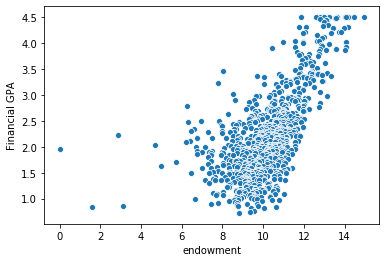

In [487]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x=np.log(dta["endowment"]), y=dta["Financial GPA"])

In [498]:
import statsmodels.api as sm
y = dta['Financial GPA']
x = np.log(dta['endowment'])
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          Financial GPA   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                          1.085e+04
Date:                Mon, 28 Sep 2020   Prob (F-statistic):                        0.00
Time:                        00:00:22   Log-Likelihood:                         -902.09
No. Observations:                 909   AIC:                                      1806.
Df Residuals:                     908   BIC:                                      1811.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------